In [2]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

/Users/hunglungo/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Package Preparation

In [3]:
# Import packages for scrapping from IOS App Store
from app_store_scraper import AppStore

# Import packages for data processing
import pandas as pd
import numpy as np
import json

# Import packages for topic modelling
# Reference: https://www.analyticsvidhya.com/blog/2018/10/mining-online-reviews-topic-modeling-lda/
import nltk
from nltk import FreqDist

import re
import spacy

import gensim
from gensim import corpora
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# text cleaning
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

# Wordcloud of Top N words in each topic
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

# Other pre-setting
pd.set_option("display.max_colwidth", 200)

# Function Preparation

In [4]:
# Function - Scrape review data from App Store
def app_store_scrapperNtransformer(app_name,country,how_many,export_csv_name):
    # Scrape the review data
    fetcher = AppStore(country, app_name)
    fetcher.review(how_many)
    
    # Transform data and put in DataFrame
    transformed_dataframe = pd.DataFrame(np.array(fetcher.reviews),columns=['review'])

    transformed_dataframe = transformed_dataframe.join(pd.DataFrame(transformed_dataframe.pop('review').tolist()))

    transformed_dataframe.to_csv(export_csv_name)

In [5]:
# Function - Plot most frequent terms
def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.show()
    
# use for flattening out list of lists
def flatten(t):
    return [item for sublist in t for item in sublist]

In [6]:
# Text Cleaning
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

In [7]:
# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    # texts = [bigram_mod[doc] for doc in texts]
    # texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out


In [8]:
# Train LDA models and find optimal number of topics
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=100, chunksize=1000, passes=50)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# Scrapping Reviews

In [10]:
'''
app_store_scrapperNtransformer(app_name="YouTube",country="sg",
                           how_many=5000,export_csv_name="youtube_data_sg.csv")
'''
# Status: Completed

'\napp_store_scrapperNtransformer(app_name="YouTube",country="sg",\n                           how_many=5000,export_csv_name="youtube_data_sg.csv")\n'

# Basic Data Preparation

In [11]:
# Import scrapped data
youtube_ios_sg_review = pd.read_csv("youtube_data_sg.csv")

In [12]:
# Inspect the data
youtube_ios_sg_review.head()

Unnamed: 0  rating       userName  \
0           0       5     SunMark II   
1           1       1   animefannsas   
2           2       5           祈望之人   
3           3       5  DanishDoonish   
4           4       4       1992rong   

                                                                                                                                                                                                    review  \
0  The UI is really horrible. Comments right below the description is extremely annoying and inconvenient. And the giant tumbnails in the recommendations below the video is also really inconvenient a...   
1  1) 2 videos play at once. one a video i never clicked on to watch but indicated i have no interest in. that video plays in the bckgrnd and i have no idea why it’s playing. i can only stop it when ...   
2                                                                                                                                                   播放視頻的過程、每隔一段時間就出問題、不知道是接收訊息的問題、還是其他的問題、總是播放不稳定、請問甚麼原因。   
3  I love this app clearly but the new feature that was added not too long ago where i cant  play the video i am watching while searching(certain vids that are meant for kids) but heres the thing, i ...   
4                                                                                                                                                        如果想要观众停留看广告的时间更长，有奖金拿，会有更多人愿意停留观看。而且广告还要耗费流量需要改进。   

                                       title                 date  isEdited  
0  Bad User Interface. Please change it back  2020-05-20 12:10:53     False  
1                                   horrible  2019-06-23 12:51:41     False  
2                                      播放不稳定  2018-12-14 09:12:21     False  
3                                New feature  2020-01-13 10:58:48     False  
4                                 只是个人观点，广告。  2018-10-04 19:24:39     False

In [13]:
# Sort by date, only keep data between 2018 and 2021, clean columns
youtube_ios_sg_review_YearMonth = (youtube_ios_sg_review.copy()
                                                      .sort_values(by='date')
                                                      .reset_index()
                                                      .drop(columns=['index','Unnamed: 0'])
                                                      .query("`date` > '2017-12-31 23:59:59' and \
                                                             `date` < '2021-12-31 23:59:59'")
                                     ) 
# Remove time from date column
youtube_ios_sg_review_YearMonth['date'] = pd.to_datetime(youtube_ios_sg_review_YearMonth['date']).dt.floor('d')

# Create year column
youtube_ios_sg_review_YearMonth['year'] = pd.DatetimeIndex(youtube_ios_sg_review_YearMonth['date']).year

# Create month column
youtube_ios_sg_review_YearMonth['month'] = pd.DatetimeIndex(youtube_ios_sg_review_YearMonth['date']).month

2021-10-16 23:21:58,738 [INFO] numexpr.utils - NumExpr defaulting to 8 threads.


In [14]:
# Inspect the dataframe again after cleaning
youtube_ios_sg_review_YearMonth.head()

rating     userName  \
78       5       Isbe21   
79       3        M I N   
80       3  komatinenis   
81       1    Slackerkt   
82       5    Rizwanoor   

                                                                                                                                                                                                     review  \
78  After the previous update, I have been unable to play the video on iPad after a search. The latest update also did not rectify the issue. I am very disappointed that I can’t play any video that i ...   
79                                                                                                 Did y’all remove the download videos offline feature for this app...? Why wasn’t this on the update logs   
80  Hope it’s not going to be horrible in next releases. First with the quality, then the removal of background playback, and the issue of selecting quality . \n\nAnyway these apps are too big to take...   
81                                                         Team, for your urgent action to come up with a new update as the latest one installed crashes the app. Please take users feedback seriously too.   
82                                                                                                                                                                  Please add background music play option   

                                        title       date  isEdited  year  \
78  Unable to play video on iPad after search 2018-01-07     False  2018   
79      Can’t download videos offline anymore 2018-01-08     False  2018   
80           Going from great to good to bad! 2018-01-13     False  2018   
81              Latest update crashes the app 2018-01-17     False  2018   
82                        Add Background play 2018-01-18     False  2018   

    month  
78      1  
79      1  
80      1  
81      1  
82      1

# EDA

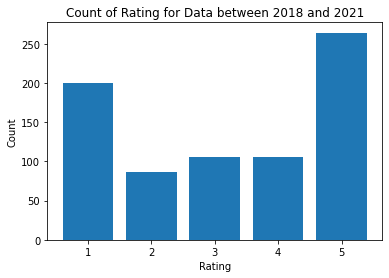

In [15]:
# Plot the count of different ratings for data between 2018 and 2021
youtube_ios_sg_review_score_count = youtube_ios_sg_review_YearMonth.groupby(['rating'])[['review']].nunique().rename(columns={'review':'count'})

plt.bar(youtube_ios_sg_review_score_count.index,youtube_ios_sg_review_score_count['count'])
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Count of Rating for Data between 2018 and 2021")
plt.show()

Text(0.5, 1.0, 'Count of Rating for Each Year between 2018 and 2021')

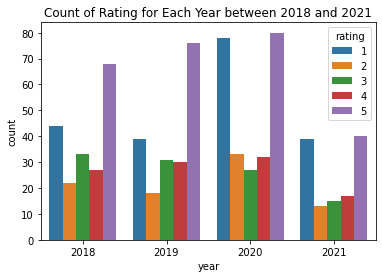

In [16]:
# Plot the count of different ratings for each year
youtube_ios_sg_review_score_count_ByYear = (youtube_ios_sg_review_YearMonth.groupby(['year','rating'])[['review']]
                                                                        .nunique()
                                                                        .rename(columns={'review':'count'})
                                                                        .reset_index()
                                              )

(sns.barplot(data=youtube_ios_sg_review_score_count_ByYear,x='year',y='count',hue='rating')
   .set_title("Count of Rating for Each Year between 2018 and 2021")
)

# Comment: extreme review score on 1 or 5

In [17]:
# Understand average ratings over year
youtube_ios_sg_review_avg_score_ByYear = (youtube_ios_sg_review_YearMonth.groupby(['year'])[['rating']]
                                                                       .mean()
                                              )

youtube_ios_sg_review_avg_score_ByYear['count'] = youtube_ios_sg_review_score_count_ByYear.groupby('year')[['count']].sum().values

print('Average ratings and count of each year:')
youtube_ios_sg_review_avg_score_ByYear

Average ratings and count of each year:


rating  count
year                 
2018  3.273196    194
2019  3.443299    194
2020  3.012000    250
2021  3.048387    124

# Dataframe Preparation for Topic Modelling

In [18]:
# Dataframe with data between 2018 and 2021 without score or year filtering
youtube_ios_sg_review_YearMonth.head()

rating     userName  \
78       5       Isbe21   
79       3        M I N   
80       3  komatinenis   
81       1    Slackerkt   
82       5    Rizwanoor   

                                                                                                                                                                                                     review  \
78  After the previous update, I have been unable to play the video on iPad after a search. The latest update also did not rectify the issue. I am very disappointed that I can’t play any video that i ...   
79                                                                                                 Did y’all remove the download videos offline feature for this app...? Why wasn’t this on the update logs   
80  Hope it’s not going to be horrible in next releases. First with the quality, then the removal of background playback, and the issue of selecting quality . \n\nAnyway these apps are too big to take...   
81                                                         Team, for your urgent action to come up with a new update as the latest one installed crashes the app. Please take users feedback seriously too.   
82                                                                                                                                                                  Please add background music play option   

                                        title       date  isEdited  year  \
78  Unable to play video on iPad after search 2018-01-07     False  2018   
79      Can’t download videos offline anymore 2018-01-08     False  2018   
80           Going from great to good to bad! 2018-01-13     False  2018   
81              Latest update crashes the app 2018-01-17     False  2018   
82                        Add Background play 2018-01-18     False  2018   

    month  
78      1  
79      1  
80      1  
81      1  
82      1

In [19]:
# Prepare dataframe for topic modelling for each score
# Obtain 5 dataframes with only score=1,2,3,4,5
youtube_ios_sg_review_YearMonth_score1 = youtube_ios_sg_review_YearMonth[youtube_ios_sg_review_YearMonth['rating']==1]
youtube_ios_sg_review_YearMonth_score2 = youtube_ios_sg_review_YearMonth[youtube_ios_sg_review_YearMonth['rating']==2]
youtube_ios_sg_review_YearMonth_score3 = youtube_ios_sg_review_YearMonth[youtube_ios_sg_review_YearMonth['rating']==3]
youtube_ios_sg_review_YearMonth_score4 = youtube_ios_sg_review_YearMonth[youtube_ios_sg_review_YearMonth['rating']==4]
youtube_ios_sg_review_YearMonth_score5 = youtube_ios_sg_review_YearMonth[youtube_ios_sg_review_YearMonth['rating']==5]


In [20]:
# Prepare dataframe for grouped score
youtube_ios_sg_review_YearMonth_score1N2N3 = youtube_ios_sg_review_YearMonth[youtube_ios_sg_review_YearMonth['rating'].isin([1,2,3])]
youtube_ios_sg_review_YearMonth_score4N5 = youtube_ios_sg_review_YearMonth[youtube_ios_sg_review_YearMonth['rating'].isin([4,5])]


In [21]:
# Prepare dataframe for topic modelling for 2018,2019,2020,2021 for score = 1,2,3
youtube_ios_sg_review_YearMonth_2018_score1N2N3 = youtube_ios_sg_review_YearMonth[(youtube_ios_sg_review_YearMonth['year']==2018)&(youtube_ios_sg_review_YearMonth['rating'].isin([1,2,3]))]
youtube_ios_sg_review_YearMonth_2019_score1N2N3 = youtube_ios_sg_review_YearMonth[(youtube_ios_sg_review_YearMonth['year']==2019)&(youtube_ios_sg_review_YearMonth['rating'].isin([1,2,3]))]
youtube_ios_sg_review_YearMonth_2020_score1N2N3 = youtube_ios_sg_review_YearMonth[(youtube_ios_sg_review_YearMonth['year']==2020)&(youtube_ios_sg_review_YearMonth['rating'].isin([1,2,3]))]
youtube_ios_sg_review_YearMonth_2021_score1N2N3 = youtube_ios_sg_review_YearMonth[(youtube_ios_sg_review_YearMonth['year']==2021)&(youtube_ios_sg_review_YearMonth['rating'].isin([1,2,3]))]




# Overall LDA Topic Modelling

In [22]:
# Overall Topic Modelling - data between 2018 and 2021 without score or year filtering
# Convert to list - move to each section
review_sg = youtube_ios_sg_review_YearMonth.review.values.tolist()
review_words_sg = list(sent_to_words(review_sg))
print(review_words_sg[:1])

[['after', 'the', 'previous', 'update', 'have', 'been', 'unable', 'to', 'play', 'the', 'video', 'on', 'ipad', 'after', 'search', 'the', 'latest', 'update', 'also', 'did', 'not', 'rectify', 'the', 'issue', 'am', 'very', 'disappointed', 'that', 'can', 'play', 'any', 'video', 'that', 'have', 'searched', 'at', 'all', 'pls', 'rectify', 'the', 'issue', 'for', 'ipad', 'tks']]


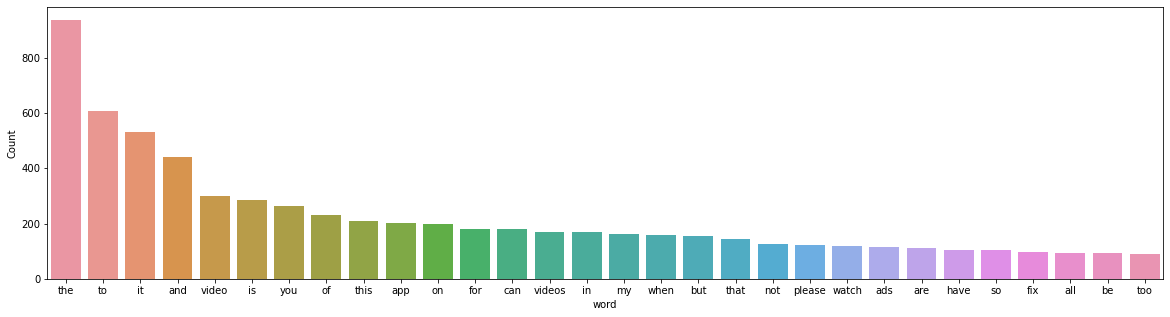

In [23]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_sg))

In [24]:
# Clean text
review_sg_ready = process_words(review_words_sg)  # processed Text Data! - move to each section

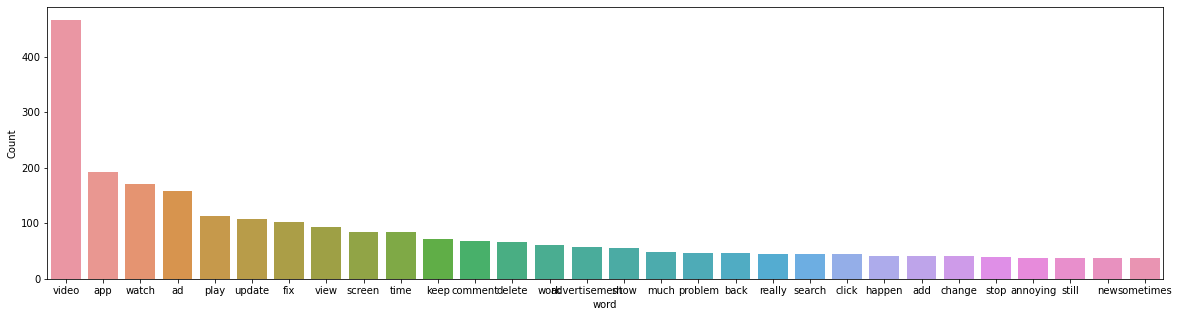

In [25]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_sg_ready))

In [26]:
# Create Dictionary
id2word_sg = corpora.Dictionary(review_sg_ready)

2021-10-16 23:22:41,663 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 23:22:41,764 [INFO] gensim.corpora.dictionary - built Dictionary(1528 unique tokens: ['disappoint', 'ipad', 'issue', 'late', 'play']...) from 762 documents (total 7670 corpus positions)
2021-10-16 23:22:41,815 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(1528 unique tokens: ['disappoint', 'ipad', 'issue', 'late', 'play']...) from 762 documents (total 7670 corpus positions)", 'datetime': '2021-10-16T23:22:41.768016', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [27]:
# Create Corpus: Term Document Frequency
corpus_sg = [id2word_sg.doc2bow(text) for text in review_sg_ready]

In [28]:
# Training LDA model
model_list_sg, coherence_values_sg = compute_coherence_values(dictionary=id2word_sg, corpus=corpus_sg, 
                                                              texts=review_sg_ready, limit=30, start=2, step=5)

# Time Start: 03:44
# Time End: 
# Time Used: 

2021-10-16 23:22:42,272 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 23:22:42,277 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 23:22:42,290 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 23:22:42,298 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 762 documents, updating model once every 762 documents, evaluating perplexity every 762 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 23:22:44,574 [INFO] gensim.models.ldamodel - -7.934 per-word bound, 244.6 perplexity estimate based on a held-out corpus of 762 documents with 7670 words
2021-10-16 23:22:44,575 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #762/762
2021-10-16 23:22:46,644 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.037*"video" + 0.030*"app" + 0.019*"ad" + 0.014*"watch" + 0.014*"play" + 0.012*"fix" + 0.012*"time" + 0

2021-10-16 23:23:09,785 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.060*"video" + 0.026*"watch" + 0.019*"view" + 0.015*"ad" + 0.013*"delete" + 0.013*"screen" + 0.010*"fix" + 0.009*"time" + 0.009*"work" + 0.008*"click"
2021-10-16 23:23:09,792 [INFO] gensim.models.ldamodel - topic diff=0.020465, rho=0.301511
2021-10-16 23:23:11,062 [INFO] gensim.models.ldamodel - -6.525 per-word bound, 92.1 perplexity estimate based on a held-out corpus of 762 documents with 7670 words
2021-10-16 23:23:11,063 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #762/762
2021-10-16 23:23:11,974 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.041*"video" + 0.036*"app" + 0.020*"update" + 0.020*"ad" + 0.018*"play" + 0.012*"fix" + 0.011*"keep" + 0.010*"watch" + 0.010*"time" + 0.007*"new"
2021-10-16 23:23:11,976 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.059*"video" + 0.026*"watch" + 0.019*"view" + 0.015*"ad" + 0.013*"delete" + 0.012*"screen" + 0.010*"fix" + 0.009*"time" + 0.009*

2021-10-16 23:23:30,985 [INFO] gensim.models.ldamodel - topic diff=0.011008, rho=0.218218
2021-10-16 23:23:32,104 [INFO] gensim.models.ldamodel - -6.511 per-word bound, 91.2 perplexity estimate based on a held-out corpus of 762 documents with 7670 words
2021-10-16 23:23:32,105 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #762/762
2021-10-16 23:23:33,064 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.047*"video" + 0.035*"app" + 0.021*"update" + 0.020*"play" + 0.019*"ad" + 0.014*"fix" + 0.011*"watch" + 0.011*"keep" + 0.009*"time" + 0.008*"screen"
2021-10-16 23:23:33,068 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.054*"video" + 0.026*"watch" + 0.020*"view" + 0.016*"ad" + 0.014*"delete" + 0.011*"screen" + 0.009*"time" + 0.009*"click" + 0.009*"work" + 0.009*"fix"
2021-10-16 23:23:33,069 [INFO] gensim.models.ldamodel - topic diff=0.010716, rho=0.213201
2021-10-16 23:23:34,351 [INFO] gensim.models.ldamodel - -6.510 per-word bound, 91.1 perplexity estimate based 

2021-10-16 23:23:55,379 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #762/762
2021-10-16 23:23:56,390 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.052*"video" + 0.035*"app" + 0.021*"update" + 0.021*"play" + 0.018*"ad" + 0.015*"fix" + 0.012*"watch" + 0.011*"keep" + 0.010*"screen" + 0.009*"time"
2021-10-16 23:23:56,392 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.049*"video" + 0.026*"watch" + 0.021*"view" + 0.016*"ad" + 0.015*"delete" + 0.009*"time" + 0.009*"work" + 0.009*"add" + 0.009*"click" + 0.009*"screen"
2021-10-16 23:23:56,394 [INFO] gensim.models.ldamodel - topic diff=0.008775, rho=0.176777
2021-10-16 23:23:57,610 [INFO] gensim.models.ldamodel - -6.500 per-word bound, 90.5 perplexity estimate based on a held-out corpus of 762 documents with 7670 words
2021-10-16 23:23:57,612 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #762/762
2021-10-16 23:23:58,446 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.053*"video" + 0.035*"app" + 

2021-10-16 23:24:16,719 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.044*"video" + 0.024*"watch" + 0.022*"view" + 0.017*"ad" + 0.016*"delete" + 0.009*"time" + 0.009*"add" + 0.009*"work" + 0.007*"change" + 0.007*"click"
2021-10-16 23:24:16,730 [INFO] gensim.models.ldamodel - topic diff=0.007599, rho=0.154303
2021-10-16 23:24:18,089 [INFO] gensim.models.ldamodel - -6.492 per-word bound, 90.0 perplexity estimate based on a held-out corpus of 762 documents with 7670 words
2021-10-16 23:24:18,090 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #762/762
2021-10-16 23:24:19,008 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.057*"video" + 0.034*"app" + 0.021*"update" + 0.021*"play" + 0.018*"ad" + 0.016*"fix" + 0.014*"watch" + 0.012*"screen" + 0.011*"keep" + 0.009*"time"
2021-10-16 23:24:19,011 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.044*"video" + 0.024*"watch" + 0.022*"view" + 0.017*"ad" + 0.016*"delete" + 0.009*"time" + 0.009*"add" + 0.009*"work" + 0.007

2021-10-16 23:24:44,977 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 651 virtual documents
2021-10-16 23:24:45,536 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-16 23:24:45,548 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
2021-10-16 23:24:45,552 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 23:24:45,558 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 7 topics, 50 passes over the supplied corpus of 762 documents, updating model once every 762 documents, evaluating perplexity every 762 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 23:24:48,125 [INFO] gensim.models.ldamodel - -9.380 per-word bound, 666.2 perplexity estimate based on a held-out corpus of 762 documents with 7670 words
2021-10-16 23:24:48,132 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #762/762
2021-10-16 23:24

2021-10-16 23:25:00,544 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #762/762
2021-10-16 23:25:01,470 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.045*"app" + 0.034*"view" + 0.020*"video" + 0.019*"picture" + 0.018*"delete" + 0.012*"open" + 0.012*"way" + 0.011*"change" + 0.010*"music" + 0.009*"channel"
2021-10-16 23:25:01,472 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.051*"video" + 0.047*"ad" + 0.023*"watch" + 0.022*"app" + 0.018*"work" + 0.017*"screen" + 0.014*"time" + 0.013*"delete" + 0.013*"much" + 0.013*"view"
2021-10-16 23:25:01,474 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.026*"video" + 0.018*"keep" + 0.017*"ad" + 0.016*"app" + 0.011*"turn" + 0.010*"anymore" + 0.010*"fix" + 0.009*"play" + 0.009*"feature" + 0.009*"comment"
2021-10-16 23:25:01,476 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.027*"ad" + 0.023*"app" + 0.017*"video" + 0.017*"keep" + 0.014*"time" + 0.014*"add" + 0.012*"update" + 0.009*"annoying" + 0.009*"channel" + 0.008

2021-10-16 23:25:10,261 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.045*"video" + 0.029*"watch" + 0.016*"update" + 0.015*"view" + 0.012*"delete" + 0.011*"app" + 0.010*"screen" + 0.010*"change" + 0.009*"time" + 0.009*"keep"
2021-10-16 23:25:10,263 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.027*"ad" + 0.021*"app" + 0.018*"keep" + 0.015*"add" + 0.014*"video" + 0.014*"time" + 0.012*"update" + 0.010*"annoying" + 0.010*"channel" + 0.008*"really"
2021-10-16 23:25:10,268 [INFO] gensim.models.ldamodel - topic diff=0.020416, rho=0.288675
2021-10-16 23:25:11,271 [INFO] gensim.models.ldamodel - -6.807 per-word bound, 112.0 perplexity estimate based on a held-out corpus of 762 documents with 7670 words
2021-10-16 23:25:11,280 [INFO] gensim.models.ldamodel - PROGRESS: pass 11, at document #762/762
2021-10-16 23:25:11,966 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.091*"video" + 0.035*"play" + 0.035*"watch" + 0.023*"app" + 0.021*"fix" + 0.015*"screen" + 0.014*"update" + 0.014

2021-10-16 23:25:19,541 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #762/762
2021-10-16 23:25:20,230 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.027*"ad" + 0.021*"app" + 0.018*"keep" + 0.016*"add" + 0.013*"time" + 0.013*"video" + 0.012*"update" + 0.011*"channel" + 0.011*"annoying" + 0.008*"really"
2021-10-16 23:25:20,232 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.053*"video" + 0.036*"search" + 0.022*"fix" + 0.020*"comment" + 0.020*"update" + 0.013*"view" + 0.012*"click" + 0.010*"watch" + 0.009*"change" + 0.009*"section"
2021-10-16 23:25:20,233 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.020*"video" + 0.018*"keep" + 0.017*"ad" + 0.012*"turn" + 0.012*"anymore" + 0.011*"app" + 0.009*"comment" + 0.009*"feature" + 0.009*"issue" + 0.008*"fix"
2021-10-16 23:25:20,236 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.054*"ad" + 0.050*"video" + 0.023*"watch" + 0.020*"app" + 0.018*"work" + 0.015*"screen" + 0.015*"advertisement" + 0.014*"much" + 0.014

2021-10-16 23:25:28,710 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.019*"keep" + 0.017*"video" + 0.016*"ad" + 0.012*"anymore" + 0.012*"turn" + 0.010*"comment" + 0.009*"app" + 0.009*"feature" + 0.009*"issue" + 0.008*"already"
2021-10-16 23:25:28,711 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.027*"ad" + 0.020*"app" + 0.018*"keep" + 0.016*"add" + 0.014*"time" + 0.012*"update" + 0.012*"video" + 0.011*"channel" + 0.011*"annoying" + 0.008*"really"
2021-10-16 23:25:28,712 [INFO] gensim.models.ldamodel - topic diff=0.007233, rho=0.208514
2021-10-16 23:25:29,609 [INFO] gensim.models.ldamodel - -6.788 per-word bound, 110.5 perplexity estimate based on a held-out corpus of 762 documents with 7670 words
2021-10-16 23:25:29,611 [INFO] gensim.models.ldamodel - PROGRESS: pass 22, at document #762/762
2021-10-16 23:25:30,576 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.027*"ad" + 0.020*"app" + 0.018*"keep" + 0.016*"add" + 0.013*"time" + 0.012*"update" + 0.012*"video" + 0.011*"c

2021-10-16 23:25:39,157 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #762/762
2021-10-16 23:25:39,836 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.050*"app" + 0.033*"view" + 0.024*"picture" + 0.018*"delete" + 0.018*"open" + 0.017*"change" + 0.015*"music" + 0.013*"way" + 0.012*"video" + 0.009*"channel"
2021-10-16 23:25:39,837 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.093*"video" + 0.036*"play" + 0.034*"watch" + 0.026*"app" + 0.022*"fix" + 0.018*"screen" + 0.017*"update" + 0.014*"show" + 0.012*"load" + 0.011*"black"
2021-10-16 23:25:39,840 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.050*"video" + 0.038*"search" + 0.021*"fix" + 0.021*"comment" + 0.020*"update" + 0.013*"view" + 0.010*"click" + 0.010*"watch" + 0.009*"change" + 0.009*"section"
2021-10-16 23:25:39,842 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.045*"video" + 0.031*"watch" + 0.016*"view" + 0.015*"update" + 0.012*"delete" + 0.010*"change" + 0.009*"time" + 0.009*"app" + 0.009*"l

2021-10-16 23:25:49,488 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.049*"video" + 0.038*"search" + 0.021*"fix" + 0.021*"comment" + 0.020*"update" + 0.013*"view" + 0.010*"click" + 0.009*"watch" + 0.009*"change" + 0.009*"section"
2021-10-16 23:25:49,490 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.027*"ad" + 0.020*"app" + 0.018*"keep" + 0.016*"add" + 0.013*"time" + 0.012*"update" + 0.011*"channel" + 0.011*"annoying" + 0.010*"video" + 0.008*"allow"
2021-10-16 23:25:49,492 [INFO] gensim.models.ldamodel - topic diff=0.004590, rho=0.171499
2021-10-16 23:25:50,555 [INFO] gensim.models.ldamodel - -6.778 per-word bound, 109.7 perplexity estimate based on a held-out corpus of 762 documents with 7670 words
2021-10-16 23:25:50,557 [INFO] gensim.models.ldamodel - PROGRESS: pass 33, at document #762/762
2021-10-16 23:25:51,274 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.049*"app" + 0.032*"view" + 0.024*"picture" + 0.018*"open" + 0.018*"delete" + 0.018*"change" + 0.015*"music" 

2021-10-16 23:25:59,982 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #762/762
2021-10-16 23:26:00,842 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.047*"video" + 0.039*"search" + 0.021*"comment" + 0.020*"fix" + 0.020*"update" + 0.013*"view" + 0.009*"change" + 0.009*"section" + 0.009*"click" + 0.009*"watch"
2021-10-16 23:26:00,845 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.027*"ad" + 0.019*"app" + 0.018*"keep" + 0.017*"add" + 0.013*"time" + 0.012*"channel" + 0.012*"update" + 0.011*"annoying" + 0.010*"video" + 0.008*"allow"
2021-10-16 23:26:00,848 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.019*"keep" + 0.014*"ad" + 0.013*"anymore" + 0.013*"turn" + 0.013*"video" + 0.010*"comment" + 0.009*"feature" + 0.008*"issue" + 0.007*"show" + 0.007*"stop"
2021-10-16 23:26:00,850 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.057*"ad" + 0.052*"video" + 0.024*"watch" + 0.019*"app" + 0.019*"work" + 0.018*"advertisement" + 0.015*"much" + 0.014*"delete" + 0.01

2021-10-16 23:26:09,413 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.057*"ad" + 0.052*"video" + 0.024*"watch" + 0.019*"app" + 0.019*"work" + 0.018*"advertisement" + 0.015*"much" + 0.014*"delete" + 0.014*"view" + 0.013*"time"
2021-10-16 23:26:09,417 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.049*"app" + 0.032*"view" + 0.024*"picture" + 0.018*"open" + 0.018*"change" + 0.018*"delete" + 0.015*"music" + 0.013*"way" + 0.011*"video" + 0.009*"find"
2021-10-16 23:26:09,420 [INFO] gensim.models.ldamodel - topic diff=0.003036, rho=0.149071
2021-10-16 23:26:10,453 [INFO] gensim.models.ldamodel - -6.772 per-word bound, 109.3 perplexity estimate based on a held-out corpus of 762 documents with 7670 words
2021-10-16 23:26:10,454 [INFO] gensim.models.ldamodel - PROGRESS: pass 44, at document #762/762
2021-10-16 23:26:11,127 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.019*"keep" + 0.014*"ad" + 0.014*"turn" + 0.013*"anymore" + 0.012*"video" + 0.010*"comment" + 0.009*"feature" + 0

2021-10-16 23:26:19,167 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #762/762
2021-10-16 23:26:19,884 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.094*"video" + 0.035*"play" + 0.032*"watch" + 0.028*"app" + 0.023*"fix" + 0.019*"update" + 0.019*"screen" + 0.014*"show" + 0.012*"load" + 0.011*"happen"
2021-10-16 23:26:19,900 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.043*"video" + 0.031*"watch" + 0.016*"view" + 0.014*"update" + 0.012*"delete" + 0.010*"change" + 0.010*"time" + 0.009*"live" + 0.009*"app" + 0.008*"keep"
2021-10-16 23:26:19,904 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.046*"video" + 0.039*"search" + 0.021*"comment" + 0.020*"fix" + 0.019*"update" + 0.013*"view" + 0.009*"change" + 0.009*"section" + 0.009*"watch" + 0.008*"click"
2021-10-16 23:26:19,906 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.048*"app" + 0.032*"view" + 0.025*"picture" + 0.018*"change" + 0.018*"delete" + 0.018*"open" + 0.015*"music" + 0.013*"way" + 0.011*"vide

2021-10-16 23:26:39,222 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.029*"view" + 0.022*"app" + 0.018*"video" + 0.018*"picture" + 0.016*"change" + 0.014*"advertisement" + 0.013*"music" + 0.013*"channel" + 0.012*"comment" + 0.012*"reply"
2021-10-16 23:26:39,223 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.076*"video" + 0.057*"play" + 0.028*"ad" + 0.022*"watch" + 0.021*"view" + 0.019*"delete" + 0.015*"app" + 0.013*"stop" + 0.011*"time" + 0.010*"update"
2021-10-16 23:26:39,224 [INFO] gensim.models.ldamodel - topic diff=0.099814, rho=0.447214
2021-10-16 23:26:40,212 [INFO] gensim.models.ldamodel - -6.990 per-word bound, 127.1 perplexity estimate based on a held-out corpus of 762 documents with 7670 words
2021-10-16 23:26:40,214 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #762/762
2021-10-16 23:26:40,923 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.058*"video" + 0.028*"watch" + 0.021*"load" + 0.019*"update" + 0.014*"screen" + 0.013*"advertisement" + 0

2021-10-16 23:26:50,469 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #762/762
2021-10-16 23:26:51,098 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.025*"video" + 0.020*"issue" + 0.018*"keep" + 0.015*"happen" + 0.012*"search" + 0.012*"comment" + 0.012*"show" + 0.012*"application" + 0.009*"like" + 0.009*"bad"
2021-10-16 23:26:51,100 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.064*"ad" + 0.044*"video" + 0.018*"watch" + 0.017*"time" + 0.017*"work" + 0.015*"app" + 0.014*"really" + 0.014*"view" + 0.010*"middle" + 0.010*"annoy"
2021-10-16 23:26:51,104 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.087*"video" + 0.056*"app" + 0.029*"watch" + 0.026*"screen" + 0.023*"fix" + 0.020*"update" + 0.016*"play" + 0.015*"black" + 0.014*"open" + 0.013*"click"
2021-10-16 23:26:51,106 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.058*"video" + 0.028*"watch" + 0.022*"load" + 0.021*"update" + 0.015*"screen" + 0.013*"full" + 0.013*"advertisement" + 0.012*"change" + 0.

2021-10-16 23:26:59,482 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.087*"video" + 0.057*"app" + 0.029*"watch" + 0.026*"screen" + 0.025*"fix" + 0.022*"update" + 0.016*"play" + 0.015*"open" + 0.015*"black" + 0.014*"click"
2021-10-16 23:26:59,484 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.058*"video" + 0.028*"watch" + 0.025*"load" + 0.021*"update" + 0.015*"screen" + 0.013*"full" + 0.013*"advertisement" + 0.012*"ad" + 0.012*"change" + 0.011*"time"
2021-10-16 23:26:59,486 [INFO] gensim.models.ldamodel - topic diff=0.014893, rho=0.250000
2021-10-16 23:27:00,455 [INFO] gensim.models.ldamodel - -6.910 per-word bound, 120.3 perplexity estimate based on a held-out corpus of 762 documents with 7670 words
2021-10-16 23:27:00,456 [INFO] gensim.models.ldamodel - PROGRESS: pass 15, at document #762/762
2021-10-16 23:27:01,099 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.022*"video" + 0.015*"update" + 0.015*"view" + 0.014*"time" + 0.013*"ad" + 0.012*"app" + 0.011*"live" + 0.00

2021-10-16 23:27:09,230 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #762/762
2021-10-16 23:27:10,098 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.021*"video" + 0.016*"update" + 0.016*"view" + 0.013*"time" + 0.012*"ad" + 0.011*"live" + 0.011*"app" + 0.009*"channel" + 0.009*"platform" + 0.009*"thing"
2021-10-16 23:27:10,100 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.072*"video" + 0.059*"play" + 0.038*"view" + 0.033*"delete" + 0.032*"ad" + 0.022*"watch" + 0.017*"stop" + 0.013*"work" + 0.011*"app" + 0.010*"update"
2021-10-16 23:27:10,105 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.020*"anymore" + 0.018*"comment" + 0.017*"channel" + 0.015*"enjoy" + 0.014*"stop" + 0.014*"feature" + 0.014*"ad" + 0.013*"fix" + 0.013*"keep" + 0.011*"new"
2021-10-16 23:27:10,107 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.065*"ad" + 0.045*"video" + 0.019*"watch" + 0.016*"time" + 0.016*"work" + 0.016*"really" + 0.013*"app" + 0.011*"middle" + 0.011*"picture" + 0.

2021-10-16 23:27:19,741 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.043*"love" + 0.041*"app" + 0.040*"much" + 0.030*"watch" + 0.029*"video" + 0.025*"advertisement" + 0.024*"music" + 0.022*"listen" + 0.016*"song" + 0.014*"add"
2021-10-16 23:27:19,744 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.065*"ad" + 0.046*"video" + 0.019*"watch" + 0.016*"really" + 0.016*"work" + 0.015*"time" + 0.013*"app" + 0.011*"middle" + 0.011*"picture" + 0.011*"annoy"
2021-10-16 23:27:19,747 [INFO] gensim.models.ldamodel - topic diff=0.006796, rho=0.192450
2021-10-16 23:27:20,963 [INFO] gensim.models.ldamodel - -6.891 per-word bound, 118.7 perplexity estimate based on a held-out corpus of 762 documents with 7670 words
2021-10-16 23:27:20,964 [INFO] gensim.models.ldamodel - PROGRESS: pass 26, at document #762/762
2021-10-16 23:27:21,698 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.024*"video" + 0.021*"issue" + 0.018*"keep" + 0.015*"happen" + 0.012*"search" + 0.012*"comment" + 0.012*"show" 

2021-10-16 23:27:30,622 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #762/762
2021-10-16 23:27:31,501 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.050*"video" + 0.022*"watch" + 0.019*"comment" + 0.018*"show" + 0.016*"really" + 0.015*"fix" + 0.013*"back" + 0.013*"annoying" + 0.012*"great" + 0.012*"allow"
2021-10-16 23:27:31,508 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.044*"ad" + 0.030*"video" + 0.021*"keep" + 0.018*"watch" + 0.013*"app" + 0.013*"press" + 0.011*"well" + 0.010*"fix" + 0.009*"volume" + 0.008*"click"
2021-10-16 23:27:31,513 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.044*"love" + 0.041*"app" + 0.040*"much" + 0.031*"watch" + 0.029*"video" + 0.025*"advertisement" + 0.024*"music" + 0.022*"listen" + 0.016*"song" + 0.014*"add"
2021-10-16 23:27:31,515 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.069*"video" + 0.057*"play" + 0.048*"view" + 0.039*"delete" + 0.032*"ad" + 0.021*"watch" + 0.018*"stop" + 0.015*"work" + 0.010*"app" + 0

2021-10-16 23:27:41,316 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.045*"love" + 0.041*"app" + 0.039*"much" + 0.032*"watch" + 0.028*"video" + 0.025*"advertisement" + 0.024*"music" + 0.022*"listen" + 0.016*"song" + 0.014*"add"
2021-10-16 23:27:41,319 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.049*"video" + 0.022*"watch" + 0.019*"comment" + 0.017*"show" + 0.017*"really" + 0.014*"fix" + 0.013*"back" + 0.012*"great" + 0.012*"annoying" + 0.012*"allow"
2021-10-16 23:27:41,321 [INFO] gensim.models.ldamodel - topic diff=0.004618, rho=0.162221
2021-10-16 23:27:42,345 [INFO] gensim.models.ldamodel - -6.881 per-word bound, 117.9 perplexity estimate based on a held-out corpus of 762 documents with 7670 words
2021-10-16 23:27:42,348 [INFO] gensim.models.ldamodel - PROGRESS: pass 37, at document #762/762
2021-10-16 23:27:43,097 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.067*"video" + 0.056*"play" + 0.052*"view" + 0.042*"delete" + 0.032*"ad" + 0.021*"watch" + 0.018*"stop" +

2021-10-16 23:27:51,873 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #762/762
2021-10-16 23:27:52,597 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.023*"video" + 0.021*"issue" + 0.018*"keep" + 0.015*"happen" + 0.012*"search" + 0.012*"show" + 0.012*"comment" + 0.012*"application" + 0.010*"volume" + 0.009*"like"
2021-10-16 23:27:52,600 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.048*"ad" + 0.028*"video" + 0.020*"keep" + 0.018*"watch" + 0.013*"press" + 0.012*"app" + 0.011*"well" + 0.010*"fix" + 0.010*"volume" + 0.009*"airplay"
2021-10-16 23:27:52,602 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.066*"video" + 0.055*"play" + 0.055*"view" + 0.045*"delete" + 0.031*"ad" + 0.020*"watch" + 0.018*"stop" + 0.018*"work" + 0.011*"app" + 0.009*"time"
2021-10-16 23:27:52,604 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.067*"ad" + 0.045*"video" + 0.020*"watch" + 0.016*"really" + 0.014*"work" + 0.013*"middle" + 0.013*"time" + 0.013*"app" + 0.011*"annoy" + 0

2021-10-16 23:28:01,722 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.021*"anymore" + 0.018*"channel" + 0.018*"comment" + 0.015*"enjoy" + 0.014*"feature" + 0.014*"ad" + 0.013*"stop" + 0.013*"keep" + 0.013*"fix" + 0.011*"video"
2021-10-16 23:28:01,726 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.049*"ad" + 0.028*"video" + 0.020*"keep" + 0.018*"watch" + 0.013*"press" + 0.012*"app" + 0.011*"well" + 0.010*"volume" + 0.009*"airplay" + 0.009*"annoying"
2021-10-16 23:28:01,727 [INFO] gensim.models.ldamodel - topic diff=0.003453, rho=0.142857
2021-10-16 23:28:02,620 [INFO] gensim.models.ldamodel - -6.871 per-word bound, 117.0 perplexity estimate based on a held-out corpus of 762 documents with 7670 words
2021-10-16 23:28:02,622 [INFO] gensim.models.ldamodel - PROGRESS: pass 48, at document #762/762
2021-10-16 23:28:03,190 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.065*"video" + 0.057*"view" + 0.054*"play" + 0.047*"delete" + 0.031*"ad" + 0.020*"watch" + 0.019*"stop" + 0.0

2021-10-16 23:28:17,727 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.039*"view" + 0.031*"video" + 0.027*"app" + 0.022*"time" + 0.020*"delete" + 0.019*"update" + 0.017*"watch" + 0.013*"change" + 0.012*"ad" + 0.012*"load"
2021-10-16 23:28:17,728 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.039*"video" + 0.027*"app" + 0.025*"keep" + 0.020*"update" + 0.017*"problem" + 0.016*"ad" + 0.016*"time" + 0.012*"playlist" + 0.012*"fix" + 0.011*"channel"
2021-10-16 23:28:17,731 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.062*"video" + 0.048*"app" + 0.030*"watch" + 0.024*"screen" + 0.023*"play" + 0.019*"add" + 0.019*"sometimes" + 0.017*"black" + 0.016*"time" + 0.015*"back"
2021-10-16 23:28:17,733 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.032*"video" + 0.017*"update" + 0.017*"section" + 0.017*"time" + 0.016*"work" + 0.016*"comment" + 0.013*"bad" + 0.013*"new" + 0.011*"fix" + 0.010*"excellent"
2021-10-16 23:28:17,735 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.0

2021-10-16 23:28:25,510 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.029*"ad" + 0.021*"app" + 0.021*"update" + 0.019*"video" + 0.019*"watch" + 0.013*"comment" + 0.013*"call" + 0.013*"account" + 0.012*"sure" + 0.010*"still"
2021-10-16 23:28:25,513 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.022*"video" + 0.020*"app" + 0.018*"update" + 0.013*"watch" + 0.012*"ad" + 0.012*"change" + 0.011*"search" + 0.011*"keep" + 0.011*"feature" + 0.010*"back"
2021-10-16 23:28:25,515 [INFO] gensim.models.ldamodel - topic diff=0.048264, rho=0.333333
2021-10-16 23:28:26,420 [INFO] gensim.models.ldamodel - -7.075 per-word bound, 134.9 perplexity estimate based on a held-out corpus of 762 documents with 7670 words
2021-10-16 23:28:26,424 [INFO] gensim.models.ldamodel - PROGRESS: pass 8, at document #762/762
2021-10-16 23:28:27,093 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.072*"video" + 0.045*"app" + 0.033*"screen" + 0.029*"watch" + 0.025*"black" + 0.024*"play" + 0.020*"sometimes" +

2021-10-16 23:28:34,467 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #762/762
2021-10-16 23:28:35,123 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.096*"video" + 0.042*"play" + 0.032*"app" + 0.030*"ad" + 0.030*"watch" + 0.017*"fix" + 0.013*"update" + 0.012*"turn" + 0.011*"screen" + 0.011*"open"
2021-10-16 23:28:35,124 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.029*"video" + 0.022*"ad" + 0.019*"watch" + 0.019*"work" + 0.019*"app" + 0.018*"long" + 0.018*"time" + 0.017*"delete" + 0.016*"play" + 0.015*"view"
2021-10-16 23:28:35,127 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.035*"video" + 0.024*"comment" + 0.023*"section" + 0.015*"bad" + 0.015*"update" + 0.012*"time" + 0.012*"new" + 0.012*"fix" + 0.011*"work" + 0.008*"user"
2021-10-16 23:28:35,133 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.029*"ad" + 0.022*"app" + 0.022*"update" + 0.019*"video" + 0.019*"watch" + 0.013*"comment" + 0.013*"call" + 0.013*"account" + 0.013*"sure" + 0.013*"pic

2021-10-16 23:28:43,774 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.066*"video" + 0.036*"ad" + 0.021*"comment" + 0.020*"play" + 0.020*"great" + 0.014*"ever" + 0.014*"device" + 0.011*"screen" + 0.011*"top" + 0.011*"give"
2021-10-16 23:28:43,776 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.063*"view" + 0.031*"delete" + 0.026*"video" + 0.022*"app" + 0.020*"update" + 0.020*"picture" + 0.019*"time" + 0.015*"day" + 0.014*"change" + 0.014*"watch"
2021-10-16 23:28:43,778 [INFO] gensim.models.ldamodel - topic diff=0.009759, rho=0.223607
2021-10-16 23:28:44,857 [INFO] gensim.models.ldamodel - -7.033 per-word bound, 130.9 perplexity estimate based on a held-out corpus of 762 documents with 7670 words
2021-10-16 23:28:44,858 [INFO] gensim.models.ldamodel - PROGRESS: pass 19, at document #762/762
2021-10-16 23:28:45,599 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.062*"view" + 0.021*"delete" + 0.019*"comment" + 0.019*"way" + 0.018*"reply" + 0.015*"video" + 0.012*"ad" + 0.012*

2021-10-16 23:28:54,025 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #762/762
2021-10-16 23:28:54,769 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.067*"video" + 0.038*"ad" + 0.021*"play" + 0.021*"great" + 0.019*"comment" + 0.014*"ever" + 0.014*"device" + 0.011*"screen" + 0.011*"app" + 0.011*"top"
2021-10-16 23:28:54,770 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.063*"video" + 0.025*"watch" + 0.020*"screen" + 0.019*"advertisement" + 0.017*"upload" + 0.014*"happen" + 0.013*"comment" + 0.012*"app" + 0.012*"volume" + 0.011*"still"
2021-10-16 23:28:54,773 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.077*"video" + 0.044*"app" + 0.032*"screen" + 0.029*"watch" + 0.026*"black" + 0.024*"play" + 0.020*"time" + 0.019*"sometimes" + 0.019*"annoying" + 0.018*"fix"
2021-10-16 23:28:54,775 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.059*"video" + 0.047*"search" + 0.020*"watch" + 0.017*"comment" + 0.016*"fix" + 0.016*"update" + 0.015*"keep" + 0.013*"sh

2021-10-16 23:29:03,979 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.062*"view" + 0.021*"delete" + 0.019*"way" + 0.018*"comment" + 0.018*"reply" + 0.014*"video" + 0.012*"whole" + 0.012*"list" + 0.012*"time" + 0.012*"excellent"
2021-10-16 23:29:03,980 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.095*"video" + 0.044*"play" + 0.032*"app" + 0.030*"ad" + 0.029*"watch" + 0.017*"fix" + 0.013*"update" + 0.011*"screen" + 0.011*"open" + 0.011*"turn"
2021-10-16 23:29:03,981 [INFO] gensim.models.ldamodel - topic diff=0.004313, rho=0.179605
2021-10-16 23:29:05,172 [INFO] gensim.models.ldamodel - -7.021 per-word bound, 129.8 perplexity estimate based on a held-out corpus of 762 documents with 7670 words
2021-10-16 23:29:05,182 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #762/762
2021-10-16 23:29:05,919 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.043*"ad" + 0.033*"video" + 0.021*"watch" + 0.018*"keep" + 0.014*"well" + 0.014*"screen" + 0.013*"fix" + 0.013*"cli

2021-10-16 23:29:15,111 [INFO] gensim.models.ldamodel - PROGRESS: pass 35, at document #762/762
2021-10-16 23:29:15,734 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.023*"app" + 0.023*"video" + 0.017*"update" + 0.015*"ad" + 0.013*"feature" + 0.013*"watch" + 0.012*"change" + 0.012*"remove" + 0.010*"put" + 0.010*"user"
2021-10-16 23:29:15,739 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.067*"video" + 0.044*"ad" + 0.022*"play" + 0.021*"great" + 0.017*"comment" + 0.014*"ever" + 0.014*"device" + 0.012*"screen" + 0.011*"app" + 0.011*"top"
2021-10-16 23:29:15,741 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.027*"video" + 0.025*"long" + 0.024*"app" + 0.021*"ad" + 0.020*"watch" + 0.019*"time" + 0.018*"work" + 0.017*"delete" + 0.015*"upload" + 0.015*"much"
2021-10-16 23:29:15,743 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.040*"much" + 0.022*"watch" + 0.019*"video" + 0.018*"vid" + 0.016*"song" + 0.016*"advertisement" + 0.015*"ad" + 0.015*"app" + 0.015*"update" + 0.

2021-10-16 23:29:25,112 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.068*"video" + 0.048*"ad" + 0.023*"play" + 0.021*"great" + 0.018*"comment" + 0.014*"ever" + 0.014*"device" + 0.012*"screen" + 0.011*"app" + 0.011*"top"
2021-10-16 23:29:25,117 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.030*"ad" + 0.025*"app" + 0.021*"update" + 0.018*"watch" + 0.017*"video" + 0.016*"picture" + 0.014*"call" + 0.014*"account" + 0.014*"sure" + 0.011*"still"
2021-10-16 23:29:25,119 [INFO] gensim.models.ldamodel - topic diff=0.002539, rho=0.154303
2021-10-16 23:29:26,108 [INFO] gensim.models.ldamodel - -7.015 per-word bound, 129.3 perplexity estimate based on a held-out corpus of 762 documents with 7670 words
2021-10-16 23:29:26,110 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #762/762
2021-10-16 23:29:26,835 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.047*"view" + 0.038*"video" + 0.038*"delete" + 0.024*"work" + 0.022*"hard" + 0.019*"ad" + 0.019*"app" + 0.014*"time

2021-10-16 23:29:34,966 [INFO] gensim.models.ldamodel - PROGRESS: pass 46, at document #762/762
2021-10-16 23:29:35,840 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.030*"ad" + 0.025*"app" + 0.021*"update" + 0.017*"watch" + 0.017*"video" + 0.016*"picture" + 0.014*"call" + 0.014*"account" + 0.014*"sure" + 0.011*"still"
2021-10-16 23:29:35,843 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.058*"video" + 0.028*"watch" + 0.024*"advertisement" + 0.020*"fix" + 0.017*"problem" + 0.017*"thing" + 0.016*"app" + 0.016*"show" + 0.011*"enjoy" + 0.011*"play"
2021-10-16 23:29:35,849 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.023*"video" + 0.023*"app" + 0.017*"update" + 0.015*"ad" + 0.013*"watch" + 0.013*"feature" + 0.012*"change" + 0.012*"remove" + 0.011*"put" + 0.011*"really"
2021-10-16 23:29:35,852 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.094*"video" + 0.045*"play" + 0.033*"app" + 0.030*"ad" + 0.028*"watch" + 0.017*"fix" + 0.013*"update" + 0.012*"open" + 0.012*"scr

2021-10-16 23:29:54,007 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.057*"video" + 0.030*"watch" + 0.022*"fix" + 0.017*"comment" + 0.017*"play" + 0.015*"advertisement" + 0.015*"time" + 0.012*"app" + 0.011*"update" + 0.011*"turn"
2021-10-16 23:29:54,009 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.038*"video" + 0.034*"ad" + 0.027*"watch" + 0.022*"keep" + 0.014*"much" + 0.013*"app" + 0.012*"delete" + 0.011*"view" + 0.011*"advertisement" + 0.011*"comment"
2021-10-16 23:29:54,011 [INFO] gensim.models.ldamodel - topic diff=17.628510, rho=1.000000
2021-10-16 23:29:55,015 [INFO] gensim.models.ldamodel - -7.430 per-word bound, 172.5 perplexity estimate based on a held-out corpus of 762 documents with 7670 words
2021-10-16 23:29:55,043 [INFO] gensim.models.ldamodel - PROGRESS: pass 1, at document #762/762
2021-10-16 23:29:55,651 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.058*"video" + 0.029*"screen" + 0.020*"watch" + 0.018*"time" + 0.017*"update" + 0.014*"annoying" + 0.01

2021-10-16 23:30:04,023 [INFO] gensim.models.ldamodel - PROGRESS: pass 6, at document #762/762
2021-10-16 23:30:04,994 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.071*"ad" + 0.042*"video" + 0.018*"call" + 0.017*"play" + 0.014*"skip" + 0.011*"keep" + 0.011*"screen" + 0.011*"non" + 0.011*"idea" + 0.011*"channel"
2021-10-16 23:30:04,998 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.031*"keep" + 0.028*"anymore" + 0.023*"load" + 0.019*"excellent" + 0.018*"show" + 0.018*"enjoy" + 0.016*"service" + 0.014*"dislike" + 0.013*"lag" + 0.013*"well"
2021-10-16 23:30:05,007 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.052*"video" + 0.024*"watch" + 0.020*"comment" + 0.019*"fix" + 0.015*"time" + 0.013*"really" + 0.012*"show" + 0.012*"allow" + 0.011*"back" + 0.011*"advertisement"
2021-10-16 23:30:05,024 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.044*"video" + 0.035*"ad" + 0.019*"app" + 0.018*"quality" + 0.015*"star" + 0.015*"update" + 0.012*"way" + 0.011*"back" + 0.009*"i

2021-10-16 23:30:13,321 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.076*"video" + 0.067*"advertisement" + 0.041*"ad" + 0.033*"watch" + 0.032*"much" + 0.019*"minute" + 0.016*"put" + 0.015*"update" + 0.014*"still" + 0.013*"user"
2021-10-16 23:30:13,331 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.119*"view" + 0.068*"delete" + 0.025*"work" + 0.024*"hard" + 0.021*"comment" + 0.016*"app" + 0.014*"give" + 0.014*"people" + 0.013*"time" + 0.012*"fix"
2021-10-16 23:30:13,334 [INFO] gensim.models.ldamodel - topic diff=0.028843, rho=0.277350
2021-10-16 23:30:14,233 [INFO] gensim.models.ldamodel - -7.112 per-word bound, 138.3 perplexity estimate based on a held-out corpus of 762 documents with 7670 words
2021-10-16 23:30:14,234 [INFO] gensim.models.ldamodel - PROGRESS: pass 12, at document #762/762
2021-10-16 23:30:14,832 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.031*"app" + 0.029*"fix" + 0.027*"update" + 0.019*"video" + 0.018*"big" + 0.017*"hope" + 0.016*"watch" + 0.01

2021-10-16 23:30:22,475 [INFO] gensim.models.ldamodel - PROGRESS: pass 17, at document #762/762
2021-10-16 23:30:23,111 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.055*"app" + 0.042*"love" + 0.033*"watch" + 0.030*"video" + 0.018*"show" + 0.017*"great" + 0.015*"fix" + 0.014*"live" + 0.014*"channel" + 0.013*"music"
2021-10-16 23:30:23,113 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.056*"video" + 0.040*"screen" + 0.021*"watch" + 0.016*"update" + 0.015*"time" + 0.012*"annoying" + 0.012*"black" + 0.012*"app" + 0.012*"exit" + 0.012*"mode"
2021-10-16 23:30:23,116 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.030*"keep" + 0.028*"anymore" + 0.027*"load" + 0.025*"enjoy" + 0.023*"excellent" + 0.023*"service" + 0.019*"show" + 0.016*"well" + 0.016*"lag" + 0.014*"dislike"
2021-10-16 23:30:23,118 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.038*"video" + 0.037*"ad" + 0.021*"quality" + 0.016*"app" + 0.016*"star" + 0.013*"website" + 0.012*"way" + 0.011*"back" + 0.011*"con

2021-10-16 23:30:31,727 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.034*"video" + 0.028*"slow" + 0.026*"ad" + 0.025*"watch" + 0.021*"app" + 0.019*"stop" + 0.017*"time" + 0.015*"add" + 0.015*"full" + 0.013*"open"
2021-10-16 23:30:31,728 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.058*"volume" + 0.031*"fix" + 0.024*"wrong" + 0.023*"video" + 0.016*"bug" + 0.016*"increase" + 0.016*"happen" + 0.012*"appear" + 0.012*"black" + 0.011*"watch"
2021-10-16 23:30:31,729 [INFO] gensim.models.ldamodel - topic diff=0.009973, rho=0.204124
2021-10-16 23:30:32,572 [INFO] gensim.models.ldamodel - -7.071 per-word bound, 134.5 perplexity estimate based on a held-out corpus of 762 documents with 7670 words
2021-10-16 23:30:32,573 [INFO] gensim.models.ldamodel - PROGRESS: pass 23, at document #762/762
2021-10-16 23:30:33,292 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.050*"video" + 0.023*"comment" + 0.018*"watch" + 0.016*"fix" + 0.016*"really" + 0.015*"song" + 0.015*"time" + 0.013*"al

2021-10-16 23:30:40,881 [INFO] gensim.models.ldamodel - PROGRESS: pass 28, at document #762/762
2021-10-16 23:30:41,446 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.051*"app" + 0.043*"love" + 0.039*"watch" + 0.029*"video" + 0.017*"show" + 0.017*"great" + 0.016*"music" + 0.015*"live" + 0.014*"channel" + 0.012*"fix"
2021-10-16 23:30:41,451 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.037*"video" + 0.024*"watch" + 0.021*"different" + 0.018*"account" + 0.017*"search" + 0.015*"keep" + 0.013*"view" + 0.013*"disappear" + 0.013*"available" + 0.012*"ad"
2021-10-16 23:30:41,453 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.028*"channel" + 0.028*"video" + 0.018*"update" + 0.018*"bad" + 0.017*"late" + 0.016*"search" + 0.013*"way" + 0.012*"watch" + 0.012*"comment" + 0.012*"play"
2021-10-16 23:30:41,457 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.047*"app" + 0.017*"reply" + 0.017*"picture" + 0.017*"next" + 0.017*"comment" + 0.017*"vid" + 0.014*"advertisement" + 0.014*"wh

2021-10-16 23:30:49,244 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.028*"channel" + 0.026*"video" + 0.018*"bad" + 0.017*"late" + 0.017*"update" + 0.016*"search" + 0.013*"way" + 0.012*"watch" + 0.012*"comment" + 0.011*"advertisement"
2021-10-16 23:30:49,247 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.073*"app" + 0.050*"crash" + 0.044*"update" + 0.019*"open" + 0.019*"screen" + 0.016*"feature" + 0.014*"way" + 0.014*"new" + 0.014*"account" + 0.013*"iphone"
2021-10-16 23:30:49,251 [INFO] gensim.models.ldamodel - topic diff=0.005202, rho=0.169031
2021-10-16 23:30:50,352 [INFO] gensim.models.ldamodel - -7.053 per-word bound, 132.8 perplexity estimate based on a held-out corpus of 762 documents with 7670 words
2021-10-16 23:30:50,353 [INFO] gensim.models.ldamodel - PROGRESS: pass 34, at document #762/762
2021-10-16 23:30:51,123 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.126*"video" + 0.057*"play" + 0.033*"app" + 0.030*"watch" + 0.026*"ad" + 0.022*"fix" + 0.019*"click

2021-10-16 23:30:59,488 [INFO] gensim.models.ldamodel - PROGRESS: pass 39, at document #762/762
2021-10-16 23:31:00,229 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.045*"ad" + 0.022*"keep" + 0.016*"stop" + 0.016*"help" + 0.014*"premium" + 0.012*"video" + 0.012*"much" + 0.012*"app" + 0.011*"airplay" + 0.011*"advert"
2021-10-16 23:31:00,231 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.051*"video" + 0.023*"comment" + 0.018*"watch" + 0.017*"song" + 0.017*"really" + 0.015*"time" + 0.015*"fix" + 0.013*"allow" + 0.013*"back" + 0.013*"listen"
2021-10-16 23:31:00,234 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.059*"video" + 0.041*"screen" + 0.022*"watch" + 0.017*"time" + 0.014*"update" + 0.013*"fix" + 0.013*"mode" + 0.012*"annoying" + 0.012*"black" + 0.012*"full"
2021-10-16 23:31:00,237 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.036*"ad" + 0.034*"video" + 0.023*"quality" + 0.016*"star" + 0.015*"app" + 0.013*"website" + 0.013*"amazing" + 0.013*"content" + 0.012*"b

2021-10-16 23:31:09,630 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.051*"video" + 0.022*"comment" + 0.018*"watch" + 0.017*"song" + 0.017*"really" + 0.015*"time" + 0.014*"fix" + 0.013*"allow" + 0.013*"back" + 0.013*"listen"
2021-10-16 23:31:09,633 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.131*"view" + 0.080*"delete" + 0.027*"work" + 0.026*"hard" + 0.023*"comment" + 0.017*"give" + 0.015*"time" + 0.015*"people" + 0.012*"really" + 0.012*"app"
2021-10-16 23:31:09,634 [INFO] gensim.models.ldamodel - topic diff=0.003259, rho=0.147442
2021-10-16 23:31:10,831 [INFO] gensim.models.ldamodel - -7.044 per-word bound, 132.0 perplexity estimate based on a held-out corpus of 762 documents with 7670 words
2021-10-16 23:31:10,833 [INFO] gensim.models.ldamodel - PROGRESS: pass 45, at document #762/762
2021-10-16 23:31:11,499 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.047*"app" + 0.022*"vid" + 0.017*"reply" + 0.017*"next" + 0.017*"comment" + 0.014*"whole" + 0.013*"advertisement

2021-10-16 23:31:19,150 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 23:31:25,431 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 23:31:25,505 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 720 virtual documents
2021-10-16 23:31:30,529 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.037037037037037035
2021-10-16 23:31:30,531 [INFO] gensim.models.ldamodel - using symmetric eta at 0.037037037037037035
2021-10-16 23:31:30,534 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 23:31:30,545 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 27 topics, 50 passes over the supplied corpus of 762 documents, updating model once every 762 documents, evaluating perplexity every 762 documents, iterating 50x with a 

2021-10-16 23:31:42,392 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.079*"video" + 0.025*"ad" + 0.025*"time" + 0.016*"keep" + 0.015*"channel" + 0.013*"watch" + 0.012*"screen" + 0.011*"app" + 0.010*"press" + 0.010*"view"
2021-10-16 23:31:42,393 [INFO] gensim.models.ldamodel - topic diff=0.080508, rho=0.408248
2021-10-16 23:31:43,410 [INFO] gensim.models.ldamodel - -7.335 per-word bound, 161.4 perplexity estimate based on a held-out corpus of 762 documents with 7670 words
2021-10-16 23:31:43,411 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #762/762
2021-10-16 23:31:44,193 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.045*"video" + 0.042*"view" + 0.035*"stop" + 0.029*"delete" + 0.019*"live" + 0.017*"keep" + 0.016*"stream" + 0.014*"issue" + 0.013*"app" + 0.013*"hate"
2021-10-16 23:31:44,197 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.043*"video" + 0.025*"ad" + 0.023*"screen" + 0.017*"watch" + 0.015*"work" + 0.011*"give" + 0.011*"time" + 0.010*"really

2021-10-16 23:31:56,326 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.041*"watch" + 0.041*"video" + 0.029*"love" + 0.028*"app" + 0.017*"screen" + 0.015*"fix" + 0.014*"long" + 0.014*"thing" + 0.013*"unable" + 0.013*"help"
2021-10-16 23:31:56,331 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.068*"video" + 0.030*"ad" + 0.026*"watch" + 0.020*"user" + 0.017*"screen" + 0.016*"allow" + 0.016*"able" + 0.015*"advertisement" + 0.014*"update" + 0.014*"still"
2021-10-16 23:31:56,342 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.044*"video" + 0.027*"ad" + 0.021*"screen" + 0.019*"watch" + 0.012*"work" + 0.012*"give" + 0.011*"really" + 0.011*"time" + 0.010*"advertisement" + 0.010*"people"
2021-10-16 23:31:56,356 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.038*"video" + 0.024*"app" + 0.024*"problem" + 0.016*"hope" + 0.014*"watch" + 0.014*"screen" + 0.014*"section" + 0.014*"big" + 0.013*"bug" + 0.012*"error"
2021-10-16 23:31:56,358 [INFO] gensim.models.ldamodel - topic #0 (0

2021-10-16 23:32:08,017 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.072*"app" + 0.072*"crash" + 0.060*"update" + 0.022*"keep" + 0.019*"change" + 0.018*"lag" + 0.017*"button" + 0.015*"feature" + 0.015*"anymore" + 0.015*"device"
2021-10-16 23:32:08,021 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.047*"ad" + 0.035*"video" + 0.034*"play" + 0.022*"app" + 0.014*"watch" + 0.014*"happen" + 0.014*"auto" + 0.011*"show" + 0.011*"entertainment" + 0.009*"work"
2021-10-16 23:32:08,022 [INFO] gensim.models.ldamodel - topic diff=0.019973, rho=0.242536
2021-10-16 23:32:09,133 [INFO] gensim.models.ldamodel - -7.217 per-word bound, 148.8 perplexity estimate based on a held-out corpus of 762 documents with 7670 words
2021-10-16 23:32:09,134 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #762/762
2021-10-16 23:32:09,886 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.047*"comment" + 0.026*"much" + 0.021*"back" + 0.018*"app" + 0.017*"top" + 0.016*"ad" + 0.013*"video" + 0

2021-10-16 23:32:19,994 [INFO] gensim.models.ldamodel - PROGRESS: pass 21, at document #762/762
2021-10-16 23:32:20,771 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.077*"video" + 0.028*"time" + 0.026*"ad" + 0.016*"keep" + 0.016*"channel" + 0.013*"watch" + 0.013*"screen" + 0.011*"work" + 0.010*"app" + 0.009*"interested"
2021-10-16 23:32:20,774 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.063*"picture" + 0.040*"app" + 0.034*"add" + 0.033*"music" + 0.025*"playlist" + 0.018*"video" + 0.017*"remove" + 0.016*"change" + 0.016*"background" + 0.016*"listen"
2021-10-16 23:32:20,779 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.049*"video" + 0.034*"comment" + 0.032*"watch" + 0.023*"show" + 0.016*"tube" + 0.016*"really" + 0.014*"section" + 0.012*"time" + 0.012*"still" + 0.012*"change"
2021-10-16 23:32:20,783 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.071*"video" + 0.027*"ad" + 0.027*"watch" + 0.026*"user" + 0.017*"advertisement" + 0.017*"screen" + 0.016*"allow" + 0.

2021-10-16 23:32:31,110 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.032*"video" + 0.025*"view" + 0.016*"thing" + 0.012*"delete" + 0.012*"iphone" + 0.012*"watch" + 0.012*"change" + 0.012*"first" + 0.010*"play" + 0.008*"kid"
2021-10-16 23:32:31,114 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.075*"video" + 0.028*"time" + 0.024*"ad" + 0.016*"keep" + 0.016*"channel" + 0.013*"watch" + 0.013*"screen" + 0.011*"work" + 0.010*"app" + 0.010*"interested"
2021-10-16 23:32:31,115 [INFO] gensim.models.ldamodel - topic diff=0.007888, rho=0.188982
2021-10-16 23:32:32,136 [INFO] gensim.models.ldamodel - -7.186 per-word bound, 145.6 perplexity estimate based on a held-out corpus of 762 documents with 7670 words
2021-10-16 23:32:32,141 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #762/762
2021-10-16 23:32:32,912 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.127*"app" + 0.033*"open" + 0.020*"advertisement" + 0.020*"vid" + 0.020*"long" + 0.019*"back" + 0.015*"store"

2021-10-16 23:32:41,666 [INFO] gensim.models.ldamodel - PROGRESS: pass 32, at document #762/762
2021-10-16 23:32:42,408 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.049*"comment" + 0.026*"much" + 0.021*"back" + 0.018*"app" + 0.018*"top" + 0.016*"ad" + 0.015*"advert" + 0.013*"video" + 0.012*"really" + 0.010*"watch"
2021-10-16 23:32:42,411 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.087*"search" + 0.034*"app" + 0.028*"tap" + 0.019*"great" + 0.019*"history" + 0.017*"watch" + 0.017*"fix" + 0.016*"back" + 0.015*"play" + 0.015*"bar"
2021-10-16 23:32:42,415 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.127*"app" + 0.033*"open" + 0.020*"advertisement" + 0.020*"vid" + 0.020*"long" + 0.019*"back" + 0.015*"store" + 0.014*"bring" + 0.013*"hang" + 0.011*"keep"
2021-10-16 23:32:42,418 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.122*"ad" + 0.034*"video" + 0.026*"keep" + 0.020*"skip" + 0.019*"annoying" + 0.017*"great" + 0.014*"watch" + 0.013*"pay" + 0.013*"advertisement"

2021-10-16 23:32:51,303 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.040*"ad" + 0.033*"video" + 0.032*"play" + 0.022*"app" + 0.015*"happen" + 0.015*"auto" + 0.013*"watch" + 0.012*"entertainment" + 0.011*"show" + 0.009*"often"
2021-10-16 23:32:51,305 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.043*"video" + 0.038*"app" + 0.035*"slow" + 0.034*"load" + 0.022*"keep" + 0.021*"fix" + 0.020*"play" + 0.015*"watch" + 0.015*"ad" + 0.015*"update"
2021-10-16 23:32:51,307 [INFO] gensim.models.ldamodel - topic diff=0.004310, rho=0.160128
2021-10-16 23:32:52,391 [INFO] gensim.models.ldamodel - -7.174 per-word bound, 144.4 perplexity estimate based on a held-out corpus of 762 documents with 7670 words
2021-10-16 23:32:52,392 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #762/762
2021-10-16 23:32:53,089 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.072*"video" + 0.027*"time" + 0.023*"ad" + 0.016*"keep" + 0.016*"channel" + 0.013*"watch" + 0.013*"screen" + 0.011*"w

2021-10-16 23:33:01,783 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #762/762
2021-10-16 23:33:02,503 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.035*"volume" + 0.034*"video" + 0.030*"max" + 0.025*"notification" + 0.020*"increase" + 0.015*"love" + 0.014*"scroll" + 0.014*"pop" + 0.011*"fix" + 0.011*"sometimes"
2021-10-16 23:33:02,506 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.038*"ad" + 0.031*"video" + 0.029*"play" + 0.021*"app" + 0.015*"auto" + 0.015*"happen" + 0.013*"watch" + 0.012*"entertainment" + 0.010*"show" + 0.009*"often"
2021-10-16 23:33:02,510 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.038*"video" + 0.031*"stop" + 0.023*"live" + 0.019*"stream" + 0.018*"keep" + 0.015*"hate" + 0.012*"issue" + 0.012*"omg" + 0.012*"well" + 0.012*"world"
2021-10-16 23:33:02,512 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.072*"video" + 0.028*"watch" + 0.026*"user" + 0.024*"ad" + 0.019*"advertisement" + 0.017*"screen" + 0.016*"allow" + 0.016*"ab

2021-10-16 23:33:10,789 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.110*"video" + 0.045*"watch" + 0.043*"fix" + 0.043*"screen" + 0.035*"app" + 0.033*"black" + 0.027*"show" + 0.023*"download" + 0.022*"sometimes" + 0.021*"advertisement"
2021-10-16 23:33:10,791 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.043*"ad" + 0.024*"account" + 0.020*"wrong" + 0.018*"call" + 0.015*"fix" + 0.015*"comment" + 0.013*"watch" + 0.011*"problem" + 0.011*"bot" + 0.011*"sure"
2021-10-16 23:33:10,793 [INFO] gensim.models.ldamodel - topic diff=0.002485, rho=0.141421
2021-10-16 23:33:11,872 [INFO] gensim.models.ldamodel - -7.166 per-word bound, 143.6 perplexity estimate based on a held-out corpus of 762 documents with 7670 words
2021-10-16 23:33:11,874 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #762/762
2021-10-16 23:33:12,540 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.131*"ad" + 0.032*"video" + 0.026*"keep" + 0.024*"annoying" + 0.021*"skip" + 0.018*"great" + 0.015*"

In [29]:
%store model_list_sg
%store coherence_values_sg

Stored 'model_list_sg' (list)
Stored 'coherence_values_sg' (list)


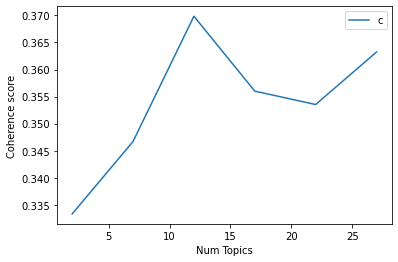

In [30]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_sg)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [31]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_sg):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 12

index: 0 | Num Topics = 2  has Coherence Value of 0.3333
index: 1 | Num Topics = 7  has Coherence Value of 0.3467
index: 2 | Num Topics = 12  has Coherence Value of 0.3698
index: 3 | Num Topics = 17  has Coherence Value of 0.356
index: 4 | Num Topics = 22  has Coherence Value of 0.3535
index: 5 | Num Topics = 27  has Coherence Value of 0.3632


In [165]:
# Select optimal number of topics
optimal_model_sg = model_list_sg[2]

In [166]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_sg = pyLDAvis.gensim_models.prepare(optimal_model_sg, corpus_sg, id2word_sg)

In [167]:
print("pyLDAVis for overall SG topics:")
vis_sg

pyLDAVis for overall SG topics:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10     0.124033 -0.169711       1        1  24.159821
11     0.126367  0.038893       2        1  13.499019
5      0.072983  0.137275       3        1   9.973782
2     -0.027173 -0.037204       4        1   9.039709
6      0.009465 -0.069136       5        1   7.889829
1     -0.083674 -0.074471       6        1   6.888942
7      0.040864  0.048037       7        1   6.629870
3     -0.094521  0.064323       8        1   5.347285
4     -0.087277 -0.027600       9        1   5.229565
8      0.090680  0.062410      10        1   4.992094
0     -0.130164  0.037171      11        1   3.185109
9     -0.041584 -0.009988      12        1   3.164974, topic_info=       Term        Freq       Total Category  logprob  loglift
89       ad  133.000000  133.000000  Default  30.0000  30.0000
147    view   80.000000   80.000000  Default  29.0000  29.0000
4      play   99.000000   99.000000  Default  28.0000  28.0000
235  delete   58.000000   58.000000  Default  27.0000  27.0000
11      app  167.000000  167.000000  Default  26.0000  26.0000
..      ...         ...         ...      ...      ...      ...
161     way    1.479919   27.190006  Topic12  -5.1001   0.5422
228     end    1.479918   12.527959  Topic12  -5.1001   1.3170
1      ipad    1.479915   12.667046  Topic12  -5.1001   1.3060
121   black    1.479914   27.414882  Topic12  -5.1001   0.5339
62     work    1.479905   52.240204  Topic12  -5.1001  -0.1108

[791 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
927      11  0.656665       abit
47        1  0.466394       able
47        2  0.058299       able
47        4  0.233197       able
47        6  0.058299       able
...     ...       ...        ...
215       2  0.264318       year
215       4  0.264318       year
215       5  0.396477       year
483       4  0.324466  yesterday
483      11  0.324466  yesterday

[1541 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 12, 6, 3, 7, 2, 8, 4, 5, 9, 1, 10])

# By-rating LDA Topic Modelling

## LDA Topic Modelling (Rating = 1)

In [35]:
# By-rating Topic Modelling - rating = 1
# Convert to list - move to each section
review_sg_score1 = youtube_ios_sg_review_YearMonth_score1.review.values.tolist()
review_words_sg_score1 = list(sent_to_words(review_sg_score1))
print(review_words_sg_score1[:1])

[['team', 'for', 'your', 'urgent', 'action', 'to', 'come', 'up', 'with', 'new', 'update', 'as', 'the', 'latest', 'one', 'installed', 'crashes', 'the', 'app', 'please', 'take', 'users', 'feedback', 'seriously', 'too']]


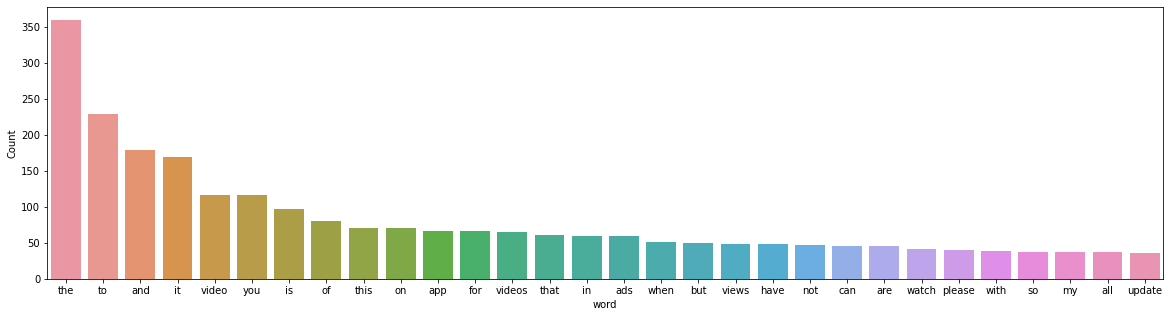

In [36]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_sg_score1))

In [37]:
# Clean text
review_sg_ready_score1 = process_words(review_words_sg_score1)  # processed Text Data! - move to each section


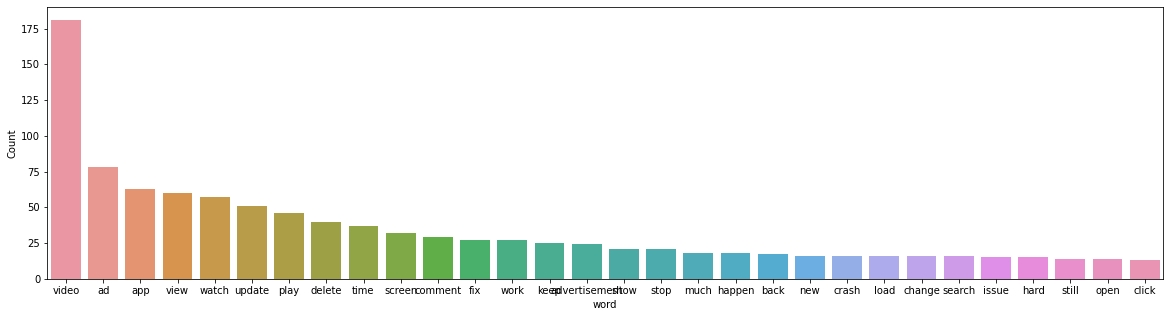

In [38]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_sg_ready_score1))


In [39]:
# Create Dictionary
id2word_sg_score1 = corpora.Dictionary(review_sg_ready_score1)

2021-10-16 23:33:46,436 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 23:33:46,456 [INFO] gensim.corpora.dictionary - built Dictionary(895 unique tokens: ['action', 'app', 'crash', 'feedback', 'instal']...) from 200 documents (total 2902 corpus positions)
2021-10-16 23:33:46,457 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(895 unique tokens: ['action', 'app', 'crash', 'feedback', 'instal']...) from 200 documents (total 2902 corpus positions)", 'datetime': '2021-10-16T23:33:46.457619', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [40]:
# Create Corpus: Term Document Frequency
corpus_sg_score1 = [id2word_sg_score1.doc2bow(text) for text in review_sg_ready_score1]

In [41]:
# Training LDA model
model_list_sg_score1, coherence_values_sg_score1 = compute_coherence_values(dictionary=id2word_sg_score1, corpus=corpus_sg_score1, 
                                                              texts=review_sg_ready_score1, limit=30, start=2, step=5)


2021-10-16 23:33:47,085 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 23:33:47,086 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 23:33:47,090 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 23:33:47,092 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 200 documents, updating model once every 200 documents, evaluating perplexity every 200 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 23:33:47,994 [INFO] gensim.models.ldamodel - -7.441 per-word bound, 173.8 perplexity estimate based on a held-out corpus of 200 documents with 2902 words
2021-10-16 23:33:47,995 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #200/200
2021-10-16 23:33:48,769 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.029*"video" + 0.021*"view" + 0.018*"update" + 0.016*"app" + 0.016*"ad" + 0.015*"watch" + 0.012*"commen

2021-10-16 23:33:56,515 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.065*"video" + 0.033*"ad" + 0.019*"play" + 0.019*"watch" + 0.015*"app" + 0.014*"time" + 0.013*"screen" + 0.012*"fix" + 0.012*"view" + 0.010*"update"
2021-10-16 23:33:56,517 [INFO] gensim.models.ldamodel - topic diff=0.011382, rho=0.301511
2021-10-16 23:33:56,902 [INFO] gensim.models.ldamodel - -6.324 per-word bound, 80.1 perplexity estimate based on a held-out corpus of 200 documents with 2902 words
2021-10-16 23:33:56,909 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #200/200
2021-10-16 23:33:57,224 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.023*"video" + 0.022*"view" + 0.020*"app" + 0.019*"update" + 0.015*"comment" + 0.013*"delete" + 0.012*"keep" + 0.010*"watch" + 0.010*"crash" + 0.008*"search"
2021-10-16 23:33:57,226 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.065*"video" + 0.033*"ad" + 0.020*"play" + 0.019*"watch" + 0.015*"app" + 0.014*"time" + 0.013*"screen" + 0.012*"fix" +

2021-10-16 23:34:03,285 [INFO] gensim.models.ldamodel - topic diff=0.004490, rho=0.218218
2021-10-16 23:34:03,697 [INFO] gensim.models.ldamodel - -6.317 per-word bound, 79.7 perplexity estimate based on a held-out corpus of 200 documents with 2902 words
2021-10-16 23:34:03,699 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #200/200
2021-10-16 23:34:03,937 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.022*"video" + 0.022*"view" + 0.020*"app" + 0.018*"update" + 0.016*"comment" + 0.013*"delete" + 0.012*"keep" + 0.011*"crash" + 0.010*"search" + 0.009*"watch"
2021-10-16 23:34:03,938 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.065*"video" + 0.034*"ad" + 0.020*"play" + 0.019*"watch" + 0.014*"app" + 0.014*"time" + 0.013*"screen" + 0.012*"view" + 0.012*"fix" + 0.011*"update"
2021-10-16 23:34:03,939 [INFO] gensim.models.ldamodel - topic diff=0.004232, rho=0.213201
2021-10-16 23:34:04,374 [INFO] gensim.models.ldamodel - -6.317 per-word bound, 79.7 perplexity estimate

2021-10-16 23:34:09,637 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #200/200
2021-10-16 23:34:09,907 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.021*"view" + 0.021*"video" + 0.021*"app" + 0.018*"update" + 0.017*"comment" + 0.013*"delete" + 0.012*"keep" + 0.011*"crash" + 0.010*"search" + 0.009*"watch"
2021-10-16 23:34:09,909 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.065*"video" + 0.034*"ad" + 0.020*"play" + 0.019*"watch" + 0.014*"app" + 0.014*"time" + 0.013*"screen" + 0.013*"view" + 0.012*"fix" + 0.011*"update"
2021-10-16 23:34:09,913 [INFO] gensim.models.ldamodel - topic diff=0.002888, rho=0.176777
2021-10-16 23:34:10,211 [INFO] gensim.models.ldamodel - -6.314 per-word bound, 79.6 perplexity estimate based on a held-out corpus of 200 documents with 2902 words
2021-10-16 23:34:10,213 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #200/200
2021-10-16 23:34:10,451 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.021*"video" + 0.021*"

2021-10-16 23:34:15,887 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.065*"video" + 0.034*"ad" + 0.020*"play" + 0.019*"watch" + 0.014*"app" + 0.014*"time" + 0.013*"view" + 0.013*"screen" + 0.012*"fix" + 0.011*"work"
2021-10-16 23:34:15,889 [INFO] gensim.models.ldamodel - topic diff=0.002367, rho=0.154303
2021-10-16 23:34:16,183 [INFO] gensim.models.ldamodel - -6.311 per-word bound, 79.4 perplexity estimate based on a held-out corpus of 200 documents with 2902 words
2021-10-16 23:34:16,210 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #200/200
2021-10-16 23:34:16,454 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.022*"app" + 0.021*"video" + 0.020*"view" + 0.019*"update" + 0.017*"comment" + 0.012*"delete" + 0.012*"keep" + 0.011*"crash" + 0.011*"search" + 0.009*"watch"
2021-10-16 23:34:16,460 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.065*"video" + 0.034*"ad" + 0.020*"play" + 0.019*"watch" + 0.014*"time" + 0.014*"app" + 0.013*"view" + 0.013*"screen" + 

2021-10-16 23:34:27,101 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 192 virtual documents
2021-10-16 23:34:27,521 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-16 23:34:27,522 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
2021-10-16 23:34:27,526 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 23:34:27,529 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 7 topics, 50 passes over the supplied corpus of 200 documents, updating model once every 200 documents, evaluating perplexity every 200 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 23:34:28,194 [INFO] gensim.models.ldamodel - -9.453 per-word bound, 701.0 perplexity estimate based on a held-out corpus of 200 documents with 2902 words
2021-10-16 23:34:28,201 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #200/200
2021-10-16 23:34

2021-10-16 23:34:31,295 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #200/200
2021-10-16 23:34:31,504 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.061*"video" + 0.028*"ad" + 0.023*"watch" + 0.011*"play" + 0.009*"app" + 0.009*"new" + 0.008*"load" + 0.008*"become" + 0.007*"update" + 0.007*"fix"
2021-10-16 23:34:31,505 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.048*"ad" + 0.045*"view" + 0.031*"video" + 0.031*"delete" + 0.021*"app" + 0.019*"stop" + 0.015*"comment" + 0.013*"watch" + 0.013*"time" + 0.012*"play"
2021-10-16 23:34:31,508 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.050*"video" + 0.042*"update" + 0.030*"app" + 0.022*"time" + 0.021*"play" + 0.018*"fix" + 0.017*"search" + 0.014*"late" + 0.013*"crash" + 0.013*"work"
2021-10-16 23:34:31,511 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.040*"ad" + 0.038*"video" + 0.020*"screen" + 0.016*"show" + 0.014*"view" + 0.012*"play" + 0.011*"watch" + 0.010*"freeze" + 0.008*"tap" + 0.008*"second"
202

2021-10-16 23:34:34,012 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.051*"ad" + 0.048*"view" + 0.032*"delete" + 0.030*"video" + 0.021*"app" + 0.020*"stop" + 0.015*"comment" + 0.013*"watch" + 0.013*"time" + 0.012*"play"
2021-10-16 23:34:34,015 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.060*"video" + 0.029*"ad" + 0.023*"watch" + 0.011*"play" + 0.009*"new" + 0.009*"app" + 0.008*"load" + 0.008*"become" + 0.007*"update" + 0.007*"fix"
2021-10-16 23:34:34,018 [INFO] gensim.models.ldamodel - topic diff=0.008852, rho=0.288675
2021-10-16 23:34:34,272 [INFO] gensim.models.ldamodel - -6.565 per-word bound, 94.7 perplexity estimate based on a held-out corpus of 200 documents with 2902 words
2021-10-16 23:34:34,273 [INFO] gensim.models.ldamodel - PROGRESS: pass 11, at document #200/200
2021-10-16 23:34:34,396 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.050*"video" + 0.044*"update" + 0.031*"app" + 0.022*"play" + 0.021*"time" + 0.019*"fix" + 0.017*"search" + 0.014*"late" + 0.01

2021-10-16 23:34:37,159 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.060*"video" + 0.029*"ad" + 0.022*"watch" + 0.011*"play" + 0.010*"new" + 0.009*"app" + 0.009*"load" + 0.009*"become" + 0.007*"update" + 0.007*"fix"
2021-10-16 23:34:37,161 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.050*"video" + 0.045*"update" + 0.032*"app" + 0.022*"play" + 0.021*"time" + 0.019*"fix" + 0.017*"search" + 0.014*"late" + 0.014*"crash" + 0.012*"work"
2021-10-16 23:34:37,163 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.064*"video" + 0.023*"watch" + 0.013*"update" + 0.012*"comment" + 0.010*"fix" + 0.010*"unable" + 0.010*"upload" + 0.010*"page" + 0.010*"keep" + 0.010*"recommend"
2021-10-16 23:34:37,166 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.051*"ad" + 0.050*"view" + 0.032*"delete" + 0.030*"video" + 0.020*"app" + 0.019*"stop" + 0.015*"comment" + 0.013*"time" + 0.013*"watch" + 0.012*"play"
2021-10-16 23:34:37,168 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.028*"view" +

2021-10-16 23:34:40,126 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.050*"video" + 0.045*"update" + 0.032*"app" + 0.022*"play" + 0.021*"time" + 0.020*"fix" + 0.017*"search" + 0.014*"late" + 0.014*"crash" + 0.012*"work"
2021-10-16 23:34:40,132 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.041*"ad" + 0.037*"video" + 0.020*"screen" + 0.016*"show" + 0.014*"view" + 0.012*"watch" + 0.010*"second" + 0.009*"freeze" + 0.008*"airplay" + 0.008*"play"
2021-10-16 23:34:40,145 [INFO] gensim.models.ldamodel - topic diff=0.002315, rho=0.208514
2021-10-16 23:34:40,521 [INFO] gensim.models.ldamodel - -6.558 per-word bound, 94.2 perplexity estimate based on a held-out corpus of 200 documents with 2902 words
2021-10-16 23:34:40,526 [INFO] gensim.models.ldamodel - PROGRESS: pass 22, at document #200/200
2021-10-16 23:34:40,769 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.077*"video" + 0.034*"app" + 0.034*"screen" + 0.023*"play" + 0.018*"advertisement" + 0.018*"black" + 0.016*"watch" + 0

2021-10-16 23:34:43,206 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #200/200
2021-10-16 23:34:43,441 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.050*"video" + 0.045*"update" + 0.032*"app" + 0.022*"play" + 0.021*"time" + 0.020*"fix" + 0.017*"search" + 0.014*"late" + 0.014*"crash" + 0.012*"work"
2021-10-16 23:34:43,443 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.052*"ad" + 0.050*"view" + 0.032*"delete" + 0.030*"video" + 0.020*"app" + 0.019*"stop" + 0.015*"comment" + 0.013*"time" + 0.013*"watch" + 0.012*"play"
2021-10-16 23:34:43,446 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.041*"ad" + 0.037*"video" + 0.020*"screen" + 0.016*"show" + 0.014*"view" + 0.012*"watch" + 0.010*"second" + 0.009*"freeze" + 0.008*"airplay" + 0.008*"keep"
2021-10-16 23:34:43,450 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.064*"video" + 0.023*"watch" + 0.013*"update" + 0.012*"comment" + 0.010*"unable" + 0.010*"upload" + 0.010*"recommend" + 0.010*"page" + 0.010*"keep

2021-10-16 23:34:46,272 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.077*"video" + 0.034*"app" + 0.034*"screen" + 0.023*"play" + 0.018*"advertisement" + 0.017*"black" + 0.016*"watch" + 0.012*"click" + 0.010*"show" + 0.010*"long"
2021-10-16 23:34:46,276 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.052*"ad" + 0.051*"view" + 0.032*"delete" + 0.029*"video" + 0.020*"app" + 0.019*"stop" + 0.015*"comment" + 0.013*"time" + 0.013*"watch" + 0.012*"play"
2021-10-16 23:34:46,279 [INFO] gensim.models.ldamodel - topic diff=0.001233, rho=0.171499
2021-10-16 23:34:46,530 [INFO] gensim.models.ldamodel - -6.556 per-word bound, 94.1 perplexity estimate based on a held-out corpus of 200 documents with 2902 words
2021-10-16 23:34:46,533 [INFO] gensim.models.ldamodel - PROGRESS: pass 33, at document #200/200
2021-10-16 23:34:46,734 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.051*"ad" + 0.051*"view" + 0.033*"delete" + 0.029*"video" + 0.020*"app" + 0.019*"stop" + 0.015*"comment" + 0.013*

2021-10-16 23:34:49,295 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #200/200
2021-10-16 23:34:49,505 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.059*"video" + 0.029*"ad" + 0.022*"watch" + 0.011*"play" + 0.010*"new" + 0.009*"app" + 0.009*"load" + 0.009*"become" + 0.007*"update" + 0.007*"time"
2021-10-16 23:34:49,507 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.025*"view" + 0.020*"delete" + 0.020*"video" + 0.017*"update" + 0.017*"watch" + 0.016*"work" + 0.012*"comment" + 0.009*"fine" + 0.009*"well" + 0.006*"spend"
2021-10-16 23:34:49,508 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.041*"ad" + 0.037*"video" + 0.020*"screen" + 0.016*"show" + 0.014*"view" + 0.012*"watch" + 0.010*"second" + 0.009*"freeze" + 0.008*"airplay" + 0.008*"keep"
2021-10-16 23:34:49,509 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.053*"view" + 0.051*"ad" + 0.034*"delete" + 0.029*"video" + 0.020*"app" + 0.019*"stop" + 0.015*"comment" + 0.013*"time" + 0.013*"watch" + 0.01

2021-10-16 23:34:51,927 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.023*"view" + 0.020*"video" + 0.019*"delete" + 0.018*"update" + 0.018*"watch" + 0.016*"work" + 0.012*"comment" + 0.009*"fine" + 0.009*"well" + 0.006*"spend"
2021-10-16 23:34:51,931 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.051*"video" + 0.045*"update" + 0.032*"app" + 0.022*"play" + 0.021*"time" + 0.021*"fix" + 0.017*"search" + 0.014*"late" + 0.014*"crash" + 0.011*"work"
2021-10-16 23:34:51,935 [INFO] gensim.models.ldamodel - topic diff=0.000907, rho=0.149071
2021-10-16 23:34:52,280 [INFO] gensim.models.ldamodel - -6.554 per-word bound, 93.9 perplexity estimate based on a held-out corpus of 200 documents with 2902 words
2021-10-16 23:34:52,281 [INFO] gensim.models.ldamodel - PROGRESS: pass 44, at document #200/200
2021-10-16 23:34:52,443 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.051*"video" + 0.045*"update" + 0.032*"app" + 0.022*"play" + 0.021*"time" + 0.021*"fix" + 0.017*"search" + 0.014*"lat

2021-10-16 23:34:55,023 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #200/200
2021-10-16 23:34:55,256 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.051*"video" + 0.045*"update" + 0.032*"app" + 0.022*"play" + 0.021*"time" + 0.021*"fix" + 0.017*"search" + 0.014*"late" + 0.014*"crash" + 0.011*"work"
2021-10-16 23:34:55,258 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.078*"video" + 0.035*"app" + 0.034*"screen" + 0.024*"play" + 0.018*"advertisement" + 0.017*"black" + 0.017*"watch" + 0.012*"click" + 0.010*"show" + 0.010*"long"
2021-10-16 23:34:55,260 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.054*"view" + 0.051*"ad" + 0.035*"delete" + 0.029*"video" + 0.020*"app" + 0.019*"stop" + 0.015*"comment" + 0.014*"hard" + 0.014*"work" + 0.013*"time"
2021-10-16 23:34:55,262 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.041*"ad" + 0.037*"video" + 0.020*"screen" + 0.016*"show" + 0.014*"view" + 0.012*"watch" + 0.010*"second" + 0.009*"freeze" + 0.008*"airplay" +

2021-10-16 23:35:05,511 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.060*"view" + 0.025*"delete" + 0.019*"fix" + 0.015*"people" + 0.014*"time" + 0.013*"video" + 0.012*"app" + 0.010*"comment" + 0.010*"spend" + 0.010*"back"
2021-10-16 23:35:05,514 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.097*"video" + 0.047*"ad" + 0.027*"watch" + 0.025*"play" + 0.022*"view" + 0.019*"screen" + 0.018*"app" + 0.018*"delete" + 0.015*"stop" + 0.010*"advertisement"
2021-10-16 23:35:05,515 [INFO] gensim.models.ldamodel - topic diff=0.071542, rho=0.447214
2021-10-16 23:35:05,911 [INFO] gensim.models.ldamodel - -6.750 per-word bound, 107.6 perplexity estimate based on a held-out corpus of 200 documents with 2902 words
2021-10-16 23:35:05,923 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #200/200
2021-10-16 23:35:06,260 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.012*"app" + 0.012*"search" + 0.012*"ad" + 0.012*"button" + 0.012*"second" + 0.012*"debate" + 0.012*"hv" + 0.012

2021-10-16 23:35:09,123 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #200/200
2021-10-16 23:35:09,338 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.053*"video" + 0.017*"update" + 0.017*"view" + 0.017*"ad" + 0.017*"much" + 0.013*"screen" + 0.013*"bring" + 0.013*"time" + 0.013*"new" + 0.013*"recommend"
2021-10-16 23:35:09,347 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.098*"video" + 0.048*"ad" + 0.028*"watch" + 0.025*"play" + 0.022*"view" + 0.019*"screen" + 0.018*"delete" + 0.017*"app" + 0.015*"stop" + 0.011*"advertisement"
2021-10-16 23:35:09,355 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.054*"video" + 0.046*"app" + 0.030*"watch" + 0.027*"crash" + 0.025*"update" + 0.018*"add" + 0.018*"fix" + 0.017*"time" + 0.016*"late" + 0.014*"back"
2021-10-16 23:35:09,384 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.035*"video" + 0.021*"ad" + 0.014*"hard" + 0.014*"view" + 0.014*"well" + 0.014*"screen" + 0.014*"mostly" + 0.014*"volume" + 0.014*"watch" + 0.

2021-10-16 23:35:11,842 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.032*"video" + 0.030*"update" + 0.024*"time" + 0.020*"search" + 0.019*"play" + 0.019*"app" + 0.017*"ad" + 0.015*"picture" + 0.013*"subscription" + 0.013*"option"
2021-10-16 23:35:11,844 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.012*"app" + 0.012*"search" + 0.012*"ad" + 0.012*"second" + 0.012*"button" + 0.012*"audio" + 0.012*"time" + 0.012*"add" + 0.012*"debate" + 0.012*"listen"
2021-10-16 23:35:11,847 [INFO] gensim.models.ldamodel - topic diff=0.003861, rho=0.250000
2021-10-16 23:35:12,140 [INFO] gensim.models.ldamodel - -6.717 per-word bound, 105.2 perplexity estimate based on a held-out corpus of 200 documents with 2902 words
2021-10-16 23:35:12,141 [INFO] gensim.models.ldamodel - PROGRESS: pass 15, at document #200/200
2021-10-16 23:35:12,303 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.035*"video" + 0.021*"ad" + 0.014*"hard" + 0.014*"view" + 0.014*"well" + 0.014*"screen" + 0.014*"mostly" + 0

2021-10-16 23:35:14,499 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #200/200
2021-10-16 23:35:14,691 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.098*"video" + 0.048*"ad" + 0.028*"watch" + 0.025*"play" + 0.022*"view" + 0.019*"screen" + 0.018*"delete" + 0.017*"app" + 0.015*"stop" + 0.011*"advertisement"
2021-10-16 23:35:14,694 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.035*"video" + 0.021*"ad" + 0.014*"hard" + 0.014*"view" + 0.014*"well" + 0.014*"screen" + 0.014*"mostly" + 0.014*"volume" + 0.014*"watch" + 0.014*"instead"
2021-10-16 23:35:14,697 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.012*"app" + 0.012*"search" + 0.012*"ad" + 0.012*"second" + 0.012*"button" + 0.012*"audio" + 0.012*"time" + 0.012*"add" + 0.012*"finger" + 0.012*"hv"
2021-10-16 23:35:14,701 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.068*"video" + 0.029*"app" + 0.026*"watch" + 0.022*"play" + 0.018*"load" + 0.018*"update" + 0.017*"ad" + 0.014*"recent" + 0.014*"unable" +

2021-10-16 23:35:17,266 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.043*"video" + 0.030*"play" + 0.026*"freeze" + 0.022*"work" + 0.017*"app" + 0.013*"screen" + 0.013*"update" + 0.013*"hard" + 0.013*"comment" + 0.013*"pay"
2021-10-16 23:35:17,267 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.025*"ad" + 0.025*"show" + 0.021*"screen" + 0.015*"advertisement" + 0.014*"load" + 0.013*"dislike" + 0.013*"give" + 0.013*"often" + 0.013*"minute" + 0.013*"account"
2021-10-16 23:35:17,268 [INFO] gensim.models.ldamodel - topic diff=0.000787, rho=0.192450
2021-10-16 23:35:17,534 [INFO] gensim.models.ldamodel - -6.716 per-word bound, 105.1 perplexity estimate based on a held-out corpus of 200 documents with 2902 words
2021-10-16 23:35:17,536 [INFO] gensim.models.ldamodel - PROGRESS: pass 26, at document #200/200
2021-10-16 23:35:17,766 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.035*"video" + 0.021*"ad" + 0.014*"hard" + 0.014*"view" + 0.014*"well" + 0.014*"screen" + 0.014*"mostly

2021-10-16 23:35:19,972 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #200/200
2021-10-16 23:35:20,185 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.043*"video" + 0.030*"play" + 0.026*"freeze" + 0.022*"work" + 0.017*"app" + 0.013*"screen" + 0.013*"update" + 0.013*"hard" + 0.013*"comment" + 0.013*"pay"
2021-10-16 23:35:20,188 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.040*"ad" + 0.031*"view" + 0.031*"comment" + 0.028*"delete" + 0.022*"app" + 0.016*"advertisement" + 0.013*"give" + 0.013*"skip" + 0.011*"change" + 0.010*"video"
2021-10-16 23:35:20,190 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.069*"video" + 0.029*"app" + 0.026*"watch" + 0.022*"play" + 0.019*"load" + 0.018*"update" + 0.017*"ad" + 0.014*"recent" + 0.014*"unable" + 0.014*"keep"
2021-10-16 23:35:20,192 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.031*"video" + 0.030*"update" + 0.023*"time" + 0.020*"search" + 0.019*"app" + 0.019*"play" + 0.018*"ad" + 0.015*"picture" + 0.013*"sub

2021-10-16 23:35:22,576 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.040*"ad" + 0.031*"view" + 0.031*"comment" + 0.028*"delete" + 0.022*"app" + 0.016*"advertisement" + 0.012*"give" + 0.012*"skip" + 0.012*"change" + 0.010*"video"
2021-10-16 23:35:22,582 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.057*"video" + 0.045*"app" + 0.029*"watch" + 0.028*"crash" + 0.026*"update" + 0.023*"fix" + 0.021*"time" + 0.017*"add" + 0.016*"open" + 0.015*"late"
2021-10-16 23:35:22,585 [INFO] gensim.models.ldamodel - topic diff=0.000367, rho=0.162221
2021-10-16 23:35:22,873 [INFO] gensim.models.ldamodel - -6.714 per-word bound, 105.0 perplexity estimate based on a held-out corpus of 200 documents with 2902 words
2021-10-16 23:35:22,878 [INFO] gensim.models.ldamodel - PROGRESS: pass 37, at document #200/200
2021-10-16 23:35:23,041 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.062*"view" + 0.029*"delete" + 0.019*"people" + 0.015*"fix" + 0.013*"time" + 0.013*"video" + 0.010*"comment" + 0.0

2021-10-16 23:35:25,324 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #200/200
2021-10-16 23:35:25,538 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.057*"video" + 0.045*"app" + 0.029*"watch" + 0.028*"crash" + 0.026*"update" + 0.023*"fix" + 0.021*"time" + 0.017*"add" + 0.016*"open" + 0.015*"late"
2021-10-16 23:35:25,541 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.037*"video" + 0.021*"watch" + 0.019*"update" + 0.017*"work" + 0.013*"well" + 0.013*"comment" + 0.013*"fine" + 0.013*"delete" + 0.009*"advertisement" + 0.009*"tab"
2021-10-16 23:35:25,544 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.098*"video" + 0.048*"ad" + 0.028*"watch" + 0.025*"play" + 0.022*"view" + 0.019*"screen" + 0.018*"delete" + 0.017*"app" + 0.015*"stop" + 0.011*"advertisement"
2021-10-16 23:35:25,547 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.025*"ad" + 0.025*"show" + 0.021*"screen" + 0.015*"advertisement" + 0.014*"load" + 0.013*"give" + 0.013*"minute" + 0.013*"dislike" +

2021-10-16 23:35:27,796 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.069*"video" + 0.029*"app" + 0.026*"watch" + 0.022*"play" + 0.019*"load" + 0.018*"update" + 0.017*"ad" + 0.014*"recent" + 0.014*"unable" + 0.014*"keep"
2021-10-16 23:35:27,798 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.037*"video" + 0.021*"watch" + 0.019*"update" + 0.017*"work" + 0.013*"comment" + 0.013*"well" + 0.013*"fine" + 0.013*"delete" + 0.009*"advertisement" + 0.009*"tab"
2021-10-16 23:35:27,800 [INFO] gensim.models.ldamodel - topic diff=0.000338, rho=0.142857
2021-10-16 23:35:28,116 [INFO] gensim.models.ldamodel - -6.713 per-word bound, 104.9 perplexity estimate based on a held-out corpus of 200 documents with 2902 words
2021-10-16 23:35:28,119 [INFO] gensim.models.ldamodel - PROGRESS: pass 48, at document #200/200
2021-10-16 23:35:28,262 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.054*"video" + 0.017*"update" + 0.017*"much" + 0.017*"view" + 0.017*"ad" + 0.013*"back" + 0.013*"new" + 0.0

2021-10-16 23:35:38,692 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.023*"play" + 0.023*"video" + 0.015*"ad" + 0.012*"app" + 0.012*"function" + 0.012*"guess" + 0.012*"copy" + 0.012*"previously" + 0.012*"screen" + 0.012*"repeat"
2021-10-16 23:35:38,699 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.057*"video" + 0.025*"add" + 0.019*"update" + 0.017*"time" + 0.016*"watch" + 0.015*"load" + 0.015*"new" + 0.014*"app" + 0.013*"work" + 0.012*"late"
2021-10-16 23:35:38,702 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.047*"delete" + 0.044*"ad" + 0.043*"view" + 0.034*"app" + 0.020*"work" + 0.017*"advertisement" + 0.017*"give" + 0.015*"hard" + 0.014*"stop" + 0.011*"play"
2021-10-16 23:35:38,705 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.027*"view" + 0.025*"video" + 0.023*"update" + 0.019*"hard" + 0.018*"thing" + 0.017*"keep" + 0.014*"annoying" + 0.014*"play" + 0.014*"delete" + 0.014*"new"
2021-10-16 23:35:38,707 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.054

2021-10-16 23:35:41,156 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.030*"crash" + 0.026*"video" + 0.024*"picture" + 0.023*"update" + 0.021*"screen" + 0.018*"keep" + 0.018*"app" + 0.018*"change" + 0.018*"ad" + 0.017*"new"
2021-10-16 23:35:41,158 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.102*"video" + 0.056*"ad" + 0.025*"app" + 0.025*"watch" + 0.023*"screen" + 0.021*"play" + 0.015*"advertisement" + 0.014*"stop" + 0.013*"much" + 0.013*"time"
2021-10-16 23:35:41,159 [INFO] gensim.models.ldamodel - topic diff=0.033589, rho=0.333333
2021-10-16 23:35:41,409 [INFO] gensim.models.ldamodel - -6.833 per-word bound, 114.0 perplexity estimate based on a held-out corpus of 200 documents with 2902 words
2021-10-16 23:35:41,411 [INFO] gensim.models.ldamodel - PROGRESS: pass 8, at document #200/200
2021-10-16 23:35:41,640 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.039*"video" + 0.028*"update" + 0.020*"show" + 0.015*"issue" + 0.015*"dislike" + 0.015*"search" + 0.015*"new" + 

2021-10-16 23:35:43,798 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #200/200
2021-10-16 23:35:43,996 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.023*"play" + 0.023*"video" + 0.012*"ad" + 0.012*"app" + 0.012*"function" + 0.012*"copy" + 0.012*"lock" + 0.012*"repeat" + 0.012*"screen" + 0.012*"guess"
2021-10-16 23:35:44,000 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.079*"video" + 0.035*"watch" + 0.030*"app" + 0.024*"update" + 0.023*"play" + 0.020*"ad" + 0.020*"click" + 0.019*"recent" + 0.013*"search" + 0.012*"people"
2021-10-16 23:35:44,004 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.057*"video" + 0.026*"add" + 0.022*"update" + 0.015*"time" + 0.015*"watch" + 0.015*"new" + 0.015*"app" + 0.015*"late" + 0.013*"back" + 0.011*"play"
2021-10-16 23:35:44,008 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.040*"video" + 0.029*"comment" + 0.018*"watch" + 0.018*"upload" + 0.018*"old" + 0.012*"bar" + 0.012*"fix" + 0.012*"end" + 0.012*"way" + 0.012*"who

2021-10-16 23:35:46,431 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.040*"video" + 0.029*"comment" + 0.018*"watch" + 0.018*"upload" + 0.018*"old" + 0.012*"fix" + 0.012*"bar" + 0.012*"end" + 0.012*"way" + 0.012*"whole"
2021-10-16 23:35:46,434 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.057*"video" + 0.026*"add" + 0.022*"update" + 0.015*"time" + 0.015*"watch" + 0.015*"new" + 0.015*"app" + 0.015*"late" + 0.013*"back" + 0.012*"play"
2021-10-16 23:35:46,436 [INFO] gensim.models.ldamodel - topic diff=0.004340, rho=0.223607
2021-10-16 23:35:46,698 [INFO] gensim.models.ldamodel - -6.807 per-word bound, 112.0 perplexity estimate based on a held-out corpus of 200 documents with 2902 words
2021-10-16 23:35:46,699 [INFO] gensim.models.ldamodel - PROGRESS: pass 19, at document #200/200
2021-10-16 23:35:46,927 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.027*"video" + 0.020*"comment" + 0.020*"unable" + 0.020*"back" + 0.014*"watch" + 0.014*"permanently" + 0.014*"top" + 0.014*"b

2021-10-16 23:35:49,180 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #200/200
2021-10-16 23:35:49,391 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.089*"view" + 0.070*"delete" + 0.037*"work" + 0.037*"ad" + 0.031*"hard" + 0.030*"app" + 0.015*"give" + 0.015*"stop" + 0.014*"advertisement" + 0.012*"really"
2021-10-16 23:35:49,393 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.057*"video" + 0.026*"add" + 0.022*"update" + 0.015*"time" + 0.015*"watch" + 0.015*"new" + 0.015*"app" + 0.015*"late" + 0.013*"back" + 0.012*"play"
2021-10-16 23:35:49,397 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.023*"play" + 0.023*"video" + 0.012*"ad" + 0.012*"app" + 0.012*"function" + 0.012*"copy" + 0.012*"lock" + 0.012*"repeat" + 0.012*"screen" + 0.012*"guess"
2021-10-16 23:35:49,403 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.028*"time" + 0.024*"video" + 0.016*"update" + 0.016*"play" + 0.016*"ad" + 0.016*"watch" + 0.016*"premium" + 0.016*"annoying" + 0.012*"app" + 0.0

2021-10-16 23:35:51,935 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.090*"view" + 0.070*"delete" + 0.038*"work" + 0.037*"ad" + 0.031*"hard" + 0.030*"app" + 0.015*"give" + 0.015*"stop" + 0.014*"advertisement" + 0.012*"really"
2021-10-16 23:35:51,938 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.058*"video" + 0.030*"screen" + 0.020*"big" + 0.020*"thumbnail" + 0.020*"mostly" + 0.020*"well" + 0.014*"ad" + 0.010*"support" + 0.010*"percent" + 0.010*"song"
2021-10-16 23:35:51,940 [INFO] gensim.models.ldamodel - topic diff=0.001350, rho=0.179605
2021-10-16 23:35:52,200 [INFO] gensim.models.ldamodel - -6.801 per-word bound, 111.5 perplexity estimate based on a held-out corpus of 200 documents with 2902 words
2021-10-16 23:35:52,201 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #200/200
2021-10-16 23:35:52,480 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.090*"view" + 0.070*"delete" + 0.038*"work" + 0.037*"ad" + 0.031*"hard" + 0.030*"app" + 0.015*"give" + 0.01

2021-10-16 23:35:54,646 [INFO] gensim.models.ldamodel - PROGRESS: pass 35, at document #200/200
2021-10-16 23:35:54,900 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.043*"ad" + 0.022*"video" + 0.016*"account" + 0.011*"view" + 0.011*"show" + 0.011*"playlist" + 0.011*"issue" + 0.011*"iphone" + 0.011*"content" + 0.011*"reason"
2021-10-16 23:35:54,910 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.059*"video" + 0.030*"screen" + 0.020*"big" + 0.020*"thumbnail" + 0.020*"well" + 0.020*"mostly" + 0.014*"ad" + 0.010*"percent" + 0.010*"lauv" + 0.010*"song"
2021-10-16 23:35:54,913 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.057*"video" + 0.026*"add" + 0.022*"update" + 0.015*"time" + 0.015*"watch" + 0.015*"new" + 0.015*"app" + 0.015*"late" + 0.013*"back" + 0.012*"play"
2021-10-16 23:35:54,916 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.034*"video" + 0.032*"update" + 0.020*"show" + 0.016*"search" + 0.016*"dislike" + 0.016*"new" + 0.016*"well" + 0.016*"comment" + 0.016*"i

2021-10-16 23:35:57,313 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.085*"view" + 0.036*"comment" + 0.032*"video" + 0.032*"delete" + 0.032*"update" + 0.023*"app" + 0.018*"time" + 0.014*"open" + 0.014*"crash" + 0.014*"spend"
2021-10-16 23:35:57,315 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.031*"crash" + 0.025*"video" + 0.025*"picture" + 0.019*"update" + 0.019*"keep" + 0.019*"app" + 0.019*"change" + 0.019*"new" + 0.014*"option" + 0.013*"ad"
2021-10-16 23:35:57,317 [INFO] gensim.models.ldamodel - topic diff=0.000768, rho=0.154303
2021-10-16 23:35:57,650 [INFO] gensim.models.ldamodel - -6.800 per-word bound, 111.4 perplexity estimate based on a held-out corpus of 200 documents with 2902 words
2021-10-16 23:35:57,652 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #200/200
2021-10-16 23:35:57,808 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.061*"video" + 0.034*"app" + 0.032*"happen" + 0.032*"watch" + 0.023*"play" + 0.019*"issue" + 0.017*"keep" + 0.01

2021-10-16 23:36:00,098 [INFO] gensim.models.ldamodel - PROGRESS: pass 46, at document #200/200
2021-10-16 23:36:00,274 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.033*"video" + 0.032*"update" + 0.020*"show" + 0.016*"search" + 0.016*"new" + 0.016*"well" + 0.016*"dislike" + 0.016*"comment" + 0.016*"issue" + 0.016*"quality"
2021-10-16 23:36:00,295 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.027*"video" + 0.020*"comment" + 0.020*"unable" + 0.020*"back" + 0.014*"watch" + 0.014*"permanently" + 0.014*"bottom" + 0.014*"top" + 0.014*"still" + 0.014*"annoy"
2021-10-16 23:36:00,297 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.028*"time" + 0.025*"video" + 0.016*"update" + 0.016*"play" + 0.016*"ad" + 0.016*"watch" + 0.016*"premium" + 0.016*"annoying" + 0.012*"app" + 0.012*"fix"
2021-10-16 23:36:00,299 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.085*"view" + 0.036*"comment" + 0.032*"video" + 0.032*"delete" + 0.032*"update" + 0.023*"app" + 0.018*"time" + 0.014*"open"

2021-10-16 23:36:11,906 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.052*"ad" + 0.023*"account" + 0.023*"comment" + 0.015*"disappear" + 0.015*"screen" + 0.015*"chat" + 0.015*"show" + 0.015*"people" + 0.015*"play" + 0.015*"suspect"
2021-10-16 23:36:11,908 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.023*"end" + 0.019*"picture" + 0.019*"view" + 0.019*"problem" + 0.019*"load" + 0.019*"video" + 0.019*"update" + 0.019*"issue" + 0.013*"time" + 0.012*"user"
2021-10-16 23:36:11,910 [INFO] gensim.models.ldamodel - topic diff=17.863605, rho=1.000000
2021-10-16 23:36:12,178 [INFO] gensim.models.ldamodel - -7.114 per-word bound, 138.5 perplexity estimate based on a held-out corpus of 200 documents with 2902 words
2021-10-16 23:36:12,179 [INFO] gensim.models.ldamodel - PROGRESS: pass 1, at document #200/200
2021-10-16 23:36:12,398 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.027*"fine" + 0.027*"option" + 0.027*"watch" + 0.027*"advertisement" + 0.027*"search" + 0.027*"video" + 0

2021-10-16 23:36:14,452 [INFO] gensim.models.ldamodel - PROGRESS: pass 6, at document #200/200
2021-10-16 23:36:14,650 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.046*"video" + 0.041*"issue" + 0.040*"happen" + 0.040*"time" + 0.035*"fix" + 0.033*"open" + 0.026*"update" + 0.023*"keep" + 0.021*"play" + 0.021*"close"
2021-10-16 23:36:14,657 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.054*"video" + 0.046*"add" + 0.031*"time" + 0.023*"play" + 0.023*"app" + 0.023*"search" + 0.016*"unable" + 0.016*"waste" + 0.016*"still" + 0.016*"screen"
2021-10-16 23:36:14,664 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.052*"ad" + 0.023*"account" + 0.023*"comment" + 0.015*"disappear" + 0.015*"chat" + 0.015*"screen" + 0.015*"show" + 0.015*"suspect" + 0.015*"people" + 0.015*"different"
2021-10-16 23:36:14,668 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.080*"video" + 0.065*"ad" + 0.037*"app" + 0.030*"play" + 0.030*"watch" + 0.012*"stop" + 0.011*"much" + 0.010*"time" + 0.010*"scre

2021-10-16 23:36:16,919 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.082*"video" + 0.036*"watch" + 0.030*"app" + 0.023*"click" + 0.022*"update" + 0.021*"ad" + 0.019*"home" + 0.018*"fix" + 0.017*"search" + 0.016*"keep"
2021-10-16 23:36:16,921 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.055*"video" + 0.040*"view" + 0.036*"delete" + 0.018*"work" + 0.016*"comment" + 0.013*"thumbnail" + 0.013*"hard" + 0.011*"section" + 0.011*"update" + 0.009*"big"
2021-10-16 23:36:16,923 [INFO] gensim.models.ldamodel - topic diff=0.011064, rho=0.277350
2021-10-16 23:36:17,266 [INFO] gensim.models.ldamodel - -6.873 per-word bound, 117.2 perplexity estimate based on a held-out corpus of 200 documents with 2902 words
2021-10-16 23:36:17,268 [INFO] gensim.models.ldamodel - PROGRESS: pass 12, at document #200/200
2021-10-16 23:36:17,426 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.052*"ad" + 0.023*"account" + 0.023*"comment" + 0.015*"disappear" + 0.015*"chat" + 0.015*"suspect" + 0.015*"sh

2021-10-16 23:36:19,847 [INFO] gensim.models.ldamodel - -6.862 per-word bound, 116.4 perplexity estimate based on a held-out corpus of 200 documents with 2902 words
2021-10-16 23:36:19,848 [INFO] gensim.models.ldamodel - PROGRESS: pass 17, at document #200/200
2021-10-16 23:36:20,040 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.027*"watch" + 0.027*"video" + 0.027*"advertisement" + 0.027*"fine" + 0.027*"option" + 0.027*"search" + 0.014*"toooo" + 0.014*"place" + 0.014*"favourite" + 0.014*"let"
2021-10-16 23:36:20,042 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.035*"dislike" + 0.035*"watch" + 0.032*"ad" + 0.026*"show" + 0.024*"later" + 0.024*"change" + 0.024*"everytime" + 0.024*"list" + 0.024*"remove" + 0.012*"video"
2021-10-16 23:36:20,045 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.054*"app" + 0.045*"video" + 0.018*"long" + 0.018*"tap" + 0.018*"community" + 0.018*"open" + 0.018*"annoying" + 0.018*"select" + 0.009*"page" + 0.009*"click"
2021-10-16 23:36:20,047 [I

2021-10-16 23:36:22,733 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.049*"video" + 0.047*"fix" + 0.041*"time" + 0.041*"happen" + 0.039*"open" + 0.034*"issue" + 0.028*"update" + 0.023*"play" + 0.020*"keep" + 0.020*"close"
2021-10-16 23:36:22,738 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.054*"app" + 0.045*"video" + 0.018*"long" + 0.018*"community" + 0.018*"tap" + 0.018*"open" + 0.018*"annoying" + 0.018*"select" + 0.009*"page" + 0.009*"click"
2021-10-16 23:36:22,742 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.054*"video" + 0.046*"add" + 0.031*"time" + 0.023*"play" + 0.023*"app" + 0.023*"search" + 0.016*"waste" + 0.016*"unable" + 0.016*"still" + 0.016*"screen"
2021-10-16 23:36:22,743 [INFO] gensim.models.ldamodel - topic diff=0.002817, rho=0.204124
2021-10-16 23:36:23,009 [INFO] gensim.models.ldamodel - -6.856 per-word bound, 115.8 perplexity estimate based on a held-out corpus of 200 documents with 2902 words
2021-10-16 23:36:23,011 [INFO] gensim.models.ldamodel

2021-10-16 23:36:25,455 [INFO] gensim.models.ldamodel - topic diff=0.001872, rho=0.185695
2021-10-16 23:36:25,721 [INFO] gensim.models.ldamodel - -6.853 per-word bound, 115.6 perplexity estimate based on a held-out corpus of 200 documents with 2902 words
2021-10-16 23:36:25,722 [INFO] gensim.models.ldamodel - PROGRESS: pass 28, at document #200/200
2021-10-16 23:36:26,087 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.054*"app" + 0.045*"video" + 0.018*"long" + 0.018*"community" + 0.018*"tap" + 0.018*"open" + 0.018*"annoying" + 0.018*"select" + 0.009*"page" + 0.009*"click"
2021-10-16 23:36:26,094 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.054*"video" + 0.046*"add" + 0.031*"time" + 0.023*"play" + 0.023*"app" + 0.023*"search" + 0.016*"unable" + 0.016*"waste" + 0.016*"still" + 0.016*"screen"
2021-10-16 23:36:26,097 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.097*"view" + 0.054*"delete" + 0.039*"hard" + 0.032*"work" + 0.030*"really" + 0.023*"give" + 0.018*"thing" + 

2021-10-16 23:36:28,938 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.047*"load" + 0.029*"advertisement" + 0.027*"update" + 0.022*"end" + 0.022*"view" + 0.022*"problem" + 0.022*"picture" + 0.022*"issue" + 0.014*"app" + 0.013*"video"
2021-10-16 23:36:28,943 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.035*"video" + 0.035*"update" + 0.023*"still" + 0.023*"new" + 0.023*"soon" + 0.023*"notification" + 0.023*"annoying" + 0.023*"resolution" + 0.012*"app" + 0.012*"photo"
2021-10-16 23:36:28,945 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.042*"comment" + 0.026*"search" + 0.017*"app" + 0.017*"purpose" + 0.017*"whole" + 0.017*"ad" + 0.017*"monie" + 0.017*"audience" + 0.017*"section" + 0.017*"reply"
2021-10-16 23:36:28,947 [INFO] gensim.models.ldamodel - topic diff=0.001024, rho=0.169031
2021-10-16 23:36:29,281 [INFO] gensim.models.ldamodel - -6.851 per-word bound, 115.4 perplexity estimate based on a held-out corpus of 200 documents with 2902 words
2021-10-16 23:36:29,283 

2021-10-16 23:36:31,683 [INFO] gensim.models.ldamodel - topic diff=0.000702, rho=0.158114
2021-10-16 23:36:32,037 [INFO] gensim.models.ldamodel - -6.851 per-word bound, 115.4 perplexity estimate based on a held-out corpus of 200 documents with 2902 words
2021-10-16 23:36:32,039 [INFO] gensim.models.ldamodel - PROGRESS: pass 39, at document #200/200
2021-10-16 23:36:32,271 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.032*"video" + 0.022*"travel" + 0.011*"ad" + 0.011*"ready" + 0.011*"app" + 0.011*"button" + 0.011*"listen" + 0.011*"irrirate" + 0.011*"hv" + 0.011*"finger"
2021-10-16 23:36:32,273 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.083*"video" + 0.067*"ad" + 0.037*"app" + 0.030*"watch" + 0.029*"play" + 0.012*"time" + 0.012*"advertisement" + 0.012*"stop" + 0.011*"much" + 0.010*"end"
2021-10-16 23:36:32,275 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.070*"ad" + 0.046*"app" + 0.033*"advertisement" + 0.017*"delete" + 0.017*"skip" + 0.016*"appear" + 0.015*"loading

2021-10-16 23:36:35,431 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.036*"dislike" + 0.036*"watch" + 0.030*"ad" + 0.025*"show" + 0.024*"later" + 0.024*"change" + 0.024*"remove" + 0.024*"list" + 0.024*"everytime" + 0.012*"video"
2021-10-16 23:36:35,433 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.050*"video" + 0.042*"view" + 0.037*"delete" + 0.018*"work" + 0.016*"comment" + 0.014*"thumbnail" + 0.013*"hard" + 0.012*"section" + 0.010*"update" + 0.009*"big"
2021-10-16 23:36:35,435 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.047*"load" + 0.029*"advertisement" + 0.027*"update" + 0.022*"problem" + 0.022*"view" + 0.022*"picture" + 0.022*"end" + 0.022*"issue" + 0.014*"app" + 0.013*"video"
2021-10-16 23:36:35,439 [INFO] gensim.models.ldamodel - topic diff=0.000406, rho=0.147442
2021-10-16 23:36:35,838 [INFO] gensim.models.ldamodel - -6.850 per-word bound, 115.4 perplexity estimate based on a held-out corpus of 200 documents with 2902 words
2021-10-16 23:36:35,840 [INFO] g

2021-10-16 23:36:39,208 [INFO] gensim.models.ldamodel - topic diff=0.000259, rho=0.140028
2021-10-16 23:36:39,219 [INFO] gensim.utils - LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=895, num_topics=22, decay=0.5, chunksize=1000) in 28.44s', 'datetime': '2021-10-16T23:36:39.219603', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2021-10-16 23:36:39,251 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 23:36:46,759 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 23:36:46,856 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 196 virtual documents
2021-10-16 23:36:51,902 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.037037037037037035
2021-10-1

2021-10-16 23:36:55,200 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.064*"video" + 0.025*"hard" + 0.024*"work" + 0.019*"bad" + 0.019*"volume" + 0.019*"watch" + 0.019*"still" + 0.019*"end" + 0.018*"screen" + 0.018*"happen"
2021-10-16 23:36:55,202 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.047*"view" + 0.047*"delete" + 0.018*"back" + 0.018*"stop" + 0.012*"notification" + 0.012*"tv" + 0.012*"comment" + 0.012*"top" + 0.012*"queue" + 0.012*"implement"
2021-10-16 23:36:55,204 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.061*"update" + 0.040*"video" + 0.038*"ad" + 0.037*"late" + 0.025*"crash" + 0.019*"app" + 0.018*"fix" + 0.018*"bug" + 0.013*"thumbnail" + 0.013*"datum"
2021-10-16 23:36:55,206 [INFO] gensim.models.ldamodel - topic diff=0.056426, rho=0.408248
2021-10-16 23:36:55,483 [INFO] gensim.models.ldamodel - -7.028 per-word bound, 130.5 perplexity estimate based on a held-out corpus of 200 documents with 2902 words
2021-10-16 23:36:55,494 [INFO] gensim.models.ldamo

2021-10-16 23:36:57,579 [INFO] gensim.models.ldamodel - topic diff=0.018845, rho=0.301511
2021-10-16 23:36:57,867 [INFO] gensim.models.ldamodel - -6.984 per-word bound, 126.6 perplexity estimate based on a held-out corpus of 200 documents with 2902 words
2021-10-16 23:36:57,871 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #200/200
2021-10-16 23:36:58,044 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.085*"video" + 0.053*"ad" + 0.033*"load" + 0.027*"app" + 0.024*"play" + 0.022*"whenever" + 0.021*"advertisement" + 0.018*"screen" + 0.018*"time" + 0.015*"freeze"
2021-10-16 23:36:58,050 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.072*"video" + 0.024*"upload" + 0.024*"update" + 0.024*"iso" + 0.024*"able" + 0.024*"ad" + 0.012*"happen" + 0.012*"ridiculous" + 0.012*"sometimes" + 0.012*"show"
2021-10-16 23:36:58,061 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.038*"still" + 0.038*"app" + 0.020*"new" + 0.020*"update" + 0.020*"option" + 0.020*"soon" + 0.020

2021-10-16 23:37:00,715 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.060*"update" + 0.040*"video" + 0.038*"ad" + 0.038*"late" + 0.022*"crash" + 0.019*"bug" + 0.019*"comment" + 0.019*"keep" + 0.017*"fix" + 0.014*"app"
2021-10-16 23:37:00,721 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.077*"view" + 0.058*"delete" + 0.039*"hard" + 0.039*"work" + 0.020*"bias" + 0.020*"cause" + 0.020*"kpop" + 0.020*"really" + 0.020*"hope" + 0.020*"next"
2021-10-16 23:37:00,725 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.032*"ad" + 0.032*"video" + 0.024*"search" + 0.024*"play" + 0.024*"update" + 0.024*"previous" + 0.024*"watch" + 0.016*"premium" + 0.016*"pay" + 0.016*"app"
2021-10-16 23:37:00,726 [INFO] gensim.models.ldamodel - topic diff=0.006972, rho=0.242536
2021-10-16 23:37:01,040 [INFO] gensim.models.ldamodel - -6.964 per-word bound, 124.8 perplexity estimate based on a held-out corpus of 200 documents with 2902 words
2021-10-16 23:37:01,041 [INFO] gensim.models.ldamodel - PROGRE

2021-10-16 23:37:03,670 [INFO] gensim.models.ldamodel - topic diff=0.003570, rho=0.213201
2021-10-16 23:37:04,025 [INFO] gensim.models.ldamodel - -6.958 per-word bound, 124.3 perplexity estimate based on a held-out corpus of 200 documents with 2902 words
2021-10-16 23:37:04,027 [INFO] gensim.models.ldamodel - PROGRESS: pass 21, at document #200/200
2021-10-16 23:37:04,187 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.092*"video" + 0.068*"ad" + 0.036*"play" + 0.035*"watch" + 0.024*"app" + 0.017*"screen" + 0.016*"fix" + 0.015*"much" + 0.014*"black" + 0.013*"stop"
2021-10-16 23:37:04,189 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.023*"attract" + 0.023*"solve" + 0.023*"zoom" + 0.023*"ui" + 0.023*"mini" + 0.023*"attention" + 0.023*"iphone" + 0.023*"star" + 0.023*"give" + 0.023*"view"
2021-10-16 23:37:04,191 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.063*"app" + 0.034*"video" + 0.030*"time" + 0.026*"long" + 0.020*"open" + 0.020*"crash" + 0.018*"view" + 0.017*"happen

2021-10-16 23:37:07,139 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.077*"view" + 0.058*"delete" + 0.039*"hard" + 0.039*"work" + 0.020*"group" + 0.020*"return" + 0.020*"really" + 0.020*"hope" + 0.020*"next" + 0.020*"bias"
2021-10-16 23:37:07,215 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.035*"delete" + 0.035*"ad" + 0.026*"view" + 0.018*"video" + 0.018*"people" + 0.018*"app" + 0.018*"watch" + 0.018*"time" + 0.018*"advertisement" + 0.018*"comment"
2021-10-16 23:37:07,219 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.038*"still" + 0.038*"app" + 0.020*"new" + 0.020*"update" + 0.020*"resolve" + 0.020*"photo" + 0.020*"thx" + 0.020*"available" + 0.020*"option" + 0.020*"able"
2021-10-16 23:37:07,224 [INFO] gensim.models.ldamodel - topic diff=0.002347, rho=0.188982
2021-10-16 23:37:07,630 [INFO] gensim.models.ldamodel - -6.956 per-word bound, 124.1 perplexity estimate based on a held-out corpus of 200 documents with 2902 words
2021-10-16 23:37:07,632 [INFO] gensim.models.

2021-10-16 23:37:10,142 [INFO] gensim.models.ldamodel - topic diff=0.001108, rho=0.174078
2021-10-16 23:37:10,549 [INFO] gensim.models.ldamodel - -6.954 per-word bound, 124.0 perplexity estimate based on a held-out corpus of 200 documents with 2902 words
2021-10-16 23:37:10,551 [INFO] gensim.models.ldamodel - PROGRESS: pass 32, at document #200/200
2021-10-16 23:37:10,794 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.032*"ad" + 0.032*"video" + 0.024*"search" + 0.024*"play" + 0.024*"update" + 0.024*"previous" + 0.024*"watch" + 0.016*"premium" + 0.016*"pay" + 0.016*"app"
2021-10-16 23:37:10,798 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.064*"app" + 0.035*"video" + 0.030*"time" + 0.026*"long" + 0.021*"crash" + 0.021*"open" + 0.018*"view" + 0.018*"happen" + 0.017*"update" + 0.013*"still"
2021-10-16 23:37:10,803 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.065*"video" + 0.024*"hard" + 0.021*"work" + 0.019*"watch" + 0.019*"still" + 0.019*"volume" + 0.019*"end" + 0.019*

2021-10-16 23:37:13,321 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.038*"watch" + 0.019*"end" + 0.019*"meditation" + 0.019*"kill" + 0.019*"people" + 0.019*"sad" + 0.019*"tube" + 0.019*"amazing" + 0.019*"leave" + 0.019*"album"
2021-10-16 23:37:13,323 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.087*"video" + 0.069*"ad" + 0.036*"play" + 0.036*"watch" + 0.025*"app" + 0.016*"much" + 0.014*"stop" + 0.013*"fix" + 0.011*"unskippable" + 0.011*"way"
2021-10-16 23:37:13,327 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.065*"video" + 0.024*"hard" + 0.021*"work" + 0.019*"volume" + 0.019*"watch" + 0.019*"still" + 0.019*"end" + 0.019*"bad" + 0.019*"screen" + 0.019*"happen"
2021-10-16 23:37:13,330 [INFO] gensim.models.ldamodel - topic diff=0.000603, rho=0.160128
2021-10-16 23:37:13,599 [INFO] gensim.models.ldamodel - -6.954 per-word bound, 124.0 perplexity estimate based on a held-out corpus of 200 documents with 2902 words
2021-10-16 23:37:13,601 [INFO] gensim.models.ldamodel -

2021-10-16 23:37:16,360 [INFO] gensim.models.ldamodel - topic diff=0.000332, rho=0.150756
2021-10-16 23:37:16,790 [INFO] gensim.models.ldamodel - -6.953 per-word bound, 123.9 perplexity estimate based on a held-out corpus of 200 documents with 2902 words
2021-10-16 23:37:16,801 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #200/200
2021-10-16 23:37:16,992 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.065*"video" + 0.024*"hard" + 0.021*"work" + 0.019*"watch" + 0.019*"still" + 0.019*"volume" + 0.019*"end" + 0.019*"screen" + 0.019*"happen" + 0.019*"bad"
2021-10-16 23:37:16,994 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.087*"video" + 0.069*"ad" + 0.036*"play" + 0.035*"watch" + 0.025*"app" + 0.016*"much" + 0.014*"stop" + 0.013*"fix" + 0.012*"unskippable" + 0.012*"way"
2021-10-16 23:37:16,998 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.058*"time" + 0.056*"video" + 0.037*"update" + 0.029*"annoying" + 0.022*"screen" + 0.022*"press" + 0.022*"playlist" + 

2021-10-16 23:37:20,186 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.095*"video" + 0.052*"ad" + 0.043*"screen" + 0.035*"load" + 0.034*"black" + 0.030*"app" + 0.029*"show" + 0.028*"play" + 0.027*"advertisement" + 0.020*"whenever"
2021-10-16 23:37:20,190 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.065*"video" + 0.024*"hard" + 0.021*"work" + 0.019*"watch" + 0.019*"still" + 0.019*"volume" + 0.019*"happen" + 0.019*"end" + 0.019*"screen" + 0.019*"bad"
2021-10-16 23:37:20,192 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.035*"delete" + 0.035*"ad" + 0.026*"view" + 0.018*"people" + 0.018*"app" + 0.018*"video" + 0.018*"watch" + 0.018*"time" + 0.018*"comment" + 0.018*"advertisement"
2021-10-16 23:37:20,195 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.037*"video" + 0.024*"app" + 0.024*"play" + 0.024*"ad" + 0.012*"stick" + 0.012*"experience" + 0.012*"account" + 0.012*"bad" + 0.012*"block" + 0.012*"ever"
2021-10-16 23:37:20,198 [INFO] gensim.models.ldamodel - topic diff=

In [42]:
%store model_list_sg_score1
%store coherence_values_sg_score1

Stored 'model_list_sg_score1' (list)
Stored 'coherence_values_sg_score1' (list)


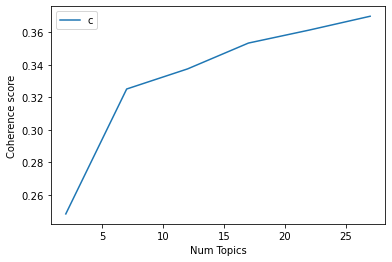

In [43]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_sg_score1)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [168]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_sg_score1):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 27

index: 0 | Num Topics = 2  has Coherence Value of 0.2483
index: 1 | Num Topics = 7  has Coherence Value of 0.325
index: 2 | Num Topics = 12  has Coherence Value of 0.3374
index: 3 | Num Topics = 17  has Coherence Value of 0.3533
index: 4 | Num Topics = 22  has Coherence Value of 0.3613
index: 5 | Num Topics = 27  has Coherence Value of 0.3698


In [169]:
# Select optimal number of topics
optimal_model_sg_score1 = model_list_sg_score1[5]

In [170]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_sg_score1 = pyLDAvis.gensim_models.prepare(optimal_model_sg_score1, corpus_sg_score1, id2word_sg_score1)

In [171]:
print("pyLDAVis for SG topics for score=1:")
vis_sg_score1

pyLDAVis for SG topics for score=1:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9      0.133751 -0.066332       1        1  13.359821
17    -0.106743 -0.195666       2        1   9.562191
24     0.136229 -0.013293       3        1   9.186816
13    -0.003786 -0.091941       4        1   6.582719
26     0.163819 -0.070641       5        1   5.615087
21    -0.117489 -0.084583       6        1   4.894726
11     0.127753 -0.046758       7        1   4.661076
8     -0.136623 -0.105898       8        1   4.573980
7      0.082791  0.019046       9        1   4.529714
15     0.071355  0.013378      10        1   4.181807
14     0.096452 -0.050031      11        1   3.598501
6     -0.041856 -0.050155      12        1   3.283296
19     0.001033  0.105275      13        1   3.201420
3      0.087740  0.017919      14        1   3.185852
5     -0.074375 -0.028439      15        1   2.901915
1      0.001255  0.007598      16        1   2.640872
23    -0.017284  0.045125      17        1   1.935308
25     0.062328  0.034013      18        1   1.862069
4      0.029457  0.066207      19        1   1.828767
16    -0.020079  0.082108      20        1   1.652705
12     0.001314  0.056710      21        1   1.450217
20    -0.038373  0.048790      22        1   1.170225
2     -0.022998  0.084904      23        1   0.893284
22    -0.091108  0.107568      24        1   0.892107
0     -0.168310 -0.011236      25        1   0.882902
10    -0.037984  0.049030      26        1   0.859541
18    -0.118267  0.077300      27        1   0.613082, topic_info=            Term        Freq       Total Category  logprob  loglift
182         view   48.000000   48.000000  Default  30.0000  30.0000
11            ad   62.000000   62.000000  Default  29.0000  29.0000
103       delete   32.000000   32.000000  Default  28.0000  28.0000
26         video  146.000000  146.000000  Default  27.0000  27.0000
8         update   39.000000   39.000000  Default  26.0000  26.0000
..           ...         ...         ...      ...      ...      ...
14         first    0.014595    5.672219  Topic27  -7.1058  -0.8682
15   interesting    0.014595    1.414682  Topic27  -7.1058   0.5205
16      minimise    0.014595    3.176784  Topic27  -7.1058  -0.2885
17         place    0.014595    3.593618  Topic27  -7.1058  -0.4118
18          skip    0.014595    6.744254  Topic27  -7.1058  -1.0413

[1346 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
189       1  0.151944        able
189       2  0.151944        able
189       3  0.151944        able
189      11  0.303888        able
189      18  0.151944        able
...     ...       ...         ...
145       8  0.663162    youtuber
145      12  0.331581    youtuber
524       2  0.642355       ytbre
797       5  0.668004  小孩子的儿歌广告太多
798       5  0.668004  点击开真的什么都不是

[1586 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 18, 25, 14, 27, 22, 12, 9, 8, 16, 15, 7, 20, 4, 6, 2, 24, 26, 5, 17, 13, 21, 3, 23, 1, 11, 19])

## LDA Topic Modelling (Rating = 2)

In [48]:
# By-rating Topic Modelling - rating = 2
# Convert to list - move to each section
review_sg_score2 = youtube_ios_sg_review_YearMonth_score2.review.values.tolist()
review_words_sg_score2 = list(sent_to_words(review_sg_score2))
print(review_words_sg_score2[:1])

[['what', 'up', 'with', 'watching', 'minute', 'long', 'video', 'that', 'gets', 'peppered', 'with', 'so', 'many', 'ads', 'in', 'between', 'so', 'disruptive', 'and', 'very', 'bad', 'user', 'experience']]


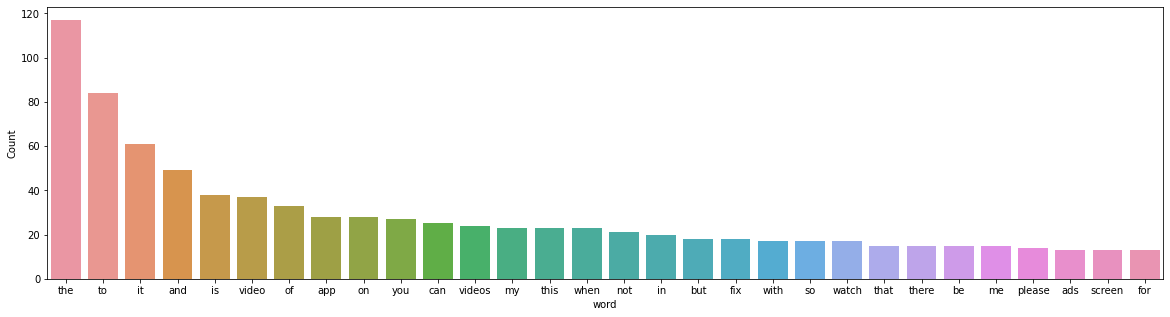

In [49]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_sg_score2))

In [50]:
# Clean text
review_sg_ready_score2 = process_words(review_words_sg_score2)  # processed Text Data! - move to each section


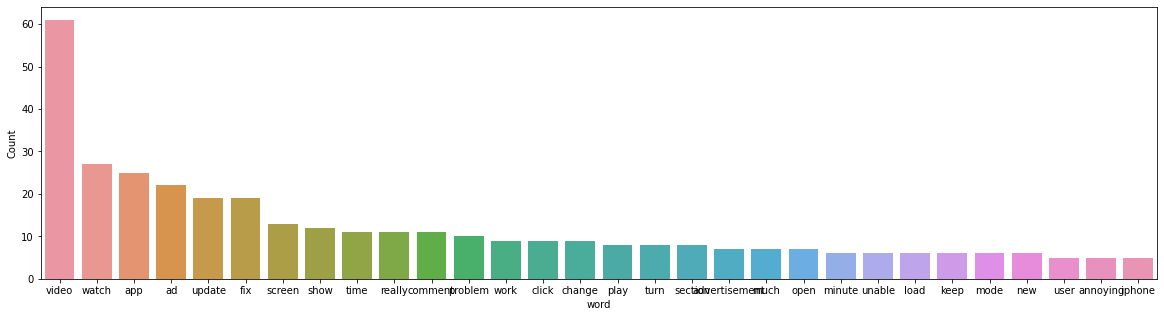

In [51]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_sg_ready_score2))


In [52]:
# Create Dictionary
id2word_sg_score2 = corpora.Dictionary(review_sg_ready_score2)

2021-10-16 23:37:45,806 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 23:37:45,812 [INFO] gensim.corpora.dictionary - built Dictionary(409 unique tokens: ['ad', 'bad', 'disruptive', 'experience', 'long']...) from 86 documents (total 972 corpus positions)
2021-10-16 23:37:45,814 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(409 unique tokens: ['ad', 'bad', 'disruptive', 'experience', 'long']...) from 86 documents (total 972 corpus positions)", 'datetime': '2021-10-16T23:37:45.814078', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [53]:
# Create Corpus: Term Document Frequency
corpus_sg_score2 = [id2word_sg_score2.doc2bow(text) for text in review_sg_ready_score2]

In [54]:
# Training LDA model
model_list_sg_score2, coherence_values_sg_score2 = compute_coherence_values(dictionary=id2word_sg_score2, corpus=corpus_sg_score2, 
                                                              texts=review_sg_ready_score2, limit=30, start=2, step=5)


2021-10-16 23:37:45,840 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 23:37:45,841 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 23:37:45,843 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 23:37:45,845 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 86 documents, updating model once every 86 documents, evaluating perplexity every 86 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 23:37:46,162 [INFO] gensim.models.ldamodel - -6.731 per-word bound, 106.2 perplexity estimate based on a held-out corpus of 86 documents with 972 words
2021-10-16 23:37:46,175 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #86/86
2021-10-16 23:37:46,395 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.048*"video" + 0.029*"app" + 0.024*"watch" + 0.018*"fix" + 0.014*"update" + 0.013*"screen" + 0.010*"problem" +

2021-10-16 23:37:49,060 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.047*"video" + 0.032*"ad" + 0.018*"update" + 0.018*"watch" + 0.015*"comment" + 0.015*"show" + 0.014*"fix" + 0.014*"change" + 0.012*"section" + 0.011*"really"
2021-10-16 23:37:49,062 [INFO] gensim.models.ldamodel - topic diff=0.010260, rho=0.301511
2021-10-16 23:37:49,139 [INFO] gensim.models.ldamodel - -5.925 per-word bound, 60.8 perplexity estimate based on a held-out corpus of 86 documents with 972 words
2021-10-16 23:37:49,140 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #86/86
2021-10-16 23:37:49,278 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.042*"video" + 0.036*"app" + 0.023*"watch" + 0.017*"screen" + 0.015*"fix" + 0.014*"problem" + 0.011*"update" + 0.011*"advertisement" + 0.009*"turn" + 0.008*"play"
2021-10-16 23:37:49,280 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.048*"video" + 0.032*"ad" + 0.018*"update" + 0.018*"watch" + 0.015*"comment" + 0.015*"show" + 0.014*"fix" + 

2021-10-16 23:37:51,469 [INFO] gensim.models.ldamodel - topic diff=0.001839, rho=0.218218
2021-10-16 23:37:51,592 [INFO] gensim.models.ldamodel - -5.920 per-word bound, 60.6 perplexity estimate based on a held-out corpus of 86 documents with 972 words
2021-10-16 23:37:51,593 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #86/86
2021-10-16 23:37:51,756 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.042*"video" + 0.036*"app" + 0.022*"watch" + 0.018*"screen" + 0.015*"fix" + 0.014*"problem" + 0.011*"update" + 0.011*"advertisement" + 0.009*"turn" + 0.008*"play"
2021-10-16 23:37:51,776 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.048*"video" + 0.033*"ad" + 0.019*"watch" + 0.018*"update" + 0.016*"show" + 0.015*"comment" + 0.014*"fix" + 0.014*"change" + 0.012*"section" + 0.011*"really"
2021-10-16 23:37:51,778 [INFO] gensim.models.ldamodel - topic diff=0.001559, rho=0.213201
2021-10-16 23:37:51,901 [INFO] gensim.models.ldamodel - -5.920 per-word bound, 60.6 perplexit

2021-10-16 23:37:54,065 [INFO] gensim.models.ldamodel - -5.920 per-word bound, 60.5 perplexity estimate based on a held-out corpus of 86 documents with 972 words
2021-10-16 23:37:54,066 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #86/86
2021-10-16 23:37:54,183 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.042*"video" + 0.037*"app" + 0.021*"watch" + 0.019*"screen" + 0.015*"fix" + 0.014*"problem" + 0.011*"update" + 0.011*"advertisement" + 0.009*"turn" + 0.009*"play"
2021-10-16 23:37:54,184 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.048*"video" + 0.033*"ad" + 0.019*"watch" + 0.018*"update" + 0.016*"show" + 0.015*"comment" + 0.014*"fix" + 0.014*"change" + 0.012*"section" + 0.011*"really"
2021-10-16 23:37:54,186 [INFO] gensim.models.ldamodel - topic diff=0.000547, rho=0.176777
2021-10-16 23:37:54,302 [INFO] gensim.models.ldamodel - -5.920 per-word bound, 60.5 perplexity estimate based on a held-out corpus of 86 documents with 972 words
2021-10-16 23:37:54,3

2021-10-16 23:37:56,434 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #86/86
2021-10-16 23:37:56,552 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.042*"video" + 0.037*"app" + 0.021*"watch" + 0.019*"screen" + 0.015*"fix" + 0.014*"problem" + 0.011*"update" + 0.011*"advertisement" + 0.009*"turn" + 0.009*"play"
2021-10-16 23:37:56,554 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.048*"video" + 0.033*"ad" + 0.019*"watch" + 0.018*"update" + 0.016*"show" + 0.015*"comment" + 0.014*"fix" + 0.014*"change" + 0.012*"section" + 0.011*"really"
2021-10-16 23:37:56,556 [INFO] gensim.models.ldamodel - topic diff=0.000401, rho=0.154303
2021-10-16 23:37:56,660 [INFO] gensim.models.ldamodel - -5.920 per-word bound, 60.5 perplexity estimate based on a held-out corpus of 86 documents with 972 words
2021-10-16 23:37:56,662 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #86/86
2021-10-16 23:37:56,755 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.042*"video" +

2021-10-16 23:37:58,657 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 23:38:04,099 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 23:38:04,127 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 82 virtual documents
2021-10-16 23:38:04,662 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-16 23:38:04,663 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
2021-10-16 23:38:04,668 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 23:38:04,670 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 7 topics, 50 passes over the supplied corpus of 86 documents, updating model once every 86 documents, evaluating perplexity every 86 documents, iterating 50x with a converg

2021-10-16 23:38:06,179 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.040*"video" + 0.040*"ad" + 0.018*"show" + 0.018*"back" + 0.018*"default" + 0.018*"account" + 0.016*"problem" + 0.016*"skip" + 0.013*"fix" + 0.013*"big"
2021-10-16 23:38:06,181 [INFO] gensim.models.ldamodel - topic diff=0.038672, rho=0.408248
2021-10-16 23:38:06,410 [INFO] gensim.models.ldamodel - -6.244 per-word bound, 75.8 perplexity estimate based on a held-out corpus of 86 documents with 972 words
2021-10-16 23:38:06,412 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #86/86
2021-10-16 23:38:06,532 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.054*"app" + 0.028*"work" + 0.027*"change" + 0.022*"picture" + 0.017*"update" + 0.017*"fix" + 0.012*"interested" + 0.012*"view" + 0.012*"always" + 0.012*"click"
2021-10-16 23:38:06,534 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.022*"screen" + 0.021*"video" + 0.021*"fix" + 0.021*"quality" + 0.015*"click" + 0.015*"button" + 0.015*"everytime" +

2021-10-16 23:38:07,976 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.063*"update" + 0.032*"comment" + 0.026*"section" + 0.019*"still" + 0.013*"watch" + 0.013*"keep" + 0.013*"minute" + 0.013*"show" + 0.013*"annoying" + 0.013*"super"
2021-10-16 23:38:07,980 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.041*"video" + 0.041*"ad" + 0.018*"show" + 0.018*"back" + 0.018*"default" + 0.018*"account" + 0.018*"skip" + 0.013*"problem" + 0.012*"fix" + 0.012*"big"
2021-10-16 23:38:07,986 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.086*"video" + 0.041*"watch" + 0.026*"really" + 0.020*"ad" + 0.014*"app" + 0.013*"problem" + 0.013*"show" + 0.013*"mode" + 0.010*"screen" + 0.010*"fix"
2021-10-16 23:38:07,987 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.021*"screen" + 0.021*"fix" + 0.021*"video" + 0.021*"quality" + 0.015*"click" + 0.015*"button" + 0.015*"error" + 0.015*"everytime" + 0.015*"turn" + 0.015*"asap"
2021-10-16 23:38:07,989 [INFO] gensim.models.ldamodel - topic diff=0.0

2021-10-16 23:38:09,544 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.021*"screen" + 0.021*"fix" + 0.021*"quality" + 0.021*"video" + 0.015*"button" + 0.015*"click" + 0.015*"error" + 0.015*"everytime" + 0.015*"turn" + 0.015*"asap"
2021-10-16 23:38:09,546 [INFO] gensim.models.ldamodel - topic diff=0.001339, rho=0.242536
2021-10-16 23:38:09,607 [INFO] gensim.models.ldamodel - -6.230 per-word bound, 75.1 perplexity estimate based on a held-out corpus of 86 documents with 972 words
2021-10-16 23:38:09,608 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #86/86
2021-10-16 23:38:09,803 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.085*"video" + 0.041*"watch" + 0.026*"really" + 0.020*"ad" + 0.014*"app" + 0.013*"mode" + 0.013*"problem" + 0.013*"show" + 0.010*"fix" + 0.010*"screen"
2021-10-16 23:38:09,804 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.054*"app" + 0.028*"work" + 0.028*"change" + 0.022*"picture" + 0.017*"update" + 0.017*"fix" + 0.011*"unable" + 0.011

2021-10-16 23:38:11,385 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.041*"ad" + 0.041*"video" + 0.018*"show" + 0.018*"back" + 0.018*"default" + 0.018*"account" + 0.018*"skip" + 0.012*"problem" + 0.012*"big" + 0.012*"interested"
2021-10-16 23:38:11,391 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.063*"update" + 0.032*"comment" + 0.026*"section" + 0.019*"still" + 0.013*"keep" + 0.013*"minute" + 0.013*"annoying" + 0.013*"new" + 0.013*"show" + 0.013*"super"
2021-10-16 23:38:11,393 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.086*"video" + 0.042*"watch" + 0.026*"really" + 0.020*"ad" + 0.014*"app" + 0.013*"mode" + 0.013*"problem" + 0.013*"show" + 0.010*"fix" + 0.010*"screen"
2021-10-16 23:38:11,402 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.021*"screen" + 0.021*"fix" + 0.021*"quality" + 0.021*"video" + 0.015*"button" + 0.015*"error" + 0.015*"click" + 0.015*"turn" + 0.015*"everytime" + 0.015*"asap"
2021-10-16 23:38:11,403 [INFO] gensim.models.ldamodel - topic dif

2021-10-16 23:38:12,993 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.041*"ad" + 0.041*"video" + 0.018*"show" + 0.018*"back" + 0.018*"default" + 0.018*"account" + 0.018*"skip" + 0.012*"problem" + 0.012*"interested" + 0.012*"always"
2021-10-16 23:38:12,995 [INFO] gensim.models.ldamodel - topic diff=0.000221, rho=0.188982
2021-10-16 23:38:13,299 [INFO] gensim.models.ldamodel - -6.230 per-word bound, 75.1 perplexity estimate based on a held-out corpus of 86 documents with 972 words
2021-10-16 23:38:13,309 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #86/86
2021-10-16 23:38:13,408 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.029*"fix" + 0.024*"bug" + 0.020*"video" + 0.018*"update" + 0.016*"app" + 0.012*"increase" + 0.012*"volume" + 0.012*"give" + 0.012*"upgrade" + 0.012*"description"
2021-10-16 23:38:13,441 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.041*"ad" + 0.041*"video" + 0.018*"show" + 0.018*"back" + 0.018*"default" + 0.018*"account" + 0.018*"sk

2021-10-16 23:38:15,416 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.041*"ad" + 0.041*"video" + 0.018*"show" + 0.018*"back" + 0.018*"skip" + 0.018*"default" + 0.018*"account" + 0.012*"interested" + 0.012*"always" + 0.012*"problem"
2021-10-16 23:38:15,426 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.063*"update" + 0.032*"comment" + 0.026*"section" + 0.019*"still" + 0.013*"annoying" + 0.013*"keep" + 0.013*"minute" + 0.013*"new" + 0.013*"show" + 0.013*"super"
2021-10-16 23:38:15,429 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.085*"video" + 0.040*"watch" + 0.026*"really" + 0.020*"ad" + 0.014*"app" + 0.013*"mode" + 0.013*"problem" + 0.013*"show" + 0.010*"screen" + 0.010*"fix"
2021-10-16 23:38:15,431 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.029*"fix" + 0.024*"bug" + 0.020*"video" + 0.018*"update" + 0.016*"app" + 0.012*"volume" + 0.012*"increase" + 0.012*"give" + 0.012*"upgrade" + 0.012*"description"
2021-10-16 23:38:15,432 [INFO] gensim.models.ldamodel - topi

2021-10-16 23:38:17,139 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.077*"video" + 0.044*"watch" + 0.031*"ad" + 0.023*"play" + 0.019*"app" + 0.018*"time" + 0.018*"happen" + 0.018*"screen" + 0.014*"much" + 0.014*"advertisement"
2021-10-16 23:38:17,141 [INFO] gensim.models.ldamodel - topic diff=0.000060, rho=0.160128
2021-10-16 23:38:17,352 [INFO] gensim.models.ldamodel - -6.230 per-word bound, 75.1 perplexity estimate based on a held-out corpus of 86 documents with 972 words
2021-10-16 23:38:17,353 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #86/86
2021-10-16 23:38:17,542 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.085*"video" + 0.040*"watch" + 0.026*"really" + 0.020*"ad" + 0.013*"app" + 0.013*"mode" + 0.013*"problem" + 0.013*"show" + 0.010*"screen" + 0.010*"fix"
2021-10-16 23:38:17,551 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.077*"video" + 0.044*"watch" + 0.031*"ad" + 0.023*"play" + 0.020*"app" + 0.018*"time" + 0.018*"happen" + 0.018*"screen

2021-10-16 23:38:19,725 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.021*"screen" + 0.021*"fix" + 0.021*"quality" + 0.021*"video" + 0.015*"button" + 0.015*"error" + 0.015*"click" + 0.015*"turn" + 0.015*"asap" + 0.015*"everytime"
2021-10-16 23:38:19,727 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.054*"app" + 0.028*"change" + 0.028*"work" + 0.022*"picture" + 0.017*"fix" + 0.017*"update" + 0.011*"unable" + 0.011*"time" + 0.011*"problem" + 0.011*"much"
2021-10-16 23:38:19,730 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.077*"video" + 0.043*"watch" + 0.032*"ad" + 0.023*"play" + 0.019*"app" + 0.018*"time" + 0.018*"happen" + 0.018*"screen" + 0.014*"much" + 0.014*"advertisement"
2021-10-16 23:38:19,733 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.041*"ad" + 0.041*"video" + 0.018*"show" + 0.018*"skip" + 0.018*"back" + 0.018*"default" + 0.018*"account" + 0.012*"interested" + 0.012*"always" + 0.012*"wifi"
2021-10-16 23:38:19,734 [INFO] gensim.models.ldamodel - topic d

2021-10-16 23:38:21,387 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.041*"ad" + 0.041*"video" + 0.018*"show" + 0.018*"skip" + 0.018*"back" + 0.018*"default" + 0.018*"account" + 0.012*"interested" + 0.012*"always" + 0.012*"wifi"
2021-10-16 23:38:21,389 [INFO] gensim.models.ldamodel - topic diff=0.000113, rho=0.141421
2021-10-16 23:38:21,612 [INFO] gensim.models.ldamodel - -6.230 per-word bound, 75.1 perplexity estimate based on a held-out corpus of 86 documents with 972 words
2021-10-16 23:38:21,614 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #86/86
2021-10-16 23:38:21,715 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.054*"app" + 0.028*"change" + 0.028*"work" + 0.022*"picture" + 0.017*"fix" + 0.017*"update" + 0.011*"unable" + 0.011*"time" + 0.011*"problem" + 0.011*"much"
2021-10-16 23:38:21,720 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.085*"video" + 0.041*"watch" + 0.026*"really" + 0.020*"ad" + 0.014*"app" + 0.013*"mode" + 0.013*"problem" + 0.01

2021-10-16 23:38:33,857 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.049*"update" + 0.049*"comment" + 0.040*"section" + 0.039*"picture" + 0.030*"change" + 0.019*"new" + 0.019*"really" + 0.019*"open" + 0.019*"ad" + 0.010*"add"
2021-10-16 23:38:33,858 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.034*"interested" + 0.034*"video" + 0.023*"click" + 0.023*"work" + 0.023*"channel" + 0.023*"recommend" + 0.023*"drama" + 0.023*"time" + 0.023*"really" + 0.023*"annoying"
2021-10-16 23:38:33,860 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.066*"video" + 0.038*"ad" + 0.023*"default" + 0.023*"show" + 0.023*"skip" + 0.023*"change" + 0.016*"caption" + 0.016*"interface" + 0.016*"turn" + 0.016*"interested"
2021-10-16 23:38:33,864 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.058*"video" + 0.034*"fix" + 0.034*"click" + 0.023*"asap" + 0.023*"error" + 0.023*"update" + 0.023*"loading" + 0.013*"ad" + 0.012*"watch" + 0.012*"work"
2021-10-16 23:38:33,865 [INFO] gensim.models.ldamodel

2021-10-16 23:38:35,176 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.039*"app" + 0.039*"account" + 0.027*"open" + 0.027*"sign" + 0.027*"video" + 0.014*"problem" + 0.014*"add" + 0.014*"wifi" + 0.014*"load" + 0.014*"long"
2021-10-16 23:38:35,178 [INFO] gensim.models.ldamodel - topic diff=0.008218, rho=0.316228
2021-10-16 23:38:35,229 [INFO] gensim.models.ldamodel - -6.341 per-word bound, 81.1 perplexity estimate based on a held-out corpus of 86 documents with 972 words
2021-10-16 23:38:35,230 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #86/86
2021-10-16 23:38:35,404 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.067*"video" + 0.039*"ad" + 0.024*"default" + 0.024*"show" + 0.024*"skip" + 0.021*"change" + 0.016*"caption" + 0.016*"turn" + 0.016*"interface" + 0.016*"interested"
2021-10-16 23:38:35,414 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.045*"app" + 0.031*"time" + 0.031*"view" + 0.031*"way" + 0.016*"crash" + 0.016*"screen" + 0.016*"unable" + 0.016*

2021-10-16 23:38:36,782 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.039*"app" + 0.039*"account" + 0.027*"open" + 0.027*"sign" + 0.027*"video" + 0.014*"add" + 0.014*"problem" + 0.014*"wifi" + 0.014*"long" + 0.014*"load"
2021-10-16 23:38:36,795 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.045*"app" + 0.031*"time" + 0.031*"view" + 0.031*"way" + 0.016*"crash" + 0.016*"screen" + 0.016*"unable" + 0.016*"work" + 0.016*"change" + 0.016*"always"
2021-10-16 23:38:36,797 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.070*"app" + 0.056*"advertisement" + 0.041*"video" + 0.036*"much" + 0.024*"ad" + 0.024*"really" + 0.024*"put" + 0.024*"view" + 0.013*"watch" + 0.013*"time"
2021-10-16 23:38:36,798 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.057*"video" + 0.035*"fix" + 0.035*"click" + 0.023*"asap" + 0.023*"error" + 0.023*"loading" + 0.023*"update" + 0.012*"ad" + 0.012*"watch" + 0.012*"work"
2021-10-16 23:38:36,799 [INFO] gensim.models.ldamodel - topic diff=0.001883, rho=0.25

2021-10-16 23:38:37,757 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.071*"update" + 0.045*"app" + 0.027*"watch" + 0.018*"keep" + 0.018*"show" + 0.018*"minute" + 0.018*"still" + 0.018*"ask" + 0.018*"issue" + 0.018*"iphone"
2021-10-16 23:38:37,759 [INFO] gensim.models.ldamodel - topic diff=0.000604, rho=0.218218
2021-10-16 23:38:37,928 [INFO] gensim.models.ldamodel - -6.337 per-word bound, 80.9 perplexity estimate based on a held-out corpus of 86 documents with 972 words
2021-10-16 23:38:37,930 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #86/86
2021-10-16 23:38:37,961 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.045*"app" + 0.031*"time" + 0.031*"view" + 0.031*"way" + 0.016*"crash" + 0.016*"screen" + 0.016*"unable" + 0.016*"work" + 0.016*"change" + 0.016*"always"
2021-10-16 23:38:37,962 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.071*"update" + 0.045*"app" + 0.027*"watch" + 0.018*"keep" + 0.018*"show" + 0.018*"minute" + 0.018*"still" + 0.018*"ask" 

2021-10-16 23:38:39,047 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.034*"interested" + 0.034*"video" + 0.023*"click" + 0.023*"work" + 0.023*"recommend" + 0.023*"channel" + 0.023*"drama" + 0.023*"time" + 0.023*"annoying" + 0.023*"really"
2021-10-16 23:38:39,048 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.061*"comment" + 0.053*"update" + 0.053*"section" + 0.035*"picture" + 0.031*"change" + 0.023*"new" + 0.018*"open" + 0.018*"really" + 0.018*"ad" + 0.018*"shift"
2021-10-16 23:38:39,050 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.038*"fix" + 0.032*"video" + 0.025*"bug" + 0.019*"watch" + 0.019*"volume" + 0.019*"increase" + 0.013*"upgrade" + 0.013*"wrong" + 0.013*"give" + 0.013*"screen"
2021-10-16 23:38:39,051 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.039*"app" + 0.039*"account" + 0.027*"open" + 0.027*"sign" + 0.027*"video" + 0.014*"add" + 0.014*"problem" + 0.014*"wifi" + 0.014*"long" + 0.014*"load"
2021-10-16 23:38:39,051 [INFO] gensim.models.ldamodel - to

2021-10-16 23:38:39,999 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.066*"video" + 0.058*"ad" + 0.041*"play" + 0.025*"show" + 0.025*"screen" + 0.025*"app" + 0.025*"watch" + 0.017*"quality" + 0.017*"happen" + 0.017*"choose"
2021-10-16 23:38:40,000 [INFO] gensim.models.ldamodel - topic diff=0.000055, rho=0.176777
2021-10-16 23:38:40,174 [INFO] gensim.models.ldamodel - -6.337 per-word bound, 80.9 perplexity estimate based on a held-out corpus of 86 documents with 972 words
2021-10-16 23:38:40,175 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #86/86
2021-10-16 23:38:40,200 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.039*"app" + 0.039*"account" + 0.027*"open" + 0.027*"sign" + 0.027*"video" + 0.014*"add" + 0.014*"problem" + 0.014*"wifi" + 0.014*"long" + 0.014*"load"
2021-10-16 23:38:40,201 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.070*"video" + 0.037*"watch" + 0.024*"turn" + 0.024*"ad" + 0.019*"screen" + 0.019*"mode" + 0.014*"pop" + 0.014*"audio" + 0

2021-10-16 23:38:41,095 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.068*"video" + 0.039*"ad" + 0.024*"show" + 0.024*"default" + 0.024*"skip" + 0.020*"change" + 0.016*"caption" + 0.016*"turn" + 0.016*"always" + 0.016*"interested"
2021-10-16 23:38:41,097 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.070*"app" + 0.056*"advertisement" + 0.041*"video" + 0.036*"much" + 0.024*"ad" + 0.024*"really" + 0.024*"put" + 0.024*"view" + 0.013*"watch" + 0.013*"time"
2021-10-16 23:38:41,099 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.034*"interested" + 0.034*"video" + 0.023*"work" + 0.023*"time" + 0.023*"click" + 0.023*"annoying" + 0.023*"recommend" + 0.023*"channel" + 0.023*"drama" + 0.023*"really"
2021-10-16 23:38:41,102 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.080*"video" + 0.054*"watch" + 0.028*"fix" + 0.019*"already" + 0.019*"unable" + 0.019*"button" + 0.019*"recommendation" + 0.019*"filter" + 0.019*"upload" + 0.019*"click"
2021-10-16 23:38:41,104 [INFO] gensim.mod

2021-10-16 23:38:42,070 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.034*"interested" + 0.034*"video" + 0.023*"work" + 0.023*"annoying" + 0.023*"time" + 0.023*"recommend" + 0.023*"click" + 0.023*"really" + 0.023*"channel" + 0.023*"drama"
2021-10-16 23:38:42,071 [INFO] gensim.models.ldamodel - topic diff=0.000008, rho=0.152499
2021-10-16 23:38:42,186 [INFO] gensim.models.ldamodel - -6.337 per-word bound, 80.9 perplexity estimate based on a held-out corpus of 86 documents with 972 words
2021-10-16 23:38:42,187 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #86/86
2021-10-16 23:38:42,238 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.071*"update" + 0.045*"app" + 0.027*"watch" + 0.018*"problem" + 0.018*"keep" + 0.018*"show" + 0.018*"minute" + 0.018*"fix" + 0.018*"issue" + 0.018*"iphone"
2021-10-16 23:38:42,241 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.068*"video" + 0.039*"ad" + 0.024*"show" + 0.024*"default" + 0.024*"skip" + 0.020*"change" + 0.016*"alw

2021-10-16 23:38:43,187 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.066*"video" + 0.058*"ad" + 0.041*"play" + 0.025*"show" + 0.025*"screen" + 0.025*"app" + 0.025*"watch" + 0.017*"quality" + 0.017*"happen" + 0.017*"choose"
2021-10-16 23:38:43,189 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.034*"interested" + 0.034*"video" + 0.023*"annoying" + 0.023*"work" + 0.023*"time" + 0.023*"recommend" + 0.023*"click" + 0.023*"really" + 0.023*"channel" + 0.023*"drama"
2021-10-16 23:38:43,195 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.080*"video" + 0.054*"watch" + 0.028*"fix" + 0.019*"already" + 0.019*"unable" + 0.019*"button" + 0.019*"recommendation" + 0.019*"filter" + 0.019*"click" + 0.019*"upload"
2021-10-16 23:38:43,196 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.061*"comment" + 0.053*"update" + 0.053*"section" + 0.035*"picture" + 0.031*"change" + 0.023*"new" + 0.018*"open" + 0.018*"really" + 0.018*"ad" + 0.018*"shift"
2021-10-16 23:38:43,198 [INFO] gensim.model

2021-10-16 23:38:56,494 [INFO] gensim.models.ldamodel - topic diff=0.058945, rho=0.577350
2021-10-16 23:38:56,639 [INFO] gensim.models.ldamodel - -6.519 per-word bound, 91.7 perplexity estimate based on a held-out corpus of 86 documents with 972 words
2021-10-16 23:38:56,644 [INFO] gensim.models.ldamodel - PROGRESS: pass 2, at document #86/86
2021-10-16 23:38:56,729 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.038*"advertisement" + 0.038*"song" + 0.038*"add" + 0.038*"whole" + 0.002*"app" + 0.002*"ad" + 0.002*"video" + 0.002*"screen" + 0.002*"change" + 0.002*"update"
2021-10-16 23:38:56,742 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.039*"way" + 0.039*"drama" + 0.039*"change" + 0.039*"view" + 0.039*"watch" + 0.020*"conversation" + 0.020*"movie" + 0.020*"delete" + 0.020*"find" + 0.020*"srsly"
2021-10-16 23:38:56,745 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.090*"video" + 0.043*"watch" + 0.021*"really" + 0.021*"mode" + 0.016*"pop" + 0.016*"user" + 0.016*"screen" 

2021-10-16 23:38:58,017 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.093*"app" + 0.035*"account" + 0.035*"open" + 0.024*"force" + 0.024*"sign" + 0.024*"long" + 0.012*"access" + 0.012*"multiple" + 0.012*"blank" + 0.012*"always"
2021-10-16 23:38:58,019 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.056*"picture" + 0.056*"update" + 0.042*"change" + 0.029*"comment" + 0.028*"open" + 0.015*"fix" + 0.015*"section" + 0.015*"add" + 0.015*"refuse" + 0.015*"kind"
2021-10-16 23:38:58,023 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.088*"video" + 0.039*"watch" + 0.022*"really" + 0.022*"mode" + 0.017*"turn" + 0.017*"pop" + 0.017*"screen" + 0.017*"user" + 0.011*"restrict" + 0.011*"audio"
2021-10-16 23:38:58,024 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.027*"new" + 0.027*"interface" + 0.027*"quite" + 0.027*"handful" + 0.027*"original" + 0.027*"back" + 0.027*"change" + 0.027*"mode" + 0.027*"comment" + 0.027*"section"
2021-10-16 23:38:58,026 [INFO] gensim.models.ldamodel - 

2021-10-16 23:38:59,812 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.051*"update" + 0.031*"comment" + 0.031*"section" + 0.021*"still" + 0.021*"watch" + 0.021*"minute" + 0.021*"super" + 0.021*"ad" + 0.021*"annoying" + 0.011*"new"
2021-10-16 23:38:59,813 [INFO] gensim.models.ldamodel - topic diff=0.002256, rho=0.267261
2021-10-16 23:39:00,004 [INFO] gensim.models.ldamodel - -6.463 per-word bound, 88.2 perplexity estimate based on a held-out corpus of 86 documents with 972 words
2021-10-16 23:39:00,005 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #86/86
2021-10-16 23:39:00,190 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.076*"video" + 0.025*"ad" + 0.025*"time" + 0.025*"annoying" + 0.025*"press" + 0.014*"show" + 0.013*"update" + 0.013*"io" + 0.013*"screen" + 0.013*"full"
2021-10-16 23:39:00,197 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.035*"video" + 0.026*"fix" + 0.026*"app" + 0.026*"bug" + 0.026*"screen" + 0.026*"volume" + 0.026*"increase" + 0.018

2021-10-16 23:39:01,800 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.038*"song" + 0.038*"advertisement" + 0.038*"add" + 0.038*"whole" + 0.002*"decide" + 0.002*"break" + 0.002*"count" + 0.002*"amount" + 0.002*"let" + 0.002*"hot"
2021-10-16 23:39:01,806 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.035*"video" + 0.026*"fix" + 0.026*"app" + 0.026*"screen" + 0.026*"bug" + 0.026*"increase" + 0.026*"volume" + 0.018*"watch" + 0.018*"upgrade" + 0.018*"turn"
2021-10-16 23:39:01,811 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.057*"click" + 0.038*"recommend" + 0.038*"work" + 0.038*"button" + 0.038*"interested" + 0.038*"channel" + 0.038*"unable" + 0.020*"video" + 0.020*"dot" + 0.020*"always"
2021-10-16 23:39:01,812 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.022*"million" + 0.022*"stream" + 0.022*"remove" + 0.022*"still" + 0.022*"video" + 0.022*"state" + 0.022*"view" + 0.022*"ridiculous" + 0.022*"music" + 0.022*"happen"
2021-10-16 23:39:01,814 [INFO] gensim.models.l

2021-10-16 23:39:03,265 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.045*"app" + 0.042*"video" + 0.037*"fix" + 0.034*"update" + 0.034*"problem" + 0.028*"watch" + 0.021*"big" + 0.014*"recommendation" + 0.014*"already" + 0.014*"work"
2021-10-16 23:39:03,274 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.120*"video" + 0.066*"watch" + 0.056*"ad" + 0.034*"default" + 0.034*"load" + 0.033*"show" + 0.030*"fix" + 0.023*"turn" + 0.023*"caption" + 0.023*"open"
2021-10-16 23:39:03,276 [INFO] gensim.models.ldamodel - topic diff=0.000126, rho=0.200000
2021-10-16 23:39:03,537 [INFO] gensim.models.ldamodel - -6.462 per-word bound, 88.2 perplexity estimate based on a held-out corpus of 86 documents with 972 words
2021-10-16 23:39:03,540 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #86/86
2021-10-16 23:39:03,630 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.056*"picture" + 0.056*"update" + 0.042*"change" + 0.029*"comment" + 0.029*"open" + 0.015*"fix" + 0.015*"secti

2021-10-16 23:39:04,849 [INFO] gensim.models.ldamodel - PROGRESS: pass 29, at document #86/86
2021-10-16 23:39:04,881 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.035*"video" + 0.026*"fix" + 0.026*"app" + 0.026*"screen" + 0.026*"bug" + 0.026*"increase" + 0.026*"volume" + 0.018*"watch" + 0.018*"turn" + 0.018*"upgrade"
2021-10-16 23:39:04,883 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.076*"video" + 0.025*"ad" + 0.025*"annoying" + 0.025*"time" + 0.025*"press" + 0.014*"show" + 0.013*"update" + 0.013*"io" + 0.013*"manually" + 0.013*"stick"
2021-10-16 23:39:04,884 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.044*"much" + 0.044*"advertisement" + 0.044*"time" + 0.022*"irritate" + 0.022*"put" + 0.022*"stop" + 0.022*"update" + 0.022*"ever" + 0.022*"keep" + 0.022*"non"
2021-10-16 23:39:04,886 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.039*"drama" + 0.039*"watch" + 0.039*"way" + 0.039*"view" + 0.039*"change" + 0.020*"english" + 0.020*"movie" + 0.020*"reading" + 0.02

2021-10-16 23:39:05,960 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.087*"video" + 0.038*"watch" + 0.022*"mode" + 0.022*"really" + 0.017*"turn" + 0.017*"pop" + 0.017*"screen" + 0.017*"user" + 0.011*"hide" + 0.011*"restrict"
2021-10-16 23:39:05,962 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.044*"much" + 0.044*"advertisement" + 0.044*"time" + 0.022*"irritate" + 0.022*"put" + 0.022*"stop" + 0.022*"update" + 0.022*"ever" + 0.022*"keep" + 0.022*"non"
2021-10-16 23:39:05,965 [INFO] gensim.models.ldamodel - topic diff=0.000012, rho=0.166667
2021-10-16 23:39:06,090 [INFO] gensim.models.ldamodel - -6.462 per-word bound, 88.2 perplexity estimate based on a held-out corpus of 86 documents with 972 words
2021-10-16 23:39:06,098 [INFO] gensim.models.ldamodel - PROGRESS: pass 35, at document #86/86
2021-10-16 23:39:06,201 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.022*"million" + 0.022*"stream" + 0.022*"remove" + 0.022*"still" + 0.022*"video" + 0.022*"state" + 0.022*"view" 

2021-10-16 23:39:07,178 [INFO] gensim.models.ldamodel - -6.462 per-word bound, 88.2 perplexity estimate based on a held-out corpus of 86 documents with 972 words
2021-10-16 23:39:07,181 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #86/86
2021-10-16 23:39:07,218 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.071*"video" + 0.063*"ad" + 0.045*"play" + 0.027*"app" + 0.027*"show" + 0.027*"watch" + 0.027*"screen" + 0.018*"happen" + 0.018*"work" + 0.018*"time"
2021-10-16 23:39:07,222 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.044*"much" + 0.044*"advertisement" + 0.044*"time" + 0.022*"irritate" + 0.022*"put" + 0.022*"stop" + 0.022*"update" + 0.022*"ever" + 0.022*"keep" + 0.022*"non"
2021-10-16 23:39:07,223 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.051*"update" + 0.031*"comment" + 0.031*"section" + 0.021*"minute" + 0.021*"watch" + 0.021*"still" + 0.021*"super" + 0.021*"annoying" + 0.021*"ad" + 0.011*"new"
2021-10-16 23:39:07,227 [INFO] gensim.models.lda

2021-10-16 23:39:08,670 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.051*"update" + 0.031*"comment" + 0.031*"section" + 0.021*"super" + 0.021*"still" + 0.021*"minute" + 0.021*"watch" + 0.021*"annoying" + 0.021*"ad" + 0.011*"new"
2021-10-16 23:39:08,704 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.057*"click" + 0.038*"interested" + 0.038*"recommend" + 0.038*"work" + 0.038*"channel" + 0.038*"button" + 0.038*"unable" + 0.020*"video" + 0.020*"always" + 0.020*"already"
2021-10-16 23:39:08,719 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.042*"video" + 0.022*"ad" + 0.021*"fix" + 0.021*"section" + 0.021*"comment" + 0.021*"numerous" + 0.021*"time" + 0.021*"tell" + 0.021*"setting" + 0.021*"otherwise"
2021-10-16 23:39:08,721 [INFO] gensim.models.ldamodel - topic diff=0.000002, rho=0.145865
2021-10-16 23:39:08,919 [INFO] gensim.models.ldamodel - -6.462 per-word bound, 88.2 perplexity estimate based on a held-out corpus of 86 documents with 972 words
2021-10-16 23:39:08,924 [I

2021-10-16 23:39:20,490 [INFO] gensim.models.ldamodel - -22.949 per-word bound, 8096655.5 perplexity estimate based on a held-out corpus of 86 documents with 972 words
2021-10-16 23:39:20,496 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #86/86
2021-10-16 23:39:20,716 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.061*"update" + 0.031*"refuse" + 0.031*"kind" + 0.031*"today" + 0.031*"open" + 0.031*"tell" + 0.031*"continue" + 0.031*"support" + 0.017*"comment" + 0.015*"button"
2021-10-16 23:39:20,718 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.041*"app" + 0.031*"fix" + 0.031*"screen" + 0.027*"time" + 0.027*"video" + 0.027*"unable" + 0.014*"previous" + 0.014*"asap" + 0.014*"control" + 0.014*"anger"
2021-10-16 23:39:20,719 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.059*"drama" + 0.030*"reading" + 0.030*"conversation" + 0.030*"movie" + 0.030*"sound" + 0.030*"watch" + 0.030*"minute" + 0.030*"subtitle" + 0.030*"separate" + 0.030*"advert"
2021-10-16 23:39:

2021-10-16 23:39:21,751 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.053*"video" + 0.053*"resolve" + 0.027*"pop" + 0.027*"finger" + 0.027*"irritate" + 0.027*"rate" + 0.027*"country" + 0.027*"keep" + 0.027*"screen" + 0.027*"issue"
2021-10-16 23:39:21,761 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.064*"comment" + 0.064*"section" + 0.039*"video" + 0.039*"ad" + 0.026*"really" + 0.026*"back" + 0.026*"time" + 0.026*"new" + 0.026*"fix" + 0.013*"otherwise"
2021-10-16 23:39:21,773 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.057*"show" + 0.038*"interested" + 0.038*"always" + 0.020*"allow" + 0.020*"language" + 0.020*"closing" + 0.020*"still" + 0.020*"time" + 0.020*"recommendation" + 0.020*"flaw"
2021-10-16 23:39:21,774 [INFO] gensim.models.ldamodel - topic diff=0.022802, rho=0.377964
2021-10-16 23:39:21,928 [INFO] gensim.models.ldamodel - -6.560 per-word bound, 94.4 perplexity estimate based on a held-out corpus of 86 documents with 972 words
2021-10-16 23:39:21,929 [IN

2021-10-16 23:39:22,744 [INFO] gensim.models.ldamodel - topic diff=0.004528, rho=0.288675
2021-10-16 23:39:22,917 [INFO] gensim.models.ldamodel - -6.554 per-word bound, 94.0 perplexity estimate based on a held-out corpus of 86 documents with 972 words
2021-10-16 23:39:22,923 [INFO] gensim.models.ldamodel - PROGRESS: pass 11, at document #86/86
2021-10-16 23:39:22,980 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.053*"video" + 0.053*"resolve" + 0.027*"finger" + 0.027*"pop" + 0.027*"irritate" + 0.027*"screen" + 0.027*"watch" + 0.027*"sec" + 0.027*"pause" + 0.027*"keep"
2021-10-16 23:39:22,985 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.054*"ad" + 0.044*"video" + 0.033*"app" + 0.033*"screen" + 0.033*"update" + 0.022*"high" + 0.022*"choose" + 0.022*"quality" + 0.022*"allow" + 0.022*"low"
2021-10-16 23:39:22,990 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.053*"app" + 0.032*"account" + 0.032*"screen" + 0.032*"wifi" + 0.031*"problem" + 0.022*"long" + 0.022*"reason" + 0.

2021-10-16 23:39:24,006 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.067*"video" + 0.058*"watch" + 0.058*"app" + 0.035*"update" + 0.026*"fix" + 0.023*"problem" + 0.023*"recommendation" + 0.023*"already" + 0.023*"first" + 0.012*"avail"
2021-10-16 23:39:24,008 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.053*"video" + 0.053*"resolve" + 0.027*"pop" + 0.027*"finger" + 0.027*"irritate" + 0.027*"button" + 0.027*"screen" + 0.027*"watch" + 0.027*"keep" + 0.027*"pause"
2021-10-16 23:39:24,011 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.040*"video" + 0.040*"view" + 0.040*"ad" + 0.040*"way" + 0.040*"sometimes" + 0.040*"slow" + 0.040*"app" + 0.020*"system" + 0.020*"almost" + 0.020*"help"
2021-10-16 23:39:24,013 [INFO] gensim.models.ldamodel - topic diff=0.000752, rho=0.235702
2021-10-16 23:39:24,186 [INFO] gensim.models.ldamodel - -6.554 per-word bound, 93.9 perplexity estimate based on a held-out corpus of 86 documents with 972 words
2021-10-16 23:39:24,187 [INFO] gensim.

2021-10-16 23:39:24,973 [INFO] gensim.models.ldamodel - topic diff=0.000196, rho=0.208514
2021-10-16 23:39:25,066 [INFO] gensim.models.ldamodel - -6.554 per-word bound, 93.9 perplexity estimate based on a held-out corpus of 86 documents with 972 words
2021-10-16 23:39:25,068 [INFO] gensim.models.ldamodel - PROGRESS: pass 22, at document #86/86
2021-10-16 23:39:25,164 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.053*"video" + 0.053*"resolve" + 0.027*"button" + 0.027*"screen" + 0.027*"pop" + 0.027*"finger" + 0.027*"irritate" + 0.027*"watch" + 0.027*"keep" + 0.027*"pause"
2021-10-16 23:39:25,166 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.040*"video" + 0.040*"view" + 0.040*"ad" + 0.040*"way" + 0.040*"sometimes" + 0.040*"slow" + 0.040*"app" + 0.020*"everytime" + 0.020*"load" + 0.020*"change"
2021-10-16 23:39:25,172 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.072*"ad" + 0.048*"play" + 0.048*"watch" + 0.048*"video" + 0.048*"update" + 0.025*"show" + 0.025*"app" + 0.02

2021-10-16 23:39:26,585 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.061*"button" + 0.031*"song" + 0.031*"add" + 0.031*"froze" + 0.031*"delay" + 0.031*"filter" + 0.031*"scroll" + 0.031*"click" + 0.031*"unable" + 0.031*"freeze"
2021-10-16 23:39:26,607 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.064*"comment" + 0.064*"section" + 0.039*"video" + 0.039*"ad" + 0.026*"really" + 0.026*"time" + 0.026*"back" + 0.026*"new" + 0.026*"fix" + 0.013*"otherwise"
2021-10-16 23:39:26,620 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.067*"video" + 0.058*"watch" + 0.058*"app" + 0.035*"update" + 0.026*"fix" + 0.023*"recommendation" + 0.023*"already" + 0.023*"problem" + 0.023*"first" + 0.012*"avail"
2021-10-16 23:39:26,626 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.074*"update" + 0.038*"tell" + 0.038*"refuse" + 0.038*"support" + 0.038*"kind" + 0.038*"today" + 0.038*"continue" + 0.038*"open" + 0.002*"comment" + 0.002*"button"
2021-10-16 23:39:26,629 [INFO] gensim.models.ldam

2021-10-16 23:39:27,730 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.045*"app" + 0.030*"fix" + 0.030*"screen" + 0.030*"video" + 0.030*"unable" + 0.030*"time" + 0.015*"direct" + 0.015*"blank" + 0.015*"fail" + 0.015*"always"
2021-10-16 23:39:27,732 [INFO] gensim.models.ldamodel - topic diff=0.000016, rho=0.171499
2021-10-16 23:39:27,819 [INFO] gensim.models.ldamodel - -6.554 per-word bound, 93.9 perplexity estimate based on a held-out corpus of 86 documents with 972 words
2021-10-16 23:39:27,840 [INFO] gensim.models.ldamodel - PROGRESS: pass 33, at document #86/86
2021-10-16 23:39:27,872 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.064*"comment" + 0.064*"section" + 0.039*"video" + 0.039*"ad" + 0.026*"really" + 0.026*"time" + 0.026*"back" + 0.026*"new" + 0.026*"fix" + 0.013*"otherwise"
2021-10-16 23:39:27,873 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.061*"button" + 0.031*"song" + 0.031*"add" + 0.031*"froze" + 0.031*"delay" + 0.031*"filter" + 0.031*"scroll" + 0.03

2021-10-16 23:39:28,937 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.088*"video" + 0.047*"watch" + 0.028*"mode" + 0.021*"really" + 0.021*"turn" + 0.014*"audio" + 0.014*"cause" + 0.014*"hide" + 0.014*"never" + 0.014*"restrict"
2021-10-16 23:39:28,938 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.054*"ad" + 0.044*"video" + 0.033*"update" + 0.033*"app" + 0.033*"screen" + 0.022*"allow" + 0.022*"choose" + 0.022*"low" + 0.022*"high" + 0.022*"quality"
2021-10-16 23:39:28,940 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.061*"button" + 0.031*"froze" + 0.031*"filter" + 0.031*"delay" + 0.031*"scroll" + 0.031*"freeze" + 0.031*"unable" + 0.031*"click" + 0.031*"screen" + 0.031*"song"
2021-10-16 23:39:28,941 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.072*"ad" + 0.048*"play" + 0.048*"video" + 0.048*"watch" + 0.048*"update" + 0.025*"show" + 0.025*"app" + 0.025*"never" + 0.025*"work" + 0.025*"refresh"
2021-10-16 23:39:28,943 [INFO] gensim.models.ldamodel - topic #12 (0.045)

2021-10-16 23:39:29,829 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.106*"video" + 0.029*"watch" + 0.020*"really" + 0.020*"play" + 0.020*"happen" + 0.020*"annoying" + 0.020*"advertisement" + 0.020*"press" + 0.020*"show" + 0.010*"app"
2021-10-16 23:39:29,831 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.061*"button" + 0.031*"froze" + 0.031*"delay" + 0.031*"filter" + 0.031*"scroll" + 0.031*"click" + 0.031*"freeze" + 0.031*"screen" + 0.031*"unable" + 0.031*"response"
2021-10-16 23:39:29,832 [INFO] gensim.models.ldamodel - topic diff=0.000002, rho=0.149071
2021-10-16 23:39:29,894 [INFO] gensim.models.ldamodel - -6.554 per-word bound, 93.9 perplexity estimate based on a held-out corpus of 86 documents with 972 words
2021-10-16 23:39:29,896 [INFO] gensim.models.ldamodel - PROGRESS: pass 44, at document #86/86
2021-10-16 23:39:29,941 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.053*"video" + 0.053*"resolve" + 0.027*"button" + 0.027*"screen" + 0.027*"pop" + 0.027*"finger

2021-10-16 23:39:30,757 [INFO] gensim.models.ldamodel - -6.554 per-word bound, 93.9 perplexity estimate based on a held-out corpus of 86 documents with 972 words
2021-10-16 23:39:30,758 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #86/86
2021-10-16 23:39:30,815 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.072*"ad" + 0.048*"play" + 0.048*"video" + 0.048*"watch" + 0.048*"update" + 0.025*"show" + 0.025*"app" + 0.025*"never" + 0.025*"work" + 0.025*"refresh"
2021-10-16 23:39:30,816 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.059*"drama" + 0.030*"subtitle" + 0.030*"much" + 0.030*"conversation" + 0.030*"advert" + 0.030*"movie" + 0.030*"reading" + 0.030*"sound" + 0.030*"english" + 0.030*"watch"
2021-10-16 23:39:30,817 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.088*"video" + 0.047*"watch" + 0.028*"mode" + 0.021*"really" + 0.021*"turn" + 0.014*"audio" + 0.014*"cause" + 0.014*"hide" + 0.014*"never" + 0.014*"restrict"
2021-10-16 23:39:30,822 [INFO] gensim.

2021-10-16 23:39:44,205 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.047*"update" + 0.024*"slide" + 0.024*"stick" + 0.024*"manually" + 0.024*"task" + 0.024*"automatically" + 0.024*"rotate" + 0.024*"feature" + 0.024*"first" + 0.024*"multi"
2021-10-16 23:39:44,206 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.082*"update" + 0.041*"watch" + 0.041*"still" + 0.041*"video" + 0.041*"minute" + 0.021*"ask" + 0.021*"finish" + 0.021*"issue" + 0.021*"close" + 0.021*"keep"
2021-10-16 23:39:44,208 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.066*"mode" + 0.050*"turn" + 0.033*"never" + 0.033*"restrict" + 0.017*"add" + 0.017*"set" + 0.017*"top" + 0.017*"load" + 0.017*"way" + 0.017*"comment"
2021-10-16 23:39:44,216 [INFO] gensim.models.ldamodel - topic diff=0.036657, rho=0.447214
2021-10-16 23:39:44,345 [INFO] gensim.models.ldamodel - -6.643 per-word bound, 100.0 perplexity estimate based on a held-out corpus of 86 documents with 972 words
2021-10-16 23:39:44,347 [INFO] gensim.mod

2021-10-16 23:39:45,285 [INFO] gensim.models.ldamodel - topic diff=0.009892, rho=0.316228
2021-10-16 23:39:45,416 [INFO] gensim.models.ldamodel - -6.611 per-word bound, 97.8 perplexity estimate based on a held-out corpus of 86 documents with 972 words
2021-10-16 23:39:45,417 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #86/86
2021-10-16 23:39:45,541 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.047*"update" + 0.024*"manually" + 0.024*"stick" + 0.024*"slide" + 0.024*"app" + 0.024*"rotate" + 0.024*"exit" + 0.024*"buggy" + 0.024*"automatically" + 0.024*"multi"
2021-10-16 23:39:45,545 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.002*"decide" + 0.002*"design" + 0.002*"amount" + 0.002*"break" + 0.002*"count" + 0.002*"ahead" + 0.002*"hot" + 0.002*"garbage" + 0.002*"original" + 0.002*"existant"
2021-10-16 23:39:45,550 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.044*"ad" + 0.042*"show" + 0.042*"always" + 0.028*"keep" + 0.028*"interested" + 0.018*"watch" 

2021-10-16 23:39:46,442 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.060*"ad" + 0.060*"really" + 0.030*"minute" + 0.030*"helpful" + 0.030*"video" + 0.030*"much" + 0.030*"unnecessary" + 0.030*"top" + 0.030*"put" + 0.030*"market"
2021-10-16 23:39:46,443 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.066*"mode" + 0.050*"turn" + 0.033*"never" + 0.033*"restrict" + 0.017*"add" + 0.017*"damned" + 0.017*"comment" + 0.017*"check" + 0.017*"problem" + 0.017*"favourite"
2021-10-16 23:39:46,444 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.043*"ad" + 0.042*"show" + 0.042*"always" + 0.028*"keep" + 0.028*"interested" + 0.020*"open" + 0.020*"vid" + 0.017*"watch" + 0.016*"video" + 0.015*"time"
2021-10-16 23:39:46,446 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.058*"update" + 0.039*"button" + 0.020*"fix" + 0.020*"screen" + 0.020*"scroll" + 0.020*"freeze" + 0.020*"delay" + 0.020*"comment" + 0.020*"response" + 0.020*"filter"
2021-10-16 23:39:46,448 [INFO] gensim.models.ldamode

2021-10-16 23:39:47,383 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.043*"ad" + 0.041*"show" + 0.041*"always" + 0.028*"keep" + 0.028*"interested" + 0.026*"open" + 0.026*"vid" + 0.017*"watch" + 0.016*"video" + 0.015*"fix"
2021-10-16 23:39:47,386 [INFO] gensim.models.ldamodel - topic diff=0.001489, rho=0.218218
2021-10-16 23:39:47,501 [INFO] gensim.models.ldamodel - -6.596 per-word bound, 96.7 perplexity estimate based on a held-out corpus of 86 documents with 972 words
2021-10-16 23:39:47,511 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #86/86
2021-10-16 23:39:47,577 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.103*"video" + 0.042*"watch" + 0.031*"default" + 0.021*"sometimes" + 0.021*"audio" + 0.021*"really" + 0.021*"hide" + 0.021*"find" + 0.021*"caption" + 0.021*"turn"
2021-10-16 23:39:47,582 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.047*"update" + 0.024*"app" + 0.024*"able" + 0.024*"io" + 0.024*"full" + 0.024*"rotate" + 0.024*"exit" + 0.024*

2021-10-16 23:39:48,842 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.043*"section" + 0.043*"interface" + 0.043*"original" + 0.043*"comment" + 0.043*"handful" + 0.043*"quite" + 0.043*"new" + 0.043*"change" + 0.043*"back" + 0.002*"fix"
2021-10-16 23:39:48,844 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.047*"update" + 0.024*"app" + 0.024*"able" + 0.024*"io" + 0.024*"full" + 0.024*"rotate" + 0.024*"exit" + 0.024*"ever" + 0.024*"buggy" + 0.024*"automatically"
2021-10-16 23:39:48,846 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.043*"able" + 0.043*"update" + 0.043*"show" + 0.043*"load" + 0.043*"ever" + 0.043*"keep" + 0.043*"non" + 0.043*"search" + 0.043*"stop" + 0.002*"srsly"
2021-10-16 23:39:48,848 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.058*"update" + 0.039*"button" + 0.020*"comment" + 0.020*"screen" + 0.020*"scroll" + 0.020*"freeze" + 0.020*"delay" + 0.020*"froze" + 0.020*"response" + 0.020*"fix"
2021-10-16 23:39:48,849 [INFO] gensim.models.ldamodel - t

2021-10-16 23:39:50,100 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.041*"drama" + 0.041*"video" + 0.041*"interested" + 0.041*"channel" + 0.041*"click" + 0.041*"work" + 0.041*"recommend" + 0.021*"much" + 0.021*"minute" + 0.021*"sound"
2021-10-16 23:39:50,102 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.041*"video" + 0.041*"way" + 0.041*"view" + 0.021*"pass" + 0.021*"flaw" + 0.021*"give" + 0.021*"look" + 0.021*"awfully" + 0.021*"bug" + 0.021*"treat"
2021-10-16 23:39:50,104 [INFO] gensim.models.ldamodel - topic diff=0.000432, rho=0.176777
2021-10-16 23:39:50,164 [INFO] gensim.models.ldamodel - -6.593 per-word bound, 96.5 perplexity estimate based on a held-out corpus of 86 documents with 972 words
2021-10-16 23:39:50,166 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #86/86
2021-10-16 23:39:50,310 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.115*"video" + 0.106*"ad" + 0.092*"watch" + 0.061*"advertisement" + 0.049*"picture" + 0.037*"change" + 0.036*"

2021-10-16 23:39:51,361 [INFO] gensim.models.ldamodel - -6.593 per-word bound, 96.5 perplexity estimate based on a held-out corpus of 86 documents with 972 words
2021-10-16 23:39:51,363 [INFO] gensim.models.ldamodel - PROGRESS: pass 36, at document #86/86
2021-10-16 23:39:51,431 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.002*"decide" + 0.002*"design" + 0.002*"amount" + 0.002*"break" + 0.002*"count" + 0.002*"ahead" + 0.002*"hot" + 0.002*"garbage" + 0.002*"original" + 0.002*"existant"
2021-10-16 23:39:51,436 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.082*"update" + 0.041*"still" + 0.041*"minute" + 0.041*"watch" + 0.041*"video" + 0.021*"issue" + 0.021*"carry" + 0.021*"continue" + 0.021*"show" + 0.021*"settle"
2021-10-16 23:39:51,442 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.041*"drama" + 0.041*"video" + 0.041*"interested" + 0.041*"channel" + 0.041*"click" + 0.041*"work" + 0.041*"recommend" + 0.021*"much" + 0.021*"minute" + 0.021*"sound"
2021-10-16 23:39:51,452

2021-10-16 23:39:52,572 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.043*"able" + 0.043*"update" + 0.043*"show" + 0.043*"load" + 0.043*"ever" + 0.043*"keep" + 0.043*"non" + 0.043*"search" + 0.043*"stop" + 0.002*"srsly"
2021-10-16 23:39:52,574 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.072*"section" + 0.072*"comment" + 0.048*"whole" + 0.025*"chunk" + 0.025*"time" + 0.025*"guy" + 0.025*"essence" + 0.025*"placement" + 0.025*"back" + 0.025*"hate"
2021-10-16 23:39:52,576 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.028*"app" + 0.028*"fast" + 0.028*"hot" + 0.028*"previous" + 0.028*"battery" + 0.028*"drain" + 0.028*"version" + 0.028*"xs" + 0.028*"automatically" + 0.028*"phone"
2021-10-16 23:39:52,577 [INFO] gensim.models.ldamodel - topic diff=0.000084, rho=0.152499
2021-10-16 23:39:52,722 [INFO] gensim.models.ldamodel - -6.593 per-word bound, 96.5 perplexity estimate based on a held-out corpus of 86 documents with 972 words
2021-10-16 23:39:52,724 [INFO] gensim.model

2021-10-16 23:39:53,738 [INFO] gensim.models.ldamodel - topic diff=0.000037, rho=0.144338
2021-10-16 23:39:53,877 [INFO] gensim.models.ldamodel - -6.593 per-word bound, 96.5 perplexity estimate based on a held-out corpus of 86 documents with 972 words
2021-10-16 23:39:53,913 [INFO] gensim.models.ldamodel - PROGRESS: pass 47, at document #86/86
2021-10-16 23:39:53,954 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.074*"account" + 0.050*"app" + 0.050*"load" + 0.025*"wifi" + 0.025*"sign" + 0.025*"back" + 0.025*"let" + 0.025*"dearly" + 0.025*"problem" + 0.025*"frustrated"
2021-10-16 23:39:53,957 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.115*"video" + 0.106*"ad" + 0.092*"watch" + 0.061*"advertisement" + 0.049*"picture" + 0.037*"change" + 0.036*"time" + 0.025*"much" + 0.025*"skip" + 0.025*"nowadays"
2021-10-16 23:39:53,958 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.060*"premium" + 0.060*"change" + 0.002*"design" + 0.002*"amount" + 0.002*"break" + 0.002*"count" + 0.00

In [55]:
%store model_list_sg_score2
%store coherence_values_sg_score2

Stored 'model_list_sg_score2' (list)
Stored 'coherence_values_sg_score2' (list)


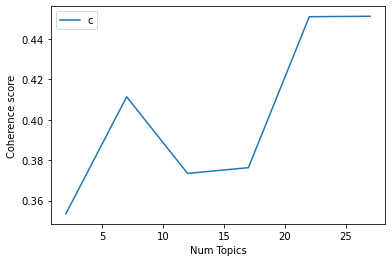

In [56]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_sg_score2)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [57]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_sg_score2):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 22

index: 0 | Num Topics = 2  has Coherence Value of 0.3534
index: 1 | Num Topics = 7  has Coherence Value of 0.4114
index: 2 | Num Topics = 12  has Coherence Value of 0.3734
index: 3 | Num Topics = 17  has Coherence Value of 0.3763
index: 4 | Num Topics = 22  has Coherence Value of 0.4511
index: 5 | Num Topics = 27  has Coherence Value of 0.4513


In [172]:
# Select optimal number of topics
optimal_model_sg_score2 = model_list_sg_score2[4]

In [173]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_sg_score2 = pyLDAvis.gensim_models.prepare(optimal_model_sg_score2, corpus_sg_score2, id2word_sg_score2)

In [174]:
print("pyLDAVis for SG topics for score=2:")
vis_sg_score2

pyLDAVis for SG topics for score=2:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.106309  0.073347       1        1  12.769044
10     0.119985 -0.000257       2        1   8.375385
8      0.059770 -0.139236       3        1   7.627330
2      0.139046 -0.020054       4        1   7.328961
15     0.079516  0.061475       5        1   7.032105
19    -0.053096  0.187271       6        1   6.145624
1     -0.155820  0.106619       7        1   5.458235
17     0.101429  0.080170       8        1   5.342772
0      0.041380 -0.006011       9        1   4.913086
6     -0.079085  0.053128      10        1   4.559270
7      0.058641 -0.008320      11        1   4.138485
20    -0.084320 -0.156623      12        1   3.762529
16    -0.009376  0.020308      13        1   3.392095
3     -0.101643 -0.020884      14        1   3.354036
4      0.071175 -0.008481      15        1   2.634365
18     0.001391 -0.061586      16        1   2.347356
12    -0.003584 -0.048408      17        1   2.226839
14    -0.021938  0.013602      18        1   2.124524
9     -0.073492 -0.035753      19        1   1.823598
13    -0.106686 -0.009173      20        1   1.733870
21    -0.021659 -0.035096      21        1   1.722380
11    -0.067944 -0.046037      22        1   1.188113, topic_info=        Term       Freq      Total Category  logprob  loglift
0         ad  16.000000  16.000000  Default  30.0000  30.0000
28    update  13.000000  13.000000  Default  29.0000  29.0000
9      watch  20.000000  20.000000  Default  28.0000  28.0000
8      video  45.000000  45.000000  Default  27.0000  27.0000
36       fix  14.000000  14.000000  Default  26.0000  26.0000
..       ...        ...        ...      ...      ...      ...
290  essence   0.019026   1.417142  Topic22  -6.4085   0.1222
293     miss   0.019026   1.417142  Topic22  -6.4085   0.1222
175      new   0.019026   5.037419  Topic22  -6.4085  -1.1461
289    chunk   0.019026   1.417142  Topic22  -6.4085   0.1222
254    whole   0.019026   2.092171  Topic22  -6.4085  -0.2674

[946 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
10        3  0.499073          able
10       16  0.499073          able
73        9  0.733355        access
344      18  0.828906  accidentally
365       3  0.664288       account
...     ...       ...           ...
340      11  0.750694            xs
399       5  0.695638          year
96        5  0.695638     yesterday
242       8  0.723349           yet
223       1  0.664244      youtuber

[739 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 11, 9, 3, 16, 20, 2, 18, 1, 7, 8, 21, 17, 4, 5, 19, 13, 15, 10, 14, 22, 12])

## LDA Topic Modelling (Rating = 3)

In [175]:
# By-rating Topic Modelling - rating = 3
# Convert to list - move to each section
review_sg_score3 = youtube_ios_sg_review_YearMonth_score3.review.values.tolist()
review_words_sg_score3 = list(sent_to_words(review_sg_score3))
print(review_words_sg_score3[:1])

[['did', 'all', 'remove', 'the', 'download', 'videos', 'offline', 'feature', 'for', 'this', 'app', 'why', 'wasn', 'this', 'on', 'the', 'update', 'logs']]


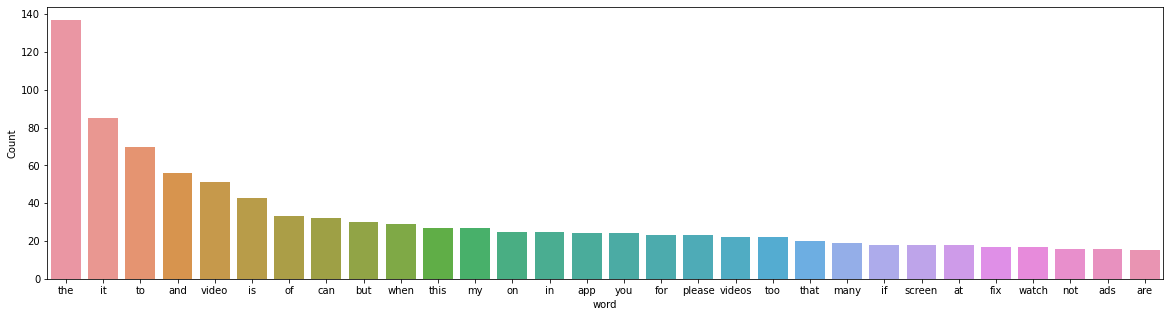

In [176]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_sg_score3))

In [63]:
# Clean text
review_sg_ready_score3 = process_words(review_words_sg_score3)  # processed Text Data! - move to each section


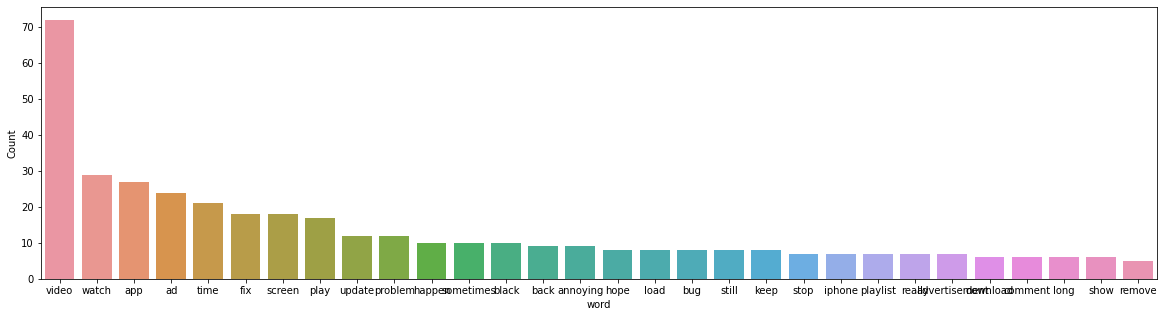

In [64]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_sg_ready_score3))


In [65]:
# Create Dictionary
id2word_sg_score3 = corpora.Dictionary(review_sg_ready_score3)

2021-10-16 23:40:19,242 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 23:40:19,249 [INFO] gensim.corpora.dictionary - built Dictionary(438 unique tokens: ['app', 'download', 'feature', 'log', 'offline']...) from 106 documents (total 1050 corpus positions)
2021-10-16 23:40:19,252 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(438 unique tokens: ['app', 'download', 'feature', 'log', 'offline']...) from 106 documents (total 1050 corpus positions)", 'datetime': '2021-10-16T23:40:19.251931', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [66]:
# Create Corpus: Term Document Frequency
corpus_sg_score3 = [id2word_sg_score3.doc2bow(text) for text in review_sg_ready_score3]

In [67]:
# Training LDA model
model_list_sg_score3, coherence_values_sg_score3 = compute_coherence_values(dictionary=id2word_sg_score3, corpus=corpus_sg_score3, 
                                                              texts=review_sg_ready_score3, limit=30, start=2, step=5)


2021-10-16 23:40:19,281 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 23:40:19,286 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 23:40:19,290 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 23:40:19,292 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 106 documents, updating model once every 106 documents, evaluating perplexity every 106 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 23:40:19,845 [INFO] gensim.models.ldamodel - -6.805 per-word bound, 111.8 perplexity estimate based on a held-out corpus of 106 documents with 1050 words
2021-10-16 23:40:19,849 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #106/106
2021-10-16 23:40:20,208 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.055*"video" + 0.025*"watch" + 0.023*"ad" + 0.019*"app" + 0.018*"screen" + 0.017*"play" + 0.012*"time" 

2021-10-16 23:40:23,174 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.040*"video" + 0.018*"app" + 0.018*"fix" + 0.017*"time" + 0.011*"watch" + 0.011*"playlist" + 0.009*"bug" + 0.008*"channel" + 0.008*"view" + 0.007*"add"
2021-10-16 23:40:23,182 [INFO] gensim.models.ldamodel - topic diff=0.016002, rho=0.301511
2021-10-16 23:40:23,322 [INFO] gensim.models.ldamodel - -5.939 per-word bound, 61.3 perplexity estimate based on a held-out corpus of 106 documents with 1050 words
2021-10-16 23:40:23,323 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #106/106
2021-10-16 23:40:23,388 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.056*"video" + 0.029*"ad" + 0.027*"watch" + 0.022*"screen" + 0.020*"play" + 0.019*"app" + 0.013*"time" + 0.013*"update" + 0.012*"sometimes" + 0.012*"black"
2021-10-16 23:40:23,390 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.040*"video" + 0.018*"app" + 0.018*"fix" + 0.017*"time" + 0.012*"watch" + 0.011*"playlist" + 0.009*"bug" + 0.008*"cha

2021-10-16 23:40:25,546 [INFO] gensim.models.ldamodel - topic diff=0.001568, rho=0.218218
2021-10-16 23:40:25,690 [INFO] gensim.models.ldamodel - -5.934 per-word bound, 61.1 perplexity estimate based on a held-out corpus of 106 documents with 1050 words
2021-10-16 23:40:25,692 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #106/106
2021-10-16 23:40:25,798 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.055*"video" + 0.029*"ad" + 0.027*"watch" + 0.022*"screen" + 0.021*"play" + 0.020*"app" + 0.013*"time" + 0.013*"update" + 0.012*"black" + 0.012*"sometimes"
2021-10-16 23:40:25,802 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.041*"video" + 0.018*"app" + 0.017*"fix" + 0.017*"time" + 0.012*"watch" + 0.012*"playlist" + 0.009*"bug" + 0.009*"channel" + 0.009*"view" + 0.008*"add"
2021-10-16 23:40:25,805 [INFO] gensim.models.ldamodel - topic diff=0.001297, rho=0.213201
2021-10-16 23:40:25,982 [INFO] gensim.models.ldamodel - -5.934 per-word bound, 61.1 perplexity estimat

2021-10-16 23:40:28,349 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #106/106
2021-10-16 23:40:28,454 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.055*"video" + 0.029*"ad" + 0.026*"watch" + 0.022*"screen" + 0.021*"play" + 0.020*"app" + 0.013*"time" + 0.013*"update" + 0.012*"black" + 0.012*"sometimes"
2021-10-16 23:40:28,456 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.041*"video" + 0.018*"app" + 0.017*"fix" + 0.017*"time" + 0.012*"watch" + 0.012*"playlist" + 0.009*"bug" + 0.009*"channel" + 0.009*"view" + 0.008*"add"
2021-10-16 23:40:28,459 [INFO] gensim.models.ldamodel - topic diff=0.000338, rho=0.176777
2021-10-16 23:40:28,525 [INFO] gensim.models.ldamodel - -5.934 per-word bound, 61.1 perplexity estimate based on a held-out corpus of 106 documents with 1050 words
2021-10-16 23:40:28,526 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #106/106
2021-10-16 23:40:28,612 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.055*"video" + 0.029*

2021-10-16 23:40:30,938 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.041*"video" + 0.018*"app" + 0.017*"fix" + 0.017*"time" + 0.012*"watch" + 0.012*"playlist" + 0.009*"bug" + 0.009*"channel" + 0.009*"view" + 0.008*"add"
2021-10-16 23:40:30,939 [INFO] gensim.models.ldamodel - topic diff=0.000182, rho=0.154303
2021-10-16 23:40:31,096 [INFO] gensim.models.ldamodel - -5.934 per-word bound, 61.1 perplexity estimate based on a held-out corpus of 106 documents with 1050 words
2021-10-16 23:40:31,099 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #106/106
2021-10-16 23:40:31,209 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.055*"video" + 0.029*"ad" + 0.026*"watch" + 0.022*"screen" + 0.021*"play" + 0.020*"app" + 0.013*"time" + 0.013*"update" + 0.012*"black" + 0.012*"sometimes"
2021-10-16 23:40:31,210 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.041*"video" + 0.018*"app" + 0.017*"fix" + 0.017*"time" + 0.012*"watch" + 0.012*"playlist" + 0.009*"bug" + 0.009*"cha

2021-10-16 23:40:38,032 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 98 virtual documents
2021-10-16 23:40:38,533 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-16 23:40:38,535 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
2021-10-16 23:40:38,538 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 23:40:38,540 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 7 topics, 50 passes over the supplied corpus of 106 documents, updating model once every 106 documents, evaluating perplexity every 106 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 23:40:38,828 [INFO] gensim.models.ldamodel - -9.477 per-word bound, 712.8 perplexity estimate based on a held-out corpus of 106 documents with 1050 words
2021-10-16 23:40:38,830 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #106/106
2021-10-16 23:40:

2021-10-16 23:40:39,917 [INFO] gensim.models.ldamodel - topic diff=0.025927, rho=0.408248
2021-10-16 23:40:40,068 [INFO] gensim.models.ldamodel - -6.300 per-word bound, 78.8 perplexity estimate based on a held-out corpus of 106 documents with 1050 words
2021-10-16 23:40:40,069 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #106/106
2021-10-16 23:40:40,111 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.054*"video" + 0.036*"time" + 0.024*"fix" + 0.019*"playlist" + 0.019*"add" + 0.018*"multiple" + 0.013*"cause" + 0.013*"year" + 0.013*"play" + 0.013*"advert"
2021-10-16 23:40:40,113 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.045*"video" + 0.020*"app" + 0.020*"delete" + 0.020*"view" + 0.020*"really" + 0.020*"iphone" + 0.013*"switch" + 0.013*"install" + 0.013*"much" + 0.013*"look"
2021-10-16 23:40:40,116 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.047*"video" + 0.031*"watch" + 0.025*"app" + 0.021*"ad" + 0.018*"hope" + 0.018*"play" + 0.014*"remove" + 0.010*

2021-10-16 23:40:41,196 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.044*"video" + 0.020*"app" + 0.020*"delete" + 0.020*"view" + 0.020*"really" + 0.020*"iphone" + 0.014*"switch" + 0.014*"much" + 0.014*"install" + 0.014*"look"
2021-10-16 23:40:41,197 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.054*"video" + 0.036*"time" + 0.024*"fix" + 0.019*"playlist" + 0.019*"add" + 0.019*"multiple" + 0.013*"cause" + 0.013*"year" + 0.013*"play" + 0.013*"advert"
2021-10-16 23:40:41,198 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.047*"video" + 0.031*"watch" + 0.025*"app" + 0.021*"ad" + 0.019*"hope" + 0.018*"play" + 0.014*"remove" + 0.010*"time" + 0.010*"record" + 0.010*"quality"
2021-10-16 23:40:41,199 [INFO] gensim.models.ldamodel - topic diff=0.003674, rho=0.288675
2021-10-16 23:40:41,327 [INFO] gensim.models.ldamodel - -6.292 per-word bound, 78.4 perplexity estimate based on a held-out corpus of 106 documents with 1050 words
2021-10-16 23:40:41,329 [INFO] gensim.models.ldamodel

2021-10-16 23:40:42,194 [INFO] gensim.models.ldamodel - topic diff=0.001198, rho=0.242536
2021-10-16 23:40:42,333 [INFO] gensim.models.ldamodel - -6.291 per-word bound, 78.3 perplexity estimate based on a held-out corpus of 106 documents with 1050 words
2021-10-16 23:40:42,334 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #106/106
2021-10-16 23:40:42,380 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.070*"video" + 0.056*"ad" + 0.046*"watch" + 0.031*"download" + 0.023*"sometimes" + 0.017*"play" + 0.016*"screen" + 0.016*"offline" + 0.011*"black" + 0.011*"whenever"
2021-10-16 23:40:42,382 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.047*"video" + 0.030*"watch" + 0.025*"app" + 0.021*"ad" + 0.019*"hope" + 0.018*"play" + 0.014*"remove" + 0.010*"bug" + 0.010*"time" + 0.010*"record"
2021-10-16 23:40:42,386 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.054*"video" + 0.036*"time" + 0.024*"fix" + 0.019*"add" + 0.019*"playlist" + 0.019*"multiple" + 0.013*"cause" 

2021-10-16 23:40:43,443 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.046*"app" + 0.029*"screen" + 0.029*"time" + 0.026*"stop" + 0.025*"ad" + 0.022*"update" + 0.019*"black" + 0.019*"annoying" + 0.019*"back" + 0.018*"happen"
2021-10-16 23:40:43,445 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.047*"video" + 0.030*"watch" + 0.025*"app" + 0.021*"ad" + 0.019*"hope" + 0.018*"play" + 0.014*"remove" + 0.010*"keep" + 0.010*"bug" + 0.010*"issue"
2021-10-16 23:40:43,446 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.067*"video" + 0.023*"screen" + 0.020*"fix" + 0.020*"problem" + 0.020*"watch" + 0.017*"app" + 0.013*"still" + 0.013*"bug" + 0.013*"scroll" + 0.013*"play"
2021-10-16 23:40:43,447 [INFO] gensim.models.ldamodel - topic diff=0.000343, rho=0.208514
2021-10-16 23:40:43,512 [INFO] gensim.models.ldamodel - -6.291 per-word bound, 78.3 perplexity estimate based on a held-out corpus of 106 documents with 1050 words
2021-10-16 23:40:43,513 [INFO] gensim.models.ldamodel - PROGRESS

2021-10-16 23:40:44,439 [INFO] gensim.models.ldamodel - topic diff=0.000119, rho=0.188982
2021-10-16 23:40:44,572 [INFO] gensim.models.ldamodel - -6.291 per-word bound, 78.3 perplexity estimate based on a held-out corpus of 106 documents with 1050 words
2021-10-16 23:40:44,573 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #106/106
2021-10-16 23:40:44,700 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.044*"video" + 0.020*"view" + 0.020*"iphone" + 0.020*"really" + 0.020*"delete" + 0.020*"app" + 0.014*"look" + 0.014*"search" + 0.014*"much" + 0.014*"switch"
2021-10-16 23:40:44,703 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.067*"video" + 0.023*"screen" + 0.020*"fix" + 0.020*"problem" + 0.020*"watch" + 0.017*"app" + 0.013*"still" + 0.013*"bug" + 0.013*"scroll" + 0.013*"play"
2021-10-16 23:40:44,705 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.054*"video" + 0.036*"time" + 0.024*"fix" + 0.019*"add" + 0.019*"playlist" + 0.019*"multiple" + 0.013*"cause" + 0.

2021-10-16 23:40:45,676 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.047*"video" + 0.030*"watch" + 0.025*"app" + 0.021*"ad" + 0.019*"hope" + 0.018*"play" + 0.014*"remove" + 0.010*"keep" + 0.010*"issue" + 0.010*"bug"
2021-10-16 23:40:45,681 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.044*"video" + 0.020*"view" + 0.020*"iphone" + 0.020*"really" + 0.020*"delete" + 0.020*"app" + 0.014*"look" + 0.014*"search" + 0.014*"much" + 0.014*"switch"
2021-10-16 23:40:45,687 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.067*"video" + 0.023*"screen" + 0.020*"fix" + 0.020*"problem" + 0.020*"watch" + 0.017*"app" + 0.013*"still" + 0.013*"bug" + 0.013*"scroll" + 0.013*"play"
2021-10-16 23:40:45,692 [INFO] gensim.models.ldamodel - topic diff=0.000036, rho=0.171499
2021-10-16 23:40:45,750 [INFO] gensim.models.ldamodel - -6.291 per-word bound, 78.3 perplexity estimate based on a held-out corpus of 106 documents with 1050 words
2021-10-16 23:40:45,771 [INFO] gensim.models.ldamodel - PROGRE

2021-10-16 23:40:46,745 [INFO] gensim.models.ldamodel - topic diff=0.000014, rho=0.160128
2021-10-16 23:40:46,832 [INFO] gensim.models.ldamodel - -6.291 per-word bound, 78.3 perplexity estimate based on a held-out corpus of 106 documents with 1050 words
2021-10-16 23:40:46,834 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #106/106
2021-10-16 23:40:46,888 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.046*"app" + 0.029*"screen" + 0.029*"time" + 0.026*"stop" + 0.025*"ad" + 0.022*"update" + 0.019*"black" + 0.019*"back" + 0.019*"annoying" + 0.018*"happen"
2021-10-16 23:40:46,889 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.046*"video" + 0.040*"advertisement" + 0.020*"play" + 0.014*"channel" + 0.014*"middle" + 0.014*"audio" + 0.014*"song" + 0.014*"watch" + 0.014*"picture" + 0.014*"ad"
2021-10-16 23:40:46,894 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.054*"video" + 0.036*"time" + 0.024*"fix" + 0.019*"add" + 0.019*"playlist" + 0.019*"multiple" + 0.013*"ca

2021-10-16 23:40:47,927 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.067*"video" + 0.023*"screen" + 0.020*"fix" + 0.020*"problem" + 0.020*"watch" + 0.017*"app" + 0.013*"still" + 0.013*"bug" + 0.013*"scroll" + 0.013*"play"
2021-10-16 23:40:47,931 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.046*"video" + 0.040*"advertisement" + 0.020*"play" + 0.014*"channel" + 0.014*"middle" + 0.014*"audio" + 0.014*"song" + 0.014*"watch" + 0.014*"picture" + 0.014*"ad"
2021-10-16 23:40:47,935 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.044*"video" + 0.020*"view" + 0.020*"iphone" + 0.020*"really" + 0.020*"delete" + 0.020*"app" + 0.014*"look" + 0.014*"search" + 0.014*"much" + 0.014*"guy"
2021-10-16 23:40:47,938 [INFO] gensim.models.ldamodel - topic diff=0.000005, rho=0.149071
2021-10-16 23:40:48,079 [INFO] gensim.models.ldamodel - -6.291 per-word bound, 78.3 perplexity estimate based on a held-out corpus of 106 documents with 1050 words
2021-10-16 23:40:48,080 [INFO] gensim.models.lda

2021-10-16 23:40:49,000 [INFO] gensim.models.ldamodel - topic diff=0.000002, rho=0.141421
2021-10-16 23:40:49,195 [INFO] gensim.models.ldamodel - -6.291 per-word bound, 78.3 perplexity estimate based on a held-out corpus of 106 documents with 1050 words
2021-10-16 23:40:49,196 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #106/106
2021-10-16 23:40:49,239 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.054*"video" + 0.036*"time" + 0.024*"fix" + 0.019*"add" + 0.019*"playlist" + 0.019*"multiple" + 0.013*"cause" + 0.013*"year" + 0.013*"play" + 0.013*"advert"
2021-10-16 23:40:49,242 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.067*"video" + 0.023*"screen" + 0.020*"fix" + 0.020*"problem" + 0.020*"watch" + 0.017*"app" + 0.013*"still" + 0.013*"bug" + 0.013*"scroll" + 0.013*"play"
2021-10-16 23:40:49,246 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.071*"video" + 0.056*"ad" + 0.046*"watch" + 0.031*"download" + 0.023*"sometimes" + 0.017*"play" + 0.016*"offline" 

2021-10-16 23:40:57,028 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.041*"time" + 0.036*"video" + 0.031*"screen" + 0.023*"download" + 0.023*"app" + 0.020*"watch" + 0.018*"keep" + 0.017*"still" + 0.015*"black" + 0.013*"fine"
2021-10-16 23:40:57,029 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.052*"video" + 0.023*"ad" + 0.022*"comment" + 0.022*"less" + 0.022*"small" + 0.011*"sometimes" + 0.011*"square" + 0.011*"focus" + 0.011*"really" + 0.011*"minimize"
2021-10-16 23:40:57,031 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.066*"ad" + 0.042*"annoying" + 0.034*"stop" + 0.032*"app" + 0.026*"back" + 0.022*"video" + 0.018*"great" + 0.018*"comment" + 0.018*"entertainment" + 0.018*"load"
2021-10-16 23:40:57,032 [INFO] gensim.models.ldamodel - topic diff=0.059500, rho=0.447214
2021-10-16 23:40:57,137 [INFO] gensim.models.ldamodel - -6.479 per-word bound, 89.2 perplexity estimate based on a held-out corpus of 106 documents with 1050 words
2021-10-16 23:40:57,139 [INFO] gensim.m

2021-10-16 23:40:58,097 [INFO] gensim.models.ldamodel - topic diff=0.011840, rho=0.316228
2021-10-16 23:40:58,208 [INFO] gensim.models.ldamodel - -6.451 per-word bound, 87.5 perplexity estimate based on a held-out corpus of 106 documents with 1050 words
2021-10-16 23:40:58,209 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #106/106
2021-10-16 23:40:58,261 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.061*"watch" + 0.030*"sometimes" + 0.022*"app" + 0.021*"record" + 0.021*"fps" + 0.020*"issue" + 0.017*"video" + 0.015*"fix" + 0.011*"vid" + 0.011*"build"
2021-10-16 23:40:58,283 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.080*"video" + 0.040*"watch" + 0.033*"app" + 0.027*"update" + 0.020*"ad" + 0.020*"reminder" + 0.020*"fix" + 0.014*"problem" + 0.014*"load" + 0.014*"time"
2021-10-16 23:40:58,296 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.024*"advertisement" + 0.024*"anymore" + 0.024*"much" + 0.024*"enjoy" + 0.024*"song" + 0.024*"listen" + 0.024*"ad" + 0

2021-10-16 23:40:59,331 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.080*"ad" + 0.046*"annoying" + 0.037*"stop" + 0.028*"app" + 0.028*"back" + 0.019*"great" + 0.019*"entertainment" + 0.019*"comment" + 0.019*"slow" + 0.019*"load"
2021-10-16 23:40:59,332 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.024*"advertisement" + 0.024*"anymore" + 0.024*"much" + 0.024*"enjoy" + 0.024*"song" + 0.024*"listen" + 0.024*"relax" + 0.024*"service" + 0.024*"ad" + 0.002*"scroll"
2021-10-16 23:40:59,333 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.119*"video" + 0.048*"play" + 0.037*"fix" + 0.019*"later" + 0.019*"audio" + 0.019*"hope" + 0.013*"app" + 0.013*"problem" + 0.013*"music" + 0.013*"press"
2021-10-16 23:40:59,334 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.053*"video" + 0.022*"ad" + 0.022*"comment" + 0.022*"small" + 0.022*"less" + 0.011*"sometimes" + 0.011*"block" + 0.011*"bar" + 0.011*"big" + 0.011*"really"
2021-10-16 23:40:59,335 [INFO] gensim.models.ldamodel - topic d

2021-10-16 23:41:00,378 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.038*"video" + 0.026*"show" + 0.026*"picture" + 0.013*"much" + 0.013*"app" + 0.013*"time" + 0.013*"change" + 0.013*"well" + 0.013*"sometimes" + 0.013*"whenever"
2021-10-16 23:41:00,379 [INFO] gensim.models.ldamodel - topic diff=0.001028, rho=0.218218
2021-10-16 23:41:00,456 [INFO] gensim.models.ldamodel - -6.445 per-word bound, 87.1 perplexity estimate based on a held-out corpus of 106 documents with 1050 words
2021-10-16 23:41:00,458 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #106/106
2021-10-16 23:41:00,583 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.080*"video" + 0.040*"watch" + 0.034*"app" + 0.027*"update" + 0.020*"reminder" + 0.020*"ad" + 0.020*"fix" + 0.014*"problem" + 0.014*"load" + 0.014*"time"
2021-10-16 23:41:00,584 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.038*"video" + 0.026*"show" + 0.026*"picture" + 0.013*"much" + 0.013*"app" + 0.013*"time" + 0.013*"change" + 0

2021-10-16 23:41:01,701 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.062*"watch" + 0.031*"sometimes" + 0.023*"app" + 0.021*"record" + 0.021*"fps" + 0.021*"issue" + 0.014*"fix" + 0.014*"video" + 0.011*"vid" + 0.011*"kind"
2021-10-16 23:41:01,702 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.080*"video" + 0.040*"watch" + 0.034*"app" + 0.027*"update" + 0.020*"reminder" + 0.020*"ad" + 0.020*"fix" + 0.014*"problem" + 0.014*"load" + 0.014*"time"
2021-10-16 23:41:01,703 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.050*"video" + 0.042*"ad" + 0.039*"watch" + 0.036*"black" + 0.034*"app" + 0.028*"playlist" + 0.027*"fix" + 0.026*"screen" + 0.021*"happen" + 0.019*"close"
2021-10-16 23:41:01,705 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.121*"video" + 0.050*"play" + 0.037*"fix" + 0.019*"later" + 0.019*"audio" + 0.019*"hope" + 0.013*"app" + 0.013*"problem" + 0.013*"music" + 0.013*"look"
2021-10-16 23:41:01,737 [INFO] gensim.models.ldamodel - topic diff=0.000358, rho=0.1

2021-10-16 23:41:02,833 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.050*"video" + 0.042*"ad" + 0.039*"watch" + 0.036*"black" + 0.034*"app" + 0.028*"playlist" + 0.027*"fix" + 0.026*"screen" + 0.021*"happen" + 0.019*"close"
2021-10-16 23:41:02,834 [INFO] gensim.models.ldamodel - topic diff=0.000144, rho=0.176777
2021-10-16 23:41:02,970 [INFO] gensim.models.ldamodel - -6.445 per-word bound, 87.1 perplexity estimate based on a held-out corpus of 106 documents with 1050 words
2021-10-16 23:41:02,973 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #106/106
2021-10-16 23:41:03,075 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.082*"ad" + 0.046*"annoying" + 0.037*"stop" + 0.028*"app" + 0.028*"back" + 0.019*"comment" + 0.019*"great" + 0.019*"entertainment" + 0.019*"slow" + 0.019*"load"
2021-10-16 23:41:03,076 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.024*"advertisement" + 0.024*"anymore" + 0.024*"enjoy" + 0.024*"much" + 0.024*"song" + 0.024*"listen" + 0.02

2021-10-16 23:41:04,059 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.082*"ad" + 0.046*"annoying" + 0.037*"stop" + 0.028*"app" + 0.028*"back" + 0.019*"great" + 0.019*"comment" + 0.019*"entertainment" + 0.019*"slow" + 0.019*"load"
2021-10-16 23:41:04,060 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.024*"advertisement" + 0.024*"anymore" + 0.024*"enjoy" + 0.024*"much" + 0.024*"song" + 0.024*"listen" + 0.024*"relax" + 0.024*"service" + 0.024*"ad" + 0.002*"scroll"
2021-10-16 23:41:04,062 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.062*"video" + 0.031*"screen" + 0.025*"watch" + 0.025*"fix" + 0.019*"time" + 0.019*"playlist" + 0.013*"app" + 0.013*"channel" + 0.013*"happen" + 0.013*"update"
2021-10-16 23:41:04,063 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.042*"time" + 0.036*"video" + 0.032*"screen" + 0.024*"app" + 0.024*"download" + 0.021*"watch" + 0.018*"keep" + 0.018*"still" + 0.017*"black" + 0.012*"annoying"
2021-10-16 23:41:04,064 [INFO] gensim.models.ldamodel

2021-10-16 23:41:05,247 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.121*"video" + 0.051*"play" + 0.037*"fix" + 0.019*"later" + 0.019*"audio" + 0.019*"hope" + 0.013*"app" + 0.013*"problem" + 0.013*"music" + 0.013*"look"
2021-10-16 23:41:05,253 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.023*"video" + 0.022*"really" + 0.020*"time" + 0.015*"play" + 0.015*"happen" + 0.015*"view" + 0.015*"background" + 0.015*"cause" + 0.015*"app" + 0.015*"look"
2021-10-16 23:41:05,259 [INFO] gensim.models.ldamodel - topic diff=0.000023, rho=0.152499
2021-10-16 23:41:05,335 [INFO] gensim.models.ldamodel - -6.445 per-word bound, 87.1 perplexity estimate based on a held-out corpus of 106 documents with 1050 words
2021-10-16 23:41:05,338 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #106/106
2021-10-16 23:41:05,474 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.024*"advertisement" + 0.024*"anymore" + 0.024*"enjoy" + 0.024*"much" + 0.024*"song" + 0.024*"listen" + 0.024*"rel

2021-10-16 23:41:06,580 [INFO] gensim.models.ldamodel - PROGRESS: pass 47, at document #106/106
2021-10-16 23:41:06,681 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.121*"video" + 0.051*"play" + 0.037*"fix" + 0.019*"later" + 0.019*"audio" + 0.019*"hope" + 0.013*"problem" + 0.013*"music" + 0.013*"look" + 0.013*"new"
2021-10-16 23:41:06,697 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.053*"video" + 0.022*"ad" + 0.022*"comment" + 0.022*"small" + 0.022*"less" + 0.011*"sometimes" + 0.011*"block" + 0.011*"bar" + 0.011*"big" + 0.011*"really"
2021-10-16 23:41:06,698 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.042*"time" + 0.036*"video" + 0.032*"screen" + 0.024*"app" + 0.024*"download" + 0.021*"watch" + 0.018*"keep" + 0.018*"still" + 0.017*"black" + 0.012*"sometimes"
2021-10-16 23:41:06,700 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.062*"video" + 0.031*"screen" + 0.025*"watch" + 0.025*"fix" + 0.019*"time" + 0.019*"playlist" + 0.013*"channel" + 0.013*"update" + 0.0

2021-10-16 23:41:15,491 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.060*"reminder" + 0.060*"video" + 0.041*"set" + 0.041*"time" + 0.041*"ad" + 0.021*"tap" + 0.021*"always" + 0.021*"almost" + 0.021*"retry" + 0.021*"reset"
2021-10-16 23:41:15,493 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.036*"app" + 0.034*"time" + 0.027*"video" + 0.025*"download" + 0.022*"utube" + 0.022*"back" + 0.020*"watch" + 0.019*"long" + 0.015*"fine" + 0.015*"guy"
2021-10-16 23:41:15,495 [INFO] gensim.models.ldamodel - topic diff=0.048424, rho=0.577350
2021-10-16 23:41:15,597 [INFO] gensim.models.ldamodel - -6.669 per-word bound, 101.7 perplexity estimate based on a held-out corpus of 106 documents with 1050 words
2021-10-16 23:41:15,598 [INFO] gensim.models.ldamodel - PROGRESS: pass 2, at document #106/106
2021-10-16 23:41:15,703 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.062*"video" + 0.033*"time" + 0.031*"play" + 0.031*"ad" + 0.021*"app" + 0.019*"really" + 0.018*"stop" + 0.016*"happen

2021-10-16 23:41:16,719 [INFO] gensim.models.ldamodel - -6.585 per-word bound, 96.0 perplexity estimate based on a held-out corpus of 106 documents with 1050 words
2021-10-16 23:41:16,720 [INFO] gensim.models.ldamodel - PROGRESS: pass 7, at document #106/106
2021-10-16 23:41:16,855 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.035*"app" + 0.035*"time" + 0.028*"video" + 0.028*"download" + 0.021*"back" + 0.021*"utube" + 0.021*"watch" + 0.021*"long" + 0.014*"update" + 0.014*"fine"
2021-10-16 23:41:16,856 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.035*"advertisement" + 0.018*"time" + 0.018*"difficult" + 0.018*"platform" + 0.018*"refresh" + 0.018*"maybe" + 0.018*"several" + 0.018*"usually" + 0.018*"choose" + 0.018*"otherwise"
2021-10-16 23:41:16,861 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.059*"video" + 0.033*"screen" + 0.028*"black" + 0.028*"fix" + 0.019*"hope" + 0.019*"happen" + 0.019*"app" + 0.014*"sometimes" + 0.014*"big" + 0.014*"issue"
2021-10-16 23:41:16,86

2021-10-16 23:41:17,961 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.093*"video" + 0.035*"app" + 0.035*"load" + 0.035*"slow" + 0.024*"play" + 0.024*"audio" + 0.024*"update" + 0.024*"watch" + 0.012*"fix" + 0.012*"default"
2021-10-16 23:41:17,999 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.059*"video" + 0.033*"screen" + 0.028*"black" + 0.028*"fix" + 0.019*"hope" + 0.019*"happen" + 0.019*"app" + 0.014*"sometimes" + 0.014*"big" + 0.014*"cause"
2021-10-16 23:41:18,045 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.080*"video" + 0.044*"watch" + 0.027*"freeze" + 0.027*"scroll" + 0.027*"bug" + 0.027*"play" + 0.027*"ad" + 0.018*"problem" + 0.018*"screen" + 0.018*"playlist"
2021-10-16 23:41:18,051 [INFO] gensim.models.ldamodel - topic diff=0.003567, rho=0.267261
2021-10-16 23:41:18,128 [INFO] gensim.models.ldamodel - -6.577 per-word bound, 95.5 perplexity estimate based on a held-out corpus of 106 documents with 1050 words
2021-10-16 23:41:18,130 [INFO] gensim.models.ldamod

2021-10-16 23:41:19,130 [INFO] gensim.models.ldamodel - topic diff=0.002371, rho=0.229416
2021-10-16 23:41:19,221 [INFO] gensim.models.ldamodel - -6.575 per-word bound, 95.3 perplexity estimate based on a held-out corpus of 106 documents with 1050 words
2021-10-16 23:41:19,223 [INFO] gensim.models.ldamodel - PROGRESS: pass 18, at document #106/106
2021-10-16 23:41:19,329 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.059*"video" + 0.033*"screen" + 0.028*"black" + 0.028*"fix" + 0.019*"happen" + 0.019*"hope" + 0.019*"app" + 0.014*"sometimes" + 0.014*"big" + 0.014*"problem"
2021-10-16 23:41:19,333 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.057*"watch" + 0.057*"video" + 0.029*"app" + 0.029*"fix" + 0.029*"mode" + 0.029*"channel" + 0.029*"sometimes" + 0.029*"still" + 0.019*"restricted" + 0.019*"appear"
2021-10-16 23:41:19,334 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.080*"video" + 0.044*"watch" + 0.027*"scroll" + 0.027*"freeze" + 0.027*"bug" + 0.027*"play" + 0.027*"

2021-10-16 23:41:20,300 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.043*"watch" + 0.043*"video" + 0.036*"screen" + 0.036*"time" + 0.029*"app" + 0.022*"fix" + 0.022*"playlist" + 0.015*"problem" + 0.015*"refresh" + 0.015*"bug"
2021-10-16 23:41:20,303 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.059*"video" + 0.037*"time" + 0.029*"play" + 0.029*"ad" + 0.022*"really" + 0.022*"stop" + 0.018*"app" + 0.015*"happen" + 0.015*"multiple" + 0.015*"picture"
2021-10-16 23:41:20,305 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.021*"country" + 0.021*"video" + 0.021*"date" + 0.021*"event" + 0.021*"find" + 0.021*"idea" + 0.021*"informative" + 0.021*"current" + 0.021*"place" + 0.021*"world"
2021-10-16 23:41:20,306 [INFO] gensim.models.ldamodel - topic diff=0.000990, rho=0.200000
2021-10-16 23:41:20,472 [INFO] gensim.models.ldamodel - -6.570 per-word bound, 95.0 perplexity estimate based on a held-out corpus of 106 documents with 1050 words
2021-10-16 23:41:20,473 [INFO] gensim.mode

2021-10-16 23:41:21,461 [INFO] gensim.models.ldamodel - topic diff=0.000675, rho=0.182574
2021-10-16 23:41:21,522 [INFO] gensim.models.ldamodel - -6.568 per-word bound, 94.9 perplexity estimate based on a held-out corpus of 106 documents with 1050 words
2021-10-16 23:41:21,524 [INFO] gensim.models.ldamodel - PROGRESS: pass 29, at document #106/106
2021-10-16 23:41:21,613 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.034*"advertisement" + 0.018*"time" + 0.018*"platform" + 0.018*"maybe" + 0.018*"keep" + 0.018*"usually" + 0.018*"track" + 0.018*"several" + 0.018*"well" + 0.018*"difficult"
2021-10-16 23:41:21,615 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.025*"skip" + 0.025*"advertisement" + 0.025*"long" + 0.025*"upset" + 0.025*"quite" + 0.025*"much" + 0.025*"recommendation" + 0.025*"fine" + 0.025*"inappropriate" + 0.025*"video"
2021-10-16 23:41:21,617 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.087*"video" + 0.037*"load" + 0.037*"slow" + 0.026*"app" + 0.025*"play" +

2021-10-16 23:41:22,868 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.042*"remove" + 0.042*"way" + 0.028*"ad" + 0.022*"disturb" + 0.022*"unnecessary" + 0.022*"watch" + 0.022*"vidz" + 0.022*"music" + 0.022*"listening" + 0.022*"upgrade"
2021-10-16 23:41:22,873 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.059*"video" + 0.033*"screen" + 0.028*"black" + 0.028*"fix" + 0.019*"happen" + 0.019*"hope" + 0.019*"app" + 0.014*"sometimes" + 0.014*"big" + 0.014*"cause"
2021-10-16 23:41:22,876 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.080*"video" + 0.044*"watch" + 0.027*"scroll" + 0.027*"freeze" + 0.027*"bug" + 0.027*"play" + 0.027*"ad" + 0.018*"problem" + 0.018*"screen" + 0.018*"new"
2021-10-16 23:41:22,877 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.059*"video" + 0.037*"time" + 0.030*"play" + 0.030*"ad" + 0.022*"really" + 0.022*"stop" + 0.017*"app" + 0.015*"happen" + 0.015*"multiple" + 0.015*"picture"
2021-10-16 23:41:22,878 [INFO] gensim.models.ldamodel - topic diff

2021-10-16 23:41:24,089 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.049*"ad" + 0.033*"video" + 0.017*"app" + 0.017*"annoy" + 0.017*"new" + 0.017*"still" + 0.017*"overall" + 0.017*"nature" + 0.017*"time" + 0.017*"layout"
2021-10-16 23:41:24,090 [INFO] gensim.models.ldamodel - topic diff=0.000229, rho=0.156174
2021-10-16 23:41:24,203 [INFO] gensim.models.ldamodel - -6.567 per-word bound, 94.8 perplexity estimate based on a held-out corpus of 106 documents with 1050 words
2021-10-16 23:41:24,205 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #106/106
2021-10-16 23:41:24,361 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.086*"video" + 0.037*"load" + 0.037*"slow" + 0.025*"app" + 0.025*"play" + 0.025*"audio" + 0.013*"update" + 0.013*"watch" + 0.013*"time" + 0.013*"full"
2021-10-16 23:41:24,363 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.033*"momentarily" + 0.033*"lag" + 0.033*"swipe" + 0.033*"minimise" + 0.033*"video" + 0.033*"ui" + 0.002*"instead" + 0.

2021-10-16 23:41:25,880 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.043*"watch" + 0.043*"video" + 0.036*"screen" + 0.036*"time" + 0.029*"app" + 0.022*"fix" + 0.022*"playlist" + 0.015*"feed" + 0.015*"problem" + 0.015*"thing"
2021-10-16 23:41:25,882 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.080*"video" + 0.044*"watch" + 0.027*"scroll" + 0.027*"freeze" + 0.027*"bug" + 0.027*"play" + 0.027*"ad" + 0.018*"problem" + 0.018*"sometimes" + 0.018*"new"
2021-10-16 23:41:25,883 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.033*"momentarily" + 0.033*"lag" + 0.033*"swipe" + 0.033*"minimise" + 0.033*"video" + 0.033*"ui" + 0.002*"instead" + 0.002*"way" + 0.002*"disturb" + 0.002*"frame"
2021-10-16 23:41:25,885 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.034*"advertisement" + 0.018*"time" + 0.018*"platform" + 0.018*"maybe" + 0.018*"keep" + 0.018*"usually" + 0.018*"track" + 0.018*"several" + 0.018*"well" + 0.018*"difficult"
2021-10-16 23:41:25,886 [INFO] gensim.models.ldamo

2021-10-16 23:41:37,257 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.045454545454545456
2021-10-16 23:41:37,260 [INFO] gensim.models.ldamodel - using symmetric eta at 0.045454545454545456
2021-10-16 23:41:37,263 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 23:41:37,268 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 22 topics, 50 passes over the supplied corpus of 106 documents, updating model once every 106 documents, evaluating perplexity every 106 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 23:41:37,592 [INFO] gensim.models.ldamodel - -22.917 per-word bound, 7921198.0 perplexity estimate based on a held-out corpus of 106 documents with 1050 words
2021-10-16 23:41:37,593 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #106/106
2021-10-16 23:41:37,737 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.048*"really" + 0.033*"look" + 0.032*"delete" + 0.032*"serious

2021-10-16 23:41:38,719 [INFO] gensim.models.ldamodel - topic diff=0.021412, rho=0.408248
2021-10-16 23:41:38,843 [INFO] gensim.models.ldamodel - -6.612 per-word bound, 97.8 perplexity estimate based on a held-out corpus of 106 documents with 1050 words
2021-10-16 23:41:38,845 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #106/106
2021-10-16 23:41:38,958 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.036*"time" + 0.036*"fine" + 0.036*"app" + 0.036*"video" + 0.024*"guy" + 0.024*"update" + 0.024*"iphone" + 0.024*"hope" + 0.024*"annoying" + 0.012*"really"
2021-10-16 23:41:38,959 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.034*"advertisement" + 0.034*"app" + 0.017*"unable" + 0.017*"switch" + 0.017*"account" + 0.017*"stop" + 0.017*"negative" + 0.017*"phone" + 0.017*"delete" + 0.017*"sponsor"
2021-10-16 23:41:38,961 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.055*"app" + 0.037*"video" + 0.019*"bar" + 0.019*"resolution" + 0.019*"extra" + 0.019*"slow" + 0.

2021-10-16 23:41:40,349 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.034*"momentarily" + 0.034*"lag" + 0.034*"minimise" + 0.034*"ui" + 0.034*"swipe" + 0.034*"much" + 0.034*"video" + 0.034*"song" + 0.034*"relax" + 0.034*"listen"
2021-10-16 23:41:40,352 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.110*"video" + 0.063*"play" + 0.032*"happen" + 0.032*"time" + 0.032*"watch" + 0.016*"close" + 0.016*"app" + 0.016*"ad" + 0.016*"black" + 0.016*"pop"
2021-10-16 23:41:40,354 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.031*"really" + 0.031*"app" + 0.031*"comment" + 0.031*"great" + 0.031*"ad" + 0.031*"show" + 0.031*"interrupt" + 0.031*"read" + 0.031*"however" + 0.031*"back"
2021-10-16 23:41:40,356 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.034*"advertisement" + 0.034*"app" + 0.017*"account" + 0.017*"unable" + 0.017*"switch" + 0.017*"fix" + 0.017*"install" + 0.017*"video" + 0.017*"view" + 0.017*"delete"
2021-10-16 23:41:40,357 [INFO] gensim.models.ldamodel - topic di

2021-10-16 23:41:41,546 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.040*"video" + 0.040*"ad" + 0.027*"advert" + 0.027*"cause" + 0.027*"entertainment" + 0.027*"stop" + 0.027*"small" + 0.014*"black" + 0.014*"screen" + 0.014*"sometimes"
2021-10-16 23:41:41,547 [INFO] gensim.models.ldamodel - topic diff=0.000938, rho=0.242536
2021-10-16 23:41:41,731 [INFO] gensim.models.ldamodel - -6.600 per-word bound, 97.0 perplexity estimate based on a held-out corpus of 106 documents with 1050 words
2021-10-16 23:41:41,732 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #106/106
2021-10-16 23:41:41,832 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.110*"video" + 0.063*"play" + 0.032*"happen" + 0.032*"watch" + 0.032*"time" + 0.016*"black" + 0.016*"pop" + 0.016*"screen" + 0.016*"almost" + 0.016*"close"
2021-10-16 23:41:41,834 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.032*"annoy" + 0.032*"layout" + 0.032*"still" + 0.032*"ad" + 0.032*"new" + 0.032*"overall" + 0.032*

2021-10-16 23:41:43,052 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.110*"video" + 0.063*"play" + 0.032*"happen" + 0.032*"time" + 0.032*"watch" + 0.016*"screen" + 0.016*"choose" + 0.016*"back" + 0.016*"almost" + 0.016*"pop"
2021-10-16 23:41:43,054 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.036*"time" + 0.036*"app" + 0.036*"video" + 0.036*"fine" + 0.024*"guy" + 0.024*"hope" + 0.024*"update" + 0.024*"iphone" + 0.024*"annoying" + 0.012*"second"
2021-10-16 23:41:43,056 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.058*"video" + 0.042*"screen" + 0.032*"problem" + 0.032*"play" + 0.027*"hope" + 0.021*"black" + 0.021*"fix" + 0.016*"happen" + 0.016*"still" + 0.016*"new"
2021-10-16 23:41:43,060 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.038*"middle" + 0.038*"video" + 0.038*"picture" + 0.038*"advertisement" + 0.019*"dion" + 0.019*"ad" + 0.019*"high" + 0.019*"generate" + 0.019*"frustrating" + 0.019*"esp"
2021-10-16 23:41:43,062 [INFO] gensim.models.ldamodel - topic

2021-10-16 23:41:44,083 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.043*"time" + 0.029*"refresh" + 0.029*"problem" + 0.029*"feed" + 0.029*"error" + 0.029*"keep" + 0.029*"black" + 0.029*"fix" + 0.029*"video" + 0.015*"fi"
2021-10-16 23:41:44,085 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.056*"really" + 0.038*"look" + 0.038*"delete" + 0.038*"seriously" + 0.038*"biased" + 0.019*"twitter" + 0.019*"proud" + 0.019*"install" + 0.019*"view" + 0.019*"app"
2021-10-16 23:41:44,086 [INFO] gensim.models.ldamodel - topic diff=0.001613, rho=0.188982
2021-10-16 23:41:44,255 [INFO] gensim.models.ldamodel - -6.600 per-word bound, 97.0 perplexity estimate based on a held-out corpus of 106 documents with 1050 words
2021-10-16 23:41:44,259 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #106/106
2021-10-16 23:41:44,333 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.101*"video" + 0.044*"play" + 0.044*"ad" + 0.029*"fps" + 0.029*"watch" + 0.029*"movie" + 0.029*"update" + 

2021-10-16 23:41:45,181 [INFO] gensim.models.ldamodel - -6.595 per-word bound, 96.7 perplexity estimate based on a held-out corpus of 106 documents with 1050 words
2021-10-16 23:41:45,184 [INFO] gensim.models.ldamodel - PROGRESS: pass 32, at document #106/106
2021-10-16 23:41:45,235 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.088*"video" + 0.065*"playlist" + 0.042*"watch" + 0.028*"screen" + 0.028*"fix" + 0.028*"add" + 0.025*"able" + 0.019*"channel" + 0.019*"app" + 0.019*"black"
2021-10-16 23:41:45,237 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.063*"watch" + 0.042*"sometimes" + 0.024*"ad" + 0.022*"video" + 0.022*"allow" + 0.022*"next" + 0.022*"force" + 0.022*"fix" + 0.022*"finish" + 0.022*"still"
2021-10-16 23:41:45,238 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.058*"video" + 0.042*"screen" + 0.032*"problem" + 0.032*"play" + 0.027*"hope" + 0.021*"black" + 0.021*"fix" + 0.016*"happen" + 0.016*"still" + 0.016*"new"
2021-10-16 23:41:45,241 [INFO] gensim.models.ld

2021-10-16 23:41:46,279 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.053*"app" + 0.053*"annoying" + 0.027*"screen" + 0.027*"open" + 0.027*"always" + 0.027*"crash" + 0.027*"frozen" + 0.027*"terminate" + 0.027*"kind" + 0.027*"reason"
2021-10-16 23:41:46,282 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.034*"video" + 0.034*"ui" + 0.034*"momentarily" + 0.034*"lag" + 0.034*"swipe" + 0.034*"minimise" + 0.034*"song" + 0.034*"relax" + 0.034*"listen" + 0.034*"much"
2021-10-16 23:41:46,285 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.043*"time" + 0.029*"refresh" + 0.029*"problem" + 0.029*"feed" + 0.029*"error" + 0.029*"keep" + 0.029*"black" + 0.029*"fix" + 0.029*"video" + 0.015*"fi"
2021-10-16 23:41:46,287 [INFO] gensim.models.ldamodel - topic diff=0.000520, rho=0.160128
2021-10-16 23:41:46,361 [INFO] gensim.models.ldamodel - -6.592 per-word bound, 96.5 perplexity estimate based on a held-out corpus of 106 documents with 1050 words
2021-10-16 23:41:46,362 [INFO] gensim.model

2021-10-16 23:41:47,254 [INFO] gensim.models.ldamodel - topic diff=0.000445, rho=0.150756
2021-10-16 23:41:47,399 [INFO] gensim.models.ldamodel - -6.591 per-word bound, 96.4 perplexity estimate based on a held-out corpus of 106 documents with 1050 words
2021-10-16 23:41:47,404 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #106/106
2021-10-16 23:41:47,470 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.032*"annoy" + 0.032*"layout" + 0.032*"still" + 0.032*"ad" + 0.032*"new" + 0.032*"overall" + 0.032*"nature" + 0.032*"job" + 0.032*"especially" + 0.032*"business"
2021-10-16 23:41:47,471 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.062*"app" + 0.062*"video" + 0.049*"watch" + 0.025*"restricted" + 0.025*"mode" + 0.025*"back" + 0.025*"download" + 0.025*"update" + 0.013*"turn" + 0.013*"read"
2021-10-16 23:41:47,472 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.052*"ad" + 0.039*"video" + 0.026*"cause" + 0.026*"advert" + 0.026*"entertainment" + 0.026*"stop" + 

2021-10-16 23:41:48,382 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.110*"video" + 0.063*"play" + 0.032*"happen" + 0.032*"time" + 0.032*"watch" + 0.016*"screen" + 0.016*"choose" + 0.016*"back" + 0.016*"almost" + 0.016*"pop"
2021-10-16 23:41:48,383 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.052*"ad" + 0.039*"video" + 0.026*"cause" + 0.026*"advert" + 0.026*"entertainment" + 0.026*"stop" + 0.026*"small" + 0.026*"way" + 0.013*"sometimes" + 0.013*"screen"
2021-10-16 23:41:48,385 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.036*"app" + 0.036*"time" + 0.036*"video" + 0.036*"fine" + 0.024*"guy" + 0.024*"hope" + 0.024*"update" + 0.024*"iphone" + 0.024*"annoying" + 0.012*"second"
2021-10-16 23:41:48,387 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.032*"annoy" + 0.032*"layout" + 0.032*"still" + 0.032*"ad" + 0.032*"new" + 0.032*"overall" + 0.032*"nature" + 0.032*"job" + 0.032*"especially" + 0.032*"business"
2021-10-16 23:41:48,390 [INFO] gensim.models.ldamodel - to

2021-10-16 23:42:00,617 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.042*"guy" + 0.042*"iphone" + 0.041*"video" + 0.035*"hope" + 0.025*"channel" + 0.025*"appear" + 0.025*"however" + 0.025*"block" + 0.025*"enjoy" + 0.025*"keep"
2021-10-16 23:42:00,618 [INFO] gensim.models.ldamodel - topic diff=0.071988, rho=0.500000
2021-10-16 23:42:00,738 [INFO] gensim.models.ldamodel - -6.772 per-word bound, 109.3 perplexity estimate based on a held-out corpus of 106 documents with 1050 words
2021-10-16 23:42:00,739 [INFO] gensim.models.ldamodel - PROGRESS: pass 3, at document #106/106
2021-10-16 23:42:00,854 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.049*"app" + 0.035*"video" + 0.031*"back" + 0.018*"watch" + 0.017*"ad" + 0.017*"fix" + 0.016*"current" + 0.016*"switch" + 0.016*"upload" + 0.016*"interesting"
2021-10-16 23:42:00,855 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.047*"problem" + 0.047*"screen" + 0.038*"video" + 0.029*"bug" + 0.028*"still" + 0.028*"scroll" + 0.020*"r

2021-10-16 23:42:01,912 [INFO] gensim.models.ldamodel - PROGRESS: pass 8, at document #106/106
2021-10-16 23:42:01,990 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.054*"app" + 0.036*"time" + 0.036*"restricted" + 0.036*"mode" + 0.018*"job" + 0.018*"business" + 0.018*"layout" + 0.018*"especially" + 0.018*"nature" + 0.018*"still"
2021-10-16 23:42:01,992 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.045*"ask" + 0.045*"yet" + 0.045*"everytime" + 0.045*"subscribe" + 0.045*"open" + 0.045*"app" + 0.045*"interested" + 0.002*"reopen" + 0.002*"previous" + 0.002*"frame"
2021-10-16 23:42:01,994 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.027*"difficult" + 0.027*"usually" + 0.027*"several" + 0.027*"platform" + 0.027*"maybe" + 0.027*"item" + 0.027*"choose" + 0.027*"otherwise" + 0.027*"change" + 0.027*"track"
2021-10-16 23:42:01,997 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.072*"add" + 0.072*"playlist" + 0.025*"option" + 0.025*"annoy" + 0.025*"allow" + 0.025*"frequent" 

2021-10-16 23:42:03,087 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.072*"add" + 0.072*"playlist" + 0.025*"fix" + 0.025*"allow" + 0.025*"show" + 0.025*"video" + 0.025*"frequent" + 0.025*"annoy" + 0.025*"middle" + 0.025*"option"
2021-10-16 23:42:03,091 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.047*"problem" + 0.047*"screen" + 0.038*"video" + 0.029*"bug" + 0.029*"still" + 0.029*"scroll" + 0.019*"refresh" + 0.019*"feed" + 0.019*"back" + 0.019*"check"
2021-10-16 23:42:03,092 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.054*"app" + 0.036*"time" + 0.036*"restricted" + 0.036*"mode" + 0.018*"new" + 0.018*"overall" + 0.018*"nature" + 0.018*"layout" + 0.018*"job" + 0.018*"especially"
2021-10-16 23:42:03,093 [INFO] gensim.models.ldamodel - topic diff=0.004073, rho=0.258199
2021-10-16 23:42:03,226 [INFO] gensim.models.ldamodel - -6.691 per-word bound, 103.3 perplexity estimate based on a held-out corpus of 106 documents with 1050 words
2021-10-16 23:42:03,227 [INFO] gensim

2021-10-16 23:42:04,216 [INFO] gensim.models.ldamodel - topic diff=0.001416, rho=0.223607
2021-10-16 23:42:04,311 [INFO] gensim.models.ldamodel - -6.688 per-word bound, 103.1 perplexity estimate based on a held-out corpus of 106 documents with 1050 words
2021-10-16 23:42:04,335 [INFO] gensim.models.ldamodel - PROGRESS: pass 19, at document #106/106
2021-10-16 23:42:04,373 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.082*"video" + 0.030*"download" + 0.022*"fix" + 0.022*"happen" + 0.022*"black" + 0.022*"watch" + 0.015*"problem" + 0.015*"hope" + 0.015*"annoying" + 0.015*"fps"
2021-10-16 23:42:04,375 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.046*"guy" + 0.046*"iphone" + 0.046*"video" + 0.046*"hope" + 0.023*"appear" + 0.023*"block" + 0.023*"channel" + 0.023*"homepage" + 0.023*"still" + 0.023*"however"
2021-10-16 23:42:04,377 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.060*"video" + 0.049*"watch" + 0.040*"playlist" + 0.030*"screen" + 0.030*"app" + 0.030*"able" + 0.

2021-10-16 23:42:05,479 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.123*"video" + 0.036*"small" + 0.036*"audio" + 0.036*"play" + 0.018*"big" + 0.018*"first" + 0.018*"sometimes" + 0.018*"bar" + 0.018*"subtitle" + 0.018*"screen"
2021-10-16 23:42:05,481 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.075*"video" + 0.045*"update" + 0.030*"hope" + 0.030*"problem" + 0.030*"app" + 0.030*"play" + 0.030*"late" + 0.030*"movie" + 0.030*"watch" + 0.015*"load"
2021-10-16 23:42:05,484 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.049*"really" + 0.033*"picture" + 0.033*"app" + 0.033*"look" + 0.033*"seriously" + 0.033*"delete" + 0.033*"biased" + 0.017*"screen" + 0.017*"problem" + 0.017*"still"
2021-10-16 23:42:05,485 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.039*"record" + 0.039*"change" + 0.039*"stop" + 0.039*"picture" + 0.020*"vid" + 0.020*"wonder" + 0.020*"guy" + 0.020*"app" + 0.020*"bug" + 0.020*"listen"
2021-10-16 23:42:05,486 [INFO] gensim.models.ldamodel - topic 

2021-10-16 23:42:06,668 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.070*"annoying" + 0.047*"app" + 0.031*"ipad" + 0.024*"back" + 0.024*"top" + 0.024*"ad" + 0.024*"great" + 0.024*"however" + 0.024*"read" + 0.024*"really"
2021-10-16 23:42:06,675 [INFO] gensim.models.ldamodel - topic diff=0.000280, rho=0.179605
2021-10-16 23:42:06,846 [INFO] gensim.models.ldamodel - -6.687 per-word bound, 103.1 perplexity estimate based on a held-out corpus of 106 documents with 1050 words
2021-10-16 23:42:06,848 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #106/106
2021-10-16 23:42:06,966 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.039*"record" + 0.039*"change" + 0.039*"stop" + 0.039*"picture" + 0.020*"vid" + 0.020*"wonder" + 0.020*"guy" + 0.020*"app" + 0.020*"bug" + 0.020*"listen"
2021-10-16 23:42:06,968 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.058*"watch" + 0.058*"video" + 0.039*"sometimes" + 0.020*"force" + 0.020*"fix" + 0.020*"finish" + 0.020*"still" + 0.

2021-10-16 23:42:08,012 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.074*"video" + 0.056*"reminder" + 0.056*"ad" + 0.038*"set" + 0.038*"time" + 0.038*"utube" + 0.019*"title" + 0.019*"live" + 0.019*"possible" + 0.019*"reset"
2021-10-16 23:42:08,021 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.040*"download" + 0.040*"video" + 0.040*"feature" + 0.040*"log" + 0.040*"offline" + 0.040*"remove" + 0.040*"update" + 0.040*"app" + 0.040*"commercial" + 0.040*"irritate"
2021-10-16 23:42:08,024 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.054*"app" + 0.036*"time" + 0.036*"restricted" + 0.036*"mode" + 0.018*"new" + 0.018*"overall" + 0.018*"nature" + 0.018*"layout" + 0.018*"job" + 0.018*"especially"
2021-10-16 23:42:08,027 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.072*"add" + 0.072*"playlist" + 0.025*"fix" + 0.025*"allow" + 0.025*"show" + 0.025*"video" + 0.025*"frequent" + 0.025*"annoy" + 0.025*"long" + 0.025*"middle"
2021-10-16 23:42:08,032 [INFO] gensim.models.ldamo

2021-10-16 23:42:09,119 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.002*"previous" + 0.002*"way" + 0.002*"disturb" + 0.002*"frame" + 0.002*"instead" + 0.002*"listening" + 0.002*"reopen" + 0.002*"crazy" + 0.002*"absolutely" + 0.002*"extremely"
2021-10-16 23:42:09,121 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.051*"time" + 0.051*"app" + 0.034*"fine" + 0.034*"update" + 0.034*"last" + 0.018*"video" + 0.018*"keep" + 0.018*"refreshing" + 0.018*"second" + 0.018*"text"
2021-10-16 23:42:09,123 [INFO] gensim.models.ldamodel - topic diff=0.000038, rho=0.154303
2021-10-16 23:42:09,235 [INFO] gensim.models.ldamodel - -6.687 per-word bound, 103.1 perplexity estimate based on a held-out corpus of 106 documents with 1050 words
2021-10-16 23:42:09,236 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #106/106
2021-10-16 23:42:09,349 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.074*"video" + 0.056*"reminder" + 0.056*"ad" + 0.038*"set" + 0.038*"time" + 0.038*"utube"

2021-10-16 23:42:10,392 [INFO] gensim.models.ldamodel - -6.687 per-word bound, 103.1 perplexity estimate based on a held-out corpus of 106 documents with 1050 words
2021-10-16 23:42:10,393 [INFO] gensim.models.ldamodel - PROGRESS: pass 46, at document #106/106
2021-10-16 23:42:10,442 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.076*"video" + 0.038*"middle" + 0.038*"time" + 0.038*"fix" + 0.019*"song" + 0.019*"note" + 0.019*"begin" + 0.019*"interrupt" + 0.019*"avoid" + 0.019*"watch"
2021-10-16 23:42:10,444 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.075*"video" + 0.045*"update" + 0.030*"hope" + 0.030*"problem" + 0.030*"play" + 0.030*"app" + 0.030*"late" + 0.030*"movie" + 0.030*"watch" + 0.015*"load"
2021-10-16 23:42:10,446 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.039*"record" + 0.039*"change" + 0.039*"stop" + 0.039*"picture" + 0.020*"listen" + 0.020*"wonder" + 0.020*"app" + 0.020*"guy" + 0.020*"watch" + 0.020*"bug"
2021-10-16 23:42:10,451 [INFO] gensim.models

In [68]:
%store model_list_sg_score3
%store coherence_values_sg_score3

Stored 'model_list_sg_score3' (list)
Stored 'coherence_values_sg_score3' (list)


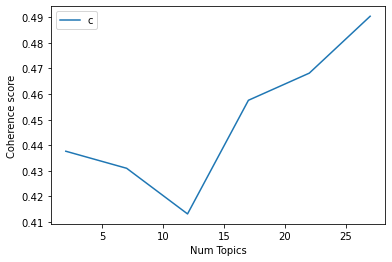

In [69]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_sg_score3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [70]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_sg_score3):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 2

index: 0 | Num Topics = 2  has Coherence Value of 0.4377
index: 1 | Num Topics = 7  has Coherence Value of 0.431
index: 2 | Num Topics = 12  has Coherence Value of 0.4132
index: 3 | Num Topics = 17  has Coherence Value of 0.4576
index: 4 | Num Topics = 22  has Coherence Value of 0.4682
index: 5 | Num Topics = 27  has Coherence Value of 0.4904


In [177]:
# Select optimal number of topics
optimal_model_sg_score3 = model_list_sg_score3[0]

In [178]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_sg_score3 = pyLDAvis.gensim_models.prepare(optimal_model_sg_score3, corpus_sg_score3, id2word_sg_score3)

In [179]:
print("pyLDAVis for SG topics for score=3:")
vis_sg_score3

pyLDAVis for SG topics for score=3:


PreparedData(topic_coordinates=              x    y  topics  cluster      Freq
topic                                          
0      0.080951  0.0       1        1  59.20992
1     -0.080951  0.0       2        1  40.79008, topic_info=         Term       Freq      Total Category  logprob  loglift
36         ad  18.000000  18.000000  Default  30.0000  30.0000
52     screen  13.000000  13.000000  Default  29.0000  29.0000
37       play  13.000000  13.000000  Default  28.0000  28.0000
121  playlist   5.000000   5.000000  Default  27.0000  27.0000
48      black   8.000000   8.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
43       load   2.652917   6.344735   Topic2  -5.0842   0.0248
58    problem   3.007504   9.245874   Topic2  -4.9587  -0.2263
123   comment   2.325543   4.908948   Topic2  -5.2159   0.1496
142    really   2.356544   5.639912   Topic2  -5.2026   0.0241
110      keep   2.365868   6.373005   Topic2  -5.1987  -0.0942

[122 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
118       2  0.736165      able
96        2  0.981543   account
36        1  0.982874        ad
182       1  0.246369       add
182       2  0.985477       add
...     ...       ...       ...
39        1  0.743507     watch
39        2  0.232346     watch
40        1  1.033702  whenever
269       2  0.981567    wonder
54        1  0.915127      work

[110 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

## LDA Topic Modelling (Rating = 4)

In [74]:
# By-rating Topic Modelling - rating = 4
# Convert to list - move to each section
review_sg_score4 = youtube_ios_sg_review_YearMonth_score4.review.values.tolist()
review_words_sg_score4 = list(sent_to_words(review_sg_score4))
print(review_words_sg_score4[2:3])

[['when', 'click', 'on', 'the', 'video', 'the', 'video', 'won', 'load', 'some', 'of', 'the', 'video', 'is', 'fine', 'some', 'are', 'not']]


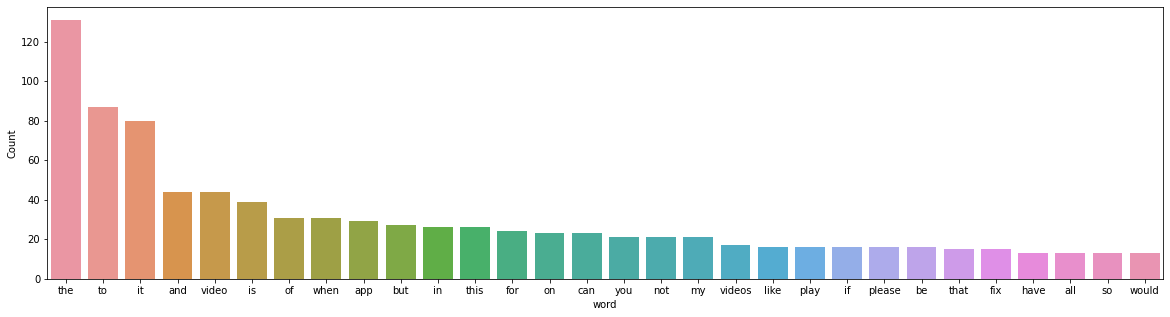

In [75]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_sg_score4))

In [76]:
# Clean text
review_sg_ready_score4 = process_words(review_words_sg_score4)  # processed Text Data! - move to each section

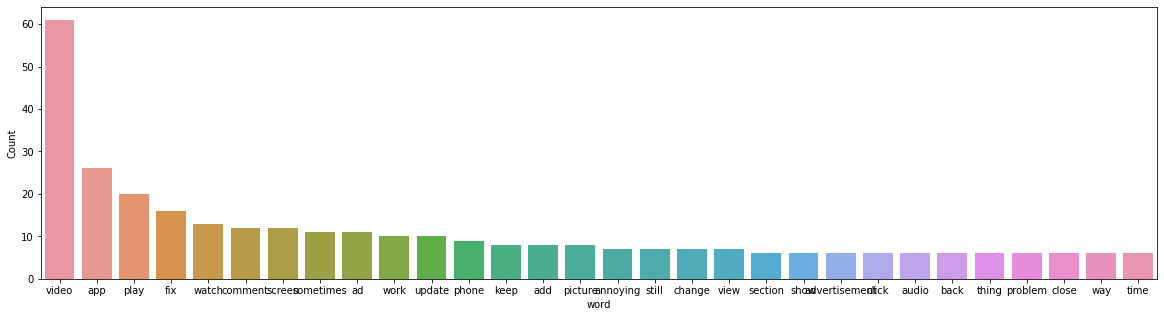

In [77]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_sg_ready_score4))


In [78]:
# Create Dictionary
id2word_sg_score4 = corpora.Dictionary(review_sg_ready_score4)

2021-10-16 23:42:35,269 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 23:42:35,279 [INFO] gensim.corpora.dictionary - built Dictionary(430 unique tokens: ['comment', 'hundred', 'like', 'post', 'section']...) from 106 documents (total 981 corpus positions)
2021-10-16 23:42:35,284 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(430 unique tokens: ['comment', 'hundred', 'like', 'post', 'section']...) from 106 documents (total 981 corpus positions)", 'datetime': '2021-10-16T23:42:35.284257', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [79]:
# Create Corpus: Term Document Frequency
corpus_sg_score4 = [id2word_sg_score4.doc2bow(text) for text in review_sg_ready_score4]

In [80]:
# Training LDA model
model_list_sg_score4, coherence_values_sg_score4 = compute_coherence_values(dictionary=id2word_sg_score4, corpus=corpus_sg_score4, 
                                                              texts=review_sg_ready_score4, limit=30, start=2, step=5)


2021-10-16 23:42:35,339 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 23:42:35,344 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 23:42:35,359 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 23:42:35,366 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 106 documents, updating model once every 106 documents, evaluating perplexity every 106 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 23:42:35,826 [INFO] gensim.models.ldamodel - -6.799 per-word bound, 111.3 perplexity estimate based on a held-out corpus of 106 documents with 981 words
2021-10-16 23:42:35,837 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #106/106
2021-10-16 23:42:36,164 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.029*"video" + 0.029*"app" + 0.015*"screen" + 0.012*"play" + 0.012*"watch" + 0.012*"fix" + 0.011*"someti

2021-10-16 23:42:39,137 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.056*"video" + 0.019*"play" + 0.017*"ad" + 0.010*"annoying" + 0.010*"view" + 0.010*"fix" + 0.010*"thing" + 0.009*"way" + 0.009*"keep" + 0.008*"delete"
2021-10-16 23:42:39,141 [INFO] gensim.models.ldamodel - topic diff=0.008773, rho=0.301511
2021-10-16 23:42:39,377 [INFO] gensim.models.ldamodel - -6.042 per-word bound, 65.9 perplexity estimate based on a held-out corpus of 106 documents with 981 words
2021-10-16 23:42:39,378 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #106/106
2021-10-16 23:42:39,477 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.033*"video" + 0.033*"app" + 0.017*"screen" + 0.014*"fix" + 0.013*"sometimes" + 0.012*"work" + 0.012*"phone" + 0.012*"picture" + 0.011*"watch" + 0.011*"play"
2021-10-16 23:42:39,480 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.056*"video" + 0.019*"play" + 0.017*"ad" + 0.010*"annoying" + 0.010*"view" + 0.010*"fix" + 0.010*"thing" + 0.009*"kee

2021-10-16 23:42:42,352 [INFO] gensim.models.ldamodel - topic diff=0.002109, rho=0.218218
2021-10-16 23:42:42,486 [INFO] gensim.models.ldamodel - -6.039 per-word bound, 65.7 perplexity estimate based on a held-out corpus of 106 documents with 981 words
2021-10-16 23:42:42,488 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #106/106
2021-10-16 23:42:42,602 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.034*"video" + 0.033*"app" + 0.017*"screen" + 0.014*"fix" + 0.014*"sometimes" + 0.012*"work" + 0.012*"phone" + 0.012*"play" + 0.012*"picture" + 0.011*"watch"
2021-10-16 23:42:42,604 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.055*"video" + 0.018*"play" + 0.017*"ad" + 0.010*"annoying" + 0.010*"view" + 0.010*"thing" + 0.010*"fix" + 0.009*"keep" + 0.009*"way" + 0.009*"delete"
2021-10-16 23:42:42,606 [INFO] gensim.models.ldamodel - topic diff=0.001981, rho=0.213201
2021-10-16 23:42:42,734 [INFO] gensim.models.ldamodel - -6.039 per-word bound, 65.7 perplexity estimat

2021-10-16 23:42:45,736 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #106/106
2021-10-16 23:42:45,884 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.034*"video" + 0.033*"app" + 0.017*"screen" + 0.015*"sometimes" + 0.014*"fix" + 0.012*"phone" + 0.012*"work" + 0.012*"play" + 0.012*"picture" + 0.011*"update"
2021-10-16 23:42:45,896 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.055*"video" + 0.018*"play" + 0.017*"ad" + 0.011*"annoying" + 0.011*"view" + 0.010*"fix" + 0.010*"thing" + 0.009*"keep" + 0.009*"delete" + 0.009*"watch"
2021-10-16 23:42:45,902 [INFO] gensim.models.ldamodel - topic diff=0.001350, rho=0.176777
2021-10-16 23:42:46,094 [INFO] gensim.models.ldamodel - -6.038 per-word bound, 65.7 perplexity estimate based on a held-out corpus of 106 documents with 981 words
2021-10-16 23:42:46,095 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #106/106
2021-10-16 23:42:46,225 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.034*"video" + 0.0

2021-10-16 23:42:49,040 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.034*"video" + 0.033*"app" + 0.017*"screen" + 0.015*"sometimes" + 0.014*"fix" + 0.012*"phone" + 0.012*"play" + 0.012*"work" + 0.012*"picture" + 0.011*"update"
2021-10-16 23:42:49,045 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.054*"video" + 0.018*"play" + 0.017*"ad" + 0.011*"view" + 0.011*"annoying" + 0.010*"fix" + 0.010*"thing" + 0.009*"keep" + 0.009*"delete" + 0.009*"watch"
2021-10-16 23:42:49,051 [INFO] gensim.models.ldamodel - topic diff=0.001279, rho=0.154303
2021-10-16 23:42:49,221 [INFO] gensim.models.ldamodel - -6.037 per-word bound, 65.7 perplexity estimate based on a held-out corpus of 106 documents with 981 words
2021-10-16 23:42:49,222 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #106/106
2021-10-16 23:42:49,408 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.034*"video" + 0.033*"app" + 0.017*"screen" + 0.015*"sometimes" + 0.014*"fix" + 0.012*"phone" + 0.012*"play" + 0.0

2021-10-16 23:42:51,662 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 23:42:57,628 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 23:42:57,651 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 90 virtual documents
2021-10-16 23:42:58,078 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-16 23:42:58,079 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
2021-10-16 23:42:58,083 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 23:42:58,086 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 7 topics, 50 passes over the supplied corpus of 106 documents, updating model once every 106 documents, evaluating perplexity every 106 documents, iterating 50x with a conv

2021-10-16 23:42:59,410 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.037*"video" + 0.032*"screen" + 0.029*"app" + 0.028*"picture" + 0.028*"play" + 0.019*"update" + 0.015*"fix" + 0.015*"advertisement" + 0.014*"watch" + 0.010*"open"
2021-10-16 23:42:59,411 [INFO] gensim.models.ldamodel - topic diff=0.021102, rho=0.408248
2021-10-16 23:42:59,536 [INFO] gensim.models.ldamodel - -6.390 per-word bound, 83.8 perplexity estimate based on a held-out corpus of 106 documents with 981 words
2021-10-16 23:42:59,547 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #106/106
2021-10-16 23:42:59,629 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.026*"video" + 0.022*"change" + 0.022*"sometimes" + 0.017*"section" + 0.017*"still" + 0.017*"people" + 0.017*"resolution" + 0.012*"fix" + 0.012*"tap" + 0.012*"issue"
2021-10-16 23:42:59,630 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.037*"video" + 0.032*"screen" + 0.029*"app" + 0.028*"picture" + 0.028*"play" + 0.019*"update" + 0.

2021-10-16 23:43:00,732 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.041*"video" + 0.039*"app" + 0.018*"fix" + 0.018*"live" + 0.013*"comment" + 0.013*"delete" + 0.013*"problem" + 0.013*"scroll" + 0.013*"work" + 0.013*"sometimes"
2021-10-16 23:43:00,734 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.024*"annoying" + 0.018*"view" + 0.018*"add" + 0.018*"watch" + 0.018*"user" + 0.018*"search" + 0.012*"video" + 0.012*"app" + 0.012*"advertisement" + 0.012*"remove"
2021-10-16 23:43:00,735 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.076*"video" + 0.052*"play" + 0.026*"app" + 0.022*"audio" + 0.017*"like" + 0.017*"show" + 0.017*"comment" + 0.017*"upload" + 0.017*"close" + 0.017*"long"
2021-10-16 23:43:00,736 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.025*"video" + 0.023*"change" + 0.021*"sometimes" + 0.017*"section" + 0.017*"still" + 0.017*"people" + 0.017*"resolution" + 0.012*"fix" + 0.012*"tap" + 0.012*"put"
2021-10-16 23:43:00,738 [INFO] gensim.models.ldamodel - t

2021-10-16 23:43:01,796 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.059*"video" + 0.037*"ad" + 0.023*"update" + 0.019*"play" + 0.019*"thing" + 0.014*"quality" + 0.014*"mode" + 0.014*"star" + 0.014*"new" + 0.014*"work"
2021-10-16 23:43:01,798 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.040*"video" + 0.039*"app" + 0.018*"fix" + 0.018*"live" + 0.013*"scroll" + 0.013*"problem" + 0.013*"work" + 0.013*"delete" + 0.013*"comment" + 0.013*"sometimes"
2021-10-16 23:43:01,801 [INFO] gensim.models.ldamodel - topic diff=0.001786, rho=0.242536
2021-10-16 23:43:01,988 [INFO] gensim.models.ldamodel - -6.375 per-word bound, 83.0 perplexity estimate based on a held-out corpus of 106 documents with 981 words
2021-10-16 23:43:01,989 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #106/106
2021-10-16 23:43:02,115 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.053*"video" + 0.021*"fix" + 0.021*"phone" + 0.016*"issue" + 0.015*"keep" + 0.011*"download" + 0.011*"volume" + 0.

2021-10-16 23:43:03,150 [INFO] gensim.models.ldamodel - PROGRESS: pass 21, at document #106/106
2021-10-16 23:43:03,204 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.038*"video" + 0.033*"screen" + 0.029*"app" + 0.029*"picture" + 0.029*"play" + 0.019*"update" + 0.015*"watch" + 0.015*"fix" + 0.015*"advertisement" + 0.010*"open"
2021-10-16 23:43:03,206 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.078*"video" + 0.054*"play" + 0.027*"app" + 0.022*"audio" + 0.017*"like" + 0.017*"show" + 0.017*"comment" + 0.017*"close" + 0.017*"upload" + 0.017*"long"
2021-10-16 23:43:03,208 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.024*"annoying" + 0.018*"add" + 0.018*"view" + 0.018*"watch" + 0.018*"user" + 0.018*"search" + 0.012*"remove" + 0.012*"always" + 0.012*"quite" + 0.012*"select"
2021-10-16 23:43:03,210 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.040*"video" + 0.039*"app" + 0.018*"fix" + 0.018*"live" + 0.013*"scroll" + 0.013*"problem" + 0.013*"work" + 0.013*"delete" + 0.

2021-10-16 23:43:04,263 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.038*"video" + 0.033*"screen" + 0.029*"app" + 0.029*"picture" + 0.029*"play" + 0.019*"update" + 0.015*"watch" + 0.015*"fix" + 0.015*"advertisement" + 0.010*"open"
2021-10-16 23:43:04,268 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.024*"video" + 0.023*"change" + 0.021*"sometimes" + 0.017*"still" + 0.017*"section" + 0.017*"people" + 0.017*"resolution" + 0.012*"fix" + 0.012*"tap" + 0.012*"put"
2021-10-16 23:43:04,270 [INFO] gensim.models.ldamodel - topic diff=0.000217, rho=0.188982
2021-10-16 23:43:04,387 [INFO] gensim.models.ldamodel - -6.374 per-word bound, 83.0 perplexity estimate based on a held-out corpus of 106 documents with 981 words
2021-10-16 23:43:04,388 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #106/106
2021-10-16 23:43:04,496 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.024*"video" + 0.023*"change" + 0.021*"sometimes" + 0.017*"still" + 0.017*"section" + 0.017*"people

2021-10-16 23:43:05,728 [INFO] gensim.models.ldamodel - PROGRESS: pass 32, at document #106/106
2021-10-16 23:43:05,777 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.038*"video" + 0.033*"screen" + 0.029*"app" + 0.029*"picture" + 0.029*"play" + 0.019*"update" + 0.015*"watch" + 0.015*"fix" + 0.015*"advertisement" + 0.010*"open"
2021-10-16 23:43:05,779 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.024*"annoying" + 0.018*"add" + 0.018*"watch" + 0.018*"view" + 0.018*"user" + 0.018*"search" + 0.012*"remove" + 0.012*"always" + 0.012*"quite" + 0.012*"select"
2021-10-16 23:43:05,781 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.059*"video" + 0.037*"ad" + 0.023*"update" + 0.019*"thing" + 0.019*"play" + 0.014*"quality" + 0.014*"mode" + 0.014*"star" + 0.014*"new" + 0.014*"work"
2021-10-16 23:43:05,785 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.053*"video" + 0.021*"fix" + 0.021*"phone" + 0.016*"issue" + 0.014*"keep" + 0.011*"way" + 0.011*"click" + 0.011*"download" + 0.011

2021-10-16 23:43:06,975 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.059*"video" + 0.037*"ad" + 0.023*"update" + 0.019*"thing" + 0.019*"play" + 0.014*"quality" + 0.014*"mode" + 0.014*"star" + 0.014*"new" + 0.014*"work"
2021-10-16 23:43:06,976 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.038*"video" + 0.033*"screen" + 0.029*"app" + 0.029*"picture" + 0.029*"play" + 0.019*"update" + 0.015*"watch" + 0.015*"fix" + 0.015*"advertisement" + 0.010*"open"
2021-10-16 23:43:06,977 [INFO] gensim.models.ldamodel - topic diff=0.000027, rho=0.160128
2021-10-16 23:43:07,099 [INFO] gensim.models.ldamodel - -6.374 per-word bound, 83.0 perplexity estimate based on a held-out corpus of 106 documents with 981 words
2021-10-16 23:43:07,100 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #106/106
2021-10-16 23:43:07,144 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.038*"video" + 0.033*"screen" + 0.029*"app" + 0.029*"picture" + 0.029*"play" + 0.019*"update" + 0.015*"watch" + 

2021-10-16 23:43:08,115 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #106/106
2021-10-16 23:43:08,228 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.040*"video" + 0.039*"app" + 0.018*"fix" + 0.018*"live" + 0.013*"scroll" + 0.013*"problem" + 0.013*"work" + 0.013*"delete" + 0.013*"comment" + 0.013*"stream"
2021-10-16 23:43:08,229 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.024*"video" + 0.023*"change" + 0.021*"sometimes" + 0.017*"still" + 0.017*"section" + 0.017*"people" + 0.017*"resolution" + 0.012*"fix" + 0.012*"tap" + 0.012*"put"
2021-10-16 23:43:08,230 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.038*"video" + 0.033*"screen" + 0.029*"app" + 0.029*"picture" + 0.029*"play" + 0.019*"update" + 0.015*"watch" + 0.015*"fix" + 0.015*"advertisement" + 0.010*"open"
2021-10-16 23:43:08,231 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.053*"video" + 0.021*"fix" + 0.021*"phone" + 0.016*"issue" + 0.014*"keep" + 0.011*"way" + 0.011*"click" + 0.011*"commen

2021-10-16 23:43:09,268 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.040*"video" + 0.039*"app" + 0.018*"fix" + 0.018*"live" + 0.013*"scroll" + 0.013*"problem" + 0.013*"work" + 0.013*"delete" + 0.013*"comment" + 0.013*"stream"
2021-10-16 23:43:09,269 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.024*"video" + 0.023*"change" + 0.021*"sometimes" + 0.017*"still" + 0.017*"section" + 0.017*"people" + 0.017*"resolution" + 0.012*"fix" + 0.012*"tap" + 0.012*"put"
2021-10-16 23:43:09,270 [INFO] gensim.models.ldamodel - topic diff=0.000004, rho=0.141421
2021-10-16 23:43:09,362 [INFO] gensim.models.ldamodel - -6.374 per-word bound, 83.0 perplexity estimate based on a held-out corpus of 106 documents with 981 words
2021-10-16 23:43:09,363 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #106/106
2021-10-16 23:43:09,403 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.078*"video" + 0.054*"play" + 0.027*"app" + 0.022*"audio" + 0.017*"like" + 0.017*"show" + 0.017*"comment

2021-10-16 23:43:16,867 [INFO] gensim.models.ldamodel - PROGRESS: pass 3, at document #106/106
2021-10-16 23:43:16,985 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.025*"poll" + 0.025*"hope" + 0.025*"music" + 0.025*"fix" + 0.025*"vote" + 0.025*"listen" + 0.025*"app" + 0.025*"video" + 0.002*"back" + 0.002*"order"
2021-10-16 23:43:16,988 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.029*"video" + 0.029*"pro" + 0.028*"amazing" + 0.028*"yt" + 0.027*"reupload" + 0.015*"star" + 0.015*"problem" + 0.015*"update" + 0.015*"great" + 0.015*"relate"
2021-10-16 23:43:16,990 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.054*"play" + 0.048*"picture" + 0.043*"video" + 0.042*"app" + 0.028*"screen" + 0.021*"advertisement" + 0.021*"sound" + 0.021*"problem" + 0.021*"update" + 0.014*"feature"
2021-10-16 23:43:16,994 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.071*"video" + 0.023*"play" + 0.023*"screen" + 0.022*"app" + 0.022*"phone" + 0.022*"fix" + 0.022*"sometimes" + 0.022*"still" 

2021-10-16 23:43:18,356 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.046*"change" + 0.039*"video" + 0.028*"people" + 0.028*"stream" + 0.019*"sometimes" + 0.019*"delete" + 0.019*"put" + 0.019*"view" + 0.019*"quality" + 0.010*"watch"
2021-10-16 23:43:18,358 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.065*"video" + 0.017*"time" + 0.017*"download" + 0.017*"ad" + 0.017*"restart" + 0.017*"decide" + 0.009*"low" + 0.009*"switch" + 0.009*"high" + 0.009*"thing"
2021-10-16 23:43:18,360 [INFO] gensim.models.ldamodel - topic diff=0.008289, rho=0.316228
2021-10-16 23:43:18,412 [INFO] gensim.models.ldamodel - -6.522 per-word bound, 91.9 perplexity estimate based on a held-out corpus of 106 documents with 981 words
2021-10-16 23:43:18,414 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #106/106
2021-10-16 23:43:18,455 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.032*"app" + 0.027*"comment" + 0.022*"live" + 0.022*"video" + 0.021*"fix" + 0.016*"way" + 0.016*"watch" + 

2021-10-16 23:43:19,394 [INFO] gensim.models.ldamodel - PROGRESS: pass 14, at document #106/106
2021-10-16 23:43:19,442 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.024*"view" + 0.024*"user" + 0.024*"app" + 0.016*"advertisement" + 0.016*"annoying" + 0.016*"video" + 0.016*"feature" + 0.016*"search" + 0.016*"upload" + 0.016*"remove"
2021-10-16 23:43:19,444 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.055*"play" + 0.048*"picture" + 0.048*"video" + 0.041*"app" + 0.028*"screen" + 0.021*"advertisement" + 0.021*"problem" + 0.021*"sound" + 0.021*"update" + 0.014*"work"
2021-10-16 23:43:19,448 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.082*"video" + 0.069*"play" + 0.042*"ad" + 0.035*"audio" + 0.026*"mode" + 0.026*"update" + 0.018*"close" + 0.018*"dark" + 0.018*"extra" + 0.018*"open"
2021-10-16 23:43:19,450 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.025*"fix" + 0.025*"hope" + 0.025*"music" + 0.025*"poll" + 0.025*"vote" + 0.025*"listen" + 0.025*"app" + 0.025*"video

2021-10-16 23:43:20,573 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.046*"change" + 0.038*"video" + 0.028*"people" + 0.028*"stream" + 0.019*"sometimes" + 0.019*"delete" + 0.019*"put" + 0.019*"view" + 0.019*"quality" + 0.010*"watch"
2021-10-16 23:43:20,579 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.030*"video" + 0.029*"pro" + 0.029*"amazing" + 0.029*"yt" + 0.029*"reupload" + 0.028*"star" + 0.015*"io" + 0.015*"update" + 0.015*"give" + 0.015*"problem"
2021-10-16 23:43:20,584 [INFO] gensim.models.ldamodel - topic diff=0.000740, rho=0.218218
2021-10-16 23:43:20,663 [INFO] gensim.models.ldamodel - -6.518 per-word bound, 91.7 perplexity estimate based on a held-out corpus of 106 documents with 981 words
2021-10-16 23:43:20,665 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #106/106
2021-10-16 23:43:20,782 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.039*"video" + 0.031*"back" + 0.023*"annoying" + 0.023*"long" + 0.016*"ad" + 0.016*"thing" + 0.016*"resolu

2021-10-16 23:43:21,839 [INFO] gensim.models.ldamodel - PROGRESS: pass 25, at document #106/106
2021-10-16 23:43:21,974 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.056*"video" + 0.038*"comment" + 0.038*"like" + 0.029*"watch" + 0.019*"show" + 0.019*"sometimes" + 0.019*"turn" + 0.019*"delete" + 0.019*"child" + 0.019*"option"
2021-10-16 23:43:21,976 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.025*"fix" + 0.025*"hope" + 0.025*"music" + 0.025*"vote" + 0.025*"poll" + 0.025*"listen" + 0.025*"app" + 0.025*"video" + 0.002*"back" + 0.002*"order"
2021-10-16 23:43:21,977 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.058*"video" + 0.017*"time" + 0.017*"download" + 0.017*"restart" + 0.017*"decide" + 0.009*"ad" + 0.009*"exact" + 0.009*"thing" + 0.009*"reopen" + 0.009*"low"
2021-10-16 23:43:21,978 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.039*"video" + 0.031*"back" + 0.023*"annoying" + 0.023*"long" + 0.016*"ad" + 0.016*"thing" + 0.016*"resolution" + 0.016*"still" + 0.

2021-10-16 23:43:22,986 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.058*"video" + 0.017*"time" + 0.017*"download" + 0.017*"restart" + 0.017*"decide" + 0.009*"ad" + 0.009*"exact" + 0.009*"reopen" + 0.009*"thing" + 0.009*"low"
2021-10-16 23:43:22,987 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.032*"video" + 0.032*"app" + 0.021*"scroll" + 0.021*"sometimes" + 0.021*"press" + 0.021*"recommendation" + 0.011*"fix" + 0.011*"phone" + 0.011*"work" + 0.011*"screen"
2021-10-16 23:43:22,989 [INFO] gensim.models.ldamodel - topic diff=0.000131, rho=0.176777
2021-10-16 23:43:23,102 [INFO] gensim.models.ldamodel - -6.518 per-word bound, 91.6 perplexity estimate based on a held-out corpus of 106 documents with 981 words
2021-10-16 23:43:23,104 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #106/106
2021-10-16 23:43:23,139 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.056*"video" + 0.038*"comment" + 0.038*"like" + 0.029*"watch" + 0.019*"show" + 0.019*"turn" + 0.019*

2021-10-16 23:43:24,099 [INFO] gensim.models.ldamodel - PROGRESS: pass 36, at document #106/106
2021-10-16 23:43:24,139 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.056*"video" + 0.038*"comment" + 0.038*"like" + 0.029*"watch" + 0.019*"show" + 0.019*"sometimes" + 0.019*"turn" + 0.019*"delete" + 0.019*"child" + 0.019*"option"
2021-10-16 23:43:24,141 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.024*"view" + 0.024*"user" + 0.024*"app" + 0.016*"annoying" + 0.016*"feature" + 0.016*"search" + 0.016*"remove" + 0.016*"upload" + 0.016*"advertisement" + 0.016*"phrase"
2021-10-16 23:43:24,145 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.030*"video" + 0.029*"pro" + 0.029*"amazing" + 0.029*"yt" + 0.029*"reupload" + 0.029*"star" + 0.015*"io" + 0.015*"update" + 0.015*"give" + 0.015*"problem"
2021-10-16 23:43:24,146 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.085*"video" + 0.069*"play" + 0.043*"ad" + 0.035*"audio" + 0.026*"mode" + 0.026*"update" + 0.018*"close" + 0.018*"da

2021-10-16 23:43:25,485 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.032*"app" + 0.032*"video" + 0.021*"scroll" + 0.021*"sometimes" + 0.021*"press" + 0.021*"recommendation" + 0.011*"fix" + 0.011*"phone" + 0.011*"work" + 0.011*"screen"
2021-10-16 23:43:25,487 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.025*"fix" + 0.025*"hope" + 0.025*"music" + 0.025*"vote" + 0.025*"poll" + 0.025*"listen" + 0.025*"app" + 0.025*"video" + 0.002*"back" + 0.002*"order"
2021-10-16 23:43:25,489 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.071*"video" + 0.029*"fix" + 0.022*"screen" + 0.022*"phone" + 0.022*"play" + 0.022*"still" + 0.022*"app" + 0.022*"sometimes" + 0.022*"load" + 0.015*"watch"
2021-10-16 23:43:25,495 [INFO] gensim.models.ldamodel - topic diff=0.000019, rho=0.152499
2021-10-16 23:43:25,634 [INFO] gensim.models.ldamodel - -6.518 per-word bound, 91.6 perplexity estimate based on a held-out corpus of 106 documents with 981 words
2021-10-16 23:43:25,635 [INFO] gensim.models.ldam

2021-10-16 23:43:26,961 [INFO] gensim.models.ldamodel - topic diff=0.000008, rho=0.144338
2021-10-16 23:43:27,030 [INFO] gensim.models.ldamodel - -6.518 per-word bound, 91.6 perplexity estimate based on a held-out corpus of 106 documents with 981 words
2021-10-16 23:43:27,032 [INFO] gensim.models.ldamodel - PROGRESS: pass 47, at document #106/106
2021-10-16 23:43:27,136 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.025*"fix" + 0.025*"hope" + 0.025*"music" + 0.025*"vote" + 0.025*"poll" + 0.025*"listen" + 0.025*"app" + 0.025*"video" + 0.002*"back" + 0.002*"order"
2021-10-16 23:43:27,137 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.030*"video" + 0.029*"pro" + 0.029*"amazing" + 0.029*"yt" + 0.029*"reupload" + 0.029*"star" + 0.015*"io" + 0.015*"update" + 0.015*"work" + 0.015*"give"
2021-10-16 23:43:27,139 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.058*"video" + 0.017*"time" + 0.017*"download" + 0.017*"decide" + 0.017*"restart" + 0.009*"ad" + 0.009*"keep" + 0.009*"espec

2021-10-16 23:43:36,861 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.049*"video" + 0.040*"app" + 0.030*"sound" + 0.030*"fix" + 0.020*"change" + 0.020*"sometimes" + 0.020*"open" + 0.020*"user" + 0.010*"picture" + 0.010*"intermittent"
2021-10-16 23:43:36,863 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.102*"video" + 0.057*"play" + 0.028*"comment" + 0.022*"view" + 0.022*"update" + 0.017*"show" + 0.017*"like" + 0.017*"watch" + 0.013*"sometimes" + 0.012*"random"
2021-10-16 23:43:36,864 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.040*"close" + 0.040*"app" + 0.032*"live" + 0.032*"video" + 0.032*"play" + 0.024*"audio" + 0.024*"ad" + 0.024*"hate" + 0.021*"much" + 0.016*"chat"
2021-10-16 23:43:36,866 [INFO] gensim.models.ldamodel - topic diff=0.035617, rho=0.577350
2021-10-16 23:43:36,918 [INFO] gensim.models.ldamodel - -6.637 per-word bound, 99.5 perplexity estimate based on a held-out corpus of 106 documents with 981 words
2021-10-16 23:43:36,919 [INFO] gensim.models.ld

2021-10-16 23:43:37,869 [INFO] gensim.models.ldamodel - topic diff=0.008903, rho=0.353553
2021-10-16 23:43:38,006 [INFO] gensim.models.ldamodel - -6.595 per-word bound, 96.7 perplexity estimate based on a held-out corpus of 106 documents with 981 words
2021-10-16 23:43:38,008 [INFO] gensim.models.ldamodel - PROGRESS: pass 7, at document #106/106
2021-10-16 23:43:38,118 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.049*"picture" + 0.049*"screen" + 0.049*"app" + 0.025*"scroll" + 0.017*"update" + 0.017*"currently" + 0.017*"exit" + 0.017*"favorite" + 0.017*"fix" + 0.017*"problem"
2021-10-16 23:43:38,121 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.035*"auto" + 0.035*"advertisement" + 0.035*"back" + 0.035*"play" + 0.018*"add" + 0.018*"pay" + 0.018*"interruption" + 0.018*"layer" + 0.018*"previous" + 0.018*"content"
2021-10-16 23:43:38,125 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.073*"video" + 0.021*"thing" + 0.021*"download" + 0.021*"button" + 0.021*"decide" + 0.011*

2021-10-16 23:43:39,150 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.032*"phrase" + 0.032*"search" + 0.032*"user" + 0.032*"lyric" + 0.032*"add" + 0.032*"watch" + 0.016*"exist" + 0.016*"bug" + 0.016*"replace" + 0.016*"long"
2021-10-16 23:43:39,155 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.073*"video" + 0.021*"thing" + 0.021*"button" + 0.021*"download" + 0.021*"decide" + 0.011*"fix" + 0.011*"high" + 0.011*"switch" + 0.011*"start" + 0.011*"quality"
2021-10-16 23:43:39,158 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.049*"picture" + 0.049*"screen" + 0.049*"app" + 0.025*"scroll" + 0.017*"update" + 0.017*"currently" + 0.017*"exit" + 0.017*"favorite" + 0.017*"fix" + 0.017*"problem"
2021-10-16 23:43:39,162 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.118*"video" + 0.059*"play" + 0.027*"comment" + 0.022*"view" + 0.022*"update" + 0.016*"watch" + 0.016*"like" + 0.016*"show" + 0.016*"click" + 0.012*"sometimes"
2021-10-16 23:43:39,164 [INFO] gensim.models.ldamodel - 

2021-10-16 23:43:40,118 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.118*"video" + 0.059*"play" + 0.027*"comment" + 0.022*"update" + 0.022*"view" + 0.016*"watch" + 0.016*"like" + 0.016*"show" + 0.016*"click" + 0.012*"sometimes"
2021-10-16 23:43:40,125 [INFO] gensim.models.ldamodel - topic diff=0.000856, rho=0.229416
2021-10-16 23:43:40,232 [INFO] gensim.models.ldamodel - -6.585 per-word bound, 96.0 perplexity estimate based on a held-out corpus of 106 documents with 981 words
2021-10-16 23:43:40,233 [INFO] gensim.models.ldamodel - PROGRESS: pass 18, at document #106/106
2021-10-16 23:43:40,283 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.040*"people" + 0.040*"app" + 0.030*"video" + 0.030*"keep" + 0.030*"ad" + 0.020*"comment" + 0.020*"restart" + 0.020*"read" + 0.020*"phone" + 0.020*"sometimes"
2021-10-16 23:43:40,285 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.029*"volume" + 0.029*"issue" + 0.029*"phone" + 0.029*"video" + 0.029*"screen" + 0.029*"keep" + 0.029*"fix

2021-10-16 23:43:41,265 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.118*"video" + 0.059*"play" + 0.027*"comment" + 0.022*"update" + 0.022*"view" + 0.016*"watch" + 0.016*"like" + 0.016*"show" + 0.016*"click" + 0.012*"sometimes"
2021-10-16 23:43:41,270 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.032*"appear" + 0.032*"delete" + 0.032*"view" + 0.032*"stream" + 0.016*"unresponsive" + 0.016*"select" + 0.016*"app" + 0.016*"button" + 0.016*"allow" + 0.016*"comment"
2021-10-16 23:43:41,272 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.033*"frequent" + 0.033*"work" + 0.033*"refresh" + 0.033*"become" + 0.033*"annoying" + 0.033*"update" + 0.033*"still" + 0.002*"user" + 0.002*"diameter" + 0.002*"flow"
2021-10-16 23:43:41,274 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.042*"video" + 0.042*"fix" + 0.042*"load" + 0.021*"error" + 0.021*"tap" + 0.021*"app" + 0.021*"sometimes" + 0.021*"randomly" + 0.021*"wifi" + 0.021*"retry"
2021-10-16 23:43:41,278 [INFO] gensim.models.l

2021-10-16 23:43:42,370 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.032*"phrase" + 0.032*"search" + 0.032*"user" + 0.032*"lyric" + 0.032*"add" + 0.032*"watch" + 0.016*"bug" + 0.016*"ever" + 0.016*"long" + 0.016*"exist"
2021-10-16 23:43:42,371 [INFO] gensim.models.ldamodel - topic diff=0.000110, rho=0.182574
2021-10-16 23:43:42,491 [INFO] gensim.models.ldamodel - -6.585 per-word bound, 96.0 perplexity estimate based on a held-out corpus of 106 documents with 981 words
2021-10-16 23:43:42,492 [INFO] gensim.models.ldamodel - PROGRESS: pass 29, at document #106/106
2021-10-16 23:43:42,529 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.073*"video" + 0.021*"thing" + 0.021*"button" + 0.021*"download" + 0.021*"decide" + 0.011*"fix" + 0.011*"exact" + 0.011*"high" + 0.011*"reopen" + 0.011*"change"
2021-10-16 23:43:42,530 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.029*"volume" + 0.029*"phone" + 0.029*"issue" + 0.029*"video" + 0.029*"screen" + 0.029*"keep" + 0.029*"fix" + 0.0

2021-10-16 23:43:43,473 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.035*"advertisement" + 0.035*"back" + 0.035*"auto" + 0.035*"play" + 0.018*"interruption" + 0.018*"layer" + 0.018*"number" + 0.018*"order" + 0.018*"content" + 0.018*"seriously"
2021-10-16 23:43:43,474 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.040*"people" + 0.040*"app" + 0.030*"video" + 0.030*"keep" + 0.030*"ad" + 0.020*"phone" + 0.020*"restart" + 0.020*"read" + 0.020*"comment" + 0.020*"sometimes"
2021-10-16 23:43:43,480 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.033*"frequent" + 0.033*"work" + 0.033*"refresh" + 0.033*"become" + 0.033*"annoying" + 0.033*"update" + 0.033*"still" + 0.002*"user" + 0.002*"diameter" + 0.002*"flow"
2021-10-16 23:43:43,482 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.073*"video" + 0.021*"thing" + 0.021*"button" + 0.021*"download" + 0.021*"decide" + 0.011*"fix" + 0.011*"remain" + 0.011*"reopen" + 0.011*"probably" + 0.011*"exact"
2021-10-16 23:43:43,486 [INFO] 

2021-10-16 23:43:44,483 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.034*"fix" + 0.034*"video" + 0.034*"pro" + 0.034*"comment" + 0.017*"glitch" + 0.017*"keep" + 0.017*"repeat" + 0.017*"first" + 0.017*"app" + 0.017*"problem"
2021-10-16 23:43:44,484 [INFO] gensim.models.ldamodel - topic diff=0.000014, rho=0.156174
2021-10-16 23:43:44,595 [INFO] gensim.models.ldamodel - -6.585 per-word bound, 96.0 perplexity estimate based on a held-out corpus of 106 documents with 981 words
2021-10-16 23:43:44,600 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #106/106
2021-10-16 23:43:44,638 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.032*"appear" + 0.032*"delete" + 0.032*"view" + 0.032*"stream" + 0.016*"unresponsive" + 0.016*"select" + 0.016*"app" + 0.016*"button" + 0.016*"allow" + 0.016*"comment"
2021-10-16 23:43:44,639 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.029*"volume" + 0.029*"phone" + 0.029*"video" + 0.029*"issue" + 0.029*"screen" + 0.029*"keep" + 0.029

2021-10-16 23:43:45,797 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.073*"video" + 0.021*"thing" + 0.021*"decide" + 0.021*"button" + 0.021*"download" + 0.011*"fix" + 0.011*"simple" + 0.011*"political" + 0.011*"content" + 0.011*"platform"
2021-10-16 23:43:45,799 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.050*"video" + 0.040*"app" + 0.030*"fix" + 0.030*"sound" + 0.020*"sometimes" + 0.020*"open" + 0.020*"change" + 0.020*"user" + 0.010*"minimise" + 0.010*"position"
2021-10-16 23:43:45,802 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.049*"picture" + 0.049*"screen" + 0.049*"app" + 0.025*"scroll" + 0.017*"update" + 0.017*"exit" + 0.017*"currently" + 0.017*"favorite" + 0.017*"work" + 0.017*"fix"
2021-10-16 23:43:45,804 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.032*"phrase" + 0.032*"search" + 0.032*"user" + 0.032*"lyric" + 0.032*"add" + 0.032*"watch" + 0.016*"bug" + 0.016*"ever" + 0.016*"long" + 0.016*"exist"
2021-10-16 23:43:45,806 [INFO] gensim.models.ldamode

2021-10-16 23:43:57,756 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.045454545454545456
2021-10-16 23:43:57,758 [INFO] gensim.models.ldamodel - using symmetric eta at 0.045454545454545456
2021-10-16 23:43:57,761 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 23:43:57,765 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 22 topics, 50 passes over the supplied corpus of 106 documents, updating model once every 106 documents, evaluating perplexity every 106 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 23:43:58,064 [INFO] gensim.models.ldamodel - -23.726 per-word bound, 13873587.1 perplexity estimate based on a held-out corpus of 106 documents with 981 words
2021-10-16 23:43:58,067 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #106/106
2021-10-16 23:43:58,225 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.066*"video" + 0.022*"play" + 0.018*"annoying" + 0.018*"lyric"

2021-10-16 23:43:59,191 [INFO] gensim.models.ldamodel - -6.701 per-word bound, 104.1 perplexity estimate based on a held-out corpus of 106 documents with 981 words
2021-10-16 23:43:59,192 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #106/106
2021-10-16 23:43:59,304 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.043*"app" + 0.037*"video" + 0.036*"fix" + 0.029*"sometimes" + 0.022*"people" + 0.022*"sound" + 0.022*"problem" + 0.022*"work" + 0.022*"slow" + 0.015*"actually"
2021-10-16 23:43:59,356 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.109*"ad" + 0.056*"comment" + 0.056*"read" + 0.028*"pop" + 0.028*"force" + 0.028*"continue" + 0.028*"way" + 0.028*"scroll" + 0.028*"keep" + 0.028*"charge"
2021-10-16 23:43:59,357 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.037*"app" + 0.037*"fun" + 0.037*"communicate" + 0.037*"favorite" + 0.037*"social" + 0.037*"post" + 0.036*"vote" + 0.036*"hope" + 0.036*"poll" + 0.003*"video"
2021-10-16 23:43:59,358 [INFO] gensim.mo

2021-10-16 23:44:00,366 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.037*"app" + 0.037*"fun" + 0.037*"social" + 0.037*"communicate" + 0.037*"favorite" + 0.037*"post" + 0.037*"vote" + 0.036*"hope" + 0.036*"poll" + 0.002*"video"
2021-10-16 23:44:00,368 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.089*"video" + 0.051*"play" + 0.038*"like" + 0.038*"comment" + 0.038*"show" + 0.026*"sometimes" + 0.026*"child" + 0.026*"turn" + 0.026*"work" + 0.026*"option"
2021-10-16 23:44:00,369 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.072*"video" + 0.041*"resolution" + 0.041*"pro" + 0.041*"star" + 0.041*"click" + 0.028*"fine" + 0.021*"update" + 0.021*"problem" + 0.021*"io" + 0.021*"relate"
2021-10-16 23:44:00,376 [INFO] gensim.models.ldamodel - topic diff=0.005059, rho=0.288675
2021-10-16 23:44:00,517 [INFO] gensim.models.ldamodel - -6.683 per-word bound, 102.8 perplexity estimate based on a held-out corpus of 106 documents with 981 words
2021-10-16 23:44:00,519 [INFO] gensim.mode

2021-10-16 23:44:01,575 [INFO] gensim.models.ldamodel - topic diff=0.002372, rho=0.242536
2021-10-16 23:44:01,732 [INFO] gensim.models.ldamodel - -6.676 per-word bound, 102.3 perplexity estimate based on a held-out corpus of 106 documents with 981 words
2021-10-16 23:44:01,737 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #106/106
2021-10-16 23:44:01,775 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.046*"view" + 0.031*"remove" + 0.031*"able" + 0.031*"select" + 0.027*"listen" + 0.027*"app" + 0.027*"music" + 0.024*"much" + 0.016*"still" + 0.016*"else"
2021-10-16 23:44:01,778 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.086*"ad" + 0.057*"read" + 0.057*"comment" + 0.029*"way" + 0.029*"scroll" + 0.029*"force" + 0.029*"pop" + 0.029*"continue" + 0.029*"keep" + 0.029*"app"
2021-10-16 23:44:01,779 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.039*"back" + 0.039*"still" + 0.026*"video" + 0.026*"annoying" + 0.026*"app" + 0.026*"channel" + 0.026*"add" + 0.013

2021-10-16 23:44:03,215 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.039*"back" + 0.039*"still" + 0.026*"video" + 0.026*"annoying" + 0.026*"app" + 0.026*"add" + 0.026*"channel" + 0.013*"scroll" + 0.013*"great" + 0.013*"timeline"
2021-10-16 23:44:03,223 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.183*"picture" + 0.027*"party" + 0.027*"great" + 0.027*"shortcut" + 0.027*"feature" + 0.027*"app" + 0.027*"currently" + 0.027*"update" + 0.027*"script" + 0.027*"third"
2021-10-16 23:44:03,224 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.059*"volume" + 0.030*"way" + 0.030*"turn" + 0.030*"phone" + 0.030*"patch" + 0.030*"image" + 0.030*"software" + 0.030*"issue" + 0.030*"whenever" + 0.030*"video"
2021-10-16 23:44:03,226 [INFO] gensim.models.ldamodel - topic diff=0.000891, rho=0.208514
2021-10-16 23:44:03,377 [INFO] gensim.models.ldamodel - -6.672 per-word bound, 102.0 perplexity estimate based on a held-out corpus of 106 documents with 981 words
2021-10-16 23:44:03,381 [INFO

2021-10-16 23:44:04,622 [INFO] gensim.models.ldamodel - topic diff=0.000599, rho=0.188982
2021-10-16 23:44:04,764 [INFO] gensim.models.ldamodel - -6.670 per-word bound, 101.9 perplexity estimate based on a held-out corpus of 106 documents with 981 words
2021-10-16 23:44:04,766 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #106/106
2021-10-16 23:44:04,929 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.068*"video" + 0.057*"fix" + 0.023*"thing" + 0.023*"comment" + 0.023*"yt" + 0.023*"quality" + 0.023*"reupload" + 0.023*"way" + 0.023*"new" + 0.023*"fine"
2021-10-16 23:44:04,931 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.040*"video" + 0.040*"phone" + 0.040*"volume" + 0.020*"show" + 0.020*"screen" + 0.020*"possible" + 0.020*"fix" + 0.020*"never" + 0.020*"exist" + 0.020*"click"
2021-10-16 23:44:04,935 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.037*"app" + 0.037*"social" + 0.037*"communicate" + 0.037*"fun" + 0.037*"favorite" + 0.037*"post" + 0.037*"vote"

2021-10-16 23:44:06,050 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.086*"ad" + 0.058*"read" + 0.058*"comment" + 0.029*"keep" + 0.029*"way" + 0.029*"scroll" + 0.029*"force" + 0.029*"pop" + 0.029*"continue" + 0.029*"app"
2021-10-16 23:44:06,052 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.037*"live" + 0.037*"app" + 0.028*"hate" + 0.019*"chat" + 0.019*"video" + 0.019*"restart" + 0.019*"extremist" + 0.019*"happen" + 0.019*"iphone" + 0.019*"allow"
2021-10-16 23:44:06,053 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.056*"change" + 0.056*"video" + 0.029*"word" + 0.029*"number" + 0.029*"resolution" + 0.029*"read" + 0.029*"confusing" + 0.029*"screen" + 0.029*"turn" + 0.029*"sometimes"
2021-10-16 23:44:06,055 [INFO] gensim.models.ldamodel - topic diff=0.000300, rho=0.171499
2021-10-16 23:44:06,247 [INFO] gensim.models.ldamodel - -6.670 per-word bound, 101.8 perplexity estimate based on a held-out corpus of 106 documents with 981 words
2021-10-16 23:44:06,248 [INFO] gensim.

2021-10-16 23:44:07,276 [INFO] gensim.models.ldamodel - topic diff=0.000142, rho=0.160128
2021-10-16 23:44:07,411 [INFO] gensim.models.ldamodel - -6.670 per-word bound, 101.8 perplexity estimate based on a held-out corpus of 106 documents with 981 words
2021-10-16 23:44:07,413 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #106/106
2021-10-16 23:44:07,503 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.039*"back" + 0.039*"still" + 0.026*"video" + 0.026*"annoying" + 0.026*"app" + 0.026*"add" + 0.026*"channel" + 0.013*"scroll" + 0.013*"great" + 0.013*"timeline"
2021-10-16 23:44:07,504 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.136*"video" + 0.062*"play" + 0.047*"audio" + 0.036*"long" + 0.036*"load" + 0.024*"app" + 0.024*"time" + 0.024*"extra" + 0.024*"close" + 0.021*"fine"
2021-10-16 23:44:07,506 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.056*"change" + 0.056*"video" + 0.029*"word" + 0.029*"number" + 0.029*"resolution" + 0.029*"read" + 0.029*"confus

2021-10-16 23:44:08,750 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.037*"communicate" + 0.037*"favorite" + 0.037*"app" + 0.037*"social" + 0.037*"fun" + 0.037*"post" + 0.037*"vote" + 0.037*"hope" + 0.037*"poll" + 0.002*"video"
2021-10-16 23:44:08,752 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.072*"video" + 0.042*"pro" + 0.042*"resolution" + 0.042*"star" + 0.042*"click" + 0.028*"fine" + 0.022*"problem" + 0.022*"play" + 0.022*"first" + 0.022*"app"
2021-10-16 23:44:08,754 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.059*"volume" + 0.030*"way" + 0.030*"turn" + 0.030*"phone" + 0.030*"patch" + 0.030*"image" + 0.030*"software" + 0.030*"issue" + 0.030*"whenever" + 0.030*"video"
2021-10-16 23:44:08,757 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.040*"video" + 0.040*"phone" + 0.040*"volume" + 0.020*"show" + 0.020*"screen" + 0.020*"possible" + 0.020*"fix" + 0.020*"never" + 0.020*"exist" + 0.020*"click"
2021-10-16 23:44:08,758 [INFO] gensim.models.ldamodel - topic d

2021-10-16 23:44:10,210 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.072*"video" + 0.042*"resolution" + 0.042*"pro" + 0.042*"star" + 0.042*"click" + 0.028*"fine" + 0.022*"problem" + 0.022*"play" + 0.022*"first" + 0.022*"app"
2021-10-16 23:44:10,211 [INFO] gensim.models.ldamodel - topic diff=0.000024, rho=0.141421
2021-10-16 23:44:10,447 [INFO] gensim.models.ldamodel - -6.670 per-word bound, 101.8 perplexity estimate based on a held-out corpus of 106 documents with 981 words
2021-10-16 23:44:10,448 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #106/106
2021-10-16 23:44:10,614 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.054*"app" + 0.054*"screen" + 0.027*"upload" + 0.027*"fix" + 0.027*"open" + 0.014*"upwards" + 0.014*"bit" + 0.014*"update" + 0.014*"click" + 0.014*"crack"
2021-10-16 23:44:10,616 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.136*"video" + 0.062*"play" + 0.047*"audio" + 0.036*"long" + 0.036*"load" + 0.024*"app" + 0.024*"close" + 0.024*

2021-10-16 23:44:22,575 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.064*"lyric" + 0.064*"quite" + 0.032*"find" + 0.032*"appreciate" + 0.032*"unpleasant" + 0.032*"give" + 0.032*"music" + 0.032*"write" + 0.032*"app" + 0.032*"thing"
2021-10-16 23:44:22,578 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.050*"app" + 0.037*"comment" + 0.025*"allow" + 0.025*"work" + 0.025*"fix" + 0.025*"turn" + 0.025*"child" + 0.025*"button" + 0.025*"fine" + 0.024*"video"
2021-10-16 23:44:22,582 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.097*"video" + 0.049*"play" + 0.037*"audio" + 0.037*"delete" + 0.036*"view" + 0.025*"extra" + 0.025*"stream" + 0.025*"close" + 0.024*"watch" + 0.013*"iphone"
2021-10-16 23:44:22,585 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.164*"video" + 0.122*"play" + 0.023*"update" + 0.019*"stop" + 0.019*"affect" + 0.019*"recent" + 0.019*"unable" + 0.019*"watch" + 0.019*"backward" + 0.019*"random"
2021-10-16 23:44:22,586 [INFO] gensim.models.ldamodel - topi

2021-10-16 23:44:23,619 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.092*"video" + 0.092*"long" + 0.062*"time" + 0.032*"complain" + 0.032*"friend" + 0.032*"processing" + 0.032*"upload" + 0.032*"minute" + 0.032*"poll" + 0.032*"hope"
2021-10-16 23:44:23,623 [INFO] gensim.models.ldamodel - topic diff=0.013740, rho=0.316228
2021-10-16 23:44:23,724 [INFO] gensim.models.ldamodel - -6.736 per-word bound, 106.6 perplexity estimate based on a held-out corpus of 106 documents with 981 words
2021-10-16 23:44:23,732 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #106/106
2021-10-16 23:44:23,772 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.050*"back" + 0.034*"dark" + 0.034*"screen" + 0.034*"black" + 0.034*"quality" + 0.022*"video" + 0.017*"interruption" + 0.017*"seriously" + 0.017*"add" + 0.017*"number"
2021-10-16 23:44:23,774 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.082*"watch" + 0.081*"add" + 0.044*"video" + 0.042*"unhappy" + 0.042*"least" + 0.042*"adverti

2021-10-16 23:44:24,738 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.079*"user" + 0.079*"star" + 0.074*"video" + 0.040*"premium" + 0.040*"download" + 0.040*"option" + 0.040*"rate" + 0.001*"feel" + 0.001*"type" + 0.001*"page"
2021-10-16 23:44:24,741 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.039*"phrase" + 0.039*"search" + 0.039*"amazing" + 0.033*"recommendation" + 0.033*"press" + 0.025*"scroll" + 0.020*"add" + 0.020*"ever" + 0.020*"period" + 0.020*"replace"
2021-10-16 23:44:24,744 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.097*"video" + 0.049*"play" + 0.037*"audio" + 0.037*"delete" + 0.037*"view" + 0.025*"extra" + 0.025*"close" + 0.025*"stream" + 0.025*"watch" + 0.013*"way"
2021-10-16 23:44:24,746 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.034*"frequent" + 0.034*"update" + 0.034*"still" + 0.034*"refresh" + 0.034*"work" + 0.034*"become" + 0.034*"annoying" + 0.034*"share" + 0.034*"feel" + 0.034*"put"
2021-10-16 23:44:24,749 [INFO] gensim.models.ldamo

2021-10-16 23:44:25,721 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.110*"video" + 0.037*"volume" + 0.037*"remove" + 0.037*"turn" + 0.037*"sometimes" + 0.037*"show" + 0.037*"fine" + 0.025*"play" + 0.019*"low" + 0.019*"issue"
2021-10-16 23:44:25,724 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.034*"frequent" + 0.034*"update" + 0.034*"still" + 0.034*"refresh" + 0.034*"work" + 0.034*"become" + 0.034*"annoying" + 0.034*"share" + 0.034*"feel" + 0.034*"put"
2021-10-16 23:44:25,727 [INFO] gensim.models.ldamodel - topic diff=0.003385, rho=0.218218
2021-10-16 23:44:25,892 [INFO] gensim.models.ldamodel - -6.713 per-word bound, 104.9 perplexity estimate based on a held-out corpus of 106 documents with 981 words
2021-10-16 23:44:25,893 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #106/106
2021-10-16 23:44:26,001 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.047*"app" + 0.035*"view" + 0.034*"video" + 0.024*"open" + 0.024*"stay" + 0.024*"remove" + 0.024*"fix"

2021-10-16 23:44:26,952 [INFO] gensim.models.ldamodel - -6.707 per-word bound, 104.4 perplexity estimate based on a held-out corpus of 106 documents with 981 words
2021-10-16 23:44:26,953 [INFO] gensim.models.ldamodel - PROGRESS: pass 25, at document #106/106
2021-10-16 23:44:27,071 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.060*"video" + 0.035*"annoying" + 0.024*"section" + 0.024*"decide" + 0.023*"add" + 0.023*"keep" + 0.012*"really" + 0.012*"oncome" + 0.012*"newly" + 0.012*"strongly"
2021-10-16 23:44:27,076 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.100*"video" + 0.037*"volume" + 0.037*"remove" + 0.037*"turn" + 0.037*"sometimes" + 0.037*"show" + 0.037*"fine" + 0.021*"play" + 0.019*"low" + 0.019*"issue"
2021-10-16 23:44:27,078 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.162*"picture" + 0.048*"select" + 0.024*"io" + 0.024*"update" + 0.024*"currently" + 0.024*"feature" + 0.024*"great" + 0.024*"shortcut" + 0.024*"script" + 0.024*"third"
2021-10-16 23:44:27,08

2021-10-16 23:44:28,036 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.050*"live" + 0.038*"hate" + 0.025*"ad" + 0.025*"way" + 0.025*"chat" + 0.025*"extremist" + 0.025*"close" + 0.025*"app" + 0.025*"yt" + 0.025*"thing"
2021-10-16 23:44:28,037 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.065*"app" + 0.039*"video" + 0.039*"sound" + 0.039*"watch" + 0.026*"restart" + 0.026*"phone" + 0.026*"always" + 0.026*"listen" + 0.026*"music" + 0.013*"play"
2021-10-16 23:44:28,042 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.079*"user" + 0.079*"star" + 0.075*"video" + 0.040*"premium" + 0.040*"download" + 0.040*"option" + 0.040*"rate" + 0.001*"feel" + 0.001*"type" + 0.001*"page"
2021-10-16 23:44:28,044 [INFO] gensim.models.ldamodel - topic diff=0.001697, rho=0.176777
2021-10-16 23:44:28,112 [INFO] gensim.models.ldamodel - -6.702 per-word bound, 104.1 perplexity estimate based on a held-out corpus of 106 documents with 981 words
2021-10-16 23:44:28,113 [INFO] gensim.models.ldamodel - 

2021-10-16 23:44:29,020 [INFO] gensim.models.ldamodel - topic diff=0.001028, rho=0.164399
2021-10-16 23:44:29,115 [INFO] gensim.models.ldamodel - -6.700 per-word bound, 104.0 perplexity estimate based on a held-out corpus of 106 documents with 981 words
2021-10-16 23:44:29,117 [INFO] gensim.models.ldamodel - PROGRESS: pass 36, at document #106/106
2021-10-16 23:44:29,205 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.128*"ad" + 0.043*"volume" + 0.043*"keep" + 0.043*"much" + 0.024*"video" + 0.022*"watch" + 0.022*"screen" + 0.022*"adjust" + 0.022*"however" + 0.022*"top"
2021-10-16 23:44:29,208 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.079*"user" + 0.079*"star" + 0.075*"video" + 0.040*"premium" + 0.040*"download" + 0.040*"option" + 0.040*"rate" + 0.001*"feel" + 0.001*"type" + 0.001*"page"
2021-10-16 23:44:29,215 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.105*"change" + 0.036*"number" + 0.036*"word" + 0.036*"confusing" + 0.036*"resolution" + 0.036*"video" + 0.036

2021-10-16 23:44:30,238 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.064*"quite" + 0.064*"lyric" + 0.032*"give" + 0.032*"version" + 0.032*"unpleasant" + 0.032*"music" + 0.032*"app" + 0.032*"write" + 0.032*"find" + 0.032*"singing"
2021-10-16 23:44:30,239 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.068*"video" + 0.039*"volume" + 0.039*"remove" + 0.039*"turn" + 0.039*"sometimes" + 0.039*"show" + 0.039*"fine" + 0.020*"play" + 0.020*"low" + 0.020*"issue"
2021-10-16 23:44:30,240 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.164*"picture" + 0.047*"select" + 0.024*"io" + 0.024*"update" + 0.024*"currently" + 0.024*"feature" + 0.024*"great" + 0.024*"shortcut" + 0.024*"script" + 0.024*"third"
2021-10-16 23:44:30,241 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.065*"app" + 0.039*"video" + 0.039*"sound" + 0.039*"watch" + 0.026*"restart" + 0.026*"phone" + 0.026*"always" + 0.026*"listen" + 0.026*"music" + 0.013*"play"
2021-10-16 23:44:30,242 [INFO] gensim.models.ldamod

2021-10-16 23:44:31,052 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.072*"comment" + 0.049*"read" + 0.049*"ad" + 0.049*"fix" + 0.025*"section" + 0.025*"pop" + 0.025*"soon" + 0.025*"tap" + 0.025*"white" + 0.025*"currently"
2021-10-16 23:44:31,053 [INFO] gensim.models.ldamodel - topic diff=0.000228, rho=0.144338
2021-10-16 23:44:31,141 [INFO] gensim.models.ldamodel - -6.700 per-word bound, 104.0 perplexity estimate based on a held-out corpus of 106 documents with 981 words
2021-10-16 23:44:31,142 [INFO] gensim.models.ldamodel - PROGRESS: pass 47, at document #106/106
2021-10-16 23:44:31,184 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.164*"picture" + 0.047*"select" + 0.024*"io" + 0.024*"update" + 0.024*"currently" + 0.024*"feature" + 0.024*"great" + 0.024*"shortcut" + 0.024*"script" + 0.024*"third"
2021-10-16 23:44:31,186 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.062*"video" + 0.031*"probably" + 0.031*"quality" + 0.031*"fix" + 0.031*"change" + 0.031*"exact" + 0.

In [81]:
%store model_list_sg_score4
%store coherence_values_sg_score4

Stored 'model_list_sg_score4' (list)
Stored 'coherence_values_sg_score4' (list)


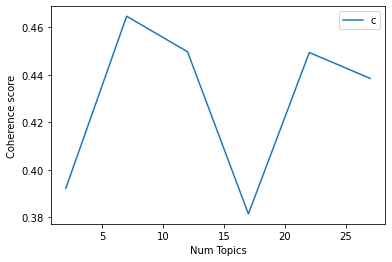

In [82]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_sg_score4)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [83]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_sg_score4):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics =  7

index: 0 | Num Topics = 2  has Coherence Value of 0.3922
index: 1 | Num Topics = 7  has Coherence Value of 0.4647
index: 2 | Num Topics = 12  has Coherence Value of 0.4497
index: 3 | Num Topics = 17  has Coherence Value of 0.3814
index: 4 | Num Topics = 22  has Coherence Value of 0.4494
index: 5 | Num Topics = 27  has Coherence Value of 0.4385


In [180]:
# Select optimal number of topics
optimal_model_sg_score4 = model_list_sg_score4[1]

In [181]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_sg_score4 = pyLDAvis.gensim_models.prepare(optimal_model_sg_score4, corpus_sg_score4, id2word_sg_score4)

In [182]:
print("pyLDAVis for SG topics for score=4:")
vis_sg_score4

pyLDAVis for SG topics for score=4:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.057423  0.009701       1        1  17.457471
1      0.119982  0.101337       2        1  15.797587
0      0.061707 -0.103195       3        1  15.764693
3     -0.081904  0.100425       4        1  13.812603
4      0.057053 -0.036843       5        1  12.910235
6     -0.089230 -0.055235       6        1  12.676862
2     -0.010186 -0.016190       7        1  11.580550, topic_info=        Term       Freq      Total Category  logprob  loglift
15      play  14.000000  14.000000  Default  30.0000  30.0000
116       ad   8.000000   8.000000  Default  29.0000  29.0000
50    screen   9.000000   9.000000  Default  28.0000  28.0000
99   picture   6.000000   6.000000  Default  27.0000  27.0000
20    update   7.000000   7.000000  Default  26.0000  26.0000
..       ...        ...        ...      ...      ...      ...
58     least   0.740169   2.011273   Topic7  -5.0336   1.1562
121      top   0.740158   2.754743   Topic7  -5.0336   0.8416
329      guy   0.740152   2.045734   Topic7  -5.0336   1.1392
225     read   0.740150   3.483299   Topic7  -5.0336   0.6070
244    title   0.740141   2.045735   Topic7  -5.0336   1.1392

[414 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
96        1  0.364469     able
96        5  0.364469     able
96        7  0.364469     able
413       6  0.729528      abt
394       7  0.746087   access
...     ...       ...      ...
7         5  0.128777     work
7         7  0.128777     work
367       1  0.701668  youtube
392       1  0.352606       yt
392       2  0.705211       yt

[547 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 2, 1, 4, 5, 7, 3])

## LDA Topic Modelling (Rating = 5)

In [183]:
# By-rating Topic Modelling - rating = 5
# Convert to list - move to each section
review_sg_score5 = youtube_ios_sg_review_YearMonth_score5.review.values.tolist()
review_words_sg_score5 = list(sent_to_words(review_sg_score5))
print(review_words_sg_score5[:1])

[['after', 'the', 'previous', 'update', 'have', 'been', 'unable', 'to', 'play', 'the', 'video', 'on', 'ipad', 'after', 'search', 'the', 'latest', 'update', 'also', 'did', 'not', 'rectify', 'the', 'issue', 'am', 'very', 'disappointed', 'that', 'can', 'play', 'any', 'video', 'that', 'have', 'searched', 'at', 'all', 'pls', 'rectify', 'the', 'issue', 'for', 'ipad', 'tks']]


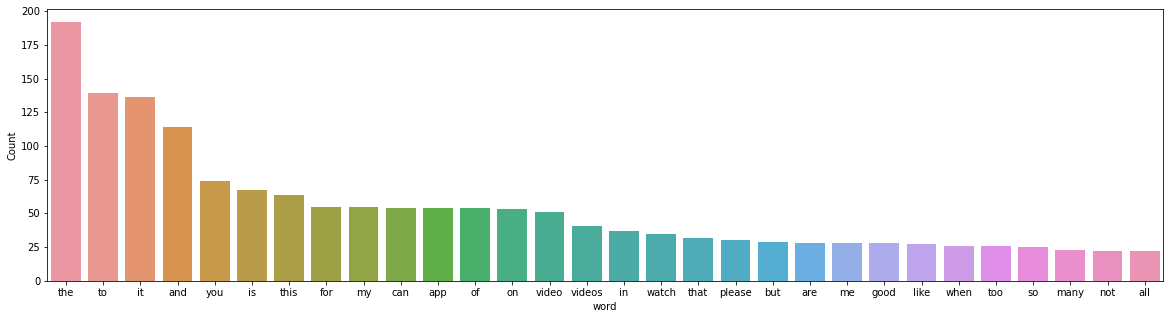

In [88]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_sg_score5))

In [89]:
# Clean text
review_sg_ready_score5 = process_words(review_words_sg_score5)  # processed Text Data! - move to each section

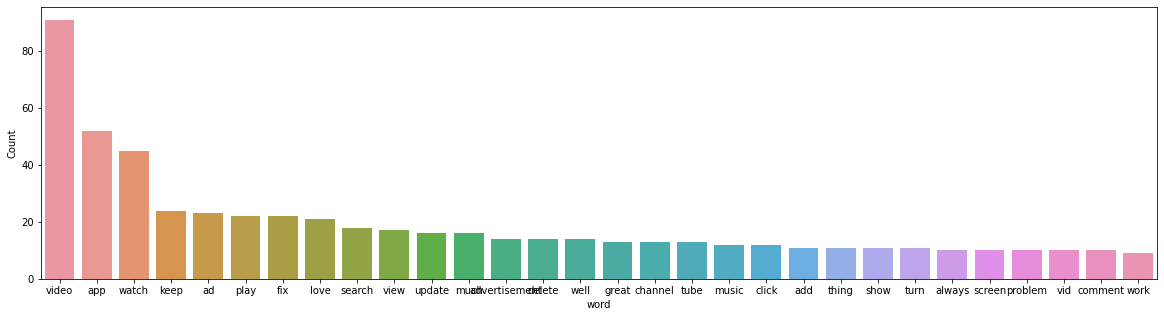

In [90]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_sg_ready_score5))


In [91]:
# Create Dictionary
id2word_sg_score5 = corpora.Dictionary(review_sg_ready_score5)

2021-10-16 23:44:54,232 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 23:44:54,242 [INFO] gensim.corpora.dictionary - built Dictionary(667 unique tokens: ['disappoint', 'ipad', 'issue', 'late', 'play']...) from 264 documents (total 1765 corpus positions)
2021-10-16 23:44:54,244 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(667 unique tokens: ['disappoint', 'ipad', 'issue', 'late', 'play']...) from 264 documents (total 1765 corpus positions)", 'datetime': '2021-10-16T23:44:54.243608', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [92]:
# Create Corpus: Term Document Frequency
corpus_sg_score5 = [id2word_sg_score5.doc2bow(text) for text in review_sg_ready_score5]

In [93]:
# Training LDA model
model_list_sg_score5, coherence_values_sg_score5 = compute_coherence_values(dictionary=id2word_sg_score5, corpus=corpus_sg_score5, 
                                                              texts=review_sg_ready_score5, limit=30, start=2, step=5)


2021-10-16 23:44:54,697 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 23:44:54,699 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 23:44:54,702 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 23:44:54,704 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 264 documents, updating model once every 264 documents, evaluating perplexity every 264 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 23:44:55,776 [INFO] gensim.models.ldamodel - -7.232 per-word bound, 150.3 perplexity estimate based on a held-out corpus of 264 documents with 1765 words
2021-10-16 23:44:55,777 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #264/264
2021-10-16 23:44:56,870 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.031*"app" + 0.021*"video" + 0.015*"ad" + 0.011*"watch" + 0.010*"music" + 0.010*"view" + 0.010*"much" +

2021-10-16 23:45:02,878 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.060*"video" + 0.028*"watch" + 0.016*"keep" + 0.015*"fix" + 0.015*"app" + 0.013*"search" + 0.012*"play" + 0.010*"update" + 0.009*"delete" + 0.009*"well"
2021-10-16 23:45:02,880 [INFO] gensim.models.ldamodel - topic diff=0.011216, rho=0.301511
2021-10-16 23:45:03,373 [INFO] gensim.models.ldamodel - -6.327 per-word bound, 80.3 perplexity estimate based on a held-out corpus of 264 documents with 1765 words
2021-10-16 23:45:03,375 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #264/264
2021-10-16 23:45:03,678 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.033*"app" + 0.019*"ad" + 0.012*"music" + 0.012*"much" + 0.011*"view" + 0.010*"love" + 0.010*"comment" + 0.009*"great" + 0.009*"listen" + 0.008*"channel"
2021-10-16 23:45:03,681 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.060*"video" + 0.028*"watch" + 0.016*"keep" + 0.015*"fix" + 0.015*"app" + 0.013*"search" + 0.012*"play" + 0.010*"updat

2021-10-16 23:45:10,496 [INFO] gensim.models.ldamodel - topic diff=0.002692, rho=0.218218
2021-10-16 23:45:10,868 [INFO] gensim.models.ldamodel - -6.322 per-word bound, 80.0 perplexity estimate based on a held-out corpus of 264 documents with 1765 words
2021-10-16 23:45:10,870 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #264/264
2021-10-16 23:45:11,074 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.033*"app" + 0.019*"ad" + 0.013*"much" + 0.012*"music" + 0.011*"love" + 0.011*"view" + 0.010*"comment" + 0.009*"great" + 0.009*"listen" + 0.008*"channel"
2021-10-16 23:45:11,089 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.062*"video" + 0.028*"watch" + 0.016*"keep" + 0.015*"fix" + 0.015*"app" + 0.013*"play" + 0.013*"search" + 0.011*"update" + 0.010*"well" + 0.009*"delete"
2021-10-16 23:45:11,093 [INFO] gensim.models.ldamodel - topic diff=0.002502, rho=0.213201
2021-10-16 23:45:11,405 [INFO] gensim.models.ldamodel - -6.322 per-word bound, 80.0 perplexity estimate

2021-10-16 23:45:16,274 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #264/264
2021-10-16 23:45:16,423 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.032*"app" + 0.019*"ad" + 0.014*"much" + 0.012*"music" + 0.012*"love" + 0.011*"view" + 0.010*"comment" + 0.009*"great" + 0.009*"listen" + 0.008*"channel"
2021-10-16 23:45:16,425 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.063*"video" + 0.028*"watch" + 0.016*"keep" + 0.015*"fix" + 0.015*"app" + 0.014*"play" + 0.013*"search" + 0.011*"update" + 0.010*"well" + 0.009*"delete"
2021-10-16 23:45:16,426 [INFO] gensim.models.ldamodel - topic diff=0.001842, rho=0.176777
2021-10-16 23:45:16,735 [INFO] gensim.models.ldamodel - -6.320 per-word bound, 79.9 perplexity estimate based on a held-out corpus of 264 documents with 1765 words
2021-10-16 23:45:16,738 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #264/264
2021-10-16 23:45:16,928 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.032*"app" + 0.019*"ad

2021-10-16 23:45:21,903 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.063*"video" + 0.028*"watch" + 0.016*"keep" + 0.016*"fix" + 0.015*"app" + 0.014*"play" + 0.013*"search" + 0.011*"update" + 0.010*"well" + 0.009*"delete"
2021-10-16 23:45:21,904 [INFO] gensim.models.ldamodel - topic diff=0.001884, rho=0.154303
2021-10-16 23:45:22,172 [INFO] gensim.models.ldamodel - -6.318 per-word bound, 79.8 perplexity estimate based on a held-out corpus of 264 documents with 1765 words
2021-10-16 23:45:22,174 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #264/264
2021-10-16 23:45:22,496 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.032*"app" + 0.019*"ad" + 0.014*"much" + 0.013*"love" + 0.012*"music" + 0.011*"view" + 0.010*"comment" + 0.009*"great" + 0.009*"listen" + 0.008*"channel"
2021-10-16 23:45:22,499 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.063*"video" + 0.028*"watch" + 0.016*"keep" + 0.016*"fix" + 0.015*"app" + 0.014*"play" + 0.013*"search" + 0.011*"updat

2021-10-16 23:45:33,049 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 218 virtual documents
2021-10-16 23:45:33,442 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-16 23:45:33,446 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
2021-10-16 23:45:33,451 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 23:45:33,455 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 7 topics, 50 passes over the supplied corpus of 264 documents, updating model once every 264 documents, evaluating perplexity every 264 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 23:45:34,084 [INFO] gensim.models.ldamodel - -9.743 per-word bound, 857.0 perplexity estimate based on a held-out corpus of 264 documents with 1765 words
2021-10-16 23:45:34,095 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #264/264
2021-10-16 23:45

2021-10-16 23:45:37,018 [INFO] gensim.models.ldamodel - topic diff=0.026908, rho=0.408248
2021-10-16 23:45:37,501 [INFO] gensim.models.ldamodel - -6.716 per-word bound, 105.1 perplexity estimate based on a held-out corpus of 264 documents with 1765 words
2021-10-16 23:45:37,502 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #264/264
2021-10-16 23:45:37,694 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.025*"ad" + 0.020*"app" + 0.019*"watch" + 0.019*"volume" + 0.016*"turn" + 0.015*"video" + 0.012*"add" + 0.010*"love" + 0.010*"time" + 0.010*"allow"
2021-10-16 23:45:37,699 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.050*"video" + 0.037*"advertisement" + 0.025*"app" + 0.021*"much" + 0.016*"really" + 0.013*"problem" + 0.013*"lag" + 0.010*"watch" + 0.010*"play" + 0.010*"screen"
2021-10-16 23:45:37,702 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.020*"music" + 0.018*"app" + 0.016*"listen" + 0.016*"phone" + 0.013*"view" + 0.013*"entertainment" + 0.013*"inform

2021-10-16 23:45:40,253 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.025*"ad" + 0.020*"app" + 0.019*"watch" + 0.019*"volume" + 0.016*"turn" + 0.016*"video" + 0.013*"add" + 0.010*"love" + 0.010*"allow" + 0.010*"pop"
2021-10-16 23:45:40,255 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.062*"video" + 0.020*"keep" + 0.016*"play" + 0.014*"ad" + 0.012*"update" + 0.012*"call" + 0.011*"click" + 0.010*"search" + 0.010*"watch" + 0.010*"bring"
2021-10-16 23:45:40,258 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.050*"video" + 0.037*"watch" + 0.037*"search" + 0.032*"fix" + 0.019*"app" + 0.015*"update" + 0.015*"keep" + 0.015*"history" + 0.012*"button" + 0.012*"turn"
2021-10-16 23:45:40,259 [INFO] gensim.models.ldamodel - topic diff=0.005054, rho=0.288675
2021-10-16 23:45:40,532 [INFO] gensim.models.ldamodel - -6.705 per-word bound, 104.4 perplexity estimate based on a held-out corpus of 264 documents with 1765 words
2021-10-16 23:45:40,534 [INFO] gensim.models.ldamodel - PROGRESS

2021-10-16 23:45:42,778 [INFO] gensim.models.ldamodel - topic diff=0.002439, rho=0.242536
2021-10-16 23:45:43,079 [INFO] gensim.models.ldamodel - -6.701 per-word bound, 104.1 perplexity estimate based on a held-out corpus of 264 documents with 1765 words
2021-10-16 23:45:43,095 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #264/264
2021-10-16 23:45:43,263 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.061*"video" + 0.021*"keep" + 0.016*"play" + 0.014*"ad" + 0.012*"update" + 0.012*"call" + 0.010*"click" + 0.010*"search" + 0.010*"watch" + 0.010*"bring"
2021-10-16 23:45:43,266 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.020*"music" + 0.018*"app" + 0.017*"listen" + 0.017*"phone" + 0.013*"view" + 0.013*"information" + 0.013*"entertainment" + 0.011*"video" + 0.010*"ad" + 0.010*"next"
2021-10-16 23:45:43,268 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.052*"app" + 0.034*"video" + 0.031*"watch" + 0.027*"love" + 0.025*"delete" + 0.021*"channel" + 0.020*"view

2021-10-16 23:45:45,899 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.051*"video" + 0.040*"advertisement" + 0.026*"much" + 0.024*"app" + 0.017*"really" + 0.016*"lag" + 0.014*"problem" + 0.010*"screen" + 0.010*"enjoy" + 0.010*"play"
2021-10-16 23:45:45,902 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.060*"video" + 0.023*"keep" + 0.017*"play" + 0.014*"ad" + 0.012*"update" + 0.012*"call" + 0.010*"click" + 0.010*"search" + 0.010*"watch" + 0.010*"upload"
2021-10-16 23:45:45,904 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.025*"ad" + 0.020*"app" + 0.019*"watch" + 0.019*"volume" + 0.016*"turn" + 0.016*"video" + 0.013*"add" + 0.010*"allow" + 0.010*"pop" + 0.010*"fix"
2021-10-16 23:45:45,906 [INFO] gensim.models.ldamodel - topic diff=0.001673, rho=0.208514
2021-10-16 23:45:46,276 [INFO] gensim.models.ldamodel - -6.697 per-word bound, 103.8 perplexity estimate based on a held-out corpus of 264 documents with 1765 words
2021-10-16 23:45:46,278 [INFO] gensim.models.ldamodel - P

2021-10-16 23:45:48,655 [INFO] gensim.models.ldamodel - topic diff=0.001471, rho=0.188982
2021-10-16 23:45:49,004 [INFO] gensim.models.ldamodel - -6.696 per-word bound, 103.7 perplexity estimate based on a held-out corpus of 264 documents with 1765 words
2021-10-16 23:45:49,005 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #264/264
2021-10-16 23:45:49,131 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.020*"music" + 0.018*"app" + 0.017*"listen" + 0.017*"phone" + 0.013*"view" + 0.013*"information" + 0.013*"entertainment" + 0.011*"video" + 0.010*"next" + 0.010*"solve"
2021-10-16 23:45:49,133 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.052*"app" + 0.034*"video" + 0.030*"watch" + 0.027*"love" + 0.025*"delete" + 0.021*"channel" + 0.020*"view" + 0.015*"thing" + 0.015*"add" + 0.013*"tube"
2021-10-16 23:45:49,134 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.060*"video" + 0.023*"keep" + 0.017*"play" + 0.014*"ad" + 0.012*"update" + 0.012*"call" + 0.010*"click"

2021-10-16 23:45:51,892 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.050*"video" + 0.040*"advertisement" + 0.026*"much" + 0.024*"app" + 0.017*"really" + 0.017*"lag" + 0.014*"problem" + 0.010*"screen" + 0.010*"irritate" + 0.010*"enjoy"
2021-10-16 23:45:51,894 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.033*"video" + 0.031*"well" + 0.018*"keep" + 0.014*"amazing" + 0.014*"watch" + 0.014*"comment" + 0.009*"entertainment" + 0.009*"vid" + 0.009*"people" + 0.009*"service"
2021-10-16 23:45:51,896 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.025*"ad" + 0.022*"app" + 0.019*"watch" + 0.019*"volume" + 0.016*"turn" + 0.016*"video" + 0.013*"add" + 0.011*"keep" + 0.010*"give" + 0.010*"allow"
2021-10-16 23:45:51,898 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.061*"video" + 0.023*"keep" + 0.017*"play" + 0.014*"ad" + 0.012*"update" + 0.012*"call" + 0.010*"click" + 0.010*"search" + 0.010*"watch" + 0.010*"upload"
2021-10-16 23:45:51,900 [INFO] gensim.models.ldamodel - topic d

2021-10-16 23:45:54,408 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.050*"video" + 0.040*"advertisement" + 0.026*"much" + 0.024*"app" + 0.017*"really" + 0.017*"lag" + 0.014*"problem" + 0.010*"screen" + 0.010*"irritate" + 0.010*"play"
2021-10-16 23:45:54,410 [INFO] gensim.models.ldamodel - topic diff=0.000685, rho=0.160128
2021-10-16 23:45:54,734 [INFO] gensim.models.ldamodel - -6.693 per-word bound, 103.5 perplexity estimate based on a held-out corpus of 264 documents with 1765 words
2021-10-16 23:45:54,739 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #264/264
2021-10-16 23:45:54,890 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.020*"music" + 0.018*"app" + 0.017*"listen" + 0.017*"phone" + 0.013*"view" + 0.013*"information" + 0.012*"entertainment" + 0.011*"video" + 0.010*"next" + 0.010*"solve"
2021-10-16 23:45:54,892 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.033*"video" + 0.031*"well" + 0.015*"watch" + 0.015*"keep" + 0.014*"amazing" + 0.014*"comm

2021-10-16 23:45:57,750 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.060*"video" + 0.024*"keep" + 0.017*"play" + 0.014*"ad" + 0.012*"update" + 0.012*"call" + 0.010*"click" + 0.010*"search" + 0.010*"watch" + 0.010*"upload"
2021-10-16 23:45:57,752 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.052*"video" + 0.040*"watch" + 0.037*"search" + 0.032*"fix" + 0.016*"app" + 0.015*"history" + 0.015*"update" + 0.012*"keep" + 0.012*"button" + 0.012*"turn"
2021-10-16 23:45:57,754 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.033*"video" + 0.031*"well" + 0.017*"watch" + 0.014*"keep" + 0.014*"amazing" + 0.014*"comment" + 0.012*"entertainment" + 0.009*"vid" + 0.009*"people" + 0.009*"service"
2021-10-16 23:45:57,756 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.050*"video" + 0.040*"advertisement" + 0.026*"much" + 0.024*"app" + 0.017*"really" + 0.017*"lag" + 0.014*"problem" + 0.010*"screen" + 0.010*"irritate" + 0.010*"play"
2021-10-16 23:45:57,758 [INFO] gensim.models.ldamodel - 

2021-10-16 23:46:00,271 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.052*"video" + 0.040*"watch" + 0.037*"search" + 0.032*"fix" + 0.016*"app" + 0.015*"history" + 0.015*"update" + 0.012*"keep" + 0.012*"button" + 0.012*"turn"
2021-10-16 23:46:00,273 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.051*"app" + 0.034*"video" + 0.030*"watch" + 0.027*"love" + 0.025*"delete" + 0.021*"channel" + 0.021*"view" + 0.015*"thing" + 0.015*"add" + 0.013*"tube"
2021-10-16 23:46:00,276 [INFO] gensim.models.ldamodel - topic diff=0.000279, rho=0.141421
2021-10-16 23:46:00,561 [INFO] gensim.models.ldamodel - -6.692 per-word bound, 103.4 perplexity estimate based on a held-out corpus of 264 documents with 1765 words
2021-10-16 23:46:00,569 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #264/264
2021-10-16 23:46:00,731 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.020*"music" + 0.019*"app" + 0.017*"listen" + 0.017*"phone" + 0.013*"view" + 0.013*"information" + 0.011*"video" + 

2021-10-16 23:46:09,706 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.028*"well" + 0.027*"advertisement" + 0.023*"video" + 0.022*"back" + 0.019*"app" + 0.018*"really" + 0.018*"problem" + 0.014*"much" + 0.014*"song" + 0.014*"solve"
2021-10-16 23:46:09,713 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.113*"video" + 0.038*"watch" + 0.021*"play" + 0.021*"lag" + 0.016*"app" + 0.015*"information" + 0.015*"tube" + 0.013*"keep" + 0.012*"stop" + 0.011*"screen"
2021-10-16 23:46:09,724 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.045*"watch" + 0.031*"app" + 0.028*"ad" + 0.016*"ever" + 0.016*"volume" + 0.016*"translate" + 0.016*"screen" + 0.016*"vid" + 0.016*"notification" + 0.016*"chinese"
2021-10-16 23:46:09,729 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.031*"app" + 0.024*"watch" + 0.024*"channel" + 0.023*"love" + 0.019*"video" + 0.018*"people" + 0.015*"view" + 0.014*"thing" + 0.014*"add" + 0.014*"vid"
2021-10-16 23:46:09,734 [INFO] gensim.models.ldamodel - topic #0 (

2021-10-16 23:46:12,143 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.121*"video" + 0.043*"watch" + 0.020*"play" + 0.020*"lag" + 0.015*"app" + 0.015*"information" + 0.015*"tube" + 0.014*"screen" + 0.014*"wish" + 0.014*"keep"
2021-10-16 23:46:12,146 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.026*"upload" + 0.026*"channel" + 0.026*"volume" + 0.021*"video" + 0.020*"comment" + 0.020*"amazing" + 0.013*"well" + 0.013*"give" + 0.013*"help" + 0.013*"fix"
2021-10-16 23:46:12,149 [INFO] gensim.models.ldamodel - topic diff=0.009919, rho=0.316228
2021-10-16 23:46:12,471 [INFO] gensim.models.ldamodel - -6.818 per-word bound, 112.8 perplexity estimate based on a held-out corpus of 264 documents with 1765 words
2021-10-16 23:46:12,473 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #264/264
2021-10-16 23:46:12,649 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.026*"search" + 0.026*"entertainment" + 0.018*"work" + 0.018*"post" + 0.018*"io" + 0.018*"appreciate" + 0.018

2021-10-16 23:46:14,687 [INFO] gensim.models.ldamodel - PROGRESS: pass 14, at document #264/264
2021-10-16 23:46:14,827 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.044*"watch" + 0.032*"app" + 0.024*"ad" + 0.016*"ever" + 0.016*"screen" + 0.016*"volume" + 0.016*"translate" + 0.016*"chinese" + 0.016*"vid" + 0.016*"notification"
2021-10-16 23:46:14,829 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.042*"app" + 0.031*"ad" + 0.030*"love" + 0.027*"video" + 0.027*"much" + 0.016*"watch" + 0.015*"put" + 0.012*"allow" + 0.012*"always" + 0.012*"bring"
2021-10-16 23:46:14,832 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.026*"upload" + 0.026*"channel" + 0.026*"volume" + 0.020*"video" + 0.020*"comment" + 0.020*"amazing" + 0.013*"well" + 0.013*"give" + 0.013*"help" + 0.013*"issue"
2021-10-16 23:46:14,834 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.026*"call" + 0.025*"view" + 0.023*"video" + 0.021*"app" + 0.021*"time" + 0.021*"excellent" + 0.016*"tube" + 0.016*"sound" + 0.0

2021-10-16 23:46:17,255 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.042*"app" + 0.031*"ad" + 0.031*"love" + 0.027*"video" + 0.027*"much" + 0.016*"watch" + 0.015*"put" + 0.012*"allow" + 0.012*"always" + 0.012*"bring"
2021-10-16 23:46:17,257 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.031*"music" + 0.021*"listen" + 0.016*"comment" + 0.016*"ad" + 0.016*"phone" + 0.016*"view" + 0.016*"app" + 0.016*"next" + 0.016*"reply" + 0.016*"list"
2021-10-16 23:46:17,260 [INFO] gensim.models.ldamodel - topic diff=0.000900, rho=0.218218
2021-10-16 23:46:17,634 [INFO] gensim.models.ldamodel - -6.812 per-word bound, 112.4 perplexity estimate based on a held-out corpus of 264 documents with 1765 words
2021-10-16 23:46:17,635 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #264/264
2021-10-16 23:46:17,769 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.026*"search" + 0.026*"entertainment" + 0.018*"work" + 0.018*"post" + 0.018*"io" + 0.018*"appreciate" + 0.018*"device" + 0

2021-10-16 23:46:20,273 [INFO] gensim.models.ldamodel - PROGRESS: pass 25, at document #264/264
2021-10-16 23:46:20,511 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.042*"app" + 0.031*"ad" + 0.031*"love" + 0.027*"video" + 0.027*"much" + 0.016*"watch" + 0.015*"put" + 0.012*"allow" + 0.012*"always" + 0.012*"bring"
2021-10-16 23:46:20,512 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.031*"well" + 0.027*"advertisement" + 0.023*"video" + 0.023*"back" + 0.022*"really" + 0.018*"app" + 0.018*"problem" + 0.014*"much" + 0.014*"solve" + 0.014*"song"
2021-10-16 23:46:20,513 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.026*"search" + 0.026*"entertainment" + 0.018*"work" + 0.018*"io" + 0.018*"post" + 0.018*"appreciate" + 0.018*"device" + 0.018*"watch" + 0.009*"topic" + 0.009*"much"
2021-10-16 23:46:20,515 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.026*"call" + 0.025*"view" + 0.023*"video" + 0.021*"app" + 0.021*"time" + 0.021*"excellent" + 0.016*"tube" + 0.016*"sound" + 0

2021-10-16 23:46:22,898 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.044*"watch" + 0.032*"app" + 0.024*"ad" + 0.016*"ever" + 0.016*"screen" + 0.016*"volume" + 0.016*"chinese" + 0.016*"translate" + 0.016*"vid" + 0.016*"notification"
2021-10-16 23:46:22,900 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.052*"video" + 0.043*"app" + 0.031*"turn" + 0.025*"fix" + 0.016*"screen" + 0.016*"stick" + 0.016*"play" + 0.012*"keep" + 0.012*"update" + 0.012*"still"
2021-10-16 23:46:22,901 [INFO] gensim.models.ldamodel - topic diff=0.000090, rho=0.176777
2021-10-16 23:46:23,163 [INFO] gensim.models.ldamodel - -6.812 per-word bound, 112.4 perplexity estimate based on a held-out corpus of 264 documents with 1765 words
2021-10-16 23:46:23,165 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #264/264
2021-10-16 23:46:23,332 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.042*"app" + 0.031*"ad" + 0.031*"love" + 0.027*"video" + 0.027*"much" + 0.016*"watch" + 0.015*"put" + 0.01

2021-10-16 23:46:25,539 [INFO] gensim.models.ldamodel - PROGRESS: pass 36, at document #264/264
2021-10-16 23:46:25,750 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.042*"app" + 0.031*"ad" + 0.031*"love" + 0.027*"video" + 0.027*"much" + 0.016*"watch" + 0.015*"put" + 0.012*"allow" + 0.012*"always" + 0.012*"bring"
2021-10-16 23:46:25,758 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.052*"video" + 0.043*"app" + 0.031*"turn" + 0.025*"fix" + 0.016*"screen" + 0.016*"stick" + 0.016*"play" + 0.012*"keep" + 0.012*"still" + 0.012*"update"
2021-10-16 23:46:25,763 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.122*"video" + 0.044*"watch" + 0.020*"play" + 0.020*"lag" + 0.015*"app" + 0.015*"information" + 0.015*"tube" + 0.015*"screen" + 0.015*"wish" + 0.014*"keep"
2021-10-16 23:46:25,766 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.031*"well" + 0.027*"advertisement" + 0.023*"back" + 0.023*"video" + 0.022*"really" + 0.018*"app" + 0.018*"problem" + 0.014*"much" + 0.014*"solve

2021-10-16 23:46:27,795 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.031*"music" + 0.021*"listen" + 0.016*"app" + 0.016*"view" + 0.016*"next" + 0.016*"comment" + 0.016*"phone" + 0.016*"reply" + 0.016*"list" + 0.016*"ad"
2021-10-16 23:46:27,797 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.026*"call" + 0.025*"view" + 0.023*"video" + 0.021*"app" + 0.021*"time" + 0.021*"excellent" + 0.016*"tube" + 0.016*"sound" + 0.016*"delete" + 0.016*"stop"
2021-10-16 23:46:27,798 [INFO] gensim.models.ldamodel - topic diff=0.000011, rho=0.152499
2021-10-16 23:46:28,038 [INFO] gensim.models.ldamodel - -6.812 per-word bound, 112.4 perplexity estimate based on a held-out corpus of 264 documents with 1765 words
2021-10-16 23:46:28,039 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #264/264
2021-10-16 23:46:28,149 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.042*"app" + 0.031*"ad" + 0.031*"love" + 0.027*"video" + 0.027*"much" + 0.016*"watch" + 0.015*"put" + 0.012*"allow" 

2021-10-16 23:46:30,513 [INFO] gensim.models.ldamodel - PROGRESS: pass 47, at document #264/264
2021-10-16 23:46:30,754 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.026*"search" + 0.026*"entertainment" + 0.018*"work" + 0.018*"io" + 0.018*"post" + 0.018*"appreciate" + 0.018*"device" + 0.018*"watch" + 0.009*"feature" + 0.009*"next"
2021-10-16 23:46:30,767 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.042*"app" + 0.031*"ad" + 0.031*"love" + 0.027*"video" + 0.027*"much" + 0.016*"watch" + 0.015*"put" + 0.012*"allow" + 0.012*"always" + 0.012*"bring"
2021-10-16 23:46:30,774 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.026*"call" + 0.025*"view" + 0.023*"video" + 0.021*"app" + 0.021*"time" + 0.021*"excellent" + 0.016*"tube" + 0.016*"sound" + 0.016*"delete" + 0.016*"stop"
2021-10-16 23:46:30,777 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.122*"video" + 0.044*"watch" + 0.020*"play" + 0.020*"lag" + 0.015*"app" + 0.015*"information" + 0.015*"tube" + 0.015*"screen" + 0.0

2021-10-16 23:46:41,511 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.075*"video" + 0.044*"search" + 0.034*"fix" + 0.032*"watch" + 0.022*"history" + 0.022*"keep" + 0.017*"screen" + 0.014*"play" + 0.013*"way" + 0.013*"clear"
2021-10-16 23:46:41,513 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.039*"app" + 0.032*"listen" + 0.027*"always" + 0.023*"place" + 0.023*"video" + 0.022*"let" + 0.022*"music" + 0.021*"play" + 0.021*"game" + 0.018*"thumb"
2021-10-16 23:46:41,514 [INFO] gensim.models.ldamodel - topic diff=0.086341, rho=0.577350
2021-10-16 23:46:41,890 [INFO] gensim.models.ldamodel - -7.063 per-word bound, 133.7 perplexity estimate based on a held-out corpus of 264 documents with 1765 words
2021-10-16 23:46:41,892 [INFO] gensim.models.ldamodel - PROGRESS: pass 2, at document #264/264
2021-10-16 23:46:42,086 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.039*"well" + 0.031*"app" + 0.031*"regard" + 0.022*"video" + 0.021*"song" + 0.021*"chinese" + 0.021*"translate" + 0.0

2021-10-16 23:46:44,403 [INFO] gensim.models.ldamodel - PROGRESS: pass 7, at document #264/264
2021-10-16 23:46:44,623 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.033*"playback" + 0.030*"excellent" + 0.017*"account" + 0.017*"great" + 0.017*"ask" + 0.017*"annoy" + 0.017*"keep" + 0.017*"continue" + 0.017*"confirmation" + 0.017*"suggestion"
2021-10-16 23:46:44,628 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.053*"well" + 0.034*"regard" + 0.033*"app" + 0.023*"chinese" + 0.023*"song" + 0.023*"translate" + 0.022*"tube" + 0.012*"video" + 0.012*"back" + 0.012*"load"
2021-10-16 23:46:44,632 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.049*"video" + 0.033*"turn" + 0.027*"watch" + 0.021*"vid" + 0.017*"fix" + 0.016*"screen" + 0.016*"page" + 0.016*"open" + 0.016*"sometimes" + 0.016*"kid"
2021-10-16 23:46:44,633 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.049*"app" + 0.033*"listen" + 0.032*"always" + 0.022*"video" + 0.022*"place" + 0.022*"let" + 0.022*"music" + 0.022*"

2021-10-16 23:46:47,526 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.048*"video" + 0.037*"much" + 0.031*"play" + 0.022*"keep" + 0.016*"information" + 0.013*"app" + 0.012*"search" + 0.012*"back" + 0.012*"ever" + 0.012*"platform"
2021-10-16 23:46:47,528 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.051*"view" + 0.051*"delete" + 0.043*"tube" + 0.026*"join" + 0.026*"channel" + 0.026*"work" + 0.022*"video" + 0.019*"update" + 0.017*"mean" + 0.017*"ipad"
2021-10-16 23:46:47,530 [INFO] gensim.models.ldamodel - topic diff=0.007359, rho=0.267261
2021-10-16 23:46:48,076 [INFO] gensim.models.ldamodel - -6.939 per-word bound, 122.7 perplexity estimate based on a held-out corpus of 264 documents with 1765 words
2021-10-16 23:46:48,080 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #264/264
2021-10-16 23:46:48,287 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.060*"video" + 0.052*"app" + 0.032*"advertisement" + 0.025*"watch" + 0.022*"keep" + 0.020*"love" + 0.020*"am

2021-10-16 23:46:50,646 [INFO] gensim.models.ldamodel - PROGRESS: pass 18, at document #264/264
2021-10-16 23:46:50,798 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.033*"playback" + 0.018*"excellent" + 0.017*"account" + 0.017*"great" + 0.017*"keep" + 0.017*"annoy" + 0.017*"continue" + 0.017*"ask" + 0.017*"list" + 0.017*"confirmation"
2021-10-16 23:46:50,801 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.043*"music" + 0.037*"app" + 0.031*"call" + 0.024*"ad" + 0.018*"upload" + 0.018*"delete" + 0.018*"comment" + 0.016*"video" + 0.012*"time" + 0.012*"give"
2021-10-16 23:46:50,803 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.032*"video" + 0.022*"channel" + 0.022*"watch" + 0.022*"service" + 0.011*"fix" + 0.011*"book" + 0.011*"barrier" + 0.011*"bar" + 0.011*"language" + 0.011*"finger"
2021-10-16 23:46:50,805 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.097*"video" + 0.049*"search" + 0.045*"fix" + 0.034*"watch" + 0.021*"history" + 0.021*"keep" + 0.016*"screen" + 0.016

2021-10-16 23:46:53,163 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.076*"ad" + 0.035*"app" + 0.026*"watch" + 0.026*"entertaining" + 0.026*"crash" + 0.021*"keep" + 0.018*"love" + 0.017*"video" + 0.017*"channel" + 0.017*"day"
2021-10-16 23:46:53,165 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.052*"app" + 0.033*"listen" + 0.033*"always" + 0.022*"video" + 0.022*"place" + 0.022*"let" + 0.022*"music" + 0.022*"play" + 0.022*"game" + 0.022*"big"
2021-10-16 23:46:53,167 [INFO] gensim.models.ldamodel - topic diff=0.001778, rho=0.200000
2021-10-16 23:46:53,513 [INFO] gensim.models.ldamodel - -6.926 per-word bound, 121.6 perplexity estimate based on a held-out corpus of 264 documents with 1765 words
2021-10-16 23:46:53,514 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #264/264
2021-10-16 23:46:53,763 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.058*"well" + 0.035*"regard" + 0.035*"app" + 0.024*"chinese" + 0.024*"translate" + 0.024*"song" + 0.024*"tube" + 0.0

2021-10-16 23:46:56,035 [INFO] gensim.models.ldamodel - PROGRESS: pass 29, at document #264/264
2021-10-16 23:46:56,267 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.058*"view" + 0.050*"delete" + 0.042*"tube" + 0.025*"join" + 0.025*"channel" + 0.025*"work" + 0.022*"tap" + 0.019*"video" + 0.019*"update" + 0.017*"mean"
2021-10-16 23:46:56,269 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.032*"video" + 0.026*"delete" + 0.026*"really" + 0.020*"omg" + 0.020*"time" + 0.020*"ad" + 0.013*"love" + 0.013*"excellent" + 0.013*"online" + 0.013*"app"
2021-10-16 23:46:56,271 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.058*"well" + 0.035*"regard" + 0.035*"app" + 0.024*"chinese" + 0.024*"translate" + 0.024*"song" + 0.024*"tube" + 0.012*"back" + 0.012*"program" + 0.012*"copy"
2021-10-16 23:46:56,273 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.076*"ad" + 0.035*"app" + 0.026*"watch" + 0.026*"entertaining" + 0.026*"crash" + 0.021*"keep" + 0.018*"love" + 0.017*"video" + 0.017*"c

2021-10-16 23:46:58,652 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.096*"video" + 0.049*"search" + 0.045*"fix" + 0.033*"watch" + 0.021*"history" + 0.021*"keep" + 0.016*"screen" + 0.016*"problem" + 0.012*"play" + 0.012*"way"
2021-10-16 23:46:58,654 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.047*"video" + 0.042*"much" + 0.035*"play" + 0.022*"keep" + 0.016*"information" + 0.013*"app" + 0.012*"search" + 0.012*"back" + 0.012*"platform" + 0.012*"tube"
2021-10-16 23:46:58,656 [INFO] gensim.models.ldamodel - topic diff=0.001196, rho=0.166667
2021-10-16 23:46:59,010 [INFO] gensim.models.ldamodel - -6.916 per-word bound, 120.7 perplexity estimate based on a held-out corpus of 264 documents with 1765 words
2021-10-16 23:46:59,013 [INFO] gensim.models.ldamodel - PROGRESS: pass 35, at document #264/264
2021-10-16 23:46:59,217 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.061*"video" + 0.058*"app" + 0.028*"watch" + 0.025*"love" + 0.022*"keep" + 0.022*"amazing" + 0.017*"click"

2021-10-16 23:47:01,892 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #264/264
2021-10-16 23:47:02,112 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.047*"video" + 0.042*"much" + 0.035*"play" + 0.022*"keep" + 0.016*"information" + 0.013*"app" + 0.012*"search" + 0.012*"back" + 0.012*"platform" + 0.012*"tube"
2021-10-16 23:47:02,119 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.058*"view" + 0.050*"delete" + 0.042*"tube" + 0.025*"join" + 0.025*"channel" + 0.025*"work" + 0.025*"tap" + 0.019*"video" + 0.018*"update" + 0.017*"mean"
2021-10-16 23:47:02,124 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.043*"update" + 0.037*"app" + 0.030*"well" + 0.022*"watch" + 0.022*"sound" + 0.022*"entertainment" + 0.015*"matter" + 0.015*"picture" + 0.015*"ipad" + 0.015*"video"
2021-10-16 23:47:02,132 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.077*"ad" + 0.035*"app" + 0.026*"watch" + 0.026*"entertaining" + 0.026*"crash" + 0.021*"keep" + 0.018*"love" + 0.018*"video"

2021-10-16 23:47:04,720 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.096*"video" + 0.049*"search" + 0.045*"fix" + 0.033*"watch" + 0.021*"history" + 0.021*"keep" + 0.016*"screen" + 0.016*"problem" + 0.012*"play" + 0.012*"clear"
2021-10-16 23:47:04,723 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.067*"video" + 0.063*"watch" + 0.032*"app" + 0.031*"love" + 0.021*"comment" + 0.021*"thing" + 0.016*"ad" + 0.016*"put" + 0.016*"fun" + 0.016*"play"
2021-10-16 23:47:04,726 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.043*"music" + 0.037*"app" + 0.031*"call" + 0.025*"ad" + 0.018*"upload" + 0.018*"delete" + 0.018*"comment" + 0.015*"video" + 0.012*"thing" + 0.012*"capability"
2021-10-16 23:47:04,729 [INFO] gensim.models.ldamodel - topic diff=0.000594, rho=0.145865
2021-10-16 23:47:05,049 [INFO] gensim.models.ldamodel - -6.914 per-word bound, 120.6 perplexity estimate based on a held-out corpus of 264 documents with 1765 words
2021-10-16 23:47:05,051 [INFO] gensim.models.ldamode

2021-10-16 23:47:17,625 [INFO] gensim.models.ldamodel - -22.005 per-word bound, 4208477.4 perplexity estimate based on a held-out corpus of 264 documents with 1765 words
2021-10-16 23:47:17,633 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #264/264
2021-10-16 23:47:17,949 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.025*"hope" + 0.021*"music" + 0.021*"list" + 0.020*"next" + 0.019*"reply" + 0.019*"button" + 0.019*"keep" + 0.019*"back" + 0.019*"add" + 0.013*"message"
2021-10-16 23:47:17,951 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.061*"video" + 0.043*"app" + 0.026*"watch" + 0.026*"love" + 0.026*"much" + 0.018*"screen" + 0.018*"new" + 0.018*"lag" + 0.018*"always" + 0.018*"view"
2021-10-16 23:47:17,954 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.048*"video" + 0.029*"comment" + 0.029*"well" + 0.020*"watch" + 0.019*"amazing" + 0.019*"keep" + 0.019*"tube" + 0.019*"channel" + 0.010*"show" + 0.010*"bar"
2021-10-16 23:47:17,955 [INFO] gensim.models.ldam

2021-10-16 23:47:20,301 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.045*"comment" + 0.030*"page" + 0.030*"korean" + 0.030*"open" + 0.030*"ad" + 0.030*"otherwise" + 0.029*"slow" + 0.016*"like" + 0.016*"sometimes" + 0.016*"min"
2021-10-16 23:47:20,305 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.072*"video" + 0.058*"watch" + 0.027*"vid" + 0.023*"app" + 0.020*"comment" + 0.014*"keep" + 0.014*"rly" + 0.014*"interesting" + 0.014*"swipe" + 0.014*"free"
2021-10-16 23:47:20,310 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.064*"video" + 0.050*"app" + 0.033*"love" + 0.028*"much" + 0.025*"watch" + 0.021*"enjoy" + 0.017*"screen" + 0.017*"new" + 0.017*"lag" + 0.017*"view"
2021-10-16 23:47:20,318 [INFO] gensim.models.ldamodel - topic diff=0.025286, rho=0.377964
2021-10-16 23:47:20,633 [INFO] gensim.models.ldamodel - -7.025 per-word bound, 130.2 perplexity estimate based on a held-out corpus of 264 documents with 1765 words
2021-10-16 23:47:20,634 [INFO] gensim.models.ldamodel

2021-10-16 23:47:22,442 [INFO] gensim.models.ldamodel - topic diff=0.008774, rho=0.288675
2021-10-16 23:47:22,686 [INFO] gensim.models.ldamodel - -7.004 per-word bound, 128.3 perplexity estimate based on a held-out corpus of 264 documents with 1765 words
2021-10-16 23:47:22,688 [INFO] gensim.models.ldamodel - PROGRESS: pass 11, at document #264/264
2021-10-16 23:47:22,794 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.053*"video" + 0.043*"app" + 0.032*"feature" + 0.032*"play" + 0.022*"new" + 0.022*"kid" + 0.022*"vid" + 0.022*"happen" + 0.011*"difference" + 0.011*"long"
2021-10-16 23:47:22,798 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.026*"allow" + 0.026*"great" + 0.026*"glad" + 0.026*"watch" + 0.026*"well" + 0.026*"ad" + 0.026*"lovely" + 0.019*"song" + 0.013*"love" + 0.013*"late"
2021-10-16 23:47:22,805 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.018*"wonderful" + 0.018*"useful" + 0.018*"idea" + 0.018*"home" + 0.018*"amazing" + 0.018*"大家喜欢的或不喜欢的事物" + 0.018*"tod

2021-10-16 23:47:25,275 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.044*"video" + 0.043*"advertisement" + 0.043*"much" + 0.029*"keep" + 0.022*"tube" + 0.022*"give" + 0.015*"watch" + 0.014*"senior" + 0.014*"enable" + 0.014*"topic"
2021-10-16 23:47:25,278 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.053*"update" + 0.052*"app" + 0.035*"ipad" + 0.027*"ad" + 0.027*"work" + 0.018*"public" + 0.018*"private" + 0.018*"play" + 0.018*"love" + 0.018*"live"
2021-10-16 23:47:25,280 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.026*"allow" + 0.026*"great" + 0.026*"glad" + 0.026*"watch" + 0.026*"well" + 0.026*"ad" + 0.026*"lovely" + 0.020*"song" + 0.013*"love" + 0.013*"late"
2021-10-16 23:47:25,282 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.029*"watch" + 0.029*"vid" + 0.029*"find" + 0.029*"information" + 0.019*"love" + 0.019*"great" + 0.019*"work" + 0.019*"appreciate" + 0.019*"preview" + 0.011*"app"
2021-10-16 23:47:25,284 [INFO] gensim.models.ldamodel - topic diff=0.00

2021-10-16 23:47:27,580 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.018*"home" + 0.018*"amazing" + 0.018*"useful" + 0.018*"idea" + 0.018*"today" + 0.018*"family" + 0.018*"wonderful" + 0.018*"sound" + 0.018*"clear" + 0.018*"personally"
2021-10-16 23:47:27,583 [INFO] gensim.models.ldamodel - topic diff=0.001484, rho=0.208514
2021-10-16 23:47:27,898 [INFO] gensim.models.ldamodel - -6.999 per-word bound, 127.9 perplexity estimate based on a held-out corpus of 264 documents with 1765 words
2021-10-16 23:47:27,899 [INFO] gensim.models.ldamodel - PROGRESS: pass 22, at document #264/264
2021-10-16 23:47:28,157 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.045*"comment" + 0.030*"korean" + 0.030*"page" + 0.030*"open" + 0.030*"ad" + 0.030*"otherwise" + 0.030*"slow" + 0.016*"view" + 0.016*"delete" + 0.016*"like"
2021-10-16 23:47:28,159 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.080*"app" + 0.048*"music" + 0.040*"channel" + 0.027*"watch" + 0.027*"add" + 0.027*"thing" + 0.02

2021-10-16 23:47:30,281 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.060*"volume" + 0.045*"pop" + 0.030*"video" + 0.030*"fix" + 0.030*"notification" + 0.016*"top" + 0.016*"click" + 0.016*"watch" + 0.016*"issue" + 0.016*"control"
2021-10-16 23:47:30,283 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.053*"update" + 0.052*"app" + 0.035*"ipad" + 0.027*"ad" + 0.027*"work" + 0.018*"public" + 0.018*"private" + 0.018*"play" + 0.018*"love" + 0.018*"live"
2021-10-16 23:47:30,288 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.043*"video" + 0.037*"update" + 0.031*"play" + 0.031*"app" + 0.024*"really" + 0.024*"problem" + 0.024*"change" + 0.024*"solve" + 0.018*"issue" + 0.012*"inconvenient"
2021-10-16 23:47:30,290 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.060*"upload" + 0.030*"video" + 0.016*"everytime" + 0.016*"thing" + 0.016*"retry" + 0.016*"tap" + 0.016*"actually" + 0.016*"happen" + 0.016*"error" + 0.016*"talk"
2021-10-16 23:47:30,292 [INFO] gensim.models.ldamodel - 

2021-10-16 23:47:32,408 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.044*"video" + 0.043*"advertisement" + 0.043*"much" + 0.029*"keep" + 0.022*"tube" + 0.022*"give" + 0.015*"watch" + 0.015*"senior" + 0.015*"enable" + 0.015*"allow"
2021-10-16 23:47:32,410 [INFO] gensim.models.ldamodel - topic diff=0.000698, rho=0.171499
2021-10-16 23:47:32,757 [INFO] gensim.models.ldamodel - -6.993 per-word bound, 127.4 perplexity estimate based on a held-out corpus of 264 documents with 1765 words
2021-10-16 23:47:32,758 [INFO] gensim.models.ldamodel - PROGRESS: pass 33, at document #264/264
2021-10-16 23:47:32,923 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.075*"video" + 0.039*"delete" + 0.031*"watch" + 0.031*"time" + 0.023*"tap" + 0.023*"app" + 0.023*"long" + 0.016*"update" + 0.016*"fix" + 0.016*"feature"
2021-10-16 23:47:32,924 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.068*"video" + 0.062*"watch" + 0.033*"app" + 0.032*"vid" + 0.019*"comment" + 0.013*"keep" + 0.013*"rly" + 

2021-10-16 23:47:35,228 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.073*"video" + 0.039*"delete" + 0.031*"watch" + 0.031*"time" + 0.023*"tap" + 0.023*"app" + 0.023*"long" + 0.016*"fix" + 0.016*"update" + 0.016*"feature"
2021-10-16 23:47:35,230 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.042*"video" + 0.032*"app" + 0.032*"always" + 0.021*"advertisement" + 0.021*"top" + 0.021*"phone" + 0.021*"search" + 0.021*"stick" + 0.021*"screen" + 0.021*"music"
2021-10-16 23:47:35,234 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.060*"volume" + 0.045*"pop" + 0.030*"video" + 0.030*"fix" + 0.030*"notification" + 0.016*"top" + 0.016*"control" + 0.016*"landscape" + 0.016*"increase" + 0.016*"watch"
2021-10-16 23:47:35,236 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.039*"well" + 0.033*"video" + 0.030*"comment" + 0.020*"watch" + 0.020*"channel" + 0.020*"amazing" + 0.020*"tube" + 0.020*"keep" + 0.020*"really" + 0.010*"bar"
2021-10-16 23:47:35,238 [INFO] gensim.models.ldamodel -

2021-10-16 23:47:37,523 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.039*"well" + 0.033*"video" + 0.030*"comment" + 0.020*"watch" + 0.020*"channel" + 0.020*"amazing" + 0.020*"tube" + 0.020*"keep" + 0.020*"really" + 0.010*"bar"
2021-10-16 23:47:37,525 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.072*"video" + 0.039*"delete" + 0.031*"watch" + 0.031*"time" + 0.023*"tap" + 0.023*"app" + 0.023*"long" + 0.016*"fix" + 0.016*"feature" + 0.016*"update"
2021-10-16 23:47:37,528 [INFO] gensim.models.ldamodel - topic diff=0.000381, rho=0.149071
2021-10-16 23:47:37,772 [INFO] gensim.models.ldamodel - -6.991 per-word bound, 127.2 perplexity estimate based on a held-out corpus of 264 documents with 1765 words
2021-10-16 23:47:37,773 [INFO] gensim.models.ldamodel - PROGRESS: pass 44, at document #264/264
2021-10-16 23:47:37,938 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.038*"omg" + 0.038*"view" + 0.038*"excellent" + 0.026*"love" + 0.013*"ad" + 0.013*"video" + 0.013*"recommend" 

2021-10-16 23:47:40,032 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #264/264
2021-10-16 23:47:40,187 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.044*"video" + 0.043*"advertisement" + 0.043*"much" + 0.029*"keep" + 0.022*"tube" + 0.022*"give" + 0.015*"watch" + 0.015*"senior" + 0.015*"enable" + 0.015*"allow"
2021-10-16 23:47:40,190 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.065*"video" + 0.052*"app" + 0.049*"love" + 0.026*"watch" + 0.025*"much" + 0.025*"enjoy" + 0.019*"lag" + 0.017*"screen" + 0.017*"new" + 0.017*"view"
2021-10-16 23:47:40,195 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.027*"allow" + 0.027*"great" + 0.027*"glad" + 0.027*"watch" + 0.027*"well" + 0.027*"ad" + 0.027*"lovely" + 0.021*"song" + 0.014*"love" + 0.014*"trend"
2021-10-16 23:47:40,199 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.070*"video" + 0.062*"watch" + 0.033*"app" + 0.032*"vid" + 0.019*"comment" + 0.013*"rly" + 0.013*"keep" + 0.013*"awesome" + 0.013*"allow" + 

2021-10-16 23:47:52,402 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.056*"call" + 0.042*"time" + 0.032*"watch" + 0.032*"love" + 0.032*"view" + 0.028*"delete" + 0.023*"free" + 0.023*"live" + 0.021*"long" + 0.021*"channel"
2021-10-16 23:47:52,405 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.047*"app" + 0.036*"video" + 0.029*"watch" + 0.027*"kid" + 0.020*"love" + 0.016*"show" + 0.016*"play" + 0.016*"feature" + 0.015*"vid" + 0.015*"amazing"
2021-10-16 23:47:52,406 [INFO] gensim.models.ldamodel - topic diff=0.044091, rho=0.447214
2021-10-16 23:47:52,652 [INFO] gensim.models.ldamodel - -7.205 per-word bound, 147.6 perplexity estimate based on a held-out corpus of 264 documents with 1765 words
2021-10-16 23:47:52,653 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #264/264
2021-10-16 23:47:52,901 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.056*"call" + 0.043*"time" + 0.033*"watch" + 0.033*"love" + 0.033*"view" + 0.028*"delete" + 0.023*"free" + 0.023*"live"

2021-10-16 23:47:55,295 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #264/264
2021-10-16 23:47:55,474 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.074*"turn" + 0.032*"video" + 0.030*"subtitle" + 0.030*"ad" + 0.030*"update" + 0.015*"love" + 0.015*"play" + 0.015*"clip" + 0.015*"next" + 0.015*"everytime"
2021-10-16 23:47:55,476 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.050*"fix" + 0.040*"app" + 0.031*"watch" + 0.031*"ad" + 0.030*"way" + 0.020*"play" + 0.020*"video" + 0.020*"advertisement" + 0.020*"private" + 0.020*"ipad"
2021-10-16 23:47:55,479 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.082*"advertisement" + 0.034*"channel" + 0.034*"video" + 0.033*"much" + 0.018*"add" + 0.017*"senior" + 0.017*"translate" + 0.017*"chinese" + 0.017*"join" + 0.017*"program"
2021-10-16 23:47:55,481 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.037*"update" + 0.026*"play" + 0.025*"view" + 0.025*"video" + 0.025*"song" + 0.025*"ad" + 0.024*"tube" + 0.024*"enter

2021-10-16 23:47:58,046 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.057*"volume" + 0.028*"always" + 0.019*"watch" + 0.019*"top" + 0.019*"pop" + 0.019*"appear" + 0.019*"show" + 0.019*"put" + 0.019*"button" + 0.019*"search"
2021-10-16 23:47:58,048 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.051*"list" + 0.051*"reply" + 0.051*"next" + 0.034*"view" + 0.034*"message" + 0.034*"click" + 0.034*"keep" + 0.018*"content" + 0.018*"open" + 0.018*"appear"
2021-10-16 23:47:58,049 [INFO] gensim.models.ldamodel - topic diff=0.004407, rho=0.250000
2021-10-16 23:47:58,288 [INFO] gensim.models.ldamodel - -7.147 per-word bound, 141.8 perplexity estimate based on a held-out corpus of 264 documents with 1765 words
2021-10-16 23:47:58,289 [INFO] gensim.models.ldamodel - PROGRESS: pass 15, at document #264/264
2021-10-16 23:47:58,533 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.051*"list" + 0.051*"reply" + 0.051*"next" + 0.035*"view" + 0.035*"message" + 0.035*"click" + 0.035*"keep" + 0

2021-10-16 23:48:00,805 [INFO] gensim.models.ldamodel - -7.144 per-word bound, 141.4 perplexity estimate based on a held-out corpus of 264 documents with 1765 words
2021-10-16 23:48:00,808 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #264/264
2021-10-16 23:48:00,952 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.056*"app" + 0.023*"rly" + 0.023*"vid" + 0.023*"watch" + 0.023*"people" + 0.023*"help" + 0.023*"lag" + 0.023*"crash" + 0.023*"keep" + 0.023*"big"
2021-10-16 23:48:00,955 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.053*"comment" + 0.053*"entertainment" + 0.035*"watch" + 0.018*"video" + 0.018*"collector" + 0.018*"new" + 0.018*"language" + 0.018*"finger" + 0.018*"tip" + 0.018*"dust"
2021-10-16 23:48:00,957 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.039*"video" + 0.026*"issue" + 0.026*"update" + 0.026*"play" + 0.026*"rectify" + 0.026*"search" + 0.026*"notification" + 0.026*"keep" + 0.013*"fix" + 0.013*"disappoint"
2021-10-16 23:48:00,966 [IN

2021-10-16 23:48:04,337 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.067*"app" + 0.047*"view" + 0.038*"comment" + 0.038*"excellent" + 0.019*"entertainment" + 0.019*"freedom" + 0.019*"speech" + 0.019*"allow" + 0.019*"korean" + 0.019*"ad"
2021-10-16 23:48:04,339 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.054*"app" + 0.043*"work" + 0.034*"video" + 0.032*"ipad" + 0.032*"ad" + 0.032*"black" + 0.022*"play" + 0.022*"screen" + 0.022*"update" + 0.022*"exit"
2021-10-16 23:48:04,345 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.052*"list" + 0.052*"reply" + 0.052*"next" + 0.035*"view" + 0.035*"message" + 0.035*"click" + 0.035*"keep" + 0.018*"instead" + 0.018*"content" + 0.018*"close"
2021-10-16 23:48:04,348 [INFO] gensim.models.ldamodel - topic diff=0.000792, rho=0.192450
2021-10-16 23:48:04,725 [INFO] gensim.models.ldamodel - -7.142 per-word bound, 141.2 perplexity estimate based on a held-out corpus of 264 documents with 1765 words
2021-10-16 23:48:04,727 [INFO] gensim.m

2021-10-16 23:48:08,683 [INFO] gensim.models.ldamodel - topic diff=0.000428, rho=0.176777
2021-10-16 23:48:09,052 [INFO] gensim.models.ldamodel - -7.142 per-word bound, 141.2 perplexity estimate based on a held-out corpus of 264 documents with 1765 words
2021-10-16 23:48:09,056 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #264/264
2021-10-16 23:48:09,301 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.037*"update" + 0.027*"play" + 0.025*"view" + 0.025*"video" + 0.025*"ad" + 0.025*"song" + 0.025*"tube" + 0.025*"entertaining" + 0.025*"lovely" + 0.025*"option"
2021-10-16 23:48:09,303 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.045*"find" + 0.023*"entertainment" + 0.023*"review" + 0.023*"none" + 0.023*"description" + 0.023*"post" + 0.023*"report" + 0.023*"blank" + 0.023*"frequent" + 0.023*"device"
2021-10-16 23:48:09,304 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.050*"playback" + 0.050*"day" + 0.025*"ask" + 0.025*"list" + 0.025*"keep" + 0.025*"confir

2021-10-16 23:48:11,421 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.067*"app" + 0.048*"view" + 0.038*"comment" + 0.038*"excellent" + 0.019*"entertainment" + 0.019*"freedom" + 0.019*"speech" + 0.019*"allow" + 0.019*"ad" + 0.019*"korean"
2021-10-16 23:48:11,423 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.172*"video" + 0.058*"watch" + 0.038*"enjoy" + 0.029*"app" + 0.028*"click" + 0.028*"lag" + 0.019*"swipe" + 0.019*"advertising" + 0.019*"keep" + 0.019*"add"
2021-10-16 23:48:11,425 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.056*"call" + 0.044*"time" + 0.044*"love" + 0.033*"watch" + 0.033*"view" + 0.028*"delete" + 0.022*"free" + 0.022*"live" + 0.022*"long" + 0.022*"channel"
2021-10-16 23:48:11,427 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.077*"video" + 0.060*"search" + 0.042*"watch" + 0.035*"history" + 0.034*"fix" + 0.021*"clear" + 0.021*"keep" + 0.020*"turn" + 0.014*"capital" + 0.014*"letter"
2021-10-16 23:48:11,429 [INFO] gensim.models.ldamodel - topic

2021-10-16 23:48:13,659 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.044*"music" + 0.039*"delete" + 0.035*"video" + 0.026*"listen" + 0.026*"watch" + 0.021*"vid" + 0.018*"capability" + 0.018*"app" + 0.018*"phone" + 0.018*"hope"
2021-10-16 23:48:13,660 [INFO] gensim.models.ldamodel - topic diff=0.000175, rho=0.152499
2021-10-16 23:48:13,928 [INFO] gensim.models.ldamodel - -7.142 per-word bound, 141.2 perplexity estimate based on a held-out corpus of 264 documents with 1765 words
2021-10-16 23:48:13,930 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #264/264
2021-10-16 23:48:14,150 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.039*"video" + 0.026*"issue" + 0.026*"update" + 0.026*"play" + 0.026*"rectify" + 0.026*"search" + 0.026*"notification" + 0.026*"keep" + 0.013*"fix" + 0.013*"disappoint"
2021-10-16 23:48:14,151 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.085*"advertisement" + 0.034*"video" + 0.034*"channel" + 0.034*"much" + 0.017*"add" + 0.017*"

2021-10-16 23:48:16,323 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.052*"list" + 0.052*"reply" + 0.052*"next" + 0.035*"view" + 0.035*"message" + 0.035*"click" + 0.035*"keep" + 0.018*"instead" + 0.018*"content" + 0.018*"close"
2021-10-16 23:48:16,326 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.044*"music" + 0.039*"delete" + 0.035*"video" + 0.026*"listen" + 0.026*"watch" + 0.021*"vid" + 0.018*"app" + 0.018*"capability" + 0.018*"phone" + 0.018*"hope"
2021-10-16 23:48:16,328 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.056*"call" + 0.044*"time" + 0.044*"love" + 0.033*"watch" + 0.033*"view" + 0.028*"delete" + 0.022*"free" + 0.022*"long" + 0.022*"channel" + 0.022*"live"
2021-10-16 23:48:16,330 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.077*"video" + 0.060*"search" + 0.042*"watch" + 0.035*"history" + 0.034*"fix" + 0.021*"clear" + 0.021*"keep" + 0.020*"turn" + 0.014*"pause" + 0.014*"letter"
2021-10-16 23:48:16,332 [INFO] gensim.models.ldamodel - topic #3 (0.03

In [94]:
%store model_list_sg_score5
%store coherence_values_sg_score5

Stored 'model_list_sg_score5' (list)
Stored 'coherence_values_sg_score5' (list)


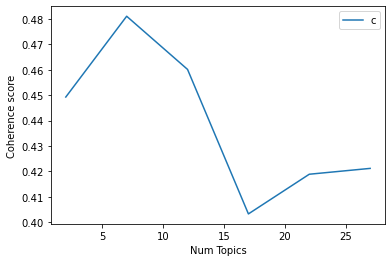

In [95]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_sg_score5)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [96]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_sg_score5):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 7

index: 0 | Num Topics = 2  has Coherence Value of 0.4493
index: 1 | Num Topics = 7  has Coherence Value of 0.4811
index: 2 | Num Topics = 12  has Coherence Value of 0.4602
index: 3 | Num Topics = 17  has Coherence Value of 0.4032
index: 4 | Num Topics = 22  has Coherence Value of 0.4188
index: 5 | Num Topics = 27  has Coherence Value of 0.4211


In [184]:
# Select optimal number of topics
optimal_model_sg_score5 = model_list_sg_score5[1]

In [185]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_sg_score5 = pyLDAvis.gensim_models.prepare(optimal_model_sg_score5, corpus_sg_score5, id2word_sg_score5)

In [186]:
print("pyLDAVis for SG topics for score=5:")
vis_sg_score5

pyLDAVis for SG topics for score=5:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.080510 -0.151930       1        1  21.199943
6     -0.073723  0.005802       2        1  18.498216
1     -0.122999 -0.026728       3        1  14.387501
4     -0.000319  0.066602       4        1  13.134147
0      0.137610  0.077231       5        1  12.411795
3     -0.043494  0.028598       6        1  12.056678
5      0.022415  0.000424       7        1   8.311721, topic_info=              Term       Freq      Total Category  logprob  loglift
52   advertisement  10.000000  10.000000  Default  30.0000  30.0000
7           search  13.000000  13.000000  Default  29.0000  29.0000
205           well  10.000000  10.000000  Default  28.0000  28.0000
87          delete  11.000000  11.000000  Default  27.0000  27.0000
18             app  39.000000  39.000000  Default  26.0000  26.0000
..             ...        ...        ...      ...      ...      ...
157         useful   0.724497   2.886974   Topic7  -5.3107   1.1050
129           back   0.724467   7.181013   Topic7  -5.3107   0.1937
166       continue   0.724315   2.129815   Topic7  -5.3109   1.4089
240         online   0.724293   2.059442   Topic7  -5.3110   1.4425
122            tap   0.724281   5.030640   Topic7  -5.3110   0.5494

[416 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
414       6  0.708130     abit
16        1  0.227876  account
16        2  0.227876  account
16        4  0.227876  account
16        5  0.455753  account
...     ...       ...      ...
158       2  0.530797    world
402       5  0.699671    write
353       2  0.896474    wrong
245       7  0.740678    young
512       6  0.708129     zoom

[578 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 7, 2, 5, 1, 4, 6])

## LDA Topic Modelling (Rating = 1,2,3)

In [100]:
# By-rating Topic Modelling - rating = 1,2,3
# Convert to list - move to each section
review_sg_score1N2N3 = youtube_ios_sg_review_YearMonth_score1N2N3.review.values.tolist()
review_words_sg_score1N2N3 = list(sent_to_words(review_sg_score1N2N3))
print(review_words_sg_score1N2N3[:1])

[['did', 'all', 'remove', 'the', 'download', 'videos', 'offline', 'feature', 'for', 'this', 'app', 'why', 'wasn', 'this', 'on', 'the', 'update', 'logs']]


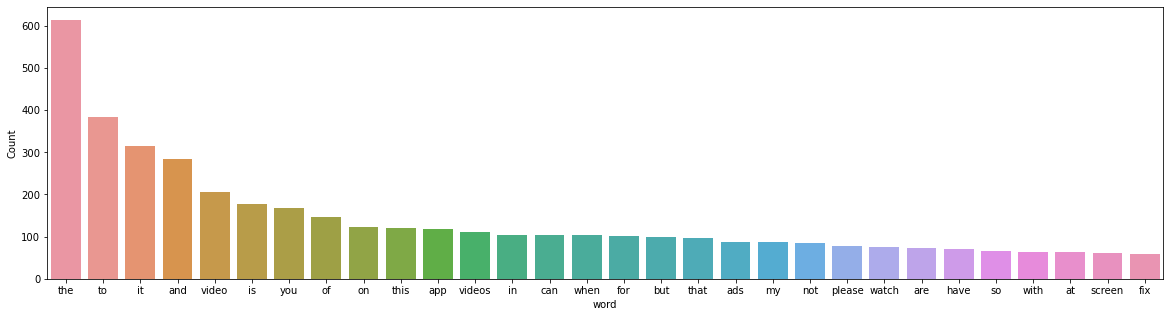

In [101]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_sg_score1N2N3))

In [102]:
# Clean text
review_sg_ready_score1N2N3 = process_words(review_words_sg_score1N2N3)  # processed Text Data! - move to each section

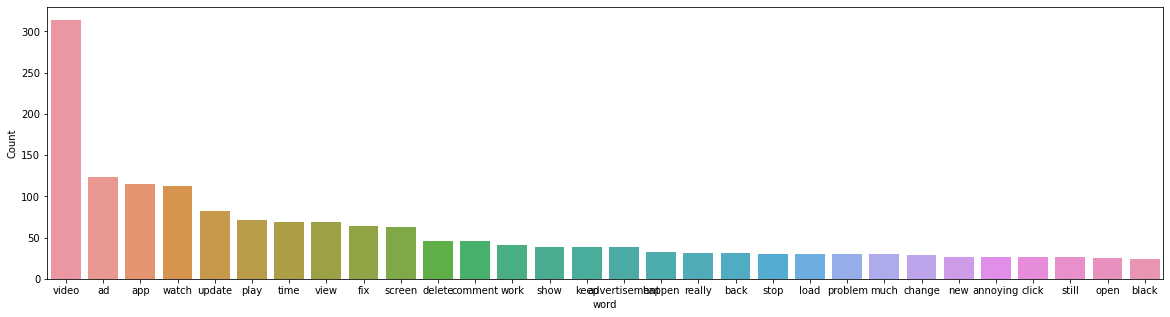

In [103]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_sg_ready_score1N2N3))


In [104]:
# Create Dictionary
id2word_sg_score1N2N3 = corpora.Dictionary(review_sg_ready_score1N2N3)

2021-10-16 23:48:47,445 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 23:48:47,462 [INFO] gensim.corpora.dictionary - built Dictionary(1150 unique tokens: ['app', 'download', 'feature', 'log', 'offline']...) from 392 documents (total 4924 corpus positions)
2021-10-16 23:48:47,464 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(1150 unique tokens: ['app', 'download', 'feature', 'log', 'offline']...) from 392 documents (total 4924 corpus positions)", 'datetime': '2021-10-16T23:48:47.464151', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [105]:
# Create Corpus: Term Document Frequency
corpus_sg_score1N2N3 = [id2word_sg_score1N2N3.doc2bow(text) for text in review_sg_ready_score1N2N3]

In [106]:
# Training LDA model
model_list_sg_score1N2N3, coherence_values_sg_score1N2N3 = compute_coherence_values(dictionary=id2word_sg_score1N2N3, corpus=corpus_sg_score1N2N3, 
                                                              texts=review_sg_ready_score1N2N3, limit=30, start=2, step=5)


2021-10-16 23:48:47,491 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 23:48:47,493 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 23:48:47,496 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 23:48:47,498 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 392 documents, updating model once every 392 documents, evaluating perplexity every 392 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 23:48:49,323 [INFO] gensim.models.ldamodel - -7.646 per-word bound, 200.3 perplexity estimate based on a held-out corpus of 392 documents with 4924 words
2021-10-16 23:48:49,334 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #392/392
2021-10-16 23:48:51,031 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.052*"video" + 0.020*"ad" + 0.016*"watch" + 0.013*"screen" + 0.013*"view" + 0.011*"update" + 0.010*"fix

2021-10-16 23:49:05,911 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.059*"video" + 0.033*"app" + 0.024*"watch" + 0.018*"update" + 0.018*"play" + 0.017*"ad" + 0.015*"time" + 0.014*"fix" + 0.011*"screen" + 0.008*"load"
2021-10-16 23:49:05,918 [INFO] gensim.models.ldamodel - topic diff=0.019840, rho=0.301511
2021-10-16 23:49:06,725 [INFO] gensim.models.ldamodel - -6.365 per-word bound, 82.4 perplexity estimate based on a held-out corpus of 392 documents with 4924 words
2021-10-16 23:49:06,726 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #392/392
2021-10-16 23:49:07,294 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.042*"video" + 0.026*"ad" + 0.020*"view" + 0.012*"advertisement" + 0.012*"watch" + 0.011*"comment" + 0.010*"delete" + 0.010*"screen" + 0.008*"change" + 0.008*"update"
2021-10-16 23:49:07,297 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.059*"video" + 0.033*"app" + 0.024*"watch" + 0.018*"update" + 0.018*"play" + 0.016*"ad" + 0.015*"time" + 0.01

2021-10-16 23:49:18,442 [INFO] gensim.models.ldamodel - topic diff=0.010484, rho=0.218218
2021-10-16 23:49:19,162 [INFO] gensim.models.ldamodel - -6.348 per-word bound, 81.4 perplexity estimate based on a held-out corpus of 392 documents with 4924 words
2021-10-16 23:49:19,163 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #392/392
2021-10-16 23:49:19,775 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.037*"video" + 0.028*"ad" + 0.024*"view" + 0.012*"delete" + 0.012*"comment" + 0.012*"advertisement" + 0.010*"watch" + 0.010*"change" + 0.008*"much" + 0.007*"really"
2021-10-16 23:49:19,777 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.063*"video" + 0.033*"app" + 0.025*"watch" + 0.019*"update" + 0.018*"play" + 0.016*"fix" + 0.016*"ad" + 0.016*"time" + 0.014*"screen" + 0.008*"keep"
2021-10-16 23:49:19,778 [INFO] gensim.models.ldamodel - topic diff=0.010161, rho=0.213201
2021-10-16 23:49:20,354 [INFO] gensim.models.ldamodel - -6.346 per-word bound, 81.4 perplexity e

2021-10-16 23:49:31,472 [INFO] gensim.models.ldamodel - -6.336 per-word bound, 80.8 perplexity estimate based on a held-out corpus of 392 documents with 4924 words
2021-10-16 23:49:31,474 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #392/392
2021-10-16 23:49:32,152 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.033*"video" + 0.028*"ad" + 0.027*"view" + 0.014*"delete" + 0.012*"comment" + 0.011*"advertisement" + 0.011*"change" + 0.009*"watch" + 0.008*"much" + 0.007*"really"
2021-10-16 23:49:32,161 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.066*"video" + 0.033*"app" + 0.026*"watch" + 0.019*"update" + 0.019*"play" + 0.016*"fix" + 0.016*"time" + 0.015*"ad" + 0.015*"screen" + 0.009*"keep"
2021-10-16 23:49:32,165 [INFO] gensim.models.ldamodel - topic diff=0.008668, rho=0.176777
2021-10-16 23:49:33,032 [INFO] gensim.models.ldamodel - -6.335 per-word bound, 80.7 perplexity estimate based on a held-out corpus of 392 documents with 4924 words
2021-10-16 23:49:33,03

2021-10-16 23:49:42,819 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #392/392
2021-10-16 23:49:43,321 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.029*"video" + 0.029*"ad" + 0.027*"view" + 0.015*"delete" + 0.012*"comment" + 0.011*"change" + 0.010*"advertisement" + 0.008*"much" + 0.008*"really" + 0.008*"watch"
2021-10-16 23:49:43,324 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.068*"video" + 0.033*"app" + 0.027*"watch" + 0.020*"update" + 0.019*"play" + 0.017*"fix" + 0.016*"screen" + 0.015*"time" + 0.014*"ad" + 0.009*"keep"
2021-10-16 23:49:43,325 [INFO] gensim.models.ldamodel - topic diff=0.007241, rho=0.154303
2021-10-16 23:49:44,030 [INFO] gensim.models.ldamodel - -6.325 per-word bound, 80.2 perplexity estimate based on a held-out corpus of 392 documents with 4924 words
2021-10-16 23:49:44,032 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #392/392
2021-10-16 23:49:44,452 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.029*"ad" + 0.0

2021-10-16 23:49:54,315 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 23:49:59,452 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 23:49:59,523 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 367 virtual documents
2021-10-16 23:50:00,030 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-16 23:50:00,031 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
2021-10-16 23:50:00,033 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 23:50:00,037 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 7 topics, 50 passes over the supplied corpus of 392 documents, updating model once every 392 documents, evaluating perplexity every 392 documents, iterating 50x with a con

2021-10-16 23:50:08,183 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.046*"ad" + 0.041*"video" + 0.021*"screen" + 0.018*"watch" + 0.017*"fix" + 0.012*"update" + 0.012*"black" + 0.011*"show" + 0.011*"comment" + 0.010*"sometimes"
2021-10-16 23:50:08,185 [INFO] gensim.models.ldamodel - topic diff=0.069332, rho=0.408248
2021-10-16 23:50:08,888 [INFO] gensim.models.ldamodel - -6.647 per-word bound, 100.2 perplexity estimate based on a held-out corpus of 392 documents with 4924 words
2021-10-16 23:50:08,890 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #392/392
2021-10-16 23:50:09,422 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.062*"video" + 0.035*"watch" + 0.034*"ad" + 0.022*"comment" + 0.020*"app" + 0.017*"play" + 0.017*"fix" + 0.016*"back" + 0.013*"add" + 0.011*"bottom"
2021-10-16 23:50:09,425 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.060*"video" + 0.046*"view" + 0.022*"advertisement" + 0.020*"delete" + 0.017*"watch" + 0.013*"time" + 0.013*"app" + 0

2021-10-16 23:50:15,463 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.054*"video" + 0.052*"view" + 0.023*"delete" + 0.022*"advertisement" + 0.017*"watch" + 0.014*"time" + 0.012*"app" + 0.011*"stop" + 0.010*"fix" + 0.009*"bug"
2021-10-16 23:50:15,467 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.017*"delete" + 0.015*"view" + 0.013*"experience" + 0.013*"really" + 0.013*"video" + 0.010*"star" + 0.009*"ad" + 0.008*"dislike" + 0.008*"hard" + 0.008*"middle"
2021-10-16 23:50:15,483 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.054*"ad" + 0.040*"video" + 0.019*"screen" + 0.019*"watch" + 0.016*"fix" + 0.012*"skip" + 0.011*"comment" + 0.010*"update" + 0.010*"show" + 0.010*"black"
2021-10-16 23:50:15,486 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.061*"video" + 0.034*"watch" + 0.030*"ad" + 0.025*"comment" + 0.018*"app" + 0.018*"fix" + 0.017*"back" + 0.014*"play" + 0.014*"add" + 0.012*"bottom"
2021-10-16 23:50:15,494 [INFO] gensim.models.ldamodel - topic diff=0.020485, rh

2021-10-16 23:50:21,471 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.058*"ad" + 0.040*"video" + 0.019*"watch" + 0.014*"screen" + 0.013*"fix" + 0.013*"skip" + 0.010*"comment" + 0.009*"minute" + 0.009*"time" + 0.008*"show"
2021-10-16 23:50:21,480 [INFO] gensim.models.ldamodel - topic diff=0.011923, rho=0.242536
2021-10-16 23:50:22,193 [INFO] gensim.models.ldamodel - -6.600 per-word bound, 97.0 perplexity estimate based on a held-out corpus of 392 documents with 4924 words
2021-10-16 23:50:22,204 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #392/392
2021-10-16 23:50:22,572 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.059*"ad" + 0.040*"video" + 0.020*"watch" + 0.013*"fix" + 0.013*"screen" + 0.013*"skip" + 0.010*"comment" + 0.009*"minute" + 0.009*"time" + 0.008*"show"
2021-10-16 23:50:22,575 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.018*"delete" + 0.015*"view" + 0.014*"experience" + 0.014*"really" + 0.012*"video" + 0.010*"star" + 0.009*"ad" + 0.008*

2021-10-16 23:50:27,614 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.018*"delete" + 0.015*"view" + 0.014*"experience" + 0.014*"really" + 0.011*"video" + 0.011*"star" + 0.008*"dislike" + 0.008*"hard" + 0.008*"work" + 0.008*"give"
2021-10-16 23:50:27,622 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.013*"comment" + 0.012*"watch" + 0.012*"update" + 0.012*"still" + 0.011*"show" + 0.010*"volume" + 0.010*"app" + 0.009*"delete" + 0.008*"way" + 0.008*"account"
2021-10-16 23:50:27,626 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.085*"video" + 0.040*"app" + 0.026*"play" + 0.026*"update" + 0.026*"ad" + 0.024*"watch" + 0.022*"screen" + 0.018*"time" + 0.014*"load" + 0.013*"fix"
2021-10-16 23:50:27,631 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.061*"video" + 0.033*"watch" + 0.029*"comment" + 0.026*"ad" + 0.019*"fix" + 0.018*"app" + 0.017*"back" + 0.013*"add" + 0.013*"play" + 0.012*"section"
2021-10-16 23:50:27,634 [INFO] gensim.models.ldamodel - topic diff=0.007147, rho=

2021-10-16 23:50:33,031 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.013*"comment" + 0.012*"watch" + 0.012*"update" + 0.012*"still" + 0.011*"show" + 0.010*"volume" + 0.009*"app" + 0.008*"delete" + 0.008*"way" + 0.008*"screen"
2021-10-16 23:50:33,039 [INFO] gensim.models.ldamodel - topic diff=0.005748, rho=0.188982
2021-10-16 23:50:33,621 [INFO] gensim.models.ldamodel - -6.585 per-word bound, 96.0 perplexity estimate based on a held-out corpus of 392 documents with 4924 words
2021-10-16 23:50:33,625 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #392/392
2021-10-16 23:50:34,185 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.063*"view" + 0.043*"video" + 0.027*"delete" + 0.021*"advertisement" + 0.015*"watch" + 0.013*"time" + 0.012*"stop" + 0.012*"app" + 0.010*"fix" + 0.010*"bug"
2021-10-16 23:50:34,204 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.060*"video" + 0.032*"watch" + 0.030*"comment" + 0.025*"ad" + 0.019*"fix" + 0.018*"app" + 0.017*"back" + 0.014

2021-10-16 23:50:39,807 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.015*"delete" + 0.015*"experience" + 0.014*"really" + 0.011*"star" + 0.010*"video" + 0.009*"view" + 0.008*"dislike" + 0.008*"hard" + 0.008*"give" + 0.008*"middle"
2021-10-16 23:50:39,810 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.068*"ad" + 0.044*"video" + 0.020*"watch" + 0.016*"skip" + 0.010*"minute" + 0.010*"fix" + 0.009*"comment" + 0.009*"much" + 0.008*"sometimes" + 0.008*"time"
2021-10-16 23:50:39,812 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.014*"comment" + 0.012*"still" + 0.011*"watch" + 0.011*"show" + 0.011*"update" + 0.011*"volume" + 0.008*"screen" + 0.008*"hide" + 0.007*"way" + 0.007*"minute"
2021-10-16 23:50:39,814 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.060*"video" + 0.031*"comment" + 0.031*"watch" + 0.024*"ad" + 0.020*"fix" + 0.018*"app" + 0.017*"back" + 0.014*"section" + 0.013*"add" + 0.013*"play"
2021-10-16 23:50:39,817 [INFO] gensim.models.ldamodel - topic diff=0.004

2021-10-16 23:50:45,074 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.015*"experience" + 0.014*"really" + 0.014*"delete" + 0.011*"star" + 0.010*"video" + 0.008*"dislike" + 0.008*"hard" + 0.008*"give" + 0.008*"middle" + 0.007*"keep"
2021-10-16 23:50:45,086 [INFO] gensim.models.ldamodel - topic diff=0.003579, rho=0.160128
2021-10-16 23:50:45,788 [INFO] gensim.models.ldamodel - -6.575 per-word bound, 95.4 perplexity estimate based on a held-out corpus of 392 documents with 4924 words
2021-10-16 23:50:45,790 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #392/392
2021-10-16 23:50:46,204 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.014*"comment" + 0.012*"still" + 0.011*"show" + 0.011*"volume" + 0.011*"watch" + 0.010*"update" + 0.009*"hide" + 0.008*"screen" + 0.007*"minute" + 0.007*"account"
2021-10-16 23:50:46,209 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.022*"picture" + 0.021*"work" + 0.020*"video" + 0.016*"mode" + 0.014*"change" + 0.014*"update" + 0.

2021-10-16 23:50:50,817 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.067*"view" + 0.040*"video" + 0.031*"delete" + 0.020*"advertisement" + 0.014*"watch" + 0.014*"time" + 0.013*"app" + 0.012*"stop" + 0.010*"fix" + 0.009*"bug"
2021-10-16 23:50:50,820 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.060*"video" + 0.033*"comment" + 0.030*"watch" + 0.023*"ad" + 0.021*"fix" + 0.017*"app" + 0.016*"section" + 0.015*"back" + 0.013*"add" + 0.013*"play"
2021-10-16 23:50:50,822 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.014*"comment" + 0.012*"still" + 0.011*"show" + 0.011*"volume" + 0.011*"watch" + 0.010*"update" + 0.009*"hide" + 0.009*"screen" + 0.007*"minute" + 0.007*"account"
2021-10-16 23:50:50,825 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.022*"picture" + 0.021*"work" + 0.020*"video" + 0.016*"mode" + 0.014*"change" + 0.014*"update" + 0.012*"hard" + 0.011*"quality" + 0.011*"ad" + 0.010*"allow"
2021-10-16 23:50:50,826 [INFO] gensim.models.ldamodel - topic diff=0.0031

2021-10-16 23:50:55,844 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.075*"ad" + 0.044*"video" + 0.020*"skip" + 0.018*"watch" + 0.010*"minute" + 0.010*"much" + 0.009*"comment" + 0.008*"fix" + 0.007*"show" + 0.007*"time"
2021-10-16 23:50:55,859 [INFO] gensim.models.ldamodel - topic diff=0.002743, rho=0.141421
2021-10-16 23:50:56,362 [INFO] gensim.models.ldamodel - -6.569 per-word bound, 94.9 perplexity estimate based on a held-out corpus of 392 documents with 4924 words
2021-10-16 23:50:56,381 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #392/392
2021-10-16 23:50:56,714 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.059*"video" + 0.034*"comment" + 0.029*"watch" + 0.022*"ad" + 0.021*"fix" + 0.017*"app" + 0.016*"section" + 0.014*"back" + 0.013*"add" + 0.012*"play"
2021-10-16 23:50:56,715 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.067*"view" + 0.040*"video" + 0.032*"delete" + 0.020*"advertisement" + 0.014*"time" + 0.014*"watch" + 0.013*"app" + 0.012*"s

2021-10-16 23:51:10,754 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.054*"view" + 0.031*"delete" + 0.028*"watch" + 0.018*"time" + 0.017*"video" + 0.016*"screen" + 0.013*"work" + 0.013*"hard" + 0.012*"update" + 0.011*"back"
2021-10-16 23:51:10,756 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.048*"video" + 0.032*"comment" + 0.022*"add" + 0.017*"app" + 0.017*"way" + 0.015*"crash" + 0.015*"section" + 0.013*"update" + 0.011*"new" + 0.010*"issue"
2021-10-16 23:51:10,758 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.073*"video" + 0.033*"watch" + 0.029*"update" + 0.026*"app" + 0.024*"ad" + 0.022*"load" + 0.022*"keep" + 0.019*"play" + 0.014*"search" + 0.013*"issue"
2021-10-16 23:51:10,764 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.040*"change" + 0.040*"update" + 0.024*"picture" + 0.023*"comment" + 0.016*"stop" + 0.015*"annoying" + 0.013*"work" + 0.013*"delete" + 0.013*"video" + 0.013*"section"
2021-10-16 23:51:10,766 [INFO] gensim.models.ldamodel - topic diff=0.100

2021-10-16 23:51:16,853 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.049*"video" + 0.033*"comment" + 0.022*"add" + 0.021*"way" + 0.016*"app" + 0.015*"section" + 0.013*"crash" + 0.012*"new" + 0.011*"update" + 0.010*"issue"
2021-10-16 23:51:16,854 [INFO] gensim.models.ldamodel - topic diff=0.025987, rho=0.316228
2021-10-16 23:51:17,541 [INFO] gensim.models.ldamodel - -6.775 per-word bound, 109.5 perplexity estimate based on a held-out corpus of 392 documents with 4924 words
2021-10-16 23:51:17,546 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #392/392
2021-10-16 23:51:17,931 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.045*"change" + 0.041*"update" + 0.027*"comment" + 0.025*"picture" + 0.017*"section" + 0.015*"annoying" + 0.013*"stop" + 0.012*"last" + 0.012*"video" + 0.011*"work"
2021-10-16 23:51:17,933 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.064*"ad" + 0.060*"video" + 0.029*"advertisement" + 0.021*"fix" + 0.020*"watch" + 0.017*"screen" + 0.014*

2021-10-16 23:51:22,622 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.028*"mode" + 0.021*"video" + 0.018*"work" + 0.017*"picture" + 0.014*"app" + 0.014*"fix" + 0.013*"quality" + 0.011*"allow" + 0.011*"search" + 0.011*"turn"
2021-10-16 23:51:22,623 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.086*"view" + 0.048*"delete" + 0.027*"hard" + 0.025*"watch" + 0.024*"work" + 0.017*"time" + 0.015*"video" + 0.013*"screen" + 0.011*"update" + 0.011*"back"
2021-10-16 23:51:22,625 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.072*"video" + 0.037*"view" + 0.027*"watch" + 0.020*"delete" + 0.014*"play" + 0.013*"advertisement" + 0.012*"time" + 0.012*"fix" + 0.011*"app" + 0.010*"problem"
2021-10-16 23:51:22,627 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.039*"screen" + 0.030*"black" + 0.017*"show" + 0.016*"app" + 0.015*"close" + 0.014*"annoying" + 0.013*"video" + 0.013*"watch" + 0.012*"update" + 0.012*"fix"
2021-10-16 23:51:22,629 [INFO] gensim.models.ldamodel - topic diff=0.00

2021-10-16 23:51:29,420 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.044*"video" + 0.022*"time" + 0.015*"still" + 0.013*"comment" + 0.013*"show" + 0.013*"anymore" + 0.011*"back" + 0.010*"change" + 0.010*"dislike" + 0.010*"find"
2021-10-16 23:51:29,421 [INFO] gensim.models.ldamodel - topic diff=0.005399, rho=0.218218
2021-10-16 23:51:30,427 [INFO] gensim.models.ldamodel - -6.756 per-word bound, 108.1 perplexity estimate based on a held-out corpus of 392 documents with 4924 words
2021-10-16 23:51:30,438 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #392/392
2021-10-16 23:51:30,928 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.066*"ad" + 0.061*"video" + 0.029*"advertisement" + 0.021*"watch" + 0.020*"fix" + 0.016*"screen" + 0.015*"much" + 0.012*"appear" + 0.010*"skip" + 0.010*"click"
2021-10-16 23:51:30,935 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.087*"view" + 0.051*"delete" + 0.029*"hard" + 0.027*"work" + 0.024*"watch" + 0.016*"time" + 0.014*"video

2021-10-16 23:51:36,821 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.072*"video" + 0.034*"view" + 0.027*"watch" + 0.018*"delete" + 0.014*"play" + 0.014*"advertisement" + 0.012*"time" + 0.012*"fix" + 0.011*"app" + 0.010*"problem"
2021-10-16 23:51:36,823 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.064*"video" + 0.039*"app" + 0.034*"ad" + 0.024*"update" + 0.019*"play" + 0.015*"screen" + 0.015*"really" + 0.013*"time" + 0.012*"watch" + 0.012*"problem"
2021-10-16 23:51:36,825 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.080*"video" + 0.045*"ad" + 0.041*"app" + 0.038*"watch" + 0.028*"play" + 0.023*"time" + 0.018*"fix" + 0.017*"click" + 0.016*"open" + 0.016*"stop"
2021-10-16 23:51:36,829 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.028*"mode" + 0.021*"video" + 0.017*"work" + 0.017*"picture" + 0.015*"app" + 0.014*"fix" + 0.013*"quality" + 0.011*"allow" + 0.011*"search" + 0.011*"turn"
2021-10-16 23:51:36,830 [INFO] gensim.models.ldamodel - topic diff=0.003298, rho=0.

2021-10-16 23:51:42,295 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.050*"change" + 0.044*"update" + 0.031*"comment" + 0.026*"picture" + 0.018*"section" + 0.013*"last" + 0.012*"video" + 0.011*"stop" + 0.011*"thumbnail" + 0.010*"resolution"
2021-10-16 23:51:42,296 [INFO] gensim.models.ldamodel - topic diff=0.001985, rho=0.176777
2021-10-16 23:51:43,059 [INFO] gensim.models.ldamodel - -6.750 per-word bound, 107.6 perplexity estimate based on a held-out corpus of 392 documents with 4924 words
2021-10-16 23:51:43,067 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #392/392
2021-10-16 23:51:43,685 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.064*"video" + 0.039*"app" + 0.034*"ad" + 0.024*"update" + 0.019*"play" + 0.015*"really" + 0.014*"screen" + 0.013*"time" + 0.012*"watch" + 0.012*"problem"
2021-10-16 23:51:43,690 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.045*"screen" + 0.038*"black" + 0.019*"show" + 0.017*"annoying" + 0.016*"app" + 0.015*"vid" + 0.

2021-10-16 23:51:48,948 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.051*"change" + 0.044*"update" + 0.031*"comment" + 0.026*"picture" + 0.018*"section" + 0.013*"last" + 0.012*"video" + 0.011*"stop" + 0.011*"thumbnail" + 0.010*"resolution"
2021-10-16 23:51:48,950 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.028*"mode" + 0.021*"video" + 0.017*"work" + 0.017*"picture" + 0.015*"app" + 0.014*"fix" + 0.013*"quality" + 0.011*"allow" + 0.011*"search" + 0.011*"turn"
2021-10-16 23:51:48,954 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.093*"view" + 0.057*"delete" + 0.029*"hard" + 0.028*"work" + 0.024*"watch" + 0.016*"time" + 0.014*"video" + 0.013*"screen" + 0.011*"update" + 0.011*"give"
2021-10-16 23:51:48,957 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.050*"video" + 0.033*"comment" + 0.023*"add" + 0.023*"way" + 0.015*"section" + 0.015*"app" + 0.013*"crash" + 0.012*"new" + 0.010*"update" + 0.010*"issue"
2021-10-16 23:51:48,960 [INFO] gensim.models.ldamodel - topic d

2021-10-16 23:51:54,182 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.073*"video" + 0.031*"view" + 0.027*"watch" + 0.016*"delete" + 0.014*"play" + 0.014*"advertisement" + 0.012*"time" + 0.012*"fix" + 0.011*"app" + 0.010*"problem"
2021-10-16 23:51:54,183 [INFO] gensim.models.ldamodel - topic diff=0.001041, rho=0.152499
2021-10-16 23:51:54,757 [INFO] gensim.models.ldamodel - -6.749 per-word bound, 107.5 perplexity estimate based on a held-out corpus of 392 documents with 4924 words
2021-10-16 23:51:54,761 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #392/392
2021-10-16 23:51:55,184 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.074*"video" + 0.032*"watch" + 0.032*"update" + 0.026*"app" + 0.024*"load" + 0.022*"keep" + 0.022*"ad" + 0.020*"play" + 0.014*"issue" + 0.014*"search"
2021-10-16 23:51:55,187 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.080*"video" + 0.045*"ad" + 0.041*"app" + 0.038*"watch" + 0.028*"play" + 0.024*"time" + 0.018*"fix" + 0.017*"cli

2021-10-16 23:52:00,371 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.022*"video" + 0.011*"whenever" + 0.011*"help" + 0.011*"issue" + 0.011*"bring" + 0.011*"country" + 0.006*"back" + 0.006*"double" + 0.006*"audio" + 0.006*"well"
2021-10-16 23:52:00,375 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.073*"video" + 0.031*"view" + 0.027*"watch" + 0.016*"delete" + 0.015*"play" + 0.014*"advertisement" + 0.012*"time" + 0.012*"fix" + 0.011*"app" + 0.010*"problem"
2021-10-16 23:52:00,383 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.041*"video" + 0.016*"still" + 0.015*"time" + 0.014*"show" + 0.014*"comment" + 0.014*"anymore" + 0.011*"back" + 0.010*"dislike" + 0.010*"find" + 0.010*"change"
2021-10-16 23:52:00,392 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.050*"video" + 0.033*"comment" + 0.023*"add" + 0.023*"way" + 0.015*"section" + 0.015*"app" + 0.013*"crash" + 0.012*"new" + 0.010*"update" + 0.010*"issue"
2021-10-16 23:52:00,398 [INFO] gensim.models.ldamodel - topic di

2021-10-16 23:52:14,703 [INFO] gensim.models.ldamodel - topic diff=0.157686, rho=0.577350
2021-10-16 23:52:15,274 [INFO] gensim.models.ldamodel - -7.025 per-word bound, 130.3 perplexity estimate based on a held-out corpus of 392 documents with 4924 words
2021-10-16 23:52:15,276 [INFO] gensim.models.ldamodel - PROGRESS: pass 2, at document #392/392
2021-10-16 23:52:15,819 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.041*"video" + 0.024*"app" + 0.022*"crash" + 0.018*"update" + 0.014*"issue" + 0.014*"new" + 0.013*"star" + 0.013*"feature" + 0.010*"start" + 0.010*"second"
2021-10-16 23:52:15,821 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.075*"video" + 0.039*"watch" + 0.039*"app" + 0.027*"play" + 0.027*"ad" + 0.019*"fix" + 0.013*"back" + 0.013*"really" + 0.012*"bottom" + 0.012*"happen"
2021-10-16 23:52:15,822 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.036*"update" + 0.035*"comment" + 0.027*"video" + 0.022*"section" + 0.019*"fix" + 0.018*"back" + 0.013*"ad" + 0.012*

2021-10-16 23:52:20,816 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.043*"comment" + 0.039*"update" + 0.030*"section" + 0.029*"video" + 0.020*"back" + 0.020*"fix" + 0.013*"time" + 0.012*"play" + 0.012*"ad" + 0.012*"app"
2021-10-16 23:52:20,818 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.071*"video" + 0.039*"app" + 0.036*"watch" + 0.025*"play" + 0.020*"fix" + 0.017*"ad" + 0.016*"back" + 0.014*"bottom" + 0.014*"really" + 0.014*"top"
2021-10-16 23:52:20,822 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.106*"view" + 0.062*"delete" + 0.031*"work" + 0.027*"hard" + 0.017*"video" + 0.015*"give" + 0.014*"app" + 0.012*"really" + 0.012*"bot" + 0.012*"account"
2021-10-16 23:52:20,823 [INFO] gensim.models.ldamodel - topic diff=0.042582, rho=0.333333
2021-10-16 23:52:21,554 [INFO] gensim.models.ldamodel - -6.880 per-word bound, 117.8 perplexity estimate based on a held-out corpus of 392 documents with 4924 words
2021-10-16 23:52:21,555 [INFO] gensim.models.ldamodel - PROGRESS:

2021-10-16 23:52:26,969 [INFO] gensim.models.ldamodel - -6.851 per-word bound, 115.4 perplexity estimate based on a held-out corpus of 392 documents with 4924 words
2021-10-16 23:52:26,971 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #392/392
2021-10-16 23:52:27,566 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.098*"video" + 0.058*"ad" + 0.051*"watch" + 0.028*"play" + 0.025*"load" + 0.022*"keep" + 0.019*"app" + 0.017*"time" + 0.016*"issue" + 0.014*"advertisement"
2021-10-16 23:52:27,569 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.030*"mode" + 0.025*"video" + 0.023*"work" + 0.019*"turn" + 0.017*"picture" + 0.017*"allow" + 0.015*"fix" + 0.014*"screen" + 0.014*"quality" + 0.011*"never"
2021-10-16 23:52:27,571 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.054*"video" + 0.053*"ad" + 0.031*"screen" + 0.022*"watch" + 0.019*"playlist" + 0.013*"fix" + 0.013*"option" + 0.013*"lock" + 0.013*"pay" + 0.012*"happen"
2021-10-16 23:52:27,574 [INFO] gensim.models.l

2021-10-16 23:52:33,685 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.051*"video" + 0.034*"view" + 0.025*"watch" + 0.019*"fix" + 0.019*"advertisement" + 0.016*"time" + 0.012*"app" + 0.012*"delete" + 0.010*"show" + 0.010*"page"
2021-10-16 23:52:33,686 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.043*"update" + 0.036*"change" + 0.021*"work" + 0.018*"delete" + 0.016*"way" + 0.016*"comment" + 0.015*"ad" + 0.013*"picture" + 0.012*"stop" + 0.012*"app"
2021-10-16 23:52:33,688 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.030*"mode" + 0.025*"video" + 0.023*"work" + 0.019*"turn" + 0.017*"picture" + 0.017*"allow" + 0.015*"fix" + 0.015*"screen" + 0.014*"quality" + 0.012*"never"
2021-10-16 23:52:33,690 [INFO] gensim.models.ldamodel - topic diff=0.007763, rho=0.223607
2021-10-16 23:52:34,196 [INFO] gensim.models.ldamodel - -6.837 per-word bound, 114.3 perplexity estimate based on a held-out corpus of 392 documents with 4924 words
2021-10-16 23:52:34,198 [INFO] gensim.models.ldamo

2021-10-16 23:52:39,316 [INFO] gensim.models.ldamodel - topic diff=0.004656, rho=0.200000
2021-10-16 23:52:39,831 [INFO] gensim.models.ldamodel - -6.830 per-word bound, 113.8 perplexity estimate based on a held-out corpus of 392 documents with 4924 words
2021-10-16 23:52:39,846 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #392/392
2021-10-16 23:52:40,212 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.044*"update" + 0.036*"change" + 0.021*"work" + 0.018*"delete" + 0.016*"way" + 0.016*"comment" + 0.015*"ad" + 0.013*"picture" + 0.012*"stop" + 0.012*"app"
2021-10-16 23:52:40,215 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.082*"video" + 0.020*"back" + 0.019*"screen" + 0.017*"tap" + 0.015*"ad" + 0.015*"time" + 0.015*"channel" + 0.012*"happen" + 0.011*"app" + 0.011*"watch"
2021-10-16 23:52:40,217 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.031*"mode" + 0.025*"video" + 0.023*"work" + 0.020*"turn" + 0.017*"picture" + 0.017*"allow" + 0.015*"fix" + 0.015*"sc

2021-10-16 23:52:45,547 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.082*"video" + 0.020*"back" + 0.019*"screen" + 0.017*"tap" + 0.015*"ad" + 0.015*"time" + 0.015*"channel" + 0.012*"happen" + 0.011*"app" + 0.010*"watch"
2021-10-16 23:52:45,583 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.084*"video" + 0.043*"ad" + 0.039*"app" + 0.033*"update" + 0.024*"play" + 0.022*"watch" + 0.012*"fix" + 0.012*"time" + 0.011*"stop" + 0.011*"still"
2021-10-16 23:52:45,593 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.025*"keep" + 0.020*"video" + 0.020*"download" + 0.015*"time" + 0.015*"play" + 0.010*"app" + 0.010*"watch" + 0.010*"long" + 0.010*"offline" + 0.010*"minute"
2021-10-16 23:52:45,605 [INFO] gensim.models.ldamodel - topic diff=0.002820, rho=0.179605
2021-10-16 23:52:46,189 [INFO] gensim.models.ldamodel - -6.827 per-word bound, 113.6 perplexity estimate based on a held-out corpus of 392 documents with 4924 words
2021-10-16 23:52:46,190 [INFO] gensim.models.ldamodel - PROGRES

2021-10-16 23:52:51,814 [INFO] gensim.models.ldamodel - topic diff=0.001826, rho=0.166667
2021-10-16 23:52:52,465 [INFO] gensim.models.ldamodel - -6.826 per-word bound, 113.5 perplexity estimate based on a held-out corpus of 392 documents with 4924 words
2021-10-16 23:52:52,467 [INFO] gensim.models.ldamodel - PROGRESS: pass 35, at document #392/392
2021-10-16 23:52:52,944 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.051*"video" + 0.035*"view" + 0.025*"watch" + 0.019*"fix" + 0.019*"advertisement" + 0.016*"time" + 0.012*"app" + 0.012*"delete" + 0.011*"show" + 0.009*"page"
2021-10-16 23:52:52,946 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.025*"keep" + 0.020*"video" + 0.020*"download" + 0.015*"time" + 0.015*"play" + 0.010*"app" + 0.010*"watch" + 0.010*"long" + 0.010*"offline" + 0.010*"minute"
2021-10-16 23:52:52,948 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.031*"mode" + 0.025*"video" + 0.024*"work" + 0.020*"turn" + 0.017*"picture" + 0.017*"allow" + 0.015*"fix" + 0

2021-10-16 23:52:58,097 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.057*"ad" + 0.055*"video" + 0.030*"screen" + 0.022*"watch" + 0.019*"playlist" + 0.013*"lock" + 0.013*"option" + 0.013*"pay" + 0.013*"fix" + 0.012*"skip"
2021-10-16 23:52:58,100 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.071*"screen" + 0.053*"video" + 0.044*"add" + 0.040*"black" + 0.031*"show" + 0.025*"click" + 0.025*"advertisement" + 0.020*"vid" + 0.020*"annoying" + 0.016*"whole"
2021-10-16 23:52:58,102 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.071*"video" + 0.039*"app" + 0.036*"watch" + 0.025*"play" + 0.020*"fix" + 0.016*"back" + 0.016*"top" + 0.015*"comment" + 0.014*"really" + 0.014*"bottom"
2021-10-16 23:52:58,104 [INFO] gensim.models.ldamodel - topic diff=0.001468, rho=0.154303
2021-10-16 23:52:58,683 [INFO] gensim.models.ldamodel - -6.824 per-word bound, 113.3 perplexity estimate based on a held-out corpus of 392 documents with 4924 words
2021-10-16 23:52:58,685 [INFO] gensim.models.ldam

2021-10-16 23:53:02,822 [INFO] gensim.models.ldamodel - topic diff=0.001262, rho=0.145865
2021-10-16 23:53:03,287 [INFO] gensim.models.ldamodel - -6.824 per-word bound, 113.3 perplexity estimate based on a held-out corpus of 392 documents with 4924 words
2021-10-16 23:53:03,288 [INFO] gensim.models.ldamodel - PROGRESS: pass 46, at document #392/392
2021-10-16 23:53:03,684 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.025*"fix" + 0.024*"search" + 0.018*"video" + 0.018*"add" + 0.016*"update" + 0.016*"open" + 0.012*"watch" + 0.012*"ad" + 0.012*"much" + 0.012*"return"
2021-10-16 23:53:03,686 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.073*"app" + 0.023*"comment" + 0.018*"delete" + 0.017*"view" + 0.017*"become" + 0.017*"advertisement" + 0.017*"star" + 0.017*"reinstall" + 0.012*"subscription" + 0.012*"ad"
2021-10-16 23:53:03,688 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.050*"video" + 0.035*"view" + 0.025*"watch" + 0.019*"fix" + 0.019*"advertisement" + 0.016*"time" +

2021-10-16 23:53:21,463 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.040*"video" + 0.021*"comment" + 0.017*"change" + 0.016*"watch" + 0.014*"way" + 0.014*"start" + 0.011*"second" + 0.011*"section" + 0.011*"new" + 0.011*"back"
2021-10-16 23:53:21,467 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.036*"video" + 0.018*"time" + 0.018*"delete" + 0.018*"full" + 0.018*"screen" + 0.018*"bad" + 0.012*"youtuber" + 0.012*"show" + 0.012*"comment" + 0.012*"last"
2021-10-16 23:53:21,469 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.065*"video" + 0.030*"ad" + 0.026*"watch" + 0.026*"keep" + 0.023*"app" + 0.023*"update" + 0.023*"show" + 0.022*"play" + 0.014*"load" + 0.013*"annoying"
2021-10-16 23:53:21,476 [INFO] gensim.models.ldamodel - topic diff=17.693850, rho=1.000000
2021-10-16 23:53:22,070 [INFO] gensim.models.ldamodel - -7.244 per-word bound, 151.6 perplexity estimate based on a held-out corpus of 392 documents with 4924 words
2021-10-16 23:53:22,071 [INFO] gensim.models.ldam

2021-10-16 23:53:27,569 [INFO] gensim.models.ldamodel - topic diff=0.062728, rho=0.377964
2021-10-16 23:53:28,105 [INFO] gensim.models.ldamodel - -7.033 per-word bound, 130.9 perplexity estimate based on a held-out corpus of 392 documents with 4924 words
2021-10-16 23:53:28,107 [INFO] gensim.models.ldamodel - PROGRESS: pass 6, at document #392/392
2021-10-16 23:53:28,883 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.106*"video" + 0.033*"app" + 0.028*"home" + 0.028*"click" + 0.024*"page" + 0.019*"advertisement" + 0.016*"watch" + 0.014*"slow" + 0.014*"unable" + 0.013*"close"
2021-10-16 23:53:28,886 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.040*"video" + 0.032*"view" + 0.024*"delete" + 0.016*"watch" + 0.016*"middle" + 0.016*"issue" + 0.016*"airplay" + 0.016*"hard" + 0.016*"work" + 0.008*"really"
2021-10-16 23:53:28,890 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.039*"add" + 0.022*"video" + 0.022*"annoying" + 0.019*"fix" + 0.017*"give" + 0.013*"time" + 0.011*"back

2021-10-16 23:53:37,239 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.034*"video" + 0.029*"work" + 0.027*"annoying" + 0.022*"upload" + 0.021*"screen" + 0.018*"ad" + 0.018*"still" + 0.014*"click" + 0.014*"much" + 0.013*"whole"
2021-10-16 23:53:37,247 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.076*"app" + 0.042*"open" + 0.034*"ad" + 0.025*"crash" + 0.024*"available" + 0.016*"screen" + 0.016*"appear" + 0.016*"subscription" + 0.016*"help" + 0.016*"long"
2021-10-16 23:53:37,249 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.041*"video" + 0.024*"comment" + 0.017*"change" + 0.016*"watch" + 0.014*"start" + 0.014*"section" + 0.014*"second" + 0.012*"way" + 0.011*"account" + 0.011*"different"
2021-10-16 23:53:37,252 [INFO] gensim.models.ldamodel - topic diff=0.019101, rho=0.277350
2021-10-16 23:53:38,281 [INFO] gensim.models.ldamodel - -6.995 per-word bound, 127.6 perplexity estimate based on a held-out corpus of 392 documents with 4924 words
2021-10-16 23:53:38,286 [INFO] 

2021-10-16 23:53:45,471 [INFO] gensim.models.ldamodel - topic diff=0.010617, rho=0.235702
2021-10-16 23:53:46,087 [INFO] gensim.models.ldamodel - -6.985 per-word bound, 126.7 perplexity estimate based on a held-out corpus of 392 documents with 4924 words
2021-10-16 23:53:46,091 [INFO] gensim.models.ldamodel - PROGRESS: pass 17, at document #392/392
2021-10-16 23:53:46,451 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.027*"video" + 0.026*"app" + 0.024*"view" + 0.024*"delete" + 0.021*"watch" + 0.020*"screen" + 0.020*"crash" + 0.019*"stop" + 0.016*"stawp" + 0.012*"problem"
2021-10-16 23:53:46,455 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.057*"view" + 0.028*"delete" + 0.024*"hard" + 0.019*"work" + 0.016*"fix" + 0.015*"video" + 0.014*"music" + 0.014*"time" + 0.013*"way" + 0.012*"app"
2021-10-16 23:53:46,458 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.079*"app" + 0.047*"open" + 0.030*"ad" + 0.024*"available" + 0.023*"crash" + 0.017*"long" + 0.017*"screen" + 0.016*"

2021-10-16 23:53:52,554 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.041*"video" + 0.022*"comment" + 0.017*"change" + 0.017*"watch" + 0.014*"start" + 0.014*"second" + 0.011*"way" + 0.011*"section" + 0.011*"account" + 0.011*"different"
2021-10-16 23:53:52,557 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.031*"bad" + 0.021*"video" + 0.019*"delete" + 0.019*"full" + 0.019*"battery" + 0.019*"hot" + 0.018*"last" + 0.017*"update" + 0.015*"iphone" + 0.013*"second"
2021-10-16 23:53:52,559 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.060*"view" + 0.030*"delete" + 0.026*"hard" + 0.021*"work" + 0.016*"fix" + 0.015*"video" + 0.014*"music" + 0.014*"time" + 0.013*"way" + 0.012*"app"
2021-10-16 23:53:52,561 [INFO] gensim.models.ldamodel - topic diff=0.007215, rho=0.204124
2021-10-16 23:53:53,213 [INFO] gensim.models.ldamodel - -6.974 per-word bound, 125.7 perplexity estimate based on a held-out corpus of 392 documents with 4924 words
2021-10-16 23:53:53,215 [INFO] gensim.models.

2021-10-16 23:53:57,938 [INFO] gensim.models.ldamodel - topic diff=0.005320, rho=0.185695
2021-10-16 23:53:58,702 [INFO] gensim.models.ldamodel - -6.967 per-word bound, 125.1 perplexity estimate based on a held-out corpus of 392 documents with 4924 words
2021-10-16 23:53:58,705 [INFO] gensim.models.ldamodel - PROGRESS: pass 28, at document #392/392
2021-10-16 23:53:59,219 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.072*"video" + 0.028*"app" + 0.023*"screen" + 0.019*"ad" + 0.018*"hope" + 0.018*"really" + 0.018*"play" + 0.017*"update" + 0.017*"time" + 0.017*"show"
2021-10-16 23:53:59,220 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.039*"video" + 0.036*"screen" + 0.031*"app" + 0.023*"black" + 0.018*"watch" + 0.018*"full" + 0.016*"happen" + 0.013*"time" + 0.013*"tap" + 0.013*"exit"
2021-10-16 23:53:59,223 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.033*"picture" + 0.032*"update" + 0.029*"change" + 0.026*"ad" + 0.021*"video" + 0.019*"stop" + 0.017*"time" + 0.016*"new

2021-10-16 23:54:04,836 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.038*"mode" + 0.024*"fix" + 0.023*"app" + 0.022*"update" + 0.021*"video" + 0.017*"picture" + 0.016*"work" + 0.016*"feature" + 0.013*"allow" + 0.013*"quality"
2021-10-16 23:54:04,840 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.031*"annoying" + 0.028*"work" + 0.026*"video" + 0.024*"upload" + 0.023*"screen" + 0.019*"ad" + 0.019*"still" + 0.014*"much" + 0.014*"whole" + 0.014*"appear"
2021-10-16 23:54:04,843 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.091*"video" + 0.040*"view" + 0.025*"play" + 0.025*"watch" + 0.018*"fix" + 0.018*"delete" + 0.018*"problem" + 0.016*"advertisement" + 0.016*"freeze" + 0.013*"app"
2021-10-16 23:54:04,845 [INFO] gensim.models.ldamodel - topic diff=0.003770, rho=0.169031
2021-10-16 23:54:05,478 [INFO] gensim.models.ldamodel - -6.959 per-word bound, 124.4 perplexity estimate based on a held-out corpus of 392 documents with 4924 words
2021-10-16 23:54:05,480 [INFO] gensim.mo

2021-10-16 23:54:10,222 [INFO] gensim.models.ldamodel - topic diff=0.003070, rho=0.158114
2021-10-16 23:54:10,840 [INFO] gensim.models.ldamodel - -6.954 per-word bound, 124.0 perplexity estimate based on a held-out corpus of 392 documents with 4924 words
2021-10-16 23:54:10,842 [INFO] gensim.models.ldamodel - PROGRESS: pass 39, at document #392/392
2021-10-16 23:54:11,257 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.071*"video" + 0.036*"keep" + 0.034*"watch" + 0.030*"app" + 0.028*"update" + 0.025*"load" + 0.023*"search" + 0.021*"show" + 0.019*"play" + 0.014*"unable"
2021-10-16 23:54:11,266 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.071*"video" + 0.039*"watch" + 0.032*"play" + 0.031*"app" + 0.024*"ad" + 0.016*"screen" + 0.013*"back" + 0.013*"user" + 0.012*"change" + 0.012*"fix"
2021-10-16 23:54:11,269 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.100*"app" + 0.056*"open" + 0.023*"crash" + 0.023*"available" + 0.021*"long" + 0.016*"screen" + 0.015*"subscription" + 0

2021-10-16 23:54:18,508 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.072*"comment" + 0.061*"update" + 0.042*"section" + 0.025*"time" + 0.025*"video" + 0.023*"crash" + 0.022*"fix" + 0.019*"back" + 0.017*"late" + 0.016*"play"
2021-10-16 23:54:18,513 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.032*"bad" + 0.019*"delete" + 0.019*"full" + 0.019*"battery" + 0.019*"hot" + 0.019*"video" + 0.018*"last" + 0.015*"update" + 0.015*"iphone" + 0.013*"second"
2021-10-16 23:54:18,515 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.041*"video" + 0.018*"change" + 0.017*"watch" + 0.015*"comment" + 0.015*"start" + 0.014*"second" + 0.012*"way" + 0.011*"account" + 0.011*"different" + 0.011*"keep"
2021-10-16 23:54:18,518 [INFO] gensim.models.ldamodel - topic diff=0.002403, rho=0.147442
2021-10-16 23:54:19,472 [INFO] gensim.models.ldamodel - -6.950 per-word bound, 123.7 perplexity estimate based on a held-out corpus of 392 documents with 4924 words
2021-10-16 23:54:19,474 [INFO] gensim.mo

2021-10-16 23:54:26,395 [INFO] gensim.models.ldamodel - topic diff=0.001941, rho=0.140028
2021-10-16 23:54:26,399 [INFO] gensim.utils - LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=1150, num_topics=22, decay=0.5, chunksize=1000) in 67.02s', 'datetime': '2021-10-16T23:54:26.398905', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2021-10-16 23:54:26,412 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 23:54:35,015 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 23:54:35,133 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 383 virtual documents
2021-10-16 23:54:41,221 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.037037037037037035
2021-10-

2021-10-16 23:54:48,209 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.047*"ad" + 0.039*"video" + 0.024*"delete" + 0.024*"view" + 0.021*"app" + 0.021*"watch" + 0.016*"screen" + 0.014*"stop" + 0.014*"time" + 0.011*"play"
2021-10-16 23:54:48,212 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.035*"watch" + 0.024*"video" + 0.023*"update" + 0.023*"time" + 0.023*"sometimes" + 0.012*"black" + 0.012*"show" + 0.012*"screen" + 0.012*"new" + 0.012*"uninstall"
2021-10-16 23:54:48,214 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.086*"video" + 0.024*"time" + 0.018*"watch" + 0.018*"unable" + 0.017*"happen" + 0.017*"issue" + 0.017*"annoy" + 0.017*"ad" + 0.016*"nowadays" + 0.016*"skip"
2021-10-16 23:54:48,216 [INFO] gensim.models.ldamodel - topic diff=0.099026, rho=0.408248
2021-10-16 23:54:48,970 [INFO] gensim.models.ldamodel - -7.122 per-word bound, 139.3 perplexity estimate based on a held-out corpus of 392 documents with 4924 words
2021-10-16 23:54:48,971 [INFO] gensim.models.lda

2021-10-16 23:54:54,847 [INFO] gensim.models.ldamodel - topic diff=0.034802, rho=0.301511
2021-10-16 23:54:55,592 [INFO] gensim.models.ldamodel - -7.063 per-word bound, 133.7 perplexity estimate based on a held-out corpus of 392 documents with 4924 words
2021-10-16 23:54:55,596 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #392/392
2021-10-16 23:54:56,101 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.054*"video" + 0.042*"app" + 0.030*"update" + 0.024*"comment" + 0.018*"crash" + 0.012*"mode" + 0.012*"restricted" + 0.012*"start" + 0.012*"annoying" + 0.012*"new"
2021-10-16 23:54:56,108 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.036*"video" + 0.029*"mode" + 0.016*"watch" + 0.014*"work" + 0.014*"turn" + 0.014*"channel" + 0.014*"recommend" + 0.014*"really" + 0.014*"way" + 0.014*"click"
2021-10-16 23:54:56,112 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.035*"watch" + 0.023*"video" + 0.023*"update" + 0.023*"sometimes" + 0.023*"time" + 0.012*"black" + 0

2021-10-16 23:55:02,222 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.054*"video" + 0.042*"app" + 0.030*"update" + 0.024*"comment" + 0.018*"crash" + 0.012*"mode" + 0.012*"restricted" + 0.012*"start" + 0.012*"annoying" + 0.012*"fix"
2021-10-16 23:55:02,223 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.075*"add" + 0.031*"video" + 0.025*"time" + 0.023*"song" + 0.022*"option" + 0.015*"much" + 0.015*"travel" + 0.015*"start" + 0.015*"function" + 0.015*"button"
2021-10-16 23:55:02,225 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.028*"high" + 0.028*"quality" + 0.028*"choose" + 0.028*"allow" + 0.028*"low" + 0.014*"update" + 0.014*"video" + 0.014*"cause" + 0.014*"hope" + 0.014*"next"
2021-10-16 23:55:02,226 [INFO] gensim.models.ldamodel - topic diff=0.011937, rho=0.242536
2021-10-16 23:55:03,007 [INFO] gensim.models.ldamodel - -7.036 per-word bound, 131.3 perplexity estimate based on a held-out corpus of 392 documents with 4924 words
2021-10-16 23:55:03,010 [INFO] gensim.mo

2021-10-16 23:55:07,956 [INFO] gensim.models.ldamodel - topic diff=0.006968, rho=0.213201
2021-10-16 23:55:08,528 [INFO] gensim.models.ldamodel - -7.027 per-word bound, 130.4 perplexity estimate based on a held-out corpus of 392 documents with 4924 words
2021-10-16 23:55:08,530 [INFO] gensim.models.ldamodel - PROGRESS: pass 21, at document #392/392
2021-10-16 23:55:08,902 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.102*"video" + 0.036*"watch" + 0.033*"play" + 0.031*"ad" + 0.028*"app" + 0.028*"load" + 0.027*"screen" + 0.024*"show" + 0.023*"advertisement" + 0.023*"fix"
2021-10-16 23:55:08,906 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.079*"video" + 0.046*"view" + 0.037*"play" + 0.023*"fix" + 0.021*"delete" + 0.019*"watch" + 0.017*"default" + 0.017*"freeze" + 0.017*"time" + 0.016*"second"
2021-10-16 23:55:08,911 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.059*"update" + 0.046*"video" + 0.031*"fix" + 0.029*"problem" + 0.028*"time" + 0.026*"play" + 0.019*"already" 

2021-10-16 23:55:15,857 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.080*"video" + 0.079*"ad" + 0.050*"watch" + 0.034*"back" + 0.027*"play" + 0.019*"app" + 0.014*"fix" + 0.014*"much" + 0.013*"comment" + 0.013*"long"
2021-10-16 23:55:15,860 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.042*"ad" + 0.028*"subscription" + 0.028*"irritate" + 0.027*"time" + 0.027*"advertisement" + 0.021*"appear" + 0.021*"airplay" + 0.014*"connect" + 0.014*"find" + 0.014*"still"
2021-10-16 23:55:15,864 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.054*"video" + 0.043*"app" + 0.030*"update" + 0.024*"comment" + 0.018*"crash" + 0.012*"restricted" + 0.012*"mode" + 0.012*"start" + 0.012*"fix" + 0.012*"annoying"
2021-10-16 23:55:15,866 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.059*"update" + 0.046*"video" + 0.031*"fix" + 0.029*"problem" + 0.028*"time" + 0.026*"play" + 0.019*"already" + 0.019*"section" + 0.015*"refresh" + 0.015*"help"
2021-10-16 23:55:15,868 [INFO] gensim.models.ldamo

2021-10-16 23:55:21,995 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.174*"view" + 0.113*"delete" + 0.095*"work" + 0.057*"hard" + 0.022*"stop" + 0.021*"upload" + 0.015*"video" + 0.013*"date" + 0.013*"fake" + 0.010*"instead"
2021-10-16 23:55:21,996 [INFO] gensim.models.ldamodel - topic diff=0.002540, rho=0.174078
2021-10-16 23:55:22,706 [INFO] gensim.models.ldamodel - -7.020 per-word bound, 129.8 perplexity estimate based on a held-out corpus of 392 documents with 4924 words
2021-10-16 23:55:22,709 [INFO] gensim.models.ldamodel - PROGRESS: pass 32, at document #392/392
2021-10-16 23:55:23,190 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.104*"video" + 0.038*"watch" + 0.032*"play" + 0.029*"load" + 0.029*"ad" + 0.029*"app" + 0.028*"screen" + 0.025*"advertisement" + 0.024*"show" + 0.023*"fix"
2021-10-16 23:55:23,193 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.079*"video" + 0.046*"view" + 0.038*"play" + 0.023*"fix" + 0.021*"delete" + 0.018*"watch" + 0.017*"freeze" + 0.0

2021-10-16 23:55:29,493 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.033*"app" + 0.030*"video" + 0.029*"ad" + 0.018*"whenever" + 0.018*"open" + 0.018*"help" + 0.018*"add" + 0.016*"comment" + 0.014*"update" + 0.012*"screen"
2021-10-16 23:55:29,498 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.079*"video" + 0.046*"view" + 0.038*"play" + 0.023*"fix" + 0.021*"delete" + 0.018*"watch" + 0.017*"freeze" + 0.017*"default" + 0.017*"time" + 0.016*"second"
2021-10-16 23:55:29,501 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.102*"video" + 0.055*"search" + 0.041*"app" + 0.041*"watch" + 0.040*"fix" + 0.037*"unable" + 0.016*"vid" + 0.013*"keep" + 0.013*"page" + 0.013*"home"
2021-10-16 23:55:29,503 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.075*"add" + 0.031*"video" + 0.030*"option" + 0.025*"time" + 0.023*"song" + 0.015*"start" + 0.015*"travel" + 0.015*"function" + 0.015*"button" + 0.015*"much"
2021-10-16 23:55:29,512 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.

2021-10-16 23:55:37,095 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.059*"update" + 0.046*"video" + 0.031*"fix" + 0.029*"problem" + 0.028*"time" + 0.026*"play" + 0.019*"already" + 0.019*"section" + 0.015*"help" + 0.015*"refresh"
2021-10-16 23:55:37,097 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.111*"video" + 0.044*"screen" + 0.034*"click" + 0.027*"happen" + 0.023*"fix" + 0.023*"watch" + 0.015*"whenever" + 0.013*"everytime" + 0.013*"annoying" + 0.013*"audio"
2021-10-16 23:55:37,098 [INFO] gensim.models.ldamodel - topic diff=0.001275, rho=0.150756
2021-10-16 23:55:38,207 [INFO] gensim.models.ldamodel - -7.015 per-word bound, 129.3 perplexity estimate based on a held-out corpus of 392 documents with 4924 words
2021-10-16 23:55:38,215 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #392/392
2021-10-16 23:55:38,598 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.080*"change" + 0.050*"update" + 0.030*"picture" + 0.030*"annoying" + 0.030*"resolution" + 0.0

2021-10-16 23:55:43,856 [INFO] gensim.models.ldamodel - PROGRESS: pass 48, at document #392/392
2021-10-16 23:55:44,235 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.083*"video" + 0.033*"skip" + 0.024*"annoy" + 0.022*"time" + 0.017*"watch" + 0.017*"unable" + 0.017*"happen" + 0.017*"ad" + 0.017*"issue" + 0.017*"nowadays"
2021-10-16 23:55:44,238 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.080*"app" + 0.061*"update" + 0.024*"ever" + 0.024*"crash" + 0.023*"time" + 0.022*"late" + 0.019*"able" + 0.015*"watch" + 0.015*"minute" + 0.015*"still"
2021-10-16 23:55:44,241 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.103*"video" + 0.060*"search" + 0.042*"app" + 0.042*"fix" + 0.041*"watch" + 0.037*"unable" + 0.016*"vid" + 0.013*"keep" + 0.013*"page" + 0.013*"home"
2021-10-16 23:55:44,244 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.111*"video" + 0.044*"screen" + 0.034*"click" + 0.027*"happen" + 0.023*"fix" + 0.023*"watch" + 0.015*"whenever" + 0.013*"everytime" + 0.013*"

In [107]:
%store model_list_sg_score1N2N3
%store coherence_values_sg_score1N2N3

Stored 'model_list_sg_score1N2N3' (list)
Stored 'coherence_values_sg_score1N2N3' (list)


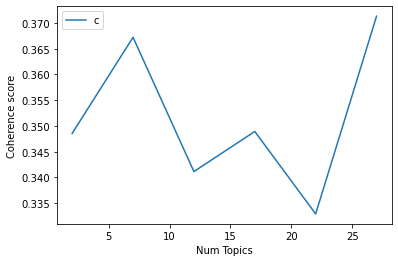

In [108]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_sg_score1N2N3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [109]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_sg_score1N2N3):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 7

index: 0 | Num Topics = 2  has Coherence Value of 0.3486
index: 1 | Num Topics = 7  has Coherence Value of 0.3672
index: 2 | Num Topics = 12  has Coherence Value of 0.3412
index: 3 | Num Topics = 17  has Coherence Value of 0.3489
index: 4 | Num Topics = 22  has Coherence Value of 0.3329
index: 5 | Num Topics = 27  has Coherence Value of 0.3713


In [110]:
# Select optimal number of topics
optimal_model_sg_score1N2N3 = model_list_sg_score1N2N3[1]

In [111]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_sg_score1N2N3 = pyLDAvis.gensim_models.prepare(optimal_model_sg_score1N2N3, corpus_sg_score1N2N3, id2word_sg_score1N2N3)

In [112]:
print("pyLDAVis for SG topics for score=1,2,3:")
vis_sg_score1N2N3

pyLDAVis for SG topics for score=1,2,3:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.167570 -0.001960       1        1  38.564509
3      0.038786 -0.178263       2        1  15.802044
1      0.084322  0.089270       3        1  13.798324
6     -0.080490  0.015738       4        1  11.376880
0     -0.006316  0.091112       5        1   8.755481
2     -0.103795  0.009107       6        1   6.613181
4     -0.100077 -0.025005       7        1   5.089581, topic_info=        Term        Freq       Total Category  logprob  loglift
45        ad  101.000000  101.000000  Default  30.0000  30.0000
106     view   57.000000   57.000000  Default  29.0000  29.0000
264  comment   36.000000   36.000000  Default  28.0000  28.0000
7      video  266.000000  266.000000  Default  27.0000  27.0000
183   delete   38.000000   38.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
177      end    1.030930   10.428349   Topic7  -5.4934   0.6639
79      work    1.214418   34.657358   Topic7  -5.3296  -0.3733
58     watch    1.407011   95.038625   Topic7  -5.1824  -1.2348
106     view    1.258062   57.274670   Topic7  -5.2943  -0.8403
146     well    0.911774   12.834801   Topic7  -5.6163   0.3335

[437 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
663       6  0.453736  absolutely
210       1  0.126351     account
210       2  0.505403     account
210       6  0.252702     account
456       5  0.881331      actual
...     ...       ...         ...
790       7  0.699934         yea
248       3  0.272743    youtuber
248       4  0.272743    youtuber
248       7  0.272743    youtuber
1023      2  0.825120        zoom

[699 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 4, 2, 7, 1, 3, 5])

# By-rating of each year

## By-rating of 2018 (Rating=1,2,3)

In [113]:
# By-rating Topic Modelling - rating = 1,2,3 in 2018
# Convert to list - move to each section
review_sg_2018_score1N2N3 = youtube_ios_sg_review_YearMonth_2018_score1N2N3.review.values.tolist()
review_words_sg_2018_score1N2N3 = list(sent_to_words(review_sg_2018_score1N2N3))
print(review_words_sg_2018_score1N2N3[:1])

[['did', 'all', 'remove', 'the', 'download', 'videos', 'offline', 'feature', 'for', 'this', 'app', 'why', 'wasn', 'this', 'on', 'the', 'update', 'logs']]


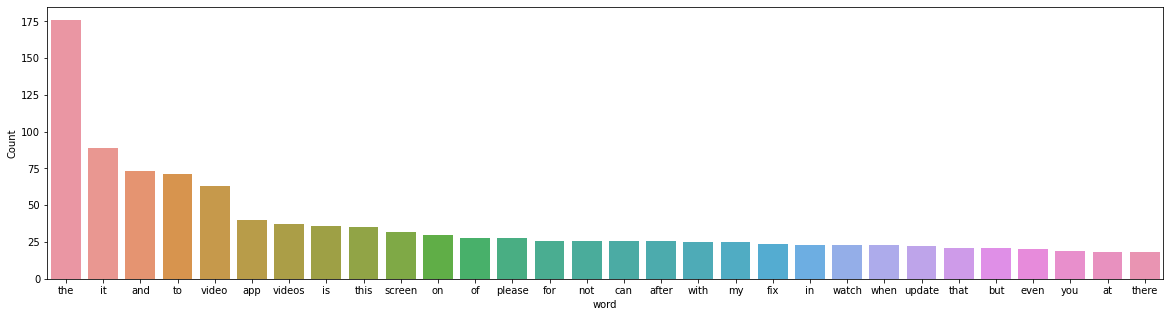

In [114]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_sg_2018_score1N2N3))

In [115]:
# Clean text
review_words_sg_ready_2018_score1N2N3 = process_words(review_words_sg_2018_score1N2N3)  # processed Text Data! - move to each section

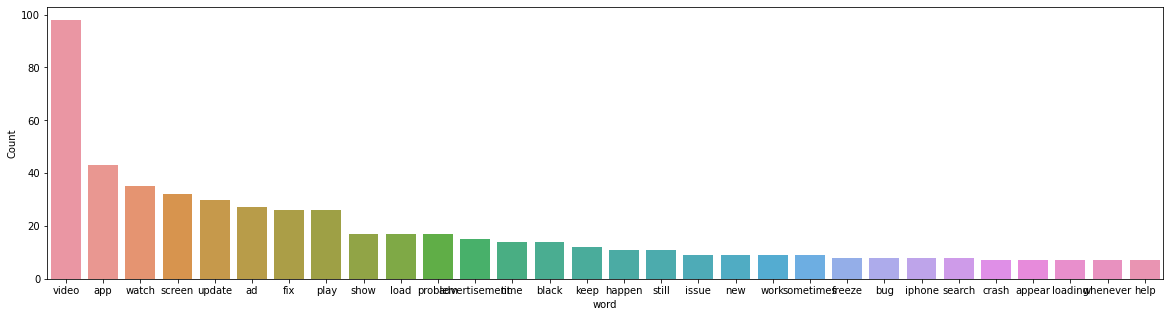

In [116]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_words_sg_ready_2018_score1N2N3))


In [117]:
# Create Dictionary
id2word_sg_2018_score1N2N3 = corpora.Dictionary(review_words_sg_ready_2018_score1N2N3)

2021-10-16 23:56:17,827 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 23:56:17,840 [INFO] gensim.corpora.dictionary - built Dictionary(420 unique tokens: ['app', 'download', 'feature', 'log', 'offline']...) from 99 documents (total 1198 corpus positions)
2021-10-16 23:56:17,842 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(420 unique tokens: ['app', 'download', 'feature', 'log', 'offline']...) from 99 documents (total 1198 corpus positions)", 'datetime': '2021-10-16T23:56:17.842160', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [118]:
# Create Corpus: Term Document Frequency
corpus_sg_2018_score1N2N3 = [id2word_sg_2018_score1N2N3.doc2bow(text) for text in review_words_sg_ready_2018_score1N2N3]

In [119]:
# Training LDA model
model_list_sg_2018_score1N2N3, coherence_values_sg_2018_score1N2N3 = compute_coherence_values(dictionary=id2word_sg_2018_score1N2N3, corpus=corpus_sg_2018_score1N2N3, 
                                                              texts=review_words_sg_ready_2018_score1N2N3, limit=30, start=2, step=5)


2021-10-16 23:56:17,870 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 23:56:17,874 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 23:56:17,881 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 23:56:17,887 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 99 documents, updating model once every 99 documents, evaluating perplexity every 99 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 23:56:18,297 [INFO] gensim.models.ldamodel - -6.711 per-word bound, 104.8 perplexity estimate based on a held-out corpus of 99 documents with 1198 words
2021-10-16 23:56:18,326 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #99/99
2021-10-16 23:56:18,651 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.055*"video" + 0.032*"screen" + 0.025*"app" + 0.021*"watch" + 0.021*"ad" + 0.019*"fix" + 0.019*"update" + 0.0

2021-10-16 23:56:22,303 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.060*"video" + 0.028*"app" + 0.024*"update" + 0.021*"watch" + 0.020*"problem" + 0.015*"play" + 0.014*"fix" + 0.012*"new" + 0.011*"sometimes" + 0.011*"still"
2021-10-16 23:56:22,305 [INFO] gensim.models.ldamodel - topic diff=0.005647, rho=0.301511
2021-10-16 23:56:22,510 [INFO] gensim.models.ldamodel - -5.694 per-word bound, 51.8 perplexity estimate based on a held-out corpus of 99 documents with 1198 words
2021-10-16 23:56:22,516 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #99/99
2021-10-16 23:56:22,713 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.063*"video" + 0.036*"screen" + 0.027*"ad" + 0.026*"app" + 0.023*"watch" + 0.019*"advertisement" + 0.019*"fix" + 0.019*"play" + 0.018*"black" + 0.016*"show"
2021-10-16 23:56:22,714 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.060*"video" + 0.028*"app" + 0.024*"update" + 0.021*"watch" + 0.020*"problem" + 0.015*"play" + 0.015*"fix" + 0.012

2021-10-16 23:56:25,736 [INFO] gensim.models.ldamodel - topic diff=0.002062, rho=0.218218
2021-10-16 23:56:25,969 [INFO] gensim.models.ldamodel - -5.693 per-word bound, 51.7 perplexity estimate based on a held-out corpus of 99 documents with 1198 words
2021-10-16 23:56:25,973 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #99/99
2021-10-16 23:56:26,042 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.063*"video" + 0.037*"screen" + 0.028*"ad" + 0.026*"app" + 0.024*"watch" + 0.020*"play" + 0.019*"advertisement" + 0.018*"fix" + 0.018*"black" + 0.017*"show"
2021-10-16 23:56:26,044 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.059*"video" + 0.028*"app" + 0.025*"update" + 0.021*"watch" + 0.020*"problem" + 0.015*"fix" + 0.014*"play" + 0.012*"new" + 0.011*"sometimes" + 0.011*"still"
2021-10-16 23:56:26,046 [INFO] gensim.models.ldamodel - topic diff=0.002014, rho=0.213201
2021-10-16 23:56:26,230 [INFO] gensim.models.ldamodel - -5.693 per-word bound, 51.7 perplexity esti

2021-10-16 23:56:29,241 [INFO] gensim.models.ldamodel - -5.692 per-word bound, 51.7 perplexity estimate based on a held-out corpus of 99 documents with 1198 words
2021-10-16 23:56:29,242 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #99/99
2021-10-16 23:56:29,378 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.064*"video" + 0.037*"screen" + 0.029*"ad" + 0.026*"app" + 0.024*"watch" + 0.020*"play" + 0.019*"advertisement" + 0.018*"fix" + 0.018*"black" + 0.017*"show"
2021-10-16 23:56:29,380 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.058*"video" + 0.029*"app" + 0.025*"update" + 0.021*"watch" + 0.021*"problem" + 0.015*"fix" + 0.013*"play" + 0.012*"new" + 0.011*"sometimes" + 0.011*"still"
2021-10-16 23:56:29,382 [INFO] gensim.models.ldamodel - topic diff=0.001783, rho=0.176777
2021-10-16 23:56:29,523 [INFO] gensim.models.ldamodel - -5.692 per-word bound, 51.7 perplexity estimate based on a held-out corpus of 99 documents with 1198 words
2021-10-16 23:56:29,524 [I

2021-10-16 23:56:32,113 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #99/99
2021-10-16 23:56:32,223 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.064*"video" + 0.038*"screen" + 0.029*"ad" + 0.025*"app" + 0.024*"watch" + 0.021*"play" + 0.019*"advertisement" + 0.018*"black" + 0.018*"fix" + 0.017*"show"
2021-10-16 23:56:32,225 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.058*"video" + 0.029*"app" + 0.026*"update" + 0.021*"problem" + 0.021*"watch" + 0.016*"fix" + 0.012*"play" + 0.012*"new" + 0.011*"sometimes" + 0.011*"still"
2021-10-16 23:56:32,226 [INFO] gensim.models.ldamodel - topic diff=0.002351, rho=0.154303
2021-10-16 23:56:32,341 [INFO] gensim.models.ldamodel - -5.690 per-word bound, 51.6 perplexity estimate based on a held-out corpus of 99 documents with 1198 words
2021-10-16 23:56:32,343 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #99/99
2021-10-16 23:56:32,504 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.064*"video" + 0.038

2021-10-16 23:56:34,746 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 23:56:40,813 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 23:56:40,839 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 95 virtual documents
2021-10-16 23:56:41,375 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-16 23:56:41,377 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
2021-10-16 23:56:41,385 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 23:56:41,388 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 7 topics, 50 passes over the supplied corpus of 99 documents, updating model once every 99 documents, evaluating perplexity every 99 documents, iterating 50x with a converg

2021-10-16 23:56:43,249 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.066*"video" + 0.034*"app" + 0.033*"watch" + 0.023*"screen" + 0.022*"fix" + 0.017*"unable" + 0.017*"search" + 0.017*"playlist" + 0.017*"mode" + 0.012*"picture"
2021-10-16 23:56:43,254 [INFO] gensim.models.ldamodel - topic diff=0.029286, rho=0.408248
2021-10-16 23:56:43,478 [INFO] gensim.models.ldamodel - -6.019 per-word bound, 64.8 perplexity estimate based on a held-out corpus of 99 documents with 1198 words
2021-10-16 23:56:43,480 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #99/99
2021-10-16 23:56:43,613 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.065*"screen" + 0.055*"video" + 0.043*"black" + 0.043*"ad" + 0.034*"show" + 0.030*"advertisement" + 0.023*"fix" + 0.022*"watch" + 0.020*"happen" + 0.018*"time"
2021-10-16 23:56:43,614 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.066*"video" + 0.034*"app" + 0.033*"watch" + 0.023*"screen" + 0.022*"fix" + 0.017*"unable" + 0.017*"search" +

2021-10-16 23:56:45,023 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.068*"video" + 0.038*"play" + 0.031*"ad" + 0.021*"watch" + 0.020*"happen" + 0.020*"still" + 0.018*"app" + 0.016*"work" + 0.016*"select" + 0.013*"load"
2021-10-16 23:56:45,025 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.047*"video" + 0.029*"watch" + 0.024*"problem" + 0.021*"sometimes" + 0.018*"still" + 0.018*"scroll" + 0.013*"show" + 0.013*"update" + 0.013*"screen" + 0.013*"volume"
2021-10-16 23:56:45,029 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.063*"video" + 0.034*"app" + 0.032*"watch" + 0.023*"screen" + 0.023*"fix" + 0.017*"search" + 0.017*"unable" + 0.017*"playlist" + 0.017*"mode" + 0.012*"advertisement"
2021-10-16 23:56:45,031 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.087*"video" + 0.065*"app" + 0.039*"update" + 0.023*"fix" + 0.020*"play" + 0.016*"problem" + 0.016*"load" + 0.015*"recent" + 0.014*"loading" + 0.012*"watch"
2021-10-16 23:56:45,033 [INFO] gensim.models.ldamodel - topi

2021-10-16 23:56:46,451 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.065*"screen" + 0.062*"video" + 0.047*"ad" + 0.046*"black" + 0.035*"show" + 0.031*"advertisement" + 0.027*"watch" + 0.026*"load" + 0.023*"fix" + 0.019*"time"
2021-10-16 23:56:46,453 [INFO] gensim.models.ldamodel - topic diff=0.003250, rho=0.242536
2021-10-16 23:56:46,632 [INFO] gensim.models.ldamodel - -6.005 per-word bound, 64.2 perplexity estimate based on a held-out corpus of 99 documents with 1198 words
2021-10-16 23:56:46,635 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #99/99
2021-10-16 23:56:46,736 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.047*"video" + 0.029*"watch" + 0.024*"problem" + 0.021*"sometimes" + 0.018*"still" + 0.018*"scroll" + 0.013*"show" + 0.013*"screen" + 0.013*"update" + 0.013*"volume"
2021-10-16 23:56:46,740 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.068*"video" + 0.039*"play" + 0.031*"ad" + 0.020*"watch" + 0.020*"happen" + 0.019*"still" + 0.017*"app" 

2021-10-16 23:56:48,184 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.042*"video" + 0.026*"keep" + 0.026*"update" + 0.017*"music" + 0.017*"play" + 0.017*"ad" + 0.017*"crash" + 0.017*"fix" + 0.017*"late" + 0.017*"especially"
2021-10-16 23:56:48,187 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.029*"watch" + 0.018*"app" + 0.016*"back" + 0.016*"user" + 0.015*"halfway" + 0.013*"video" + 0.012*"really" + 0.011*"ad" + 0.011*"advertisement" + 0.010*"show"
2021-10-16 23:56:48,192 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.068*"video" + 0.039*"play" + 0.031*"ad" + 0.020*"watch" + 0.019*"still" + 0.019*"happen" + 0.017*"app" + 0.016*"select" + 0.016*"work" + 0.013*"load"
2021-10-16 23:56:48,194 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.067*"screen" + 0.063*"video" + 0.047*"ad" + 0.046*"black" + 0.035*"show" + 0.030*"advertisement" + 0.028*"watch" + 0.027*"load" + 0.022*"fix" + 0.019*"time"
2021-10-16 23:56:48,196 [INFO] gensim.models.ldamodel - topic diff=0.002170,

2021-10-16 23:56:49,482 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.086*"video" + 0.066*"app" + 0.038*"update" + 0.023*"fix" + 0.020*"play" + 0.016*"problem" + 0.016*"load" + 0.015*"recent" + 0.015*"loading" + 0.012*"freeze"
2021-10-16 23:56:49,485 [INFO] gensim.models.ldamodel - topic diff=0.001744, rho=0.188982
2021-10-16 23:56:49,623 [INFO] gensim.models.ldamodel - -6.001 per-word bound, 64.1 perplexity estimate based on a held-out corpus of 99 documents with 1198 words
2021-10-16 23:56:49,624 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #99/99
2021-10-16 23:56:49,736 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.059*"video" + 0.035*"app" + 0.030*"watch" + 0.023*"screen" + 0.023*"fix" + 0.018*"search" + 0.018*"mode" + 0.018*"playlist" + 0.018*"unable" + 0.012*"advertisement"
2021-10-16 23:56:49,738 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.042*"video" + 0.026*"keep" + 0.026*"update" + 0.017*"music" + 0.017*"play" + 0.017*"ad" + 0.017*"fix" +

2021-10-16 23:56:50,862 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.047*"video" + 0.029*"watch" + 0.024*"problem" + 0.021*"sometimes" + 0.018*"still" + 0.018*"scroll" + 0.013*"show" + 0.013*"increase" + 0.013*"volume" + 0.013*"screen"
2021-10-16 23:56:50,866 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.059*"video" + 0.035*"app" + 0.030*"watch" + 0.023*"screen" + 0.023*"fix" + 0.018*"search" + 0.018*"mode" + 0.018*"playlist" + 0.018*"unable" + 0.012*"advertisement"
2021-10-16 23:56:50,868 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.066*"video" + 0.040*"play" + 0.031*"ad" + 0.020*"still" + 0.018*"happen" + 0.018*"watch" + 0.017*"select" + 0.017*"app" + 0.017*"work" + 0.013*"load"
2021-10-16 23:56:50,870 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.068*"screen" + 0.066*"video" + 0.046*"ad" + 0.045*"black" + 0.034*"show" + 0.030*"advertisement" + 0.029*"watch" + 0.027*"load" + 0.022*"fix" + 0.020*"happen"
2021-10-16 23:56:50,872 [INFO] gensim.models.ldamodel -

2021-10-16 23:56:51,991 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.068*"screen" + 0.066*"video" + 0.046*"ad" + 0.045*"black" + 0.034*"show" + 0.030*"watch" + 0.030*"advertisement" + 0.027*"load" + 0.022*"fix" + 0.020*"happen"
2021-10-16 23:56:51,992 [INFO] gensim.models.ldamodel - topic diff=0.001509, rho=0.160128
2021-10-16 23:56:52,103 [INFO] gensim.models.ldamodel - -5.998 per-word bound, 63.9 perplexity estimate based on a held-out corpus of 99 documents with 1198 words
2021-10-16 23:56:52,104 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #99/99
2021-10-16 23:56:52,224 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.029*"watch" + 0.018*"app" + 0.016*"back" + 0.016*"user" + 0.015*"halfway" + 0.011*"video" + 0.010*"advertisement" + 0.010*"ad" + 0.010*"really" + 0.010*"show"
2021-10-16 23:56:52,225 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.065*"video" + 0.040*"play" + 0.031*"ad" + 0.020*"still" + 0.018*"happen" + 0.018*"watch" + 0.017*"select" +

2021-10-16 23:56:53,388 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.042*"video" + 0.026*"keep" + 0.026*"update" + 0.017*"music" + 0.017*"ad" + 0.017*"play" + 0.017*"fix" + 0.017*"crash" + 0.017*"late" + 0.017*"especially"
2021-10-16 23:56:53,403 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.046*"video" + 0.030*"watch" + 0.024*"problem" + 0.021*"sometimes" + 0.018*"still" + 0.018*"scroll" + 0.014*"show" + 0.014*"volume" + 0.014*"increase" + 0.014*"screen"
2021-10-16 23:56:53,404 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.029*"watch" + 0.018*"app" + 0.016*"back" + 0.016*"user" + 0.015*"halfway" + 0.011*"video" + 0.010*"advertisement" + 0.010*"ad" + 0.010*"show" + 0.010*"update"
2021-10-16 23:56:53,409 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.065*"video" + 0.040*"play" + 0.031*"ad" + 0.020*"still" + 0.018*"happen" + 0.017*"watch" + 0.017*"select" + 0.017*"app" + 0.017*"work" + 0.013*"load"
2021-10-16 23:56:53,410 [INFO] gensim.models.ldamodel - topic diff

2021-10-16 23:56:54,622 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.065*"video" + 0.041*"play" + 0.031*"ad" + 0.020*"still" + 0.018*"happen" + 0.017*"watch" + 0.017*"select" + 0.017*"app" + 0.017*"work" + 0.013*"load"
2021-10-16 23:56:54,624 [INFO] gensim.models.ldamodel - topic diff=0.000875, rho=0.141421
2021-10-16 23:56:54,735 [INFO] gensim.models.ldamodel - -5.996 per-word bound, 63.8 perplexity estimate based on a held-out corpus of 99 documents with 1198 words
2021-10-16 23:56:54,737 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #99/99
2021-10-16 23:56:54,814 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.042*"video" + 0.026*"keep" + 0.026*"update" + 0.017*"music" + 0.017*"ad" + 0.017*"play" + 0.017*"fix" + 0.017*"crash" + 0.017*"late" + 0.017*"especially"
2021-10-16 23:56:54,816 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.045*"video" + 0.030*"watch" + 0.024*"problem" + 0.021*"sometimes" + 0.018*"still" + 0.018*"scroll" + 0.014*"show" + 0.014

2021-10-16 23:57:02,519 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.044*"utube" + 0.035*"watch" + 0.034*"back" + 0.030*"long" + 0.021*"video" + 0.018*"app" + 0.018*"ad" + 0.018*"entertainment" + 0.018*"user" + 0.018*"disruptive"
2021-10-16 23:57:02,521 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.070*"video" + 0.038*"app" + 0.033*"advertisement" + 0.029*"play" + 0.029*"freeze" + 0.020*"load" + 0.020*"screen" + 0.020*"home" + 0.020*"picture" + 0.020*"fix"
2021-10-16 23:57:02,524 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.032*"mode" + 0.032*"app" + 0.032*"video" + 0.025*"update" + 0.022*"restricted" + 0.022*"however" + 0.022*"issue" + 0.011*"recent" + 0.011*"turn" + 0.011*"never"
2021-10-16 23:57:02,525 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.094*"video" + 0.052*"app" + 0.036*"update" + 0.029*"fix" + 0.029*"problem" + 0.021*"watch" + 0.020*"play" + 0.013*"crash" + 0.013*"recent" + 0.012*"download"
2021-10-16 23:57:02,527 [INFO] gensim.models.ldamodel -

2021-10-16 23:57:03,615 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.078*"video" + 0.062*"screen" + 0.050*"ad" + 0.038*"black" + 0.034*"show" + 0.034*"fix" + 0.030*"watch" + 0.025*"advertisement" + 0.021*"time" + 0.021*"update"
2021-10-16 23:57:03,616 [INFO] gensim.models.ldamodel - topic diff=0.010407, rho=0.316228
2021-10-16 23:57:03,790 [INFO] gensim.models.ldamodel - -6.112 per-word bound, 69.2 perplexity estimate based on a held-out corpus of 99 documents with 1198 words
2021-10-16 23:57:03,793 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #99/99
2021-10-16 23:57:03,932 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.032*"app" + 0.032*"mode" + 0.032*"video" + 0.022*"update" + 0.022*"restricted" + 0.022*"issue" + 0.022*"however" + 0.011*"continue" + 0.011*"comment" + 0.011*"never"
2021-10-16 23:57:03,947 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.068*"video" + 0.039*"app" + 0.030*"advertisement" + 0.029*"play" + 0.029*"freeze" + 0.020*"load" + 0.

2021-10-16 23:57:05,347 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.079*"video" + 0.062*"screen" + 0.050*"ad" + 0.038*"black" + 0.034*"show" + 0.034*"fix" + 0.029*"watch" + 0.025*"advertisement" + 0.021*"time" + 0.021*"update"
2021-10-16 23:57:05,348 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.067*"video" + 0.039*"app" + 0.029*"advertisement" + 0.029*"play" + 0.029*"freeze" + 0.020*"load" + 0.020*"screen" + 0.020*"home" + 0.020*"fix" + 0.020*"picture"
2021-10-16 23:57:05,350 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.093*"video" + 0.052*"app" + 0.036*"update" + 0.029*"fix" + 0.029*"problem" + 0.021*"watch" + 0.019*"play" + 0.013*"crash" + 0.013*"recent" + 0.011*"download"
2021-10-16 23:57:05,353 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.035*"video" + 0.033*"problem" + 0.030*"watch" + 0.026*"sometimes" + 0.020*"show" + 0.020*"still" + 0.020*"bug" + 0.020*"scroll" + 0.020*"fix" + 0.020*"volume"
2021-10-16 23:57:05,356 [INFO] gensim.models.ldamodel - top

2021-10-16 23:57:06,612 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.040*"video" + 0.038*"screen" + 0.019*"happen" + 0.019*"appear" + 0.019*"annoying" + 0.019*"everytime" + 0.019*"watch" + 0.019*"really" + 0.019*"end" + 0.019*"recommend"
2021-10-16 23:57:06,615 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.032*"video" + 0.029*"still" + 0.024*"app" + 0.022*"issue" + 0.022*"update" + 0.022*"reminder" + 0.015*"select" + 0.015*"quality" + 0.015*"new" + 0.015*"option"
2021-10-16 23:57:06,617 [INFO] gensim.models.ldamodel - topic diff=0.001274, rho=0.218218
2021-10-16 23:57:06,739 [INFO] gensim.models.ldamodel - -6.106 per-word bound, 68.9 perplexity estimate based on a held-out corpus of 99 documents with 1198 words
2021-10-16 23:57:06,740 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #99/99
2021-10-16 23:57:06,792 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.032*"video" + 0.029*"still" + 0.024*"app" + 0.022*"issue" + 0.022*"update" + 0.022*"reminder" + 

2021-10-16 23:57:07,719 [INFO] gensim.models.ldamodel - -6.105 per-word bound, 68.9 perplexity estimate based on a held-out corpus of 99 documents with 1198 words
2021-10-16 23:57:07,799 [INFO] gensim.models.ldamodel - PROGRESS: pass 25, at document #99/99
2021-10-16 23:57:07,884 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.032*"video" + 0.029*"still" + 0.024*"app" + 0.022*"issue" + 0.022*"update" + 0.022*"reminder" + 0.015*"select" + 0.015*"quality" + 0.015*"new" + 0.015*"option"
2021-10-16 23:57:07,887 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.079*"video" + 0.062*"screen" + 0.050*"ad" + 0.038*"black" + 0.034*"show" + 0.034*"fix" + 0.030*"watch" + 0.025*"advertisement" + 0.021*"time" + 0.021*"update"
2021-10-16 23:57:07,889 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.052*"video" + 0.036*"app" + 0.036*"view" + 0.036*"update" + 0.024*"fix" + 0.024*"music" + 0.024*"new" + 0.024*"late" + 0.024*"crash" + 0.013*"unable"
2021-10-16 23:57:07,891 [INFO] gensim.models.l

2021-10-16 23:57:08,979 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.052*"video" + 0.036*"app" + 0.036*"view" + 0.036*"update" + 0.024*"fix" + 0.024*"music" + 0.024*"new" + 0.024*"late" + 0.024*"crash" + 0.013*"unable"
2021-10-16 23:57:08,980 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.058*"ad" + 0.039*"appear" + 0.039*"search" + 0.020*"skip" + 0.020*"advertisement" + 0.020*"first" + 0.020*"place" + 0.020*"minimise" + 0.020*"interesting" + 0.020*"speed"
2021-10-16 23:57:08,981 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.051*"utube" + 0.035*"watch" + 0.035*"back" + 0.034*"long" + 0.018*"video" + 0.018*"app" + 0.018*"ad" + 0.018*"entertainment" + 0.018*"user" + 0.018*"minute"
2021-10-16 23:57:08,982 [INFO] gensim.models.ldamodel - topic diff=0.000356, rho=0.176777
2021-10-16 23:57:09,109 [INFO] gensim.models.ldamodel - -6.105 per-word bound, 68.8 perplexity estimate based on a held-out corpus of 99 documents with 1198 words
2021-10-16 23:57:09,111 [INFO] gensim.mod

2021-10-16 23:57:10,057 [INFO] gensim.models.ldamodel - topic diff=0.000171, rho=0.164399
2021-10-16 23:57:10,206 [INFO] gensim.models.ldamodel - -6.105 per-word bound, 68.8 perplexity estimate based on a held-out corpus of 99 documents with 1198 words
2021-10-16 23:57:10,208 [INFO] gensim.models.ldamodel - PROGRESS: pass 36, at document #99/99
2021-10-16 23:57:10,261 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.065*"video" + 0.037*"search" + 0.028*"watch" + 0.019*"update" + 0.019*"channel" + 0.019*"small" + 0.019*"community" + 0.010*"screen" + 0.010*"ad" + 0.010*"sometimes"
2021-10-16 23:57:10,263 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.067*"video" + 0.039*"app" + 0.029*"advertisement" + 0.029*"play" + 0.029*"freeze" + 0.020*"screen" + 0.020*"load" + 0.020*"home" + 0.020*"fix" + 0.020*"picture"
2021-10-16 23:57:10,265 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.031*"video" + 0.029*"still" + 0.024*"app" + 0.022*"issue" + 0.022*"update" + 0.022*"reminder" + 0

2021-10-16 23:57:11,492 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.078*"video" + 0.043*"ad" + 0.043*"watch" + 0.039*"play" + 0.038*"app" + 0.037*"load" + 0.033*"screen" + 0.024*"black" + 0.023*"show" + 0.019*"advertisement"
2021-10-16 23:57:11,494 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.032*"app" + 0.032*"mode" + 0.032*"video" + 0.022*"update" + 0.022*"issue" + 0.022*"restricted" + 0.022*"however" + 0.011*"second" + 0.011*"continue" + 0.011*"comment"
2021-10-16 23:57:11,495 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.058*"ad" + 0.039*"appear" + 0.039*"search" + 0.020*"advertisement" + 0.020*"skip" + 0.020*"first" + 0.020*"place" + 0.020*"minimise" + 0.020*"interesting" + 0.020*"speed"
2021-10-16 23:57:11,497 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.079*"video" + 0.062*"screen" + 0.050*"ad" + 0.038*"black" + 0.035*"show" + 0.034*"fix" + 0.030*"watch" + 0.025*"advertisement" + 0.021*"time" + 0.021*"update"
2021-10-16 23:57:11,499 [INFO] gensim.mod

2021-10-16 23:57:12,949 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.058*"ad" + 0.039*"appear" + 0.039*"search" + 0.020*"skip" + 0.020*"advertisement" + 0.020*"first" + 0.020*"place" + 0.020*"minimise" + 0.020*"interesting" + 0.020*"speed"
2021-10-16 23:57:12,954 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.078*"video" + 0.043*"ad" + 0.043*"watch" + 0.039*"play" + 0.038*"app" + 0.037*"load" + 0.033*"screen" + 0.024*"black" + 0.023*"show" + 0.019*"advertisement"
2021-10-16 23:57:12,955 [INFO] gensim.models.ldamodel - topic diff=0.000029, rho=0.144338
2021-10-16 23:57:13,172 [INFO] gensim.models.ldamodel - -6.105 per-word bound, 68.8 perplexity estimate based on a held-out corpus of 99 documents with 1198 words
2021-10-16 23:57:13,176 [INFO] gensim.models.ldamodel - PROGRESS: pass 47, at document #99/99
2021-10-16 23:57:13,249 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.065*"video" + 0.037*"search" + 0.028*"watch" + 0.019*"update" + 0.019*"channel" + 0.019*"small"

2021-10-16 23:57:22,682 [INFO] gensim.models.ldamodel - PROGRESS: pass 1, at document #99/99
2021-10-16 23:57:22,752 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.055*"show" + 0.036*"always" + 0.036*"interested" + 0.020*"screen" + 0.018*"darken" + 0.018*"whole" + 0.018*"app" + 0.018*"sometimes" + 0.018*"pause" + 0.018*"slow"
2021-10-16 23:57:22,754 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.064*"screen" + 0.063*"video" + 0.040*"play" + 0.030*"black" + 0.024*"stick" + 0.024*"happen" + 0.024*"fix" + 0.024*"ad" + 0.024*"lock" + 0.024*"watch"
2021-10-16 23:57:22,756 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.105*"video" + 0.051*"update" + 0.034*"watch" + 0.029*"play" + 0.026*"app" + 0.017*"travel" + 0.017*"sometimes" + 0.017*"download" + 0.017*"problem" + 0.017*"new"
2021-10-16 23:57:22,759 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.083*"reminder" + 0.056*"set" + 0.029*"reset" + 0.029*"video" + 0.029*"possible" + 0.029*"title" + 0.029*"time" + 0.029*"live" 

2021-10-16 23:57:23,852 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.049*"video" + 0.045*"screen" + 0.035*"advertisement" + 0.031*"utube" + 0.031*"long" + 0.030*"home" + 0.020*"watch" + 0.016*"due" + 0.016*"comment" + 0.016*"view"
2021-10-16 23:57:23,856 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.047*"video" + 0.045*"hope" + 0.025*"play" + 0.023*"new" + 0.023*"still" + 0.023*"problem" + 0.023*"soon" + 0.023*"app" + 0.023*"issue" + 0.023*"review"
2021-10-16 23:57:23,857 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.040*"screen" + 0.033*"happen" + 0.021*"fix" + 0.021*"black" + 0.017*"suddenly" + 0.017*"exit" + 0.017*"iphone" + 0.017*"hope" + 0.017*"big" + 0.017*"full"
2021-10-16 23:57:23,858 [INFO] gensim.models.ldamodel - topic diff=0.029006, rho=0.353553
2021-10-16 23:57:23,954 [INFO] gensim.models.ldamodel - -6.297 per-word bound, 78.7 perplexity estimate based on a held-out corpus of 99 documents with 1198 words
2021-10-16 23:57:23,955 [INFO] gensim.models.ldam

2021-10-16 23:57:24,977 [INFO] gensim.models.ldamodel - topic diff=0.007826, rho=0.277350
2021-10-16 23:57:25,099 [INFO] gensim.models.ldamodel - -6.287 per-word bound, 78.1 perplexity estimate based on a held-out corpus of 99 documents with 1198 words
2021-10-16 23:57:25,101 [INFO] gensim.models.ldamodel - PROGRESS: pass 12, at document #99/99
2021-10-16 23:57:25,162 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.104*"video" + 0.052*"update" + 0.035*"watch" + 0.026*"play" + 0.026*"app" + 0.018*"travel" + 0.018*"sometimes" + 0.018*"download" + 0.018*"problem" + 0.018*"new"
2021-10-16 23:57:25,172 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.079*"ad" + 0.032*"stop" + 0.032*"advertisement" + 0.032*"appear" + 0.017*"watch" + 0.017*"tube" + 0.017*"enjoy" + 0.017*"irrelevant" + 0.017*"repeatedly" + 0.017*"absurd"
2021-10-16 23:57:25,177 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.047*"video" + 0.046*"screen" + 0.032*"advertisement" + 0.031*"utube" + 0.031*"long" + 0.031*

2021-10-16 23:57:26,282 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.105*"video" + 0.053*"update" + 0.035*"watch" + 0.027*"play" + 0.027*"app" + 0.018*"travel" + 0.018*"recent" + 0.018*"sometimes" + 0.018*"new" + 0.018*"page"
2021-10-16 23:57:26,283 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.071*"video" + 0.040*"watch" + 0.032*"ad" + 0.032*"play" + 0.032*"problem" + 0.024*"sometimes" + 0.024*"update" + 0.024*"still" + 0.024*"scroll" + 0.016*"iso"
2021-10-16 23:57:26,286 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.083*"reminder" + 0.056*"set" + 0.029*"live" + 0.029*"fix" + 0.029*"reset" + 0.029*"possible" + 0.029*"title" + 0.029*"video" + 0.029*"time" + 0.002*"ish"
2021-10-16 23:57:26,288 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.079*"ad" + 0.032*"stop" + 0.032*"advertisement" + 0.032*"appear" + 0.017*"repetitive" + 0.017*"watch" + 0.017*"show" + 0.017*"absurd" + 0.017*"irrelevant" + 0.017*"repeatedly"
2021-10-16 23:57:26,290 [INFO] gensim.models.ldamod

2021-10-16 23:57:27,576 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.063*"ad" + 0.062*"video" + 0.048*"search" + 0.039*"watch" + 0.039*"app" + 0.029*"time" + 0.020*"mode" + 0.020*"restricted" + 0.020*"never" + 0.020*"play"
2021-10-16 23:57:27,593 [INFO] gensim.models.ldamodel - topic diff=0.001187, rho=0.204124
2021-10-16 23:57:27,685 [INFO] gensim.models.ldamodel - -6.281 per-word bound, 77.8 perplexity estimate based on a held-out corpus of 99 documents with 1198 words
2021-10-16 23:57:27,717 [INFO] gensim.models.ldamodel - PROGRESS: pass 23, at document #99/99
2021-10-16 23:57:27,774 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.062*"ad" + 0.062*"video" + 0.048*"search" + 0.039*"watch" + 0.039*"app" + 0.029*"time" + 0.020*"mode" + 0.020*"restricted" + 0.020*"never" + 0.020*"play"
2021-10-16 23:57:27,778 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.121*"video" + 0.048*"load" + 0.048*"advertisement" + 0.042*"watch" + 0.037*"screen" + 0.035*"show" + 0.027*"fix" +

2021-10-16 23:57:28,889 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.106*"video" + 0.053*"update" + 0.036*"watch" + 0.027*"play" + 0.027*"app" + 0.018*"page" + 0.018*"recommend" + 0.018*"old" + 0.018*"recent" + 0.018*"travel"
2021-10-16 23:57:28,891 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.085*"video" + 0.034*"app" + 0.026*"update" + 0.026*"play" + 0.017*"problem" + 0.017*"fix" + 0.017*"uploading" + 0.017*"crash" + 0.017*"playlist" + 0.017*"remove"
2021-10-16 23:57:28,893 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.055*"video" + 0.028*"unable" + 0.021*"app" + 0.019*"community" + 0.019*"search" + 0.019*"airplay" + 0.019*"fix" + 0.019*"delete" + 0.019*"help" + 0.017*"ad"
2021-10-16 23:57:28,895 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.045*"volume" + 0.045*"increase" + 0.045*"video" + 0.023*"work" + 0.023*"keep" + 0.023*"show" + 0.023*"load" + 0.023*"wifi" + 0.023*"network" + 0.023*"almost"
2021-10-16 23:57:28,898 [INFO] gensim.models.ldamodel - topi

2021-10-16 23:57:30,099 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.045*"volume" + 0.045*"increase" + 0.045*"video" + 0.023*"work" + 0.023*"keep" + 0.023*"show" + 0.023*"load" + 0.023*"wifi" + 0.023*"network" + 0.023*"almost"
2021-10-16 23:57:30,100 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.061*"video" + 0.059*"ad" + 0.048*"search" + 0.039*"app" + 0.038*"watch" + 0.029*"time" + 0.020*"mode" + 0.020*"play" + 0.020*"restricted" + 0.020*"never"
2021-10-16 23:57:30,101 [INFO] gensim.models.ldamodel - topic diff=0.000344, rho=0.169031
2021-10-16 23:57:30,204 [INFO] gensim.models.ldamodel - -6.279 per-word bound, 77.7 perplexity estimate based on a held-out corpus of 99 documents with 1198 words
2021-10-16 23:57:30,206 [INFO] gensim.models.ldamodel - PROGRESS: pass 34, at document #99/99
2021-10-16 23:57:30,316 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.034*"screen" + 0.033*"happen" + 0.018*"fix" + 0.018*"black" + 0.017*"app" + 0.017*"middle" + 0.017*"soon" + 0.

2021-10-16 23:57:31,281 [INFO] gensim.models.ldamodel - PROGRESS: pass 39, at document #99/99
2021-10-16 23:57:31,376 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.071*"video" + 0.040*"watch" + 0.032*"ad" + 0.032*"play" + 0.032*"problem" + 0.024*"sometimes" + 0.024*"update" + 0.024*"still" + 0.024*"scroll" + 0.016*"iso"
2021-10-16 23:57:31,377 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.061*"video" + 0.058*"ad" + 0.048*"search" + 0.039*"app" + 0.038*"watch" + 0.029*"time" + 0.020*"mode" + 0.020*"play" + 0.020*"restricted" + 0.020*"never"
2021-10-16 23:57:31,380 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.090*"screen" + 0.060*"video" + 0.041*"black" + 0.040*"fix" + 0.040*"play" + 0.031*"update" + 0.031*"ad" + 0.031*"show" + 0.021*"lock" + 0.021*"watch"
2021-10-16 23:57:31,384 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.083*"reminder" + 0.056*"set" + 0.029*"live" + 0.029*"fix" + 0.029*"reset" + 0.029*"possible" + 0.029*"title" + 0.029*"video" + 0.029*"time"

2021-10-16 23:57:32,431 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.045*"volume" + 0.045*"increase" + 0.045*"video" + 0.023*"work" + 0.023*"keep" + 0.023*"show" + 0.023*"load" + 0.023*"wifi" + 0.023*"network" + 0.023*"almost"
2021-10-16 23:57:32,435 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.044*"update" + 0.030*"keep" + 0.030*"video" + 0.030*"issue" + 0.030*"late" + 0.030*"crash" + 0.030*"especially" + 0.015*"supposedly" + 0.015*"constantly" + 0.015*"watch"
2021-10-16 23:57:32,438 [INFO] gensim.models.ldamodel - topic diff=0.000079, rho=0.147442
2021-10-16 23:57:32,660 [INFO] gensim.models.ldamodel - -6.279 per-word bound, 77.7 perplexity estimate based on a held-out corpus of 99 documents with 1198 words
2021-10-16 23:57:32,663 [INFO] gensim.models.ldamodel - PROGRESS: pass 45, at document #99/99
2021-10-16 23:57:32,758 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.121*"video" + 0.048*"load" + 0.048*"advertisement" + 0.042*"watch" + 0.037*"screen" + 0.035*"sh

2021-10-16 23:57:33,587 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 23:57:38,291 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 23:57:38,356 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 96 virtual documents
2021-10-16 23:57:41,640 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.045454545454545456
2021-10-16 23:57:41,641 [INFO] gensim.models.ldamodel - using symmetric eta at 0.045454545454545456
2021-10-16 23:57:41,645 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 23:57:41,648 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 22 topics, 50 passes over the supplied corpus of 99 documents, updating model once every 99 documents, evaluating perplexity every 99 documents, iterating 50x with a conv

2021-10-16 23:57:43,104 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.101*"ad" + 0.068*"appear" + 0.035*"skip" + 0.035*"interesting" + 0.035*"first" + 0.035*"advertisement" + 0.035*"minimise" + 0.035*"place" + 0.002*"option" + 0.002*"aspect"
2021-10-16 23:57:43,106 [INFO] gensim.models.ldamodel - topic diff=0.023317, rho=0.408248
2021-10-16 23:57:43,178 [INFO] gensim.models.ldamodel - -6.408 per-word bound, 84.9 perplexity estimate based on a held-out corpus of 99 documents with 1198 words
2021-10-16 23:57:43,180 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #99/99
2021-10-16 23:57:43,231 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.072*"sometimes" + 0.059*"watch" + 0.059*"video" + 0.044*"scroll" + 0.030*"bug" + 0.030*"still" + 0.030*"new" + 0.030*"play" + 0.030*"problem" + 0.030*"freeze"
2021-10-16 23:57:43,233 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.052*"一个叫" + 0.002*"play" + 0.002*"infront" + 0.002*"problem" + 0.002*"ad" + 0.002*"anymore" + 

2021-10-16 23:57:44,269 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.083*"video" + 0.050*"app" + 0.033*"play" + 0.033*"problem" + 0.033*"fix" + 0.025*"ad" + 0.025*"watch" + 0.025*"still" + 0.025*"update" + 0.017*"hope"
2021-10-16 23:57:44,274 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.051*"screen" + 0.051*"app" + 0.034*"black" + 0.034*"watch" + 0.034*"time" + 0.017*"manually" + 0.017*"slide" + 0.017*"stick" + 0.017*"full" + 0.017*"feature"
2021-10-16 23:57:44,279 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.096*"video" + 0.064*"screen" + 0.043*"fix" + 0.032*"black" + 0.032*"update" + 0.032*"loading" + 0.022*"watch" + 0.022*"happen" + 0.022*"lock" + 0.022*"time"
2021-10-16 23:57:44,282 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.071*"ad" + 0.025*"watch" + 0.024*"video" + 0.024*"disruptive" + 0.024*"user" + 0.024*"pepper" + 0.024*"minute" + 0.024*"due" + 0.024*"experience" + 0.024*"long"
2021-10-16 23:57:44,284 [INFO] gensim.models.ldamodel - topic diff=0.

2021-10-16 23:57:45,363 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.051*"video" + 0.051*"load" + 0.051*"update" + 0.026*"late" + 0.026*"bug" + 0.026*"keep" + 0.026*"constantly" + 0.026*"watch" + 0.026*"crash" + 0.026*"especially"
2021-10-16 23:57:45,364 [INFO] gensim.models.ldamodel - topic diff=0.001248, rho=0.242536
2021-10-16 23:57:45,479 [INFO] gensim.models.ldamodel - -6.395 per-word bound, 84.1 perplexity estimate based on a held-out corpus of 99 documents with 1198 words
2021-10-16 23:57:45,480 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #99/99
2021-10-16 23:57:45,602 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.071*"ad" + 0.024*"watch" + 0.024*"video" + 0.024*"disruptive" + 0.024*"bad" + 0.024*"experience" + 0.024*"long" + 0.024*"minute" + 0.024*"pepper" + 0.024*"user"
2021-10-16 23:57:45,604 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.073*"video" + 0.059*"screen" + 0.051*"play" + 0.037*"ad" + 0.030*"app" + 0.030*"update" + 0.022*"cras

2021-10-16 23:57:46,855 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.074*"video" + 0.056*"play" + 0.037*"ad" + 0.028*"app" + 0.019*"whenever" + 0.019*"issue" + 0.019*"quality" + 0.019*"help" + 0.019*"select" + 0.019*"watch"
2021-10-16 23:57:46,856 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.051*"update" + 0.051*"video" + 0.051*"load" + 0.026*"well" + 0.026*"especially" + 0.026*"fix" + 0.026*"supposedly" + 0.026*"middle" + 0.026*"late" + 0.026*"constantly"
2021-10-16 23:57:46,857 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.051*"screen" + 0.051*"app" + 0.034*"black" + 0.034*"time" + 0.034*"watch" + 0.017*"manually" + 0.017*"io" + 0.017*"full" + 0.017*"multi" + 0.017*"ever"
2021-10-16 23:57:46,859 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.074*"video" + 0.066*"load" + 0.055*"watch" + 0.044*"press" + 0.023*"still" + 0.023*"work" + 0.023*"tell" + 0.023*"twice" + 0.023*"happen" + 0.023*"whenever"
2021-10-16 23:57:46,861 [INFO] gensim.models.ldamodel - topic

2021-10-16 23:57:47,876 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.071*"happen" + 0.024*"big" + 0.024*"iphone" + 0.024*"screen" + 0.024*"else" + 0.024*"fix" + 0.024*"suddenly" + 0.024*"usable" + 0.024*"hope" + 0.024*"really"
2021-10-16 23:57:47,877 [INFO] gensim.models.ldamodel - topic diff=0.000098, rho=0.188982
2021-10-16 23:57:47,988 [INFO] gensim.models.ldamodel - -6.394 per-word bound, 84.1 perplexity estimate based on a held-out corpus of 99 documents with 1198 words
2021-10-16 23:57:47,990 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #99/99
2021-10-16 23:57:48,068 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.047*"video" + 0.047*"search" + 0.031*"update" + 0.031*"small" + 0.031*"option" + 0.016*"work" + 0.016*"fine" + 0.016*"play" + 0.016*"clip" + 0.016*"ipad"
2021-10-16 23:57:48,072 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.071*"ad" + 0.024*"watch" + 0.024*"video" + 0.024*"disruptive" + 0.024*"bad" + 0.024*"experience" + 0.024*"long"

2021-10-16 23:57:49,028 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.066*"picture" + 0.034*"mode" + 0.034*"app" + 0.034*"add" + 0.034*"party" + 0.034*"third" + 0.034*"ipad" + 0.034*"able" + 0.034*"long" + 0.034*"watch"
2021-10-16 23:57:49,032 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.066*"show" + 0.034*"watch" + 0.034*"advertisement" + 0.034*"app" + 0.034*"fix" + 0.034*"video" + 0.034*"unpleasant" + 0.034*"improve" + 0.034*"search" + 0.034*"facility"
2021-10-16 23:57:49,035 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.067*"app" + 0.067*"video" + 0.029*"increase" + 0.029*"volume" + 0.029*"update" + 0.019*"phone" + 0.019*"new" + 0.019*"max" + 0.019*"utube" + 0.019*"bug"
2021-10-16 23:57:49,039 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.089*"show" + 0.067*"video" + 0.058*"load" + 0.046*"advertisement" + 0.035*"ad" + 0.035*"time" + 0.034*"screen" + 0.029*"watch" + 0.027*"keep" + 0.023*"always"
2021-10-16 23:57:49,040 [INFO] gensim.models.ldamodel - topic

2021-10-16 23:57:49,988 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.096*"video" + 0.064*"screen" + 0.043*"fix" + 0.032*"black" + 0.032*"update" + 0.032*"loading" + 0.022*"watch" + 0.022*"lock" + 0.022*"happen" + 0.022*"time"
2021-10-16 23:57:49,990 [INFO] gensim.models.ldamodel - topic diff=0.000011, rho=0.160128
2021-10-16 23:57:50,111 [INFO] gensim.models.ldamodel - -6.394 per-word bound, 84.1 perplexity estimate based on a held-out corpus of 99 documents with 1198 words
2021-10-16 23:57:50,112 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #99/99
2021-10-16 23:57:50,151 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.098*"update" + 0.066*"iso" + 0.034*"able" + 0.034*"iphone" + 0.034*"help" + 0.034*"play" + 0.034*"video" + 0.034*"late" + 0.034*"crash" + 0.001*"happen"
2021-10-16 23:57:50,155 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.051*"screen" + 0.051*"app" + 0.034*"black" + 0.034*"time" + 0.034*"watch" + 0.017*"manually" + 0.017*"io" + 0.017*

2021-10-16 23:57:51,133 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.073*"video" + 0.049*"app" + 0.033*"fix" + 0.025*"problem" + 0.025*"time" + 0.025*"start" + 0.025*"update" + 0.025*"play" + 0.017*"feed" + 0.017*"refresh"
2021-10-16 23:57:51,136 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.096*"video" + 0.064*"screen" + 0.043*"fix" + 0.032*"black" + 0.032*"update" + 0.032*"loading" + 0.022*"watch" + 0.022*"lock" + 0.022*"happen" + 0.022*"time"
2021-10-16 23:57:51,137 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.047*"video" + 0.047*"search" + 0.031*"update" + 0.031*"small" + 0.031*"option" + 0.016*"select" + 0.016*"play" + 0.016*"ipad" + 0.016*"music" + 0.016*"work"
2021-10-16 23:57:51,138 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.074*"video" + 0.066*"load" + 0.056*"watch" + 0.045*"press" + 0.023*"happen" + 0.023*"awhile" + 0.023*"tell" + 0.023*"twice" + 0.023*"help" + 0.023*"whenever"
2021-10-16 23:57:51,142 [INFO] gensim.models.ldamodel - topic diff=

2021-10-16 23:57:52,114 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.062*"video" + 0.042*"watch" + 0.031*"fix" + 0.021*"restricted" + 0.021*"community" + 0.021*"mode" + 0.021*"app" + 0.021*"enjoy" + 0.021*"annoying" + 0.021*"stop"
2021-10-16 23:57:52,114 [INFO] gensim.models.ldamodel - topic diff=0.000002, rho=0.141421
2021-10-16 23:57:52,229 [INFO] gensim.models.ldamodel - -6.394 per-word bound, 84.1 perplexity estimate based on a held-out corpus of 99 documents with 1198 words
2021-10-16 23:57:52,230 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #99/99
2021-10-16 23:57:52,270 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.047*"video" + 0.047*"search" + 0.031*"update" + 0.031*"small" + 0.031*"option" + 0.016*"big" + 0.016*"block" + 0.016*"subtitle" + 0.016*"watch" + 0.016*"scroll"
2021-10-16 23:57:52,274 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.074*"video" + 0.056*"play" + 0.037*"ad" + 0.028*"app" + 0.019*"issue" + 0.019*"quality" + 0.019*"whe

2021-10-16 23:58:04,825 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.003*"interested" + 0.003*"show" + 0.003*"always" + 0.003*"keep" + 0.003*"still" + 0.003*"one" + 0.003*"allow" + 0.003*"receive" + 0.003*"wish" + 0.003*"closing"
2021-10-16 23:58:04,827 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.095*"ad" + 0.048*"stop" + 0.048*"well" + 0.048*"entertainment" + 0.048*"disruption" + 0.002*"point" + 0.002*"ipad" + 0.002*"option" + 0.002*"bar" + 0.002*"ish"
2021-10-16 23:58:04,828 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.082*"app" + 0.068*"video" + 0.047*"fix" + 0.046*"update" + 0.036*"reminder" + 0.035*"freeze" + 0.035*"play" + 0.024*"load" + 0.024*"set" + 0.024*"recent"
2021-10-16 23:58:04,830 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.095*"video" + 0.074*"loading" + 0.040*"advertisement" + 0.040*"black" + 0.040*"appear" + 0.040*"click" + 0.040*"fix" + 0.040*"screen" + 0.001*"small" + 0.001*"square"
2021-10-16 23:58:04,831 [INFO] gensim.models.ldamode

2021-10-16 23:58:06,001 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.082*"app" + 0.068*"video" + 0.047*"fix" + 0.047*"update" + 0.035*"reminder" + 0.035*"freeze" + 0.035*"play" + 0.024*"set" + 0.024*"load" + 0.024*"recent"
2021-10-16 23:58:06,003 [INFO] gensim.models.ldamodel - topic diff=0.023161, rho=0.316228
2021-10-16 23:58:06,111 [INFO] gensim.models.ldamodel - -6.462 per-word bound, 88.2 perplexity estimate based on a held-out corpus of 99 documents with 1198 words
2021-10-16 23:58:06,112 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #99/99
2021-10-16 23:58:06,239 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.070*"play" + 0.047*"ad" + 0.047*"video" + 0.024*"skip" + 0.024*"non" + 0.024*"budge" + 0.024*"select" + 0.024*"keep" + 0.024*"stick" + 0.024*"counter"
2021-10-16 23:58:06,241 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.055*"whenever" + 0.046*"video" + 0.028*"solve" + 0.028*"image" + 0.028*"normal" + 0.028*"airplay" + 0.028*"overlap" + 

2021-10-16 23:58:07,318 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.067*"video" + 0.040*"screen" + 0.027*"issue" + 0.027*"happen" + 0.027*"home" + 0.027*"advertisement" + 0.027*"appear" + 0.027*"utube" + 0.014*"low" + 0.014*"legend"
2021-10-16 23:58:07,330 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.117*"video" + 0.048*"app" + 0.032*"advertisement" + 0.021*"black" + 0.020*"fix" + 0.019*"load" + 0.019*"show" + 0.019*"watch" + 0.018*"screen" + 0.016*"music"
2021-10-16 23:58:07,334 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.067*"app" + 0.052*"watch" + 0.039*"video" + 0.035*"screen" + 0.026*"problem" + 0.026*"work" + 0.026*"scroll" + 0.018*"black" + 0.018*"back" + 0.018*"sometimes"
2021-10-16 23:58:07,337 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.030*"screen" + 0.030*"full" + 0.030*"annoying" + 0.030*"exit" + 0.030*"app" + 0.030*"time" + 0.030*"manually" + 0.030*"multi" + 0.030*"buggy" + 0.030*"io"
2021-10-16 23:58:07,345 [INFO] gensim.models.ldamodel

2021-10-16 23:58:08,542 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.117*"video" + 0.048*"app" + 0.032*"advertisement" + 0.021*"black" + 0.020*"load" + 0.020*"fix" + 0.019*"watch" + 0.019*"show" + 0.017*"screen" + 0.016*"music"
2021-10-16 23:58:08,544 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.002*"screen" + 0.002*"watch" + 0.002*"update" + 0.002*"lock" + 0.002*"happen" + 0.002*"clip" + 0.002*"work" + 0.002*"fix" + 0.002*"peace" + 0.002*"dark"
2021-10-16 23:58:08,546 [INFO] gensim.models.ldamodel - topic diff=0.002580, rho=0.218218
2021-10-16 23:58:08,654 [INFO] gensim.models.ldamodel - -6.444 per-word bound, 87.1 perplexity estimate based on a held-out corpus of 99 documents with 1198 words
2021-10-16 23:58:08,656 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #99/99
2021-10-16 23:58:08,754 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.070*"play" + 0.047*"ad" + 0.047*"video" + 0.024*"keep" + 0.024*"stick" + 0.024*"select" + 0.024*"budge" + 0.02

2021-10-16 23:58:09,854 [INFO] gensim.models.ldamodel - PROGRESS: pass 25, at document #99/99
2021-10-16 23:58:09,890 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.002*"screen" + 0.002*"watch" + 0.002*"update" + 0.002*"lock" + 0.002*"happen" + 0.002*"clip" + 0.002*"work" + 0.002*"fix" + 0.002*"peace" + 0.002*"dark"
2021-10-16 23:58:09,893 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.030*"screen" + 0.030*"full" + 0.030*"annoying" + 0.030*"exit" + 0.030*"app" + 0.030*"time" + 0.030*"manually" + 0.030*"multi" + 0.030*"buggy" + 0.030*"io"
2021-10-16 23:58:09,897 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.053*"picture" + 0.053*"late" + 0.053*"crash" + 0.053*"update" + 0.027*"supposedly" + 0.027*"especially" + 0.027*"well" + 0.027*"keep" + 0.027*"constantly" + 0.027*"middle"
2021-10-16 23:58:09,900 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.070*"play" + 0.047*"ad" + 0.047*"video" + 0.024*"keep" + 0.024*"stick" + 0.024*"select" + 0.024*"budge" + 0.024*"skip" 

2021-10-16 23:58:10,898 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.030*"screen" + 0.030*"full" + 0.030*"annoying" + 0.030*"exit" + 0.030*"app" + 0.030*"time" + 0.030*"manually" + 0.030*"multi" + 0.030*"buggy" + 0.030*"io"
2021-10-16 23:58:10,900 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.045*"video" + 0.042*"watch" + 0.042*"screen" + 0.042*"pop" + 0.021*"sec" + 0.021*"irritate" + 0.021*"touching" + 0.021*"pause" + 0.021*"finger" + 0.021*"keep"
2021-10-16 23:58:10,903 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.045*"video" + 0.040*"watch" + 0.040*"problem" + 0.020*"refresh" + 0.020*"feed" + 0.020*"community" + 0.020*"fix" + 0.020*"bug" + 0.020*"sometimes" + 0.020*"increase"
2021-10-16 23:58:10,905 [INFO] gensim.models.ldamodel - topic diff=0.001105, rho=0.176777
2021-10-16 23:58:11,032 [INFO] gensim.models.ldamodel - -6.439 per-word bound, 86.8 perplexity estimate based on a held-out corpus of 99 documents with 1198 words
2021-10-16 23:58:11,035 [INFO] gensim.

2021-10-16 23:58:12,159 [INFO] gensim.models.ldamodel - topic diff=0.000655, rho=0.164399
2021-10-16 23:58:12,301 [INFO] gensim.models.ldamodel - -6.438 per-word bound, 86.7 perplexity estimate based on a held-out corpus of 99 documents with 1198 words
2021-10-16 23:58:12,302 [INFO] gensim.models.ldamodel - PROGRESS: pass 36, at document #99/99
2021-10-16 23:58:12,389 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.156*"ad" + 0.119*"video" + 0.093*"play" + 0.042*"screen" + 0.035*"show" + 0.032*"app" + 0.032*"black" + 0.028*"sometimes" + 0.020*"update" + 0.019*"crash"
2021-10-16 23:58:12,392 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.053*"facility" + 0.053*"improve" + 0.053*"speed" + 0.053*"search" + 0.002*"aspect" + 0.002*"decide" + 0.002*"ipad" + 0.002*"option" + 0.002*"past" + 0.002*"bar"
2021-10-16 23:58:12,395 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.002*"screen" + 0.002*"watch" + 0.002*"update" + 0.002*"lock" + 0.002*"happen" + 0.002*"clip" + 0.002*"work

2021-10-16 23:58:13,734 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.078*"video" + 0.040*"search" + 0.040*"watch" + 0.040*"small" + 0.020*"back" + 0.020*"channel" + 0.020*"late" + 0.020*"way" + 0.020*"find" + 0.020*"playlist"
2021-10-16 23:58:13,735 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.046*"video" + 0.046*"block" + 0.046*"still" + 0.046*"appear" + 0.046*"however" + 0.046*"homepage" + 0.046*"channel" + 0.002*"unable" + 0.002*"week" + 0.002*"assist"
2021-10-16 23:58:13,736 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.053*"facility" + 0.053*"improve" + 0.053*"speed" + 0.053*"search" + 0.002*"aspect" + 0.002*"decide" + 0.002*"ipad" + 0.002*"option" + 0.002*"past" + 0.002*"bar"
2021-10-16 23:58:13,737 [INFO] gensim.models.ldamodel - topic diff=0.000435, rho=0.152499
2021-10-16 23:58:13,804 [INFO] gensim.models.ldamodel - -6.436 per-word bound, 86.6 perplexity estimate based on a held-out corpus of 99 documents with 1198 words
2021-10-16 23:58:13,805 [INFO] ge

2021-10-16 23:58:14,692 [INFO] gensim.models.ldamodel - topic diff=0.000329, rho=0.144338
2021-10-16 23:58:14,812 [INFO] gensim.models.ldamodel - -6.436 per-word bound, 86.6 perplexity estimate based on a held-out corpus of 99 documents with 1198 words
2021-10-16 23:58:14,826 [INFO] gensim.models.ldamodel - PROGRESS: pass 47, at document #99/99
2021-10-16 23:58:14,893 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.038*"still" + 0.038*"app" + 0.038*"quality" + 0.038*"issue" + 0.019*"update" + 0.019*"new" + 0.019*"removal" + 0.019*"next" + 0.019*"note" + 0.019*"horrible"
2021-10-16 23:58:14,906 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.070*"play" + 0.047*"video" + 0.047*"ad" + 0.024*"select" + 0.024*"stick" + 0.024*"budge" + 0.024*"keep" + 0.024*"non" + 0.024*"skip" + 0.024*"counter"
2021-10-16 23:58:14,919 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.117*"video" + 0.047*"app" + 0.032*"advertisement" + 0.026*"load" + 0.020*"black" + 0.020*"fix" + 0.019*"watch" + 0

In [120]:
%store model_list_sg_2018_score1N2N3
%store coherence_values_sg_2018_score1N2N3

Stored 'model_list_sg_2018_score1N2N3' (list)
Stored 'coherence_values_sg_2018_score1N2N3' (list)


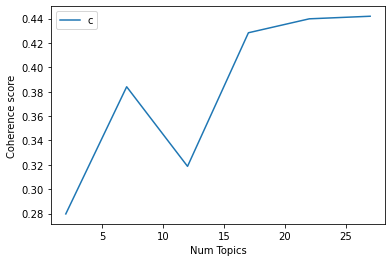

In [121]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_sg_2018_score1N2N3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [122]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_sg_2018_score1N2N3):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 17

index: 0 | Num Topics = 2  has Coherence Value of 0.2798
index: 1 | Num Topics = 7  has Coherence Value of 0.3841
index: 2 | Num Topics = 12  has Coherence Value of 0.3188
index: 3 | Num Topics = 17  has Coherence Value of 0.4284
index: 4 | Num Topics = 22  has Coherence Value of 0.4398
index: 5 | Num Topics = 27  has Coherence Value of 0.4419


In [187]:
# Select optimal number of topics
optimal_model_sg_2018_score1N2N3 = model_list_sg_2018_score1N2N3[3]

In [188]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_sg_2018_score1N2N3 = pyLDAvis.gensim_models.prepare(optimal_model_sg_2018_score1N2N3, corpus_sg_2018_score1N2N3, id2word_sg_2018_score1N2N3)

In [189]:
print("pyLDAVis for SG topics for score=1,2,3 in 2018:")
vis_sg_2018_score1N2N3

pyLDAVis for SG topics for score=1,2,3 in 2018:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
16     0.120538 -0.013145       1        1  14.889572
15     0.055241  0.167390       2        1  13.194281
1      0.109102 -0.021501       3        1   8.342201
12     0.086943 -0.005033       4        1   7.735450
3      0.105185 -0.011804       5        1   7.294795
6      0.000947 -0.141181       6        1   6.900814
13     0.021448 -0.125061       7        1   6.543558
0      0.053917  0.062379       8        1   6.161993
2      0.030771  0.009414       9        1   5.538929
4     -0.026184 -0.042525      10        1   3.891572
5     -0.077962  0.052477      11        1   3.557711
7     -0.114625 -0.047635      12        1   3.385827
14    -0.057278  0.083792      13        1   3.279004
11    -0.012410  0.008991      14        1   3.151848
8     -0.147449  0.021630      15        1   2.809630
10    -0.051486  0.029171      16        1   1.966698
9     -0.096698 -0.027358      17        1   1.356119, topic_info=             Term       Freq      Total Category  logprob  loglift
70         screen  25.000000  25.000000  Default  30.0000  30.0000
45             ad  20.000000  20.000000  Default  29.0000  29.0000
78           show  13.000000  13.000000  Default  28.0000  28.0000
46  advertisement  12.000000  12.000000  Default  27.0000  27.0000
43           time  11.000000  11.000000  Default  26.0000  26.0000
..            ...        ...        ...      ...      ...      ...
17       horrible   0.026036   1.441086  Topic17  -6.4361   0.2869
18    improvement   0.026036   1.441086  Topic17  -6.4361   0.2869
19          issue   0.026036   7.485769  Topic17  -6.4361  -1.3607
20           next   0.026036   2.229827  Topic17  -6.4361  -0.1497
21           note   0.026036   1.441086  Topic17  -6.4361   0.2869

[765 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
59        1  0.228587        able
59        3  0.228587        able
59        4  0.228587        able
59        9  0.228587        able
59       16  0.228587        able
...     ...       ...         ...
347       1  0.647505   yesterday
248       5  0.683336    youtuber
209       3  0.674028          yt
182       6  0.685342         一个叫
261      14  0.754404  任何视频最好沒有广告

[787 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[17, 16, 2, 13, 4, 7, 14, 1, 3, 5, 6, 8, 15, 12, 9, 11, 10])

## By-rating of 2019 (Rating=1,2,3)

In [126]:
# By-rating Topic Modelling - rating = 1,2,3 in 2019
# Convert to list - move to each section
review_sg_2019_score1N2N3 = youtube_ios_sg_review_YearMonth_2019_score1N2N3.review.values.tolist()
review_words_sg_2019_score1N2N3 = list(sent_to_words(review_sg_2019_score1N2N3))
print(review_words_sg_2019_score1N2N3[:1])

[['recently', 'when', 'click', 'return', 'on', 'my', 'samsung', 'phone', 'it', 'brings', 'me', 'back', 'to', 'the', 'previous', 'video', 'and', 'made', 'me', 'lose', 'the', 'video', 'want', 'to', 'watch', 'please', 'fix', 'it', 'asap', 'as', 'im', 'unable', 'to', 'control', 'my', 'anger', 'on', 'it']]


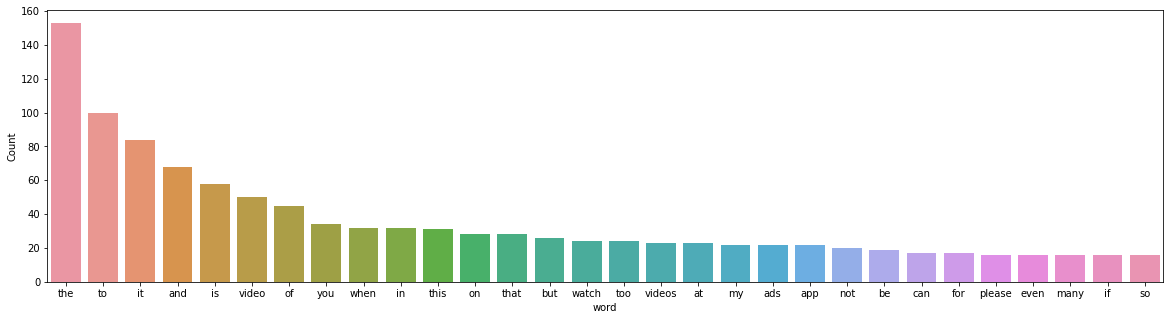

In [127]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_sg_2019_score1N2N3))

In [128]:
# Clean text
review_words_sg_ready_2019_score1N2N3 = process_words(review_words_sg_2019_score1N2N3)  # processed Text Data! - move to each section

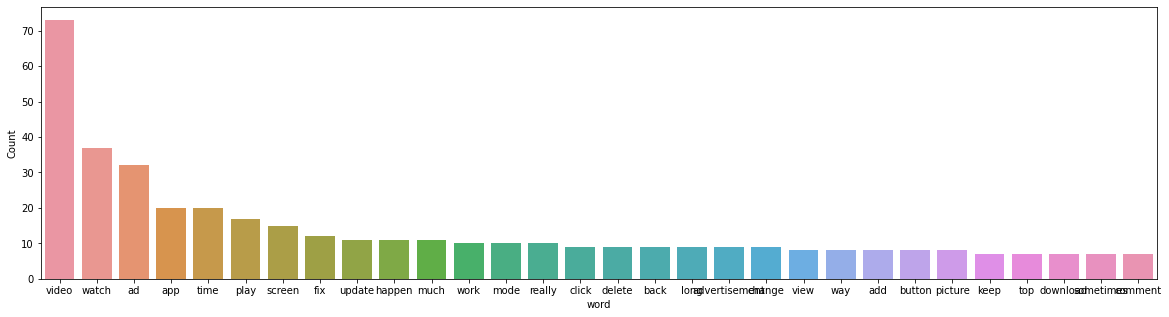

In [129]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_words_sg_ready_2019_score1N2N3))


In [130]:
# Create Dictionary
id2word_sg_2019_score1N2N3 = corpora.Dictionary(review_words_sg_ready_2019_score1N2N3)

2021-10-16 23:58:36,020 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 23:58:36,029 [INFO] gensim.corpora.dictionary - built Dictionary(488 unique tokens: ['anger', 'asap', 'bring', 'click', 'control']...) from 88 documents (total 1200 corpus positions)
2021-10-16 23:58:36,033 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(488 unique tokens: ['anger', 'asap', 'bring', 'click', 'control']...) from 88 documents (total 1200 corpus positions)", 'datetime': '2021-10-16T23:58:36.033000', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [131]:
# Create Corpus: Term Document Frequency
corpus_sg_2019_score1N2N3 = [id2word_sg_2019_score1N2N3.doc2bow(text) for text in review_words_sg_ready_2019_score1N2N3]

In [132]:
# Training LDA model
model_list_sg_2019_score1N2N3, coherence_values_sg_2019_score1N2N3 = compute_coherence_values(dictionary=id2word_sg_2019_score1N2N3, corpus=corpus_sg_2019_score1N2N3, 
                                                              texts=review_words_sg_ready_2019_score1N2N3, limit=30, start=2, step=5)


2021-10-16 23:58:36,072 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 23:58:36,078 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 23:58:36,089 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 23:58:36,101 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 88 documents, updating model once every 88 documents, evaluating perplexity every 88 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 23:58:36,778 [INFO] gensim.models.ldamodel - -6.881 per-word bound, 117.9 perplexity estimate based on a held-out corpus of 88 documents with 1200 words
2021-10-16 23:58:36,780 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #88/88
2021-10-16 23:58:37,244 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.057*"video" + 0.029*"watch" + 0.027*"ad" + 0.014*"time" + 0.013*"play" + 0.011*"app" + 0.009*"long" + 0.008*

2021-10-16 23:58:40,539 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.025*"video" + 0.015*"really" + 0.012*"app" + 0.012*"advertisement" + 0.012*"watch" + 0.012*"screen" + 0.011*"mode" + 0.010*"much" + 0.009*"time" + 0.009*"fix"
2021-10-16 23:58:40,541 [INFO] gensim.models.ldamodel - topic diff=0.012509, rho=0.301511
2021-10-16 23:58:40,747 [INFO] gensim.models.ldamodel - -6.063 per-word bound, 66.8 perplexity estimate based on a held-out corpus of 88 documents with 1200 words
2021-10-16 23:58:40,749 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #88/88
2021-10-16 23:58:40,873 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.058*"video" + 0.030*"watch" + 0.029*"ad" + 0.018*"play" + 0.015*"time" + 0.013*"app" + 0.010*"happen" + 0.010*"long" + 0.009*"picture" + 0.009*"change"
2021-10-16 23:58:40,880 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.025*"video" + 0.015*"really" + 0.012*"app" + 0.012*"advertisement" + 0.012*"watch" + 0.012*"screen" + 0.011*"mode"

2021-10-16 23:58:43,242 [INFO] gensim.models.ldamodel - topic diff=0.002279, rho=0.218218
2021-10-16 23:58:43,370 [INFO] gensim.models.ldamodel - -6.058 per-word bound, 66.6 perplexity estimate based on a held-out corpus of 88 documents with 1200 words
2021-10-16 23:58:43,373 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #88/88
2021-10-16 23:58:43,491 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.058*"video" + 0.030*"watch" + 0.029*"ad" + 0.018*"play" + 0.015*"time" + 0.012*"app" + 0.010*"happen" + 0.010*"long" + 0.009*"picture" + 0.009*"change"
2021-10-16 23:58:43,492 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.025*"video" + 0.015*"really" + 0.012*"app" + 0.012*"screen" + 0.012*"advertisement" + 0.012*"watch" + 0.011*"mode" + 0.010*"much" + 0.010*"comment" + 0.010*"fix"
2021-10-16 23:58:43,493 [INFO] gensim.models.ldamodel - topic diff=0.002091, rho=0.213201
2021-10-16 23:58:43,629 [INFO] gensim.models.ldamodel - -6.057 per-word bound, 66.6 perplexity es

2021-10-16 23:58:45,907 [INFO] gensim.models.ldamodel - -6.056 per-word bound, 66.5 perplexity estimate based on a held-out corpus of 88 documents with 1200 words
2021-10-16 23:58:45,914 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #88/88
2021-10-16 23:58:46,014 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.058*"video" + 0.030*"watch" + 0.029*"ad" + 0.018*"play" + 0.015*"time" + 0.013*"app" + 0.010*"happen" + 0.010*"long" + 0.009*"picture" + 0.009*"change"
2021-10-16 23:58:46,016 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.025*"video" + 0.015*"really" + 0.012*"screen" + 0.012*"app" + 0.012*"advertisement" + 0.012*"watch" + 0.012*"mode" + 0.010*"comment" + 0.010*"much" + 0.010*"fix"
2021-10-16 23:58:46,017 [INFO] gensim.models.ldamodel - topic diff=0.002321, rho=0.176777
2021-10-16 23:58:46,139 [INFO] gensim.models.ldamodel - -6.056 per-word bound, 66.5 perplexity estimate based on a held-out corpus of 88 documents with 1200 words
2021-10-16 23:58:46,141 

2021-10-16 23:58:48,363 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #88/88
2021-10-16 23:58:48,477 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.058*"video" + 0.031*"watch" + 0.029*"ad" + 0.018*"play" + 0.016*"time" + 0.013*"app" + 0.010*"happen" + 0.010*"long" + 0.009*"picture" + 0.009*"change"
2021-10-16 23:58:48,482 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.024*"video" + 0.014*"really" + 0.013*"screen" + 0.012*"advertisement" + 0.012*"app" + 0.012*"watch" + 0.012*"mode" + 0.010*"fix" + 0.010*"comment" + 0.010*"much"
2021-10-16 23:58:48,483 [INFO] gensim.models.ldamodel - topic diff=0.001194, rho=0.154303
2021-10-16 23:58:48,610 [INFO] gensim.models.ldamodel - -6.053 per-word bound, 66.4 perplexity estimate based on a held-out corpus of 88 documents with 1200 words
2021-10-16 23:58:48,611 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #88/88
2021-10-16 23:58:48,741 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.058*"video" + 0.0

2021-10-16 23:58:50,630 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 23:58:55,193 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 23:58:55,214 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 85 virtual documents
2021-10-16 23:58:55,503 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-16 23:58:55,504 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
2021-10-16 23:58:55,506 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 23:58:55,510 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 7 topics, 50 passes over the supplied corpus of 88 documents, updating model once every 88 documents, evaluating perplexity every 88 documents, iterating 50x with a converg

2021-10-16 23:58:56,876 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.069*"video" + 0.021*"watch" + 0.019*"time" + 0.018*"screen" + 0.017*"really" + 0.014*"much" + 0.014*"advertisement" + 0.014*"back" + 0.013*"click" + 0.011*"black"
2021-10-16 23:58:56,880 [INFO] gensim.models.ldamodel - topic diff=0.055822, rho=0.408248
2021-10-16 23:58:57,013 [INFO] gensim.models.ldamodel - -6.384 per-word bound, 83.5 perplexity estimate based on a held-out corpus of 88 documents with 1200 words
2021-10-16 23:58:57,015 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #88/88
2021-10-16 23:58:57,072 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.039*"ad" + 0.022*"advertisement" + 0.022*"remove" + 0.020*"turn" + 0.016*"mode" + 0.015*"long" + 0.015*"annoying" + 0.015*"skip" + 0.015*"quite" + 0.015*"annoy"
2021-10-16 23:58:57,074 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.072*"video" + 0.038*"watch" + 0.029*"ad" + 0.021*"play" + 0.018*"download" + 0.015*"app" + 0.013*"scre

2021-10-16 23:58:58,114 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.018*"app" + 0.013*"watch" + 0.013*"change" + 0.013*"give" + 0.013*"minute" + 0.013*"listening" + 0.009*"thing" + 0.008*"video" + 0.007*"much" + 0.007*"advertisement"
2021-10-16 23:58:58,115 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.036*"ad" + 0.022*"advertisement" + 0.022*"remove" + 0.022*"mode" + 0.022*"turn" + 0.015*"long" + 0.015*"annoying" + 0.015*"skip" + 0.015*"quite" + 0.015*"annoy"
2021-10-16 23:58:58,118 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.031*"view" + 0.025*"app" + 0.025*"delete" + 0.019*"work" + 0.013*"load" + 0.013*"play" + 0.013*"problem" + 0.013*"start" + 0.013*"hard" + 0.013*"add"
2021-10-16 23:58:58,121 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.073*"video" + 0.038*"watch" + 0.029*"ad" + 0.021*"play" + 0.018*"download" + 0.015*"app" + 0.013*"screen" + 0.013*"fix" + 0.011*"long" + 0.011*"picture"
2021-10-16 23:58:58,122 [INFO] gensim.models.ldamodel - topic diff

2021-10-16 23:58:59,253 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.049*"video" + 0.045*"ad" + 0.038*"watch" + 0.019*"happen" + 0.019*"time" + 0.015*"play" + 0.015*"button" + 0.012*"way" + 0.012*"stop" + 0.012*"close"
2021-10-16 23:58:59,255 [INFO] gensim.models.ldamodel - topic diff=0.002099, rho=0.242536
2021-10-16 23:58:59,374 [INFO] gensim.models.ldamodel - -6.367 per-word bound, 82.5 perplexity estimate based on a held-out corpus of 88 documents with 1200 words
2021-10-16 23:58:59,375 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #88/88
2021-10-16 23:58:59,438 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.049*"video" + 0.045*"ad" + 0.038*"watch" + 0.019*"happen" + 0.019*"time" + 0.015*"play" + 0.015*"button" + 0.012*"way" + 0.012*"stop" + 0.012*"close"
2021-10-16 23:58:59,443 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.072*"video" + 0.038*"watch" + 0.029*"ad" + 0.021*"play" + 0.019*"download" + 0.015*"app" + 0.013*"screen" + 0.013*"fix" + 0.0

2021-10-16 23:59:00,406 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.068*"video" + 0.021*"watch" + 0.019*"time" + 0.019*"screen" + 0.017*"really" + 0.014*"much" + 0.014*"back" + 0.014*"advertisement" + 0.012*"click" + 0.011*"show"
2021-10-16 23:59:00,407 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.072*"video" + 0.038*"watch" + 0.029*"ad" + 0.021*"play" + 0.019*"download" + 0.015*"app" + 0.013*"screen" + 0.013*"fix" + 0.011*"long" + 0.011*"upload"
2021-10-16 23:59:00,408 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.031*"view" + 0.025*"app" + 0.025*"delete" + 0.019*"work" + 0.013*"add" + 0.013*"update" + 0.013*"load" + 0.013*"start" + 0.013*"hard" + 0.013*"problem"
2021-10-16 23:59:00,412 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.015*"app" + 0.013*"change" + 0.013*"give" + 0.013*"minute" + 0.013*"listening" + 0.013*"watch" + 0.008*"thing" + 0.007*"video" + 0.007*"advertisement" + 0.007*"much"
2021-10-16 23:59:00,415 [INFO] gensim.models.ldamodel - topic di

2021-10-16 23:59:01,573 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.031*"view" + 0.025*"app" + 0.025*"delete" + 0.019*"work" + 0.013*"add" + 0.013*"update" + 0.013*"load" + 0.013*"time" + 0.013*"hard" + 0.013*"start"
2021-10-16 23:59:01,580 [INFO] gensim.models.ldamodel - topic diff=0.000167, rho=0.188982
2021-10-16 23:59:01,738 [INFO] gensim.models.ldamodel - -6.367 per-word bound, 82.5 perplexity estimate based on a held-out corpus of 88 documents with 1200 words
2021-10-16 23:59:01,740 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #88/88
2021-10-16 23:59:01,791 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.068*"video" + 0.021*"watch" + 0.019*"time" + 0.019*"screen" + 0.017*"really" + 0.014*"much" + 0.014*"back" + 0.014*"advertisement" + 0.012*"click" + 0.011*"show"
2021-10-16 23:59:01,793 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.022*"picture" + 0.022*"video" + 0.016*"time" + 0.016*"app" + 0.016*"search" + 0.016*"comment" + 0.014*"mode" + 0.0

2021-10-16 23:59:02,930 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.031*"view" + 0.025*"app" + 0.025*"delete" + 0.019*"work" + 0.013*"add" + 0.013*"update" + 0.013*"time" + 0.013*"load" + 0.013*"hard" + 0.013*"start"
2021-10-16 23:59:02,932 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.049*"video" + 0.045*"ad" + 0.038*"watch" + 0.019*"happen" + 0.019*"time" + 0.015*"button" + 0.015*"play" + 0.012*"stop" + 0.012*"iphone" + 0.012*"close"
2021-10-16 23:59:02,936 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.036*"ad" + 0.026*"mode" + 0.022*"turn" + 0.022*"advertisement" + 0.022*"remove" + 0.015*"annoy" + 0.015*"long" + 0.015*"annoying" + 0.015*"restrict" + 0.015*"skip"
2021-10-16 23:59:02,939 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.068*"video" + 0.021*"watch" + 0.019*"screen" + 0.019*"time" + 0.017*"really" + 0.014*"much" + 0.014*"back" + 0.014*"advertisement" + 0.012*"click" + 0.011*"show"
2021-10-16 23:59:02,942 [INFO] gensim.models.ldamodel - topic diff=0

2021-10-16 23:59:04,110 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.013*"app" + 0.013*"change" + 0.013*"give" + 0.013*"minute" + 0.013*"listening" + 0.013*"watch" + 0.008*"thing" + 0.007*"video" + 0.007*"add" + 0.007*"appreciate"
2021-10-16 23:59:04,111 [INFO] gensim.models.ldamodel - topic diff=0.000032, rho=0.160128
2021-10-16 23:59:04,191 [INFO] gensim.models.ldamodel - -6.367 per-word bound, 82.5 perplexity estimate based on a held-out corpus of 88 documents with 1200 words
2021-10-16 23:59:04,193 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #88/88
2021-10-16 23:59:04,255 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.072*"video" + 0.038*"watch" + 0.029*"ad" + 0.021*"play" + 0.019*"download" + 0.014*"app" + 0.013*"screen" + 0.013*"fix" + 0.011*"long" + 0.011*"upload"
2021-10-16 23:59:04,257 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.013*"app" + 0.013*"change" + 0.013*"give" + 0.013*"minute" + 0.013*"listening" + 0.013*"watch" + 0.008*"thing" 

2021-10-16 23:59:05,295 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.072*"video" + 0.038*"watch" + 0.029*"ad" + 0.021*"play" + 0.019*"download" + 0.014*"app" + 0.013*"screen" + 0.013*"fix" + 0.011*"long" + 0.011*"upload"
2021-10-16 23:59:05,296 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.022*"picture" + 0.022*"video" + 0.016*"time" + 0.016*"app" + 0.016*"search" + 0.016*"comment" + 0.014*"mode" + 0.012*"work" + 0.012*"fix" + 0.011*"fine"
2021-10-16 23:59:05,298 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.049*"video" + 0.045*"ad" + 0.038*"watch" + 0.019*"happen" + 0.019*"time" + 0.015*"button" + 0.015*"play" + 0.012*"stop" + 0.012*"iphone" + 0.012*"close"
2021-10-16 23:59:05,303 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.031*"view" + 0.025*"app" + 0.025*"delete" + 0.019*"work" + 0.013*"add" + 0.013*"update" + 0.013*"time" + 0.013*"load" + 0.013*"hard" + 0.013*"start"
2021-10-16 23:59:05,306 [INFO] gensim.models.ldamodel - topic diff=0.000017, rho=0.149071

2021-10-16 23:59:06,492 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.013*"change" + 0.013*"give" + 0.013*"minute" + 0.013*"listening" + 0.013*"watch" + 0.013*"app" + 0.008*"thing" + 0.007*"video" + 0.007*"add" + 0.007*"appreciate"
2021-10-16 23:59:06,494 [INFO] gensim.models.ldamodel - topic diff=0.000011, rho=0.141421
2021-10-16 23:59:06,613 [INFO] gensim.models.ldamodel - -6.367 per-word bound, 82.5 perplexity estimate based on a held-out corpus of 88 documents with 1200 words
2021-10-16 23:59:06,614 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #88/88
2021-10-16 23:59:06,751 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.068*"video" + 0.021*"watch" + 0.019*"screen" + 0.019*"time" + 0.017*"really" + 0.014*"much" + 0.014*"back" + 0.014*"advertisement" + 0.012*"click" + 0.011*"show"
2021-10-16 23:59:06,752 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.013*"change" + 0.013*"give" + 0.013*"minute" + 0.013*"listening" + 0.013*"watch" + 0.013*"app" + 0.00

2021-10-16 23:59:14,746 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.030*"view" + 0.025*"much" + 0.025*"app" + 0.025*"picture" + 0.025*"time" + 0.019*"advertisement" + 0.019*"long" + 0.013*"unable" + 0.013*"watch" + 0.013*"video"
2021-10-16 23:59:14,747 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.040*"fix" + 0.033*"video" + 0.025*"button" + 0.024*"ad" + 0.017*"previous" + 0.017*"click" + 0.017*"bar" + 0.017*"lose" + 0.017*"watch" + 0.017*"unable"
2021-10-16 23:59:14,748 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.047*"picture" + 0.035*"change" + 0.024*"hope" + 0.024*"guy" + 0.024*"iphone" + 0.014*"really" + 0.013*"app" + 0.013*"view" + 0.013*"background" + 0.012*"show"
2021-10-16 23:59:14,750 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.028*"airplay" + 0.020*"work" + 0.020*"hard" + 0.019*"screen" + 0.019*"connect" + 0.010*"start" + 0.010*"yet" + 0.010*"speculate" + 0.010*"artist" + 0.010*"problem"
2021-10-16 23:59:14,751 [INFO] gensim.models.ldamodel - to

2021-10-16 23:59:15,762 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.088*"video" + 0.035*"play" + 0.032*"time" + 0.025*"watch" + 0.022*"happen" + 0.022*"app" + 0.013*"click" + 0.013*"much" + 0.010*"screen" + 0.010*"update"
2021-10-16 23:59:15,763 [INFO] gensim.models.ldamodel - topic diff=0.016698, rho=0.316228
2021-10-16 23:59:15,871 [INFO] gensim.models.ldamodel - -6.468 per-word bound, 88.5 perplexity estimate based on a held-out corpus of 88 documents with 1200 words
2021-10-16 23:59:15,875 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #88/88
2021-10-16 23:59:15,959 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.048*"picture" + 0.036*"change" + 0.024*"iphone" + 0.024*"hope" + 0.024*"guy" + 0.013*"really" + 0.013*"app" + 0.013*"view" + 0.013*"background" + 0.013*"update"
2021-10-16 23:59:15,962 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.080*"ad" + 0.048*"remove" + 0.017*"people" + 0.017*"double" + 0.017*"tend" + 0.017*"advice" + 0.017*"realise" +

2021-10-16 23:59:16,994 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.043*"ad" + 0.042*"screen" + 0.036*"video" + 0.029*"way" + 0.029*"back" + 0.028*"watch" + 0.027*"black" + 0.022*"top" + 0.018*"play" + 0.015*"comment"
2021-10-16 23:59:16,995 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.083*"video" + 0.051*"watch" + 0.046*"ad" + 0.019*"mode" + 0.019*"sometimes" + 0.014*"turn" + 0.014*"really" + 0.014*"always" + 0.010*"never" + 0.010*"restrict"
2021-10-16 23:59:16,997 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.023*"video" + 0.015*"button" + 0.015*"volume" + 0.015*"change" + 0.015*"add" + 0.015*"watch" + 0.015*"app" + 0.015*"screen" + 0.015*"thing" + 0.015*"give"
2021-10-16 23:59:16,998 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.031*"view" + 0.025*"much" + 0.025*"app" + 0.025*"picture" + 0.025*"time" + 0.019*"advertisement" + 0.019*"long" + 0.013*"unable" + 0.013*"watch" + 0.013*"video"
2021-10-16 23:59:17,000 [INFO] gensim.models.ldamodel - topic diff=0.0

2021-10-16 23:59:18,013 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.080*"ad" + 0.048*"remove" + 0.017*"people" + 0.017*"double" + 0.017*"tend" + 0.017*"realise" + 0.017*"word" + 0.017*"advice" + 0.017*"play" + 0.017*"annoying"
2021-10-16 23:59:18,015 [INFO] gensim.models.ldamodel - topic diff=0.001691, rho=0.218218
2021-10-16 23:59:18,120 [INFO] gensim.models.ldamodel - -6.457 per-word bound, 87.9 perplexity estimate based on a held-out corpus of 88 documents with 1200 words
2021-10-16 23:59:18,121 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #88/88
2021-10-16 23:59:18,232 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.048*"picture" + 0.036*"change" + 0.024*"iphone" + 0.024*"hope" + 0.024*"guy" + 0.013*"really" + 0.013*"app" + 0.013*"view" + 0.013*"background" + 0.013*"update"
2021-10-16 23:59:18,235 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.062*"work" + 0.047*"upload" + 0.032*"function" + 0.032*"date" + 0.030*"filter" + 0.017*"month" + 0.017*"

2021-10-16 23:59:19,168 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.062*"work" + 0.047*"upload" + 0.032*"function" + 0.032*"date" + 0.030*"filter" + 0.017*"month" + 0.017*"channel" + 0.017*"protect" + 0.017*"today" + 0.017*"sort"
2021-10-16 23:59:19,169 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.089*"video" + 0.035*"play" + 0.032*"time" + 0.026*"watch" + 0.023*"happen" + 0.021*"app" + 0.013*"click" + 0.013*"much" + 0.010*"screen" + 0.010*"update"
2021-10-16 23:59:19,171 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.043*"delete" + 0.036*"video" + 0.035*"really" + 0.026*"seriously" + 0.024*"watch" + 0.018*"middle" + 0.018*"hate" + 0.018*"biased" + 0.018*"look" + 0.017*"frustrating"
2021-10-16 23:59:19,174 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.029*"airplay" + 0.020*"work" + 0.020*"hard" + 0.020*"screen" + 0.020*"connect" + 0.010*"bar" + 0.010*"full" + 0.010*"instead" + 0.010*"landscape" + 0.010*"start"
2021-10-16 23:59:19,175 [INFO] gensim.models.ldam

2021-10-16 23:59:20,156 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.043*"delete" + 0.036*"video" + 0.035*"really" + 0.026*"seriously" + 0.024*"watch" + 0.018*"middle" + 0.018*"hate" + 0.018*"biased" + 0.018*"look" + 0.018*"frustrating"
2021-10-16 23:59:20,157 [INFO] gensim.models.ldamodel - topic diff=0.000396, rho=0.176777
2021-10-16 23:59:20,230 [INFO] gensim.models.ldamodel - -6.456 per-word bound, 87.8 perplexity estimate based on a held-out corpus of 88 documents with 1200 words
2021-10-16 23:59:20,231 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #88/88
2021-10-16 23:59:20,389 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.051*"video" + 0.040*"download" + 0.022*"watch" + 0.020*"keep" + 0.020*"fix" + 0.014*"upgrade" + 0.014*"bug" + 0.014*"long" + 0.014*"time" + 0.014*"offline"
2021-10-16 23:59:20,392 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.043*"delete" + 0.036*"video" + 0.035*"really" + 0.026*"seriously" + 0.024*"watch" + 0.018*"middle" + 

2021-10-16 23:59:21,506 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.043*"delete" + 0.036*"video" + 0.035*"really" + 0.026*"seriously" + 0.024*"watch" + 0.018*"middle" + 0.018*"hate" + 0.018*"look" + 0.018*"biased" + 0.018*"frustrating"
2021-10-16 23:59:21,510 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.029*"airplay" + 0.020*"work" + 0.020*"hard" + 0.020*"screen" + 0.020*"connect" + 0.010*"bar" + 0.010*"full" + 0.010*"landscape" + 0.010*"instead" + 0.010*"home"
2021-10-16 23:59:21,511 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.031*"view" + 0.025*"much" + 0.025*"time" + 0.025*"picture" + 0.025*"app" + 0.019*"advertisement" + 0.019*"long" + 0.013*"way" + 0.013*"unable" + 0.013*"allow"
2021-10-16 23:59:21,514 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.083*"video" + 0.051*"watch" + 0.046*"ad" + 0.019*"mode" + 0.019*"sometimes" + 0.014*"turn" + 0.014*"really" + 0.014*"always" + 0.010*"restrict" + 0.010*"never"
2021-10-16 23:59:21,516 [INFO] gensim.models.lda

2021-10-16 23:59:22,466 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.042*"fix" + 0.034*"video" + 0.026*"button" + 0.026*"ad" + 0.017*"bar" + 0.017*"previous" + 0.017*"click" + 0.017*"unable" + 0.017*"lose" + 0.017*"watch"
2021-10-16 23:59:22,467 [INFO] gensim.models.ldamodel - topic diff=0.000076, rho=0.152499
2021-10-16 23:59:22,549 [INFO] gensim.models.ldamodel - -6.456 per-word bound, 87.8 perplexity estimate based on a held-out corpus of 88 documents with 1200 words
2021-10-16 23:59:22,554 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #88/88
2021-10-16 23:59:22,648 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.051*"video" + 0.040*"download" + 0.022*"watch" + 0.020*"keep" + 0.020*"fix" + 0.014*"upgrade" + 0.014*"bug" + 0.014*"long" + 0.014*"time" + 0.014*"offline"
2021-10-16 23:59:22,652 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.029*"airplay" + 0.020*"work" + 0.020*"screen" + 0.020*"hard" + 0.020*"connect" + 0.010*"bar" + 0.010*"full" + 0.010

2021-10-16 23:59:23,915 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.062*"work" + 0.047*"upload" + 0.032*"function" + 0.032*"date" + 0.030*"filter" + 0.017*"month" + 0.017*"channel" + 0.017*"protect" + 0.017*"sort" + 0.017*"today"
2021-10-16 23:59:23,919 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.083*"video" + 0.051*"watch" + 0.046*"ad" + 0.019*"mode" + 0.019*"sometimes" + 0.014*"turn" + 0.014*"really" + 0.014*"always" + 0.010*"check" + 0.010*"restrict"
2021-10-16 23:59:23,920 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.048*"picture" + 0.036*"change" + 0.024*"iphone" + 0.024*"hope" + 0.024*"guy" + 0.013*"update" + 0.013*"annoying" + 0.013*"bring" + 0.013*"landscape" + 0.013*"really"
2021-10-16 23:59:23,925 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.043*"delete" + 0.036*"video" + 0.035*"really" + 0.026*"seriously" + 0.024*"watch" + 0.018*"middle" + 0.018*"look" + 0.018*"hate" + 0.018*"biased" + 0.018*"frustrating"
2021-10-16 23:59:23,926 [INFO] gensim.m

2021-10-16 23:59:33,477 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.051*"video" + 0.026*"volume" + 0.026*"iphone" + 0.026*"add" + 0.026*"keep" + 0.026*"watch" + 0.026*"close" + 0.014*"app" + 0.014*"much" + 0.013*"bar"
2021-10-16 23:59:33,489 [INFO] gensim.models.ldamodel - topic diff=0.157485, rho=0.577350
2021-10-16 23:59:33,535 [INFO] gensim.models.ldamodel - -6.668 per-word bound, 101.7 perplexity estimate based on a held-out corpus of 88 documents with 1200 words
2021-10-16 23:59:33,538 [INFO] gensim.models.ldamodel - PROGRESS: pass 2, at document #88/88
2021-10-16 23:59:33,617 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.038*"video" + 0.032*"implement" + 0.026*"watch" + 0.017*"world" + 0.017*"io" + 0.017*"cook" + 0.017*"informative" + 0.017*"upload" + 0.017*"unable" + 0.017*"current"
2021-10-16 23:59:33,618 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.068*"video" + 0.039*"watch" + 0.020*"really" + 0.017*"click" + 0.017*"fix" + 0.016*"delete" + 0.013*"screen"

2021-10-16 23:59:35,034 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.042*"much" + 0.042*"advertisement" + 0.028*"time" + 0.028*"long" + 0.028*"app" + 0.028*"ad" + 0.015*"debate" + 0.015*"ready" + 0.015*"finger" + 0.015*"audio"
2021-10-16 23:59:35,039 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.074*"time" + 0.039*"app" + 0.039*"update" + 0.039*"fine" + 0.020*"problem" + 0.020*"hot" + 0.020*"extremely" + 0.020*"last" + 0.020*"open" + 0.020*"iphone"
2021-10-16 23:59:35,051 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.050*"video" + 0.027*"volume" + 0.027*"iphone" + 0.027*"keep" + 0.027*"add" + 0.027*"close" + 0.021*"watch" + 0.014*"app" + 0.014*"much" + 0.014*"solve"
2021-10-16 23:59:35,054 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.050*"fix" + 0.050*"search" + 0.026*"ad" + 0.026*"really" + 0.026*"type" + 0.026*"ruin" + 0.026*"experience" + 0.026*"bar" + 0.026*"thumb" + 0.026*"bug"
2021-10-16 23:59:35,055 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.0

2021-10-16 23:59:36,295 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.050*"fix" + 0.050*"search" + 0.026*"ad" + 0.026*"really" + 0.026*"experience" + 0.026*"ruin" + 0.026*"thumb" + 0.026*"type" + 0.026*"bar" + 0.026*"bug"
2021-10-16 23:59:36,298 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.038*"ad" + 0.023*"time" + 0.023*"video" + 0.023*"screen" + 0.023*"annoying" + 0.023*"airplay" + 0.015*"full" + 0.015*"multiple" + 0.015*"bar" + 0.015*"keep"
2021-10-16 23:59:36,299 [INFO] gensim.models.ldamodel - topic diff=0.005443, rho=0.267261
2021-10-16 23:59:36,444 [INFO] gensim.models.ldamodel - -6.522 per-word bound, 91.9 perplexity estimate based on a held-out corpus of 88 documents with 1200 words
2021-10-16 23:59:36,447 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #88/88
2021-10-16 23:59:36,626 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.049*"video" + 0.027*"keep" + 0.027*"iphone" + 0.027*"close" + 0.027*"volume" + 0.027*"add" + 0.019*"watch" + 0.014

2021-10-16 23:59:37,758 [INFO] gensim.models.ldamodel - PROGRESS: pass 18, at document #88/88
2021-10-16 23:59:37,850 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.048*"video" + 0.027*"close" + 0.027*"keep" + 0.027*"volume" + 0.027*"iphone" + 0.027*"add" + 0.018*"watch" + 0.014*"app" + 0.014*"much" + 0.014*"solve"
2021-10-16 23:59:37,863 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.098*"video" + 0.055*"play" + 0.037*"app" + 0.019*"time" + 0.019*"work" + 0.019*"watch" + 0.019*"happen" + 0.019*"click" + 0.013*"top" + 0.013*"screen"
2021-10-16 23:59:37,864 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.028*"experience" + 0.028*"never" + 0.028*"issue" + 0.028*"update" + 0.028*"improvement" + 0.028*"lately" + 0.028*"load" + 0.028*"problem" + 0.028*"bring" + 0.002*"refuse"
2021-10-16 23:59:37,869 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.053*"remove" + 0.027*"way" + 0.027*"watch" + 0.027*"vidz" + 0.027*"ad" + 0.027*"disturb" + 0.027*"unnecessary" + 0.027*"content"

2021-10-16 23:59:38,804 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.077*"time" + 0.039*"app" + 0.039*"update" + 0.039*"fine" + 0.020*"problem" + 0.020*"connection" + 0.020*"horrible" + 0.020*"happen" + 0.020*"work" + 0.020*"already"
2021-10-16 23:59:38,806 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.060*"video" + 0.020*"happen" + 0.020*"close" + 0.020*"stop" + 0.020*"give" + 0.020*"minute" + 0.011*"page" + 0.011*"scroll" + 0.011*"hear" + 0.011*"audio"
2021-10-16 23:59:38,807 [INFO] gensim.models.ldamodel - topic diff=0.000595, rho=0.200000
2021-10-16 23:59:38,934 [INFO] gensim.models.ldamodel - -6.516 per-word bound, 91.5 perplexity estimate based on a held-out corpus of 88 documents with 1200 words
2021-10-16 23:59:38,941 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #88/88
2021-10-16 23:59:39,029 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.055*"view" + 0.044*"picture" + 0.022*"time" + 0.022*"delete" + 0.022*"spend" + 0.022*"stream" + 0.022*"

2021-10-16 23:59:40,116 [INFO] gensim.models.ldamodel - PROGRESS: pass 29, at document #88/88
2021-10-16 23:59:40,248 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.051*"screen" + 0.043*"video" + 0.034*"back" + 0.026*"tap" + 0.026*"black" + 0.017*"comment" + 0.017*"top" + 0.017*"app" + 0.017*"advertisement" + 0.017*"middle"
2021-10-16 23:59:40,250 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.066*"video" + 0.037*"watch" + 0.022*"really" + 0.017*"click" + 0.017*"fix" + 0.017*"delete" + 0.013*"screen" + 0.013*"thing" + 0.013*"much" + 0.009*"app"
2021-10-16 23:59:40,256 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.048*"video" + 0.027*"close" + 0.027*"keep" + 0.027*"volume" + 0.027*"iphone" + 0.027*"add" + 0.018*"watch" + 0.014*"app" + 0.014*"much" + 0.014*"new"
2021-10-16 23:59:40,260 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.038*"ad" + 0.023*"video" + 0.023*"time" + 0.023*"screen" + 0.023*"annoying" + 0.023*"airplay" + 0.016*"sound" + 0.016*"keep" + 0.016*"a

2021-10-16 23:59:41,364 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.100*"ad" + 0.082*"watch" + 0.080*"video" + 0.031*"hate" + 0.023*"play" + 0.023*"always" + 0.016*"stop" + 0.016*"middle" + 0.016*"way" + 0.016*"sometimes"
2021-10-16 23:59:41,489 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.066*"video" + 0.037*"watch" + 0.022*"really" + 0.017*"click" + 0.017*"fix" + 0.017*"delete" + 0.013*"screen" + 0.013*"thing" + 0.013*"much" + 0.009*"app"
2021-10-16 23:59:41,490 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.051*"screen" + 0.043*"video" + 0.034*"back" + 0.026*"tap" + 0.026*"black" + 0.017*"comment" + 0.017*"top" + 0.017*"app" + 0.017*"middle" + 0.017*"advertisement"
2021-10-16 23:59:41,492 [INFO] gensim.models.ldamodel - topic diff=0.000108, rho=0.166667
2021-10-16 23:59:41,554 [INFO] gensim.models.ldamodel - -6.516 per-word bound, 91.5 perplexity estimate based on a held-out corpus of 88 documents with 1200 words
2021-10-16 23:59:41,563 [INFO] gensim.models.ldam

2021-10-16 23:59:42,646 [INFO] gensim.models.ldamodel - topic diff=0.000046, rho=0.156174
2021-10-16 23:59:42,844 [INFO] gensim.models.ldamodel - -6.516 per-word bound, 91.5 perplexity estimate based on a held-out corpus of 88 documents with 1200 words
2021-10-16 23:59:42,848 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #88/88
2021-10-16 23:59:42,893 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.051*"search" + 0.051*"fix" + 0.026*"ad" + 0.026*"really" + 0.026*"type" + 0.026*"experience" + 0.026*"bar" + 0.026*"thumb" + 0.026*"bug" + 0.026*"ruin"
2021-10-16 23:59:42,894 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.052*"remove" + 0.027*"way" + 0.027*"watch" + 0.027*"ad" + 0.027*"disturb" + 0.027*"unnecessary" + 0.027*"vidz" + 0.027*"annoying" + 0.027*"content" + 0.027*"country"
2021-10-16 23:59:42,897 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.051*"mode" + 0.042*"video" + 0.030*"restrict" + 0.025*"watch" + 0.022*"turn" + 0.022*"guy" + 0.021*"hope"

2021-10-16 23:59:44,067 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.042*"advertisement" + 0.042*"much" + 0.028*"time" + 0.028*"app" + 0.028*"long" + 0.028*"ad" + 0.015*"hv" + 0.015*"debate" + 0.015*"irrirate" + 0.015*"audio"
2021-10-16 23:59:44,075 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.052*"remove" + 0.027*"disturb" + 0.027*"watch" + 0.027*"vidz" + 0.027*"unnecessary" + 0.027*"way" + 0.027*"ad" + 0.027*"content" + 0.027*"annoying" + 0.027*"country"
2021-10-16 23:59:44,077 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.048*"video" + 0.027*"close" + 0.027*"iphone" + 0.027*"keep" + 0.027*"volume" + 0.027*"add" + 0.018*"watch" + 0.014*"app" + 0.014*"sound" + 0.014*"completely"
2021-10-16 23:59:44,080 [INFO] gensim.models.ldamodel - topic diff=0.000017, rho=0.145865
2021-10-16 23:59:44,194 [INFO] gensim.models.ldamodel - -6.516 per-word bound, 91.5 perplexity estimate based on a held-out corpus of 88 documents with 1200 words
2021-10-16 23:59:44,200 [INFO] gensim.

2021-10-16 23:59:56,242 [INFO] gensim.models.ldamodel - -22.523 per-word bound, 6027827.9 perplexity estimate based on a held-out corpus of 88 documents with 1200 words
2021-10-16 23:59:56,243 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #88/88
2021-10-16 23:59:56,452 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.047*"much" + 0.047*"watch" + 0.047*"advertisement" + 0.047*"video" + 0.024*"age" + 0.024*"live" + 0.024*"fix" + 0.024*"io" + 0.024*"time" + 0.024*"stream"
2021-10-16 23:59:56,474 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.046*"view" + 0.026*"spend" + 0.026*"time" + 0.026*"delete" + 0.018*"way" + 0.017*"watch" + 0.017*"vidz" + 0.017*"unnecessary" + 0.017*"ad" + 0.017*"remove"
2021-10-16 23:59:56,477 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.051*"change" + 0.031*"stop" + 0.026*"flaw" + 0.026*"bug" + 0.026*"look" + 0.026*"find" + 0.026*"seriously" + 0.026*"excuse" + 0.026*"profile" + 0.026*"awfully"
2021-10-16 23:59:56,482 [INFO] gensim

2021-10-16 23:59:57,528 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.038*"video" + 0.026*"really" + 0.022*"delete" + 0.021*"back" + 0.020*"top" + 0.018*"comment" + 0.018*"middle" + 0.018*"advertisement" + 0.018*"much" + 0.018*"biased"
2021-10-16 23:59:57,531 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.042*"mode" + 0.041*"iphone" + 0.036*"video" + 0.031*"turn" + 0.031*"hope" + 0.021*"guy" + 0.021*"never" + 0.021*"restrict" + 0.021*"completely" + 0.021*"close"
2021-10-16 23:59:57,533 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.089*"work" + 0.066*"upload" + 0.043*"date" + 0.043*"filter" + 0.023*"function" + 0.023*"sort" + 0.023*"much" + 0.023*"month" + 0.023*"almost" + 0.023*"today"
2021-10-16 23:59:57,537 [INFO] gensim.models.ldamodel - topic diff=0.053993, rho=0.377964
2021-10-16 23:59:57,647 [INFO] gensim.models.ldamodel - -6.624 per-word bound, 98.6 perplexity estimate based on a held-out corpus of 88 documents with 1200 words
2021-10-16 23:59:57,648 [INFO] ge

2021-10-16 23:59:58,792 [INFO] gensim.models.ldamodel - topic diff=0.012487, rho=0.288675
2021-10-16 23:59:58,996 [INFO] gensim.models.ldamodel - -6.603 per-word bound, 97.2 perplexity estimate based on a held-out corpus of 88 documents with 1200 words
2021-10-16 23:59:58,998 [INFO] gensim.models.ldamodel - PROGRESS: pass 11, at document #88/88
2021-10-16 23:59:59,118 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.055*"video" + 0.028*"watch" + 0.028*"click" + 0.028*"button" + 0.028*"mode" + 0.028*"huge" + 0.014*"fix" + 0.014*"update" + 0.014*"new" + 0.014*"unable"
2021-10-16 23:59:59,120 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.042*"problem" + 0.042*"work" + 0.042*"hard" + 0.021*"update" + 0.021*"issue" + 0.021*"lately" + 0.021*"experience" + 0.021*"bring" + 0.021*"never" + 0.021*"load"
2021-10-16 23:59:59,121 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.037*"download" + 0.037*"picture" + 0.028*"video" + 0.028*"change" + 0.019*"watch" + 0.019*"offline" + 0.019*

2021-10-17 00:00:00,745 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.098*"video" + 0.073*"watch" + 0.025*"hate" + 0.025*"always" + 0.018*"ad" + 0.017*"click" + 0.017*"bring" + 0.017*"sometimes" + 0.017*"app" + 0.009*"really"
2021-10-17 00:00:00,752 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.054*"advertisement" + 0.027*"double" + 0.027*"unable" + 0.027*"tap" + 0.027*"fast" + 0.027*"happen" + 0.027*"perform" + 0.027*"forward" + 0.027*"iphone" + 0.027*"annoying"
2021-10-17 00:00:00,753 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.055*"video" + 0.028*"watch" + 0.028*"click" + 0.028*"button" + 0.028*"mode" + 0.028*"huge" + 0.014*"fix" + 0.014*"update" + 0.014*"new" + 0.014*"comment"
2021-10-17 00:00:00,756 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.042*"mode" + 0.042*"iphone" + 0.035*"video" + 0.032*"turn" + 0.031*"hope" + 0.021*"guy" + 0.021*"never" + 0.021*"restrict" + 0.021*"completely" + 0.021*"close"
2021-10-17 00:00:00,762 [INFO] gensim.models.ldamod

2021-10-17 00:00:02,585 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.051*"video" + 0.034*"time" + 0.034*"happen" + 0.017*"recent" + 0.017*"hear" + 0.017*"open" + 0.017*"well" + 0.017*"audio" + 0.017*"page" + 0.017*"home"
2021-10-17 00:00:02,600 [INFO] gensim.models.ldamodel - topic diff=0.000803, rho=0.208514
2021-10-17 00:00:02,983 [INFO] gensim.models.ldamodel - -6.600 per-word bound, 97.0 perplexity estimate based on a held-out corpus of 88 documents with 1200 words
2021-10-17 00:00:02,987 [INFO] gensim.models.ldamodel - PROGRESS: pass 22, at document #88/88
2021-10-17 00:00:03,134 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.054*"advertisement" + 0.027*"double" + 0.027*"unable" + 0.027*"tap" + 0.027*"fast" + 0.027*"happen" + 0.027*"perform" + 0.027*"forward" + 0.027*"iphone" + 0.027*"annoying"
2021-10-17 00:00:03,136 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.042*"mode" + 0.042*"iphone" + 0.034*"video" + 0.032*"turn" + 0.031*"hope" + 0.021*"guy" + 0.021*"n

2021-10-17 00:00:04,883 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.042*"problem" + 0.042*"work" + 0.042*"hard" + 0.021*"update" + 0.021*"issue" + 0.021*"load" + 0.021*"lately" + 0.021*"never" + 0.021*"experience" + 0.021*"bring"
2021-10-17 00:00:04,885 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.037*"download" + 0.037*"picture" + 0.028*"video" + 0.028*"change" + 0.019*"long" + 0.019*"offline" + 0.019*"watch" + 0.019*"time" + 0.019*"bug" + 0.019*"upgrade"
2021-10-17 00:00:04,889 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.104*"video" + 0.048*"watch" + 0.044*"play" + 0.035*"app" + 0.022*"happen" + 0.018*"click" + 0.013*"time" + 0.013*"screen" + 0.013*"bottom" + 0.013*"delete"
2021-10-17 00:00:04,895 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.098*"video" + 0.073*"watch" + 0.025*"hate" + 0.025*"always" + 0.018*"ad" + 0.017*"click" + 0.017*"bring" + 0.017*"sometimes" + 0.017*"app" + 0.009*"really"
2021-10-17 00:00:04,896 [INFO] gensim.models.ldamodel - top

2021-10-17 00:00:06,117 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.054*"advertisement" + 0.027*"double" + 0.027*"unable" + 0.027*"tap" + 0.027*"fast" + 0.027*"happen" + 0.027*"perform" + 0.027*"forward" + 0.027*"iphone" + 0.027*"annoying"
2021-10-17 00:00:06,247 [INFO] gensim.models.ldamodel - topic diff=0.000076, rho=0.171499
2021-10-17 00:00:06,397 [INFO] gensim.models.ldamodel - -6.600 per-word bound, 97.0 perplexity estimate based on a held-out corpus of 88 documents with 1200 words
2021-10-17 00:00:06,399 [INFO] gensim.models.ldamodel - PROGRESS: pass 33, at document #88/88
2021-10-17 00:00:06,461 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.047*"watch" + 0.047*"video" + 0.047*"advertisement" + 0.047*"much" + 0.024*"version" + 0.024*"live" + 0.024*"unable" + 0.024*"year" + 0.024*"io" + 0.024*"stream"
2021-10-17 00:00:06,465 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.039*"volume" + 0.039*"bar" + 0.039*"app" + 0.039*"button" + 0.039*"fix" + 0.039*"search" 

2021-10-17 00:00:07,754 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.047*"watch" + 0.047*"video" + 0.047*"advertisement" + 0.047*"much" + 0.024*"version" + 0.024*"live" + 0.024*"unable" + 0.024*"year" + 0.024*"io" + 0.024*"stream"
2021-10-17 00:00:07,755 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.098*"video" + 0.073*"watch" + 0.025*"hate" + 0.025*"always" + 0.018*"ad" + 0.017*"click" + 0.017*"sometimes" + 0.017*"bring" + 0.017*"app" + 0.009*"thing"
2021-10-17 00:00:07,757 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.038*"minute" + 0.020*"story" + 0.020*"variety" + 0.020*"slip" + 0.020*"song" + 0.020*"regulate" + 0.020*"tell" + 0.020*"give" + 0.020*"hate" + 0.020*"pop"
2021-10-17 00:00:07,758 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.052*"ad" + 0.035*"actual" + 0.035*"video" + 0.035*"sound" + 0.035*"time" + 0.035*"update" + 0.035*"keep" + 0.018*"random" + 0.018*"sometimes" + 0.018*"probably"
2021-10-17 00:00:07,759 [INFO] gensim.models.ldamodel - topic 

2021-10-17 00:00:09,062 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.055*"video" + 0.028*"watch" + 0.028*"click" + 0.028*"button" + 0.028*"mode" + 0.028*"huge" + 0.014*"fix" + 0.014*"update" + 0.014*"new" + 0.014*"comment"
2021-10-17 00:00:09,067 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.040*"kinda" + 0.040*"slow" + 0.040*"load" + 0.040*"video" + 0.002*"seriously" + 0.002*"biased" + 0.002*"really" + 0.002*"delete" + 0.002*"look" + 0.002*"true"
2021-10-17 00:00:09,070 [INFO] gensim.models.ldamodel - topic diff=0.000010, rho=0.149071
2021-10-17 00:00:09,246 [INFO] gensim.models.ldamodel - -6.600 per-word bound, 97.0 perplexity estimate based on a held-out corpus of 88 documents with 1200 words
2021-10-17 00:00:09,247 [INFO] gensim.models.ldamodel - PROGRESS: pass 44, at document #88/88
2021-10-17 00:00:09,318 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.031*"skip" + 0.031*"option" + 0.031*"long" + 0.031*"annoy" + 0.031*"middle" + 0.031*"add" + 0.031*"song" + 0.03

2021-10-17 00:00:10,507 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #88/88
2021-10-17 00:00:10,549 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.031*"skip" + 0.031*"option" + 0.031*"long" + 0.031*"annoy" + 0.031*"middle" + 0.031*"add" + 0.031*"song" + 0.031*"frequent" + 0.031*"remove" + 0.031*"country"
2021-10-17 00:00:10,551 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.042*"mode" + 0.042*"iphone" + 0.034*"video" + 0.032*"turn" + 0.031*"hope" + 0.021*"restrict" + 0.021*"never" + 0.021*"guy" + 0.021*"completely" + 0.021*"close"
2021-10-17 00:00:10,554 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.047*"watch" + 0.047*"video" + 0.047*"advertisement" + 0.047*"much" + 0.024*"version" + 0.024*"live" + 0.024*"unable" + 0.024*"year" + 0.024*"io" + 0.024*"stream"
2021-10-17 00:00:10,557 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.054*"change" + 0.027*"stop" + 0.027*"bug" + 0.027*"pass" + 0.027*"awfully" + 0.027*"platform" + 0.027*"look" + 0.027*"s

2021-10-17 00:00:27,007 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.073*"picture" + 0.055*"time" + 0.037*"fine" + 0.037*"allow" + 0.019*"view" + 0.019*"screen" + 0.019*"estate" + 0.019*"mode" + 0.019*"app" + 0.019*"youtube"
2021-10-17 00:00:27,008 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.030*"live" + 0.030*"stream" + 0.030*"unable" + 0.030*"certain" + 0.030*"year" + 0.030*"fix" + 0.030*"age" + 0.030*"io" + 0.030*"experience" + 0.030*"thumb"
2021-10-17 00:00:27,011 [INFO] gensim.models.ldamodel - topic diff=0.067088, rho=0.447214
2021-10-17 00:00:27,133 [INFO] gensim.models.ldamodel - -6.693 per-word bound, 103.5 perplexity estimate based on a held-out corpus of 88 documents with 1200 words
2021-10-17 00:00:27,134 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #88/88
2021-10-17 00:00:27,179 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.081*"video" + 0.054*"time" + 0.027*"advertisement" + 0.027*"happen" + 0.027*"mode" + 0.018*"update" + 0.018*"o

2021-10-17 00:00:28,186 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #88/88
2021-10-17 00:00:28,275 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.054*"content" + 0.043*"remove" + 0.028*"video" + 0.028*"altogether" + 0.028*"charge" + 0.028*"constant" + 0.028*"upload" + 0.028*"well" + 0.028*"add" + 0.028*"fully"
2021-10-17 00:00:28,277 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.002*"minute" + 0.002*"life" + 0.002*"middle" + 0.002*"appreciate" + 0.002*"gee" + 0.002*"person" + 0.002*"chant" + 0.002*"pop" + 0.002*"variety" + 0.002*"slip"
2021-10-17 00:00:28,284 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.051*"button" + 0.038*"way" + 0.038*"ad" + 0.026*"screen" + 0.026*"video" + 0.026*"unable" + 0.013*"audio" + 0.013*"scroll" + 0.013*"debate" + 0.013*"ready"
2021-10-17 00:00:28,290 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.003*"view" + 0.002*"time" + 0.002*"spend" + 0.002*"delete" + 0.002*"artist" + 0.002*"add" + 0.002*"people" + 0.002*"cou

2021-10-17 00:00:29,187 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.069*"view" + 0.035*"stream" + 0.035*"delete" + 0.035*"spend" + 0.035*"time" + 0.018*"previous" + 0.018*"background" + 0.018*"version" + 0.018*"freezing" + 0.018*"sleep"
2021-10-17 00:00:29,190 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.059*"load" + 0.059*"slow" + 0.037*"video" + 0.030*"laggy" + 0.030*"app" + 0.030*"year" + 0.030*"bar" + 0.030*"constantly" + 0.030*"multiple" + 0.030*"fix"
2021-10-17 00:00:29,195 [INFO] gensim.models.ldamodel - topic diff=0.003707, rho=0.250000
2021-10-17 00:00:29,285 [INFO] gensim.models.ldamodel - -6.640 per-word bound, 99.7 perplexity estimate based on a held-out corpus of 88 documents with 1200 words
2021-10-17 00:00:29,287 [INFO] gensim.models.ldamodel - PROGRESS: pass 15, at document #88/88
2021-10-17 00:00:29,379 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.054*"content" + 0.043*"remove" + 0.028*"video" + 0.028*"charge" + 0.028*"constant" + 0.028*"altoget

2021-10-17 00:00:30,342 [INFO] gensim.models.ldamodel - -6.638 per-word bound, 99.6 perplexity estimate based on a held-out corpus of 88 documents with 1200 words
2021-10-17 00:00:30,345 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #88/88
2021-10-17 00:00:30,399 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.122*"work" + 0.092*"upload" + 0.062*"date" + 0.062*"filter" + 0.031*"today" + 0.031*"sort" + 0.031*"function" + 0.031*"month" + 0.001*"hope" + 0.001*"iphone"
2021-10-17 00:00:30,402 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.070*"view" + 0.035*"stream" + 0.035*"delete" + 0.035*"spend" + 0.035*"time" + 0.018*"previous" + 0.018*"version" + 0.018*"background" + 0.018*"freezing" + 0.018*"sleep"
2021-10-17 00:00:30,404 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.131*"advertisement" + 0.068*"quite" + 0.035*"upset" + 0.035*"long" + 0.035*"much" + 0.035*"skip" + 0.035*"pay" + 0.035*"remove" + 0.001*"otherwise" + 0.001*"rid"
2021-10-17 00:00:30,409

2021-10-17 00:00:31,395 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.002*"youtuber" + 0.002*"otherwise" + 0.002*"recommend" + 0.002*"refuse" + 0.002*"rid" + 0.002*"set" + 0.002*"learn" + 0.002*"numerous" + 0.002*"end" + 0.002*"always"
2021-10-17 00:00:31,397 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.061*"airplay" + 0.061*"play" + 0.041*"ad" + 0.041*"connect" + 0.021*"screen" + 0.021*"warn" + 0.021*"much" + 0.021*"already" + 0.021*"happen" + 0.021*"datum"
2021-10-17 00:00:31,402 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.088*"video" + 0.059*"time" + 0.030*"happen" + 0.030*"mode" + 0.020*"advertisement" + 0.020*"play" + 0.020*"hear" + 0.020*"much" + 0.020*"stop" + 0.020*"watch"
2021-10-17 00:00:31,403 [INFO] gensim.models.ldamodel - topic diff=0.000719, rho=0.192450
2021-10-17 00:00:31,513 [INFO] gensim.models.ldamodel - -6.637 per-word bound, 99.5 perplexity estimate based on a held-out corpus of 88 documents with 1200 words
2021-10-17 00:00:31,517 [INFO] gen

2021-10-17 00:00:32,534 [INFO] gensim.models.ldamodel - topic diff=0.000290, rho=0.176777
2021-10-17 00:00:32,668 [INFO] gensim.models.ldamodel - -6.637 per-word bound, 99.5 perplexity estimate based on a held-out corpus of 88 documents with 1200 words
2021-10-17 00:00:32,670 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #88/88
2021-10-17 00:00:32,753 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.088*"video" + 0.059*"time" + 0.030*"happen" + 0.030*"mode" + 0.020*"advertisement" + 0.020*"play" + 0.020*"hear" + 0.020*"much" + 0.020*"stop" + 0.020*"watch"
2021-10-17 00:00:32,756 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.002*"youtuber" + 0.002*"otherwise" + 0.002*"recommend" + 0.002*"refuse" + 0.002*"rid" + 0.002*"set" + 0.002*"learn" + 0.002*"numerous" + 0.002*"end" + 0.002*"always"
2021-10-17 00:00:32,763 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.132*"advertisement" + 0.068*"quite" + 0.035*"upset" + 0.035*"long" + 0.035*"much" + 0.035*"skip" +

2021-10-17 00:00:33,793 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.002*"minute" + 0.002*"life" + 0.002*"middle" + 0.002*"appreciate" + 0.002*"person" + 0.002*"pop" + 0.002*"gee" + 0.002*"chant" + 0.002*"variety" + 0.002*"tell"
2021-10-17 00:00:33,796 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.051*"button" + 0.038*"way" + 0.038*"ad" + 0.026*"video" + 0.026*"unable" + 0.026*"screen" + 0.013*"response" + 0.013*"scroll" + 0.013*"delay" + 0.013*"froze"
2021-10-17 00:00:33,800 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.065*"video" + 0.033*"watch" + 0.033*"fix" + 0.022*"screen" + 0.022*"delete" + 0.022*"black" + 0.022*"download" + 0.022*"side" + 0.022*"change" + 0.022*"fine"
2021-10-17 00:00:33,802 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.070*"view" + 0.035*"stream" + 0.035*"delete" + 0.035*"spend" + 0.035*"time" + 0.018*"background" + 0.018*"version" + 0.018*"previous" + 0.018*"freezing" + 0.018*"sleep"
2021-10-17 00:00:33,805 [INFO] gensim.models.ldam

2021-10-17 00:00:34,710 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.041*"update" + 0.035*"search" + 0.035*"annoying" + 0.024*"hope" + 0.024*"screen" + 0.024*"guy" + 0.024*"bar" + 0.024*"landscape" + 0.024*"iphone" + 0.024*"fix"
2021-10-17 00:00:34,713 [INFO] gensim.models.ldamodel - topic diff=0.000045, rho=0.152499
2021-10-17 00:00:34,786 [INFO] gensim.models.ldamodel - -6.637 per-word bound, 99.5 perplexity estimate based on a held-out corpus of 88 documents with 1200 words
2021-10-17 00:00:34,839 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #88/88
2021-10-17 00:00:34,902 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.099*"ad" + 0.040*"frequent" + 0.040*"annoy" + 0.020*"advice" + 0.020*"remove" + 0.020*"watch" + 0.020*"play" + 0.020*"people" + 0.020*"double" + 0.020*"tend"
2021-10-17 00:00:34,903 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.111*"video" + 0.048*"watch" + 0.037*"app" + 0.037*"play" + 0.016*"really" + 0.016*"screen" + 0.016*"happen

2021-10-17 00:00:36,025 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.002*"view" + 0.002*"time" + 0.002*"spend" + 0.002*"delete" + 0.002*"artist" + 0.002*"add" + 0.002*"people" + 0.002*"count" + 0.002*"bot" + 0.002*"process"
2021-10-17 00:00:36,026 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.051*"screen" + 0.026*"black" + 0.026*"minute" + 0.026*"still" + 0.026*"whole" + 0.014*"advertisement" + 0.013*"check" + 0.013*"exit" + 0.013*"tap" + 0.013*"show"
2021-10-17 00:00:36,027 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.152*"ad" + 0.104*"video" + 0.059*"watch" + 0.031*"sound" + 0.031*"actual" + 0.031*"time" + 0.016*"instead" + 0.016*"fustrate" + 0.016*"long" + 0.016*"adblock"
2021-10-17 00:00:36,029 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.073*"picture" + 0.055*"time" + 0.037*"allow" + 0.037*"fine" + 0.019*"split" + 0.019*"playback" + 0.019*"premium" + 0.019*"moment" + 0.019*"real" + 0.019*"view"
2021-10-17 00:00:36,030 [INFO] gensim.models.ldamodel - 

In [133]:
%store model_list_sg_2019_score1N2N3
%store coherence_values_sg_2019_score1N2N3

Stored 'model_list_sg_2019_score1N2N3' (list)
Stored 'coherence_values_sg_2019_score1N2N3' (list)


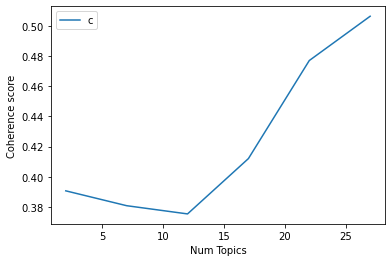

In [134]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_sg_2019_score1N2N3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [135]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_sg_2019_score1N2N3):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 27

index: 0 | Num Topics = 2  has Coherence Value of 0.3907
index: 1 | Num Topics = 7  has Coherence Value of 0.3809
index: 2 | Num Topics = 12  has Coherence Value of 0.3755
index: 3 | Num Topics = 17  has Coherence Value of 0.4121
index: 4 | Num Topics = 22  has Coherence Value of 0.477
index: 5 | Num Topics = 27  has Coherence Value of 0.5064


In [193]:
# Select optimal number of topics
optimal_model_sg_2019_score1N2N3 = model_list_sg_2019_score1N2N3[4]

In [194]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_sg_2019_score1N2N3 = pyLDAvis.gensim_models.prepare(optimal_model_sg_2019_score1N2N3, corpus_sg_2019_score1N2N3, id2word_sg_2019_score1N2N3)

In [195]:
print("pyLDAVis for SG topics for score=1,2,3 in 2019:")
vis_sg_2019_score1N2N3

pyLDAVis for SG topics for score=1,2,3 in 2019:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.165912  0.052162       1        1  16.862946
17    -0.131880 -0.057621       2        1   8.189061
9     -0.133740  0.080594       3        1   7.929000
2     -0.009012 -0.004943       4        1   7.379747
3     -0.109038 -0.147734       5        1   7.349246
0     -0.025698  0.127073       6        1   7.072282
12    -0.025433 -0.185647       7        1   6.168360
18    -0.091227  0.125399       8        1   5.200311
14    -0.069153 -0.044616       9        1   4.392193
4      0.105661 -0.024601      10        1   3.648632
15     0.132163  0.016500      11        1   3.432032
21    -0.038392  0.018398      12        1   3.230749
16    -0.052722 -0.038346      13        1   3.068441
1      0.088840  0.044769      14        1   2.730677
11     0.043402  0.006309      15        1   2.432521
20     0.121479 -0.059113      16        1   2.390420
10     0.104360  0.011371      17        1   2.012952
7     -0.008149  0.039779      18        1   1.892221
13     0.079334  0.034909      19        1   1.481867
19     0.069546 -0.009601      20        1   1.421682
5      0.083035  0.022997      21        1   1.153626
6      0.032535 -0.008038      22        1   0.561035, topic_info=        Term       Freq      Total Category  logprob  loglift
34        ad  24.000000  24.000000  Default  30.0000  30.0000
12     video  58.000000  58.000000  Default  29.0000  29.0000
13     watch  29.000000  29.000000  Default  28.0000  28.0000
48      play  14.000000  14.000000  Default  27.0000  27.0000
60      work   7.000000   7.000000  Default  26.0000  26.0000
..       ...        ...        ...      ...      ...      ...
221  survive   0.011688   1.430587  Topic22  -6.3561   0.3759
222  twitter   0.011688   1.430587  Topic22  -6.3561   0.3759
223   wonder   0.011688   1.430587  Topic22  -6.3561   0.3759
211  company   0.011688   1.430587  Topic22  -6.3561   0.3759
212     hate   0.011688   5.144234  Topic22  -6.3561  -0.9039

[974 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
434       8  0.741214    absolutely
420       1  0.656485  accidentally
96       13  0.525295        actual
197       1  0.344930      actually
197       4  0.344930      actually
...     ...       ...           ...
206       8  0.283432           yet
206       9  0.283432           yet
206      16  0.283432           yet
383      10  0.763551       youtube
327       7  0.710750      youtuber

[808 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 18, 10, 3, 4, 1, 13, 19, 15, 5, 16, 22, 17, 2, 12, 21, 11, 8, 14, 20, 6, 7])

## By-rating of 2020 (Rating=1,2,3)

In [139]:
# By-rating Topic Modelling - rating = 1,2,3 in 2020
# Convert to list - move to each section
review_sg_2020_score1N2N3 = youtube_ios_sg_review_YearMonth_2020_score1N2N3.review.values.tolist()
review_words_sg_2020_score1N2N3 = list(sent_to_words(review_sg_2020_score1N2N3))
print(review_words_sg_2020_score1N2N3[:1])

[['too', 'much', 'advertisements', 'while', 'trying', 'to', 'relaxing', 'listening', 'songs']]


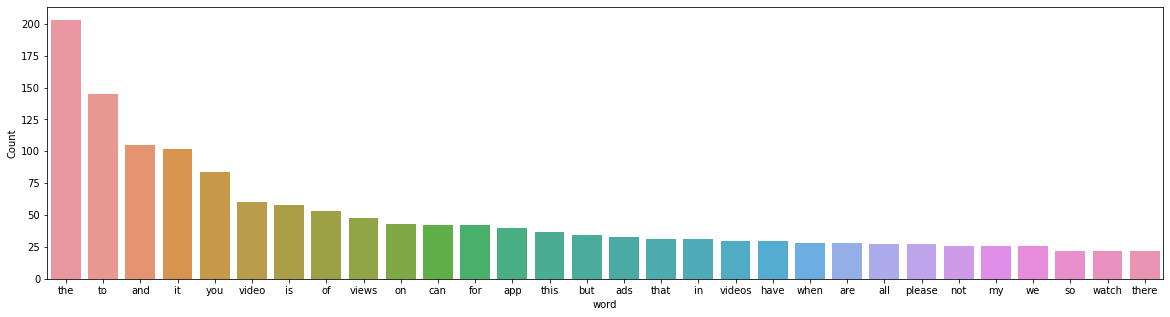

In [140]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_sg_2020_score1N2N3))

In [141]:
# Clean text
review_words_sg_ready_2020_score1N2N3 = process_words(review_words_sg_2020_score1N2N3)  # processed Text Data! - move to each section

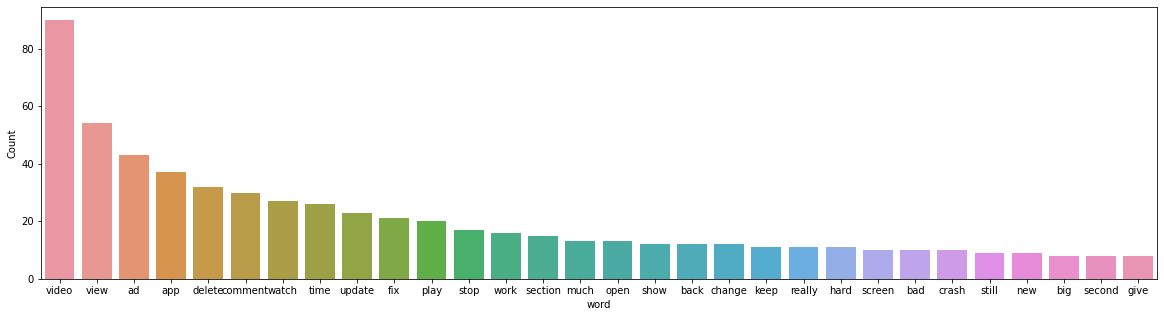

In [142]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_words_sg_ready_2020_score1N2N3))


In [143]:
# Create Dictionary
id2word_sg_2020_score1N2N3 = corpora.Dictionary(review_words_sg_ready_2020_score1N2N3)

2021-10-17 00:00:56,683 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-17 00:00:56,700 [INFO] gensim.corpora.dictionary - built Dictionary(655 unique tokens: ['advertisement', 'listen', 'much', 'relax', 'song']...) from 138 documents (total 1728 corpus positions)
2021-10-17 00:00:56,701 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(655 unique tokens: ['advertisement', 'listen', 'much', 'relax', 'song']...) from 138 documents (total 1728 corpus positions)", 'datetime': '2021-10-17T00:00:56.701348', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [144]:
# Create Corpus: Term Document Frequency
corpus_sg_2020_score1N2N3 = [id2word_sg_2020_score1N2N3.doc2bow(text) for text in review_words_sg_ready_2020_score1N2N3]

In [145]:
# Training LDA model
model_list_sg_2020_score1N2N3, coherence_values_sg_2020_score1N2N3 = compute_coherence_values(dictionary=id2word_sg_2020_score1N2N3, corpus=corpus_sg_2020_score1N2N3, 
                                                              texts=review_words_sg_ready_2020_score1N2N3, limit=30, start=2, step=5)


2021-10-17 00:00:56,733 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-17 00:00:56,736 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-17 00:00:56,739 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-17 00:00:56,741 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 138 documents, updating model once every 138 documents, evaluating perplexity every 138 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-17 00:00:57,244 [INFO] gensim.models.ldamodel - -7.162 per-word bound, 143.2 perplexity estimate based on a held-out corpus of 138 documents with 1728 words
2021-10-17 00:00:57,245 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #138/138
2021-10-17 00:00:57,668 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.037*"view" + 0.025*"video" + 0.017*"delete" + 0.017*"comment" + 0.014*"ad" + 0.011*"time" + 0.009*"har

2021-10-17 00:01:01,336 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.055*"video" + 0.029*"ad" + 0.024*"app" + 0.019*"watch" + 0.015*"time" + 0.014*"update" + 0.013*"play" + 0.013*"fix" + 0.009*"open" + 0.009*"comment"
2021-10-17 00:01:01,342 [INFO] gensim.models.ldamodel - topic diff=0.012072, rho=0.301511
2021-10-17 00:01:01,592 [INFO] gensim.models.ldamodel - -6.163 per-word bound, 71.7 perplexity estimate based on a held-out corpus of 138 documents with 1728 words
2021-10-17 00:01:01,604 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #138/138
2021-10-17 00:01:01,713 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.056*"view" + 0.033*"delete" + 0.018*"comment" + 0.015*"work" + 0.013*"video" + 0.012*"hard" + 0.011*"change" + 0.010*"stop" + 0.008*"section" + 0.008*"really"
2021-10-17 00:01:01,715 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.055*"video" + 0.029*"ad" + 0.024*"app" + 0.019*"watch" + 0.015*"time" + 0.014*"update" + 0.013*"play" + 0.013*"fix

2021-10-17 00:01:04,831 [INFO] gensim.models.ldamodel - topic diff=0.002792, rho=0.218218
2021-10-17 00:01:05,039 [INFO] gensim.models.ldamodel - -6.157 per-word bound, 71.4 perplexity estimate based on a held-out corpus of 138 documents with 1728 words
2021-10-17 00:01:05,040 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #138/138
2021-10-17 00:01:05,188 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.056*"view" + 0.033*"delete" + 0.018*"comment" + 0.016*"work" + 0.013*"video" + 0.012*"hard" + 0.012*"change" + 0.010*"stop" + 0.008*"section" + 0.008*"really"
2021-10-17 00:01:05,193 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.055*"video" + 0.030*"ad" + 0.024*"app" + 0.018*"watch" + 0.015*"time" + 0.014*"update" + 0.013*"fix" + 0.013*"play" + 0.010*"open" + 0.009*"comment"
2021-10-17 00:01:05,196 [INFO] gensim.models.ldamodel - topic diff=0.002450, rho=0.213201
2021-10-17 00:01:05,384 [INFO] gensim.models.ldamodel - -6.157 per-word bound, 71.4 perplexity estim

2021-10-17 00:01:08,236 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #138/138
2021-10-17 00:01:08,406 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.056*"view" + 0.033*"delete" + 0.018*"comment" + 0.016*"work" + 0.013*"video" + 0.012*"hard" + 0.012*"change" + 0.010*"stop" + 0.008*"section" + 0.008*"give"
2021-10-17 00:01:08,408 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.055*"video" + 0.030*"ad" + 0.025*"app" + 0.018*"watch" + 0.015*"time" + 0.014*"update" + 0.013*"fix" + 0.013*"play" + 0.010*"open" + 0.009*"comment"
2021-10-17 00:01:08,411 [INFO] gensim.models.ldamodel - topic diff=0.000922, rho=0.176777
2021-10-17 00:01:08,603 [INFO] gensim.models.ldamodel - -6.157 per-word bound, 71.3 perplexity estimate based on a held-out corpus of 138 documents with 1728 words
2021-10-17 00:01:08,619 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #138/138
2021-10-17 00:01:08,754 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.056*"view" + 0.033*"

2021-10-17 00:01:11,879 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.055*"video" + 0.030*"ad" + 0.025*"app" + 0.018*"watch" + 0.015*"time" + 0.014*"update" + 0.013*"fix" + 0.013*"play" + 0.010*"open" + 0.009*"comment"
2021-10-17 00:01:11,880 [INFO] gensim.models.ldamodel - topic diff=0.000539, rho=0.154303
2021-10-17 00:01:12,135 [INFO] gensim.models.ldamodel - -6.156 per-word bound, 71.3 perplexity estimate based on a held-out corpus of 138 documents with 1728 words
2021-10-17 00:01:12,136 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #138/138
2021-10-17 00:01:12,278 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.056*"view" + 0.033*"delete" + 0.018*"comment" + 0.016*"work" + 0.013*"video" + 0.012*"change" + 0.012*"hard" + 0.010*"stop" + 0.008*"section" + 0.008*"give"
2021-10-17 00:01:12,280 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.055*"video" + 0.030*"ad" + 0.025*"app" + 0.018*"watch" + 0.015*"time" + 0.014*"update" + 0.013*"fix" + 0.013*"play" 

2021-10-17 00:01:19,800 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 125 virtual documents
2021-10-17 00:01:20,129 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-17 00:01:20,130 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
2021-10-17 00:01:20,132 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-17 00:01:20,134 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 7 topics, 50 passes over the supplied corpus of 138 documents, updating model once every 138 documents, evaluating perplexity every 138 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-17 00:01:20,517 [INFO] gensim.models.ldamodel - -9.593 per-word bound, 772.4 perplexity estimate based on a held-out corpus of 138 documents with 1728 words
2021-10-17 00:01:20,518 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #138/138
2021-10-17 00:01

2021-10-17 00:01:22,379 [INFO] gensim.models.ldamodel - -6.446 per-word bound, 87.2 perplexity estimate based on a held-out corpus of 138 documents with 1728 words
2021-10-17 00:01:22,380 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #138/138
2021-10-17 00:01:22,447 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.084*"view" + 0.057*"delete" + 0.022*"work" + 0.019*"video" + 0.019*"stop" + 0.018*"hard" + 0.009*"time" + 0.009*"give" + 0.009*"fake" + 0.009*"way"
2021-10-17 00:01:22,449 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.086*"video" + 0.032*"app" + 0.021*"watch" + 0.020*"screen" + 0.017*"play" + 0.012*"big" + 0.012*"fix" + 0.012*"update" + 0.011*"open" + 0.011*"keep"
2021-10-17 00:01:22,451 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.040*"video" + 0.026*"comment" + 0.024*"app" + 0.022*"time" + 0.020*"watch" + 0.019*"ad" + 0.019*"fix" + 0.017*"update" + 0.017*"view" + 0.015*"section"
2021-10-17 00:01:22,453 [INFO] gensim.models.ldamodel - topic #6

2021-10-17 00:01:23,902 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.040*"video" + 0.026*"comment" + 0.024*"app" + 0.022*"time" + 0.020*"watch" + 0.020*"fix" + 0.019*"ad" + 0.017*"update" + 0.017*"view" + 0.015*"section"
2021-10-17 00:01:23,903 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.046*"view" + 0.027*"video" + 0.023*"delete" + 0.018*"work" + 0.018*"hard" + 0.014*"advertisement" + 0.014*"find" + 0.014*"default" + 0.014*"watch" + 0.009*"really"
2021-10-17 00:01:23,904 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.092*"ad" + 0.023*"much" + 0.022*"time" + 0.017*"video" + 0.015*"dislike" + 0.015*"unskippable" + 0.015*"stop" + 0.015*"stawp" + 0.014*"skip" + 0.014*"really"
2021-10-17 00:01:23,905 [INFO] gensim.models.ldamodel - topic diff=0.008970, rho=0.288675
2021-10-17 00:01:24,046 [INFO] gensim.models.ldamodel - -6.425 per-word bound, 86.0 perplexity estimate based on a held-out corpus of 138 documents with 1728 words
2021-10-17 00:01:24,048 [INFO] gensim.models

2021-10-17 00:01:25,527 [INFO] gensim.models.ldamodel - topic diff=0.004209, rho=0.242536
2021-10-17 00:01:25,757 [INFO] gensim.models.ldamodel - -6.422 per-word bound, 85.7 perplexity estimate based on a held-out corpus of 138 documents with 1728 words
2021-10-17 00:01:25,758 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #138/138
2021-10-17 00:01:25,887 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.096*"view" + 0.067*"delete" + 0.024*"work" + 0.020*"hard" + 0.020*"stop" + 0.019*"video" + 0.011*"give" + 0.009*"time" + 0.009*"fake" + 0.009*"way"
2021-10-17 00:01:25,889 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.092*"ad" + 0.024*"much" + 0.022*"time" + 0.017*"video" + 0.015*"dislike" + 0.015*"unskippable" + 0.015*"stop" + 0.015*"stawp" + 0.015*"skip" + 0.015*"really"
2021-10-17 00:01:25,893 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.040*"video" + 0.026*"comment" + 0.024*"app" + 0.022*"time" + 0.020*"watch" + 0.020*"fix" + 0.019*"ad" + 0.017*"updat

2021-10-17 00:01:27,477 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.022*"account" + 0.017*"app" + 0.016*"wrong" + 0.016*"problem" + 0.011*"minute" + 0.011*"reason" + 0.011*"playlist" + 0.011*"much" + 0.011*"sure" + 0.011*"bot"
2021-10-17 00:01:27,479 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.042*"comment" + 0.033*"video" + 0.029*"update" + 0.023*"section" + 0.013*"thumbnail" + 0.011*"ad" + 0.010*"show" + 0.010*"user" + 0.010*"press" + 0.010*"reply"
2021-10-17 00:01:27,482 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.102*"view" + 0.072*"delete" + 0.025*"work" + 0.021*"hard" + 0.020*"stop" + 0.018*"video" + 0.011*"give" + 0.009*"way" + 0.009*"time" + 0.009*"change"
2021-10-17 00:01:27,486 [INFO] gensim.models.ldamodel - topic diff=0.002885, rho=0.208514
2021-10-17 00:01:27,635 [INFO] gensim.models.ldamodel - -6.420 per-word bound, 85.6 perplexity estimate based on a held-out corpus of 138 documents with 1728 words
2021-10-17 00:01:27,637 [INFO] gensim.models.ldam

2021-10-17 00:01:29,031 [INFO] gensim.models.ldamodel - topic diff=0.002051, rho=0.188982
2021-10-17 00:01:29,272 [INFO] gensim.models.ldamodel - -6.418 per-word bound, 85.5 perplexity estimate based on a held-out corpus of 138 documents with 1728 words
2021-10-17 00:01:29,275 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #138/138
2021-10-17 00:01:29,381 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.022*"account" + 0.017*"app" + 0.017*"wrong" + 0.017*"problem" + 0.011*"minute" + 0.011*"reason" + 0.011*"playlist" + 0.011*"sure" + 0.011*"much" + 0.011*"bot"
2021-10-17 00:01:29,383 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.090*"video" + 0.033*"app" + 0.022*"watch" + 0.020*"screen" + 0.018*"play" + 0.013*"big" + 0.013*"fix" + 0.012*"update" + 0.011*"keep" + 0.011*"open"
2021-10-17 00:01:29,384 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.042*"comment" + 0.033*"video" + 0.029*"update" + 0.023*"section" + 0.013*"thumbnail" + 0.011*"ad" + 0.010*"show" +

2021-10-17 00:01:31,165 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.022*"account" + 0.017*"app" + 0.017*"wrong" + 0.017*"problem" + 0.011*"minute" + 0.011*"reason" + 0.011*"playlist" + 0.011*"sure" + 0.011*"much" + 0.011*"bot"
2021-10-17 00:01:31,167 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.090*"video" + 0.033*"app" + 0.022*"watch" + 0.020*"screen" + 0.018*"play" + 0.013*"big" + 0.013*"fix" + 0.012*"update" + 0.011*"keep" + 0.011*"open"
2021-10-17 00:01:31,169 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.040*"video" + 0.026*"comment" + 0.024*"app" + 0.022*"time" + 0.021*"watch" + 0.021*"fix" + 0.020*"ad" + 0.017*"update" + 0.015*"section" + 0.015*"play"
2021-10-17 00:01:31,171 [INFO] gensim.models.ldamodel - topic diff=0.001315, rho=0.171499
2021-10-17 00:01:31,478 [INFO] gensim.models.ldamodel - -6.415 per-word bound, 85.3 perplexity estimate based on a held-out corpus of 138 documents with 1728 words
2021-10-17 00:01:31,484 [INFO] gensim.models.ldamodel - PR

2021-10-17 00:01:33,192 [INFO] gensim.models.ldamodel - topic diff=0.000972, rho=0.160128
2021-10-17 00:01:33,346 [INFO] gensim.models.ldamodel - -6.414 per-word bound, 85.3 perplexity estimate based on a held-out corpus of 138 documents with 1728 words
2021-10-17 00:01:33,348 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #138/138
2021-10-17 00:01:33,699 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.029*"video" + 0.024*"view" + 0.015*"watch" + 0.015*"advertisement" + 0.015*"default" + 0.015*"find" + 0.013*"hard" + 0.013*"work" + 0.010*"load" + 0.010*"let"
2021-10-17 00:01:33,705 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.118*"view" + 0.079*"delete" + 0.026*"work" + 0.022*"hard" + 0.019*"stop" + 0.018*"video" + 0.013*"way" + 0.011*"give" + 0.011*"change" + 0.010*"support"
2021-10-17 00:01:33,708 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.092*"ad" + 0.024*"much" + 0.022*"time" + 0.017*"video" + 0.015*"stop" + 0.015*"dislike" + 0.015*"unskippable" 

2021-10-17 00:01:35,944 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.092*"ad" + 0.024*"much" + 0.022*"time" + 0.017*"video" + 0.015*"skip" + 0.015*"stop" + 0.015*"dislike" + 0.015*"really" + 0.015*"unskippable" + 0.015*"stawp"
2021-10-17 00:01:35,949 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.029*"video" + 0.021*"view" + 0.015*"watch" + 0.015*"advertisement" + 0.015*"default" + 0.015*"find" + 0.012*"hard" + 0.011*"work" + 0.010*"load" + 0.010*"let"
2021-10-17 00:01:35,957 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.040*"video" + 0.026*"comment" + 0.024*"app" + 0.022*"time" + 0.021*"fix" + 0.021*"watch" + 0.020*"ad" + 0.017*"update" + 0.015*"section" + 0.015*"play"
2021-10-17 00:01:35,959 [INFO] gensim.models.ldamodel - topic diff=0.001131, rho=0.149071
2021-10-17 00:01:36,141 [INFO] gensim.models.ldamodel - -6.413 per-word bound, 85.2 perplexity estimate based on a held-out corpus of 138 documents with 1728 words
2021-10-17 00:01:36,142 [INFO] gensim.models.ldam

2021-10-17 00:01:37,649 [INFO] gensim.models.ldamodel - topic diff=0.000980, rho=0.141421
2021-10-17 00:01:37,779 [INFO] gensim.models.ldamodel - -6.412 per-word bound, 85.1 perplexity estimate based on a held-out corpus of 138 documents with 1728 words
2021-10-17 00:01:37,783 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #138/138
2021-10-17 00:01:37,867 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.042*"comment" + 0.033*"video" + 0.029*"update" + 0.023*"section" + 0.013*"thumbnail" + 0.011*"ad" + 0.010*"show" + 0.010*"press" + 0.010*"user" + 0.010*"reply"
2021-10-17 00:01:37,870 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.093*"ad" + 0.024*"much" + 0.021*"time" + 0.017*"video" + 0.015*"skip" + 0.015*"stop" + 0.015*"dislike" + 0.015*"really" + 0.015*"unskippable" + 0.015*"stawp"
2021-10-17 00:01:37,872 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.090*"video" + 0.033*"app" + 0.022*"watch" + 0.020*"screen" + 0.018*"play" + 0.013*"big" + 0.013*"fix" + 

2021-10-17 00:01:46,294 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.082*"view" + 0.058*"delete" + 0.042*"video" + 0.026*"app" + 0.020*"watch" + 0.018*"work" + 0.014*"stop" + 0.011*"ad" + 0.011*"people" + 0.011*"hard"
2021-10-17 00:01:46,298 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.044*"video" + 0.027*"ad" + 0.018*"change" + 0.017*"unable" + 0.010*"back" + 0.010*"well" + 0.009*"tolerable" + 0.009*"money" + 0.009*"asap" + 0.009*"resolution"
2021-10-17 00:01:46,300 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.031*"video" + 0.027*"view" + 0.026*"work" + 0.020*"hard" + 0.019*"default" + 0.019*"watch" + 0.018*"cause" + 0.013*"frustrating" + 0.013*"way" + 0.013*"caption"
2021-10-17 00:01:46,302 [INFO] gensim.models.ldamodel - topic diff=0.068490, rho=0.447214
2021-10-17 00:01:46,540 [INFO] gensim.models.ldamodel - -6.597 per-word bound, 96.8 perplexity estimate based on a held-out corpus of 138 documents with 1728 words
2021-10-17 00:01:46,542 [INFO] gensim.models.l

2021-10-17 00:01:48,648 [INFO] gensim.models.ldamodel - topic diff=0.011084, rho=0.316228
2021-10-17 00:01:48,968 [INFO] gensim.models.ldamodel - -6.580 per-word bound, 95.7 perplexity estimate based on a held-out corpus of 138 documents with 1728 words
2021-10-17 00:01:48,982 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #138/138
2021-10-17 00:01:49,189 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.069*"video" + 0.035*"app" + 0.029*"play" + 0.023*"update" + 0.023*"issue" + 0.023*"back" + 0.023*"crash" + 0.018*"ad" + 0.018*"watch" + 0.018*"screen"
2021-10-17 00:01:49,191 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.035*"update" + 0.021*"comment" + 0.014*"drama" + 0.014*"app" + 0.014*"continue" + 0.014*"watch" + 0.014*"much" + 0.014*"video" + 0.014*"section" + 0.014*"thumbnail"
2021-10-17 00:01:49,194 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.057*"comment" + 0.048*"video" + 0.029*"update" + 0.029*"section" + 0.024*"play" + 0.019*"new" + 0.016*"chan

2021-10-17 00:01:51,044 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.057*"comment" + 0.048*"video" + 0.029*"update" + 0.029*"section" + 0.024*"play" + 0.019*"new" + 0.016*"change" + 0.015*"user" + 0.015*"second" + 0.015*"reply"
2021-10-17 00:01:51,045 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.069*"video" + 0.035*"app" + 0.029*"play" + 0.023*"update" + 0.023*"issue" + 0.023*"back" + 0.023*"crash" + 0.018*"ad" + 0.018*"watch" + 0.018*"screen"
2021-10-17 00:01:51,046 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.048*"view" + 0.022*"delete" + 0.022*"stop" + 0.022*"time" + 0.021*"change" + 0.016*"ad" + 0.016*"hard" + 0.016*"work" + 0.016*"video" + 0.011*"much"
2021-10-17 00:01:51,048 [INFO] gensim.models.ldamodel - topic diff=0.001529, rho=0.250000
2021-10-17 00:01:51,266 [INFO] gensim.models.ldamodel - -6.579 per-word bound, 95.6 perplexity estimate based on a held-out corpus of 138 documents with 1728 words
2021-10-17 00:01:51,268 [INFO] gensim.models.ldamodel - PRO

2021-10-17 00:01:52,658 [INFO] gensim.models.ldamodel - topic diff=0.000384, rho=0.218218
2021-10-17 00:01:52,859 [INFO] gensim.models.ldamodel - -6.579 per-word bound, 95.6 perplexity estimate based on a held-out corpus of 138 documents with 1728 words
2021-10-17 00:01:52,860 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #138/138
2021-10-17 00:01:53,029 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.046*"video" + 0.034*"app" + 0.031*"ad" + 0.030*"comment" + 0.024*"time" + 0.021*"section" + 0.017*"play" + 0.017*"update" + 0.014*"watch" + 0.014*"annoying"
2021-10-17 00:01:53,039 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.046*"video" + 0.040*"ad" + 0.023*"stawp" + 0.017*"time" + 0.017*"people" + 0.017*"end" + 0.017*"stop" + 0.012*"unable" + 0.012*"view" + 0.012*"still"
2021-10-17 00:01:53,043 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.035*"update" + 0.021*"comment" + 0.014*"drama" + 0.014*"app" + 0.014*"continue" + 0.014*"watch" + 0.014*"much" + 0.

2021-10-17 00:01:54,388 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.053*"video" + 0.018*"app" + 0.018*"fast" + 0.018*"drain" + 0.018*"battery" + 0.012*"advertisement" + 0.012*"bad" + 0.012*"watch" + 0.012*"iphone" + 0.012*"bug"
2021-10-17 00:01:54,392 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.046*"video" + 0.034*"app" + 0.031*"ad" + 0.030*"comment" + 0.024*"time" + 0.021*"section" + 0.017*"play" + 0.017*"update" + 0.014*"watch" + 0.014*"annoying"
2021-10-17 00:01:54,394 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.086*"view" + 0.060*"delete" + 0.042*"video" + 0.025*"app" + 0.020*"watch" + 0.015*"work" + 0.014*"stop" + 0.011*"ad" + 0.011*"people" + 0.011*"hard"
2021-10-17 00:01:54,395 [INFO] gensim.models.ldamodel - topic diff=0.000089, rho=0.192450
2021-10-17 00:01:54,545 [INFO] gensim.models.ldamodel - -6.579 per-word bound, 95.6 perplexity estimate based on a held-out corpus of 138 documents with 1728 words
2021-10-17 00:01:54,547 [INFO] gensim.models.ldamod

2021-10-17 00:01:55,652 [INFO] gensim.models.ldamodel - topic diff=0.000030, rho=0.176777
2021-10-17 00:01:55,786 [INFO] gensim.models.ldamodel - -6.579 per-word bound, 95.6 perplexity estimate based on a held-out corpus of 138 documents with 1728 words
2021-10-17 00:01:55,787 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #138/138
2021-10-17 00:01:55,899 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.053*"video" + 0.018*"app" + 0.018*"fast" + 0.018*"battery" + 0.018*"drain" + 0.012*"advertisement" + 0.012*"bad" + 0.012*"iphone" + 0.012*"watch" + 0.012*"bug"
2021-10-17 00:01:55,901 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.035*"update" + 0.021*"comment" + 0.014*"drama" + 0.014*"app" + 0.014*"much" + 0.014*"continue" + 0.014*"watch" + 0.014*"section" + 0.014*"thumbnail" + 0.014*"well"
2021-10-17 00:01:55,902 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.046*"video" + 0.040*"ad" + 0.023*"stawp" + 0.017*"time" + 0.017*"end" + 0.017*"people" + 0.017*"st

2021-10-17 00:01:57,150 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.057*"comment" + 0.048*"video" + 0.029*"update" + 0.029*"section" + 0.024*"play" + 0.019*"new" + 0.016*"change" + 0.015*"user" + 0.015*"reply" + 0.015*"second"
2021-10-17 00:01:57,153 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.028*"ad" + 0.028*"playlist" + 0.022*"fix" + 0.022*"account" + 0.017*"show" + 0.017*"let" + 0.017*"time" + 0.017*"add" + 0.017*"problem" + 0.017*"video"
2021-10-17 00:01:57,155 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.033*"work" + 0.032*"video" + 0.023*"view" + 0.020*"hard" + 0.019*"watch" + 0.019*"default" + 0.019*"cause" + 0.013*"keep" + 0.013*"become" + 0.013*"money"
2021-10-17 00:01:57,156 [INFO] gensim.models.ldamodel - topic diff=0.000009, rho=0.162221
2021-10-17 00:01:57,292 [INFO] gensim.models.ldamodel - -6.579 per-word bound, 95.6 perplexity estimate based on a held-out corpus of 138 documents with 1728 words
2021-10-17 00:01:57,293 [INFO] gensim.models.ldamod

2021-10-17 00:01:58,516 [INFO] gensim.models.ldamodel - topic diff=0.000004, rho=0.152499
2021-10-17 00:01:58,655 [INFO] gensim.models.ldamodel - -6.579 per-word bound, 95.6 perplexity estimate based on a held-out corpus of 138 documents with 1728 words
2021-10-17 00:01:58,656 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #138/138
2021-10-17 00:01:58,775 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.046*"video" + 0.034*"app" + 0.031*"ad" + 0.030*"comment" + 0.024*"time" + 0.021*"section" + 0.017*"play" + 0.017*"update" + 0.014*"watch" + 0.014*"keep"
2021-10-17 00:01:58,776 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.086*"view" + 0.060*"delete" + 0.042*"video" + 0.025*"app" + 0.020*"watch" + 0.015*"work" + 0.014*"stop" + 0.011*"people" + 0.011*"ad" + 0.011*"hard"
2021-10-17 00:01:58,777 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.057*"comment" + 0.048*"video" + 0.029*"update" + 0.029*"section" + 0.024*"play" + 0.019*"new" + 0.016*"change" + 0.015*

2021-10-17 00:02:00,513 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.069*"video" + 0.035*"app" + 0.029*"play" + 0.023*"back" + 0.023*"issue" + 0.023*"update" + 0.023*"crash" + 0.018*"screen" + 0.018*"watch" + 0.018*"ad"
2021-10-17 00:02:00,515 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.046*"video" + 0.034*"app" + 0.031*"ad" + 0.030*"comment" + 0.024*"time" + 0.021*"section" + 0.017*"play" + 0.017*"update" + 0.014*"watch" + 0.014*"keep"
2021-10-17 00:02:00,519 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.044*"ad" + 0.027*"dislike" + 0.018*"show" + 0.018*"really" + 0.018*"much" + 0.018*"star" + 0.018*"terrible" + 0.017*"give" + 0.009*"vid" + 0.009*"keep"
2021-10-17 00:02:00,521 [INFO] gensim.models.ldamodel - topic diff=0.000001, rho=0.142857
2021-10-17 00:02:00,711 [INFO] gensim.models.ldamodel - -6.579 per-word bound, 95.6 perplexity estimate based on a held-out corpus of 138 documents with 1728 words
2021-10-17 00:02:00,719 [INFO] gensim.models.ldamodel - PROGRE

2021-10-17 00:02:11,671 [INFO] gensim.models.ldamodel - -6.806 per-word bound, 111.9 perplexity estimate based on a held-out corpus of 138 documents with 1728 words
2021-10-17 00:02:11,673 [INFO] gensim.models.ldamodel - PROGRESS: pass 2, at document #138/138
2021-10-17 00:02:11,734 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.055*"video" + 0.030*"bad" + 0.030*"comment" + 0.023*"update" + 0.023*"watch" + 0.016*"ad" + 0.016*"time" + 0.016*"end" + 0.015*"people" + 0.015*"screen"
2021-10-17 00:02:11,737 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.052*"video" + 0.036*"fix" + 0.030*"playlist" + 0.024*"add" + 0.018*"account" + 0.017*"screen" + 0.017*"full" + 0.012*"ad" + 0.012*"reason" + 0.012*"picture"
2021-10-17 00:02:11,739 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.046*"view" + 0.035*"delete" + 0.024*"way" + 0.024*"change" + 0.024*"video" + 0.023*"work" + 0.012*"srsly" + 0.012*"sake" + 0.012*"user" + 0.012*"limited"
2021-10-17 00:02:11,741 [INFO] gensim.models.l

2021-10-17 00:02:13,361 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.087*"view" + 0.053*"delete" + 0.020*"give" + 0.017*"stop" + 0.012*"sure" + 0.012*"people" + 0.012*"thing" + 0.012*"work" + 0.012*"hard" + 0.010*"second"
2021-10-17 00:02:13,364 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.058*"app" + 0.028*"video" + 0.027*"open" + 0.027*"comment" + 0.021*"back" + 0.021*"update" + 0.016*"time" + 0.016*"section" + 0.011*"delete" + 0.011*"still"
2021-10-17 00:02:13,370 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.037*"comment" + 0.037*"view" + 0.028*"delete" + 0.028*"dislike" + 0.028*"work" + 0.019*"section" + 0.019*"whole" + 0.019*"reply" + 0.019*"show" + 0.019*"really"
2021-10-17 00:02:13,374 [INFO] gensim.models.ldamodel - topic diff=0.020626, rho=0.333333
2021-10-17 00:02:13,539 [INFO] gensim.models.ldamodel - -6.709 per-word bound, 104.6 perplexity estimate based on a held-out corpus of 138 documents with 1728 words
2021-10-17 00:02:13,540 [INFO] gensim.models

2021-10-17 00:02:15,182 [INFO] gensim.models.ldamodel - topic diff=0.006538, rho=0.267261
2021-10-17 00:02:15,395 [INFO] gensim.models.ldamodel - -6.696 per-word bound, 103.7 perplexity estimate based on a held-out corpus of 138 documents with 1728 words
2021-10-17 00:02:15,397 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #138/138
2021-10-17 00:02:15,497 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.038*"video" + 0.026*"phone" + 0.026*"app" + 0.013*"glitch" + 0.013*"form" + 0.013*"bar" + 0.013*"disconnect" + 0.013*"jump" + 0.013*"keep" + 0.013*"tv"
2021-10-17 00:02:15,513 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.078*"video" + 0.054*"ad" + 0.040*"play" + 0.025*"view" + 0.015*"app" + 0.015*"bad" + 0.010*"issue" + 0.010*"show" + 0.010*"audience" + 0.010*"datum"
2021-10-17 00:02:15,515 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.037*"comment" + 0.037*"view" + 0.028*"delete" + 0.028*"dislike" + 0.028*"work" + 0.019*"section" + 0.019*"reply" + 0.0

2021-10-17 00:02:17,118 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.103*"view" + 0.064*"delete" + 0.021*"stop" + 0.019*"give" + 0.012*"sure" + 0.012*"people" + 0.012*"thing" + 0.012*"work" + 0.012*"hard" + 0.009*"second"
2021-10-17 00:02:17,120 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.055*"video" + 0.032*"comment" + 0.032*"bad" + 0.024*"update" + 0.024*"watch" + 0.016*"time" + 0.016*"end" + 0.016*"people" + 0.016*"screen" + 0.016*"section"
2021-10-17 00:02:17,122 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.055*"video" + 0.039*"fix" + 0.030*"playlist" + 0.024*"add" + 0.018*"account" + 0.018*"screen" + 0.018*"full" + 0.012*"reason" + 0.012*"picture" + 0.012*"update"
2021-10-17 00:02:17,126 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.030*"video" + 0.030*"cause" + 0.030*"advert" + 0.015*"view" + 0.015*"provide" + 0.015*"pleasure" + 0.015*"money" + 0.015*"spoil" + 0.015*"pop" + 0.015*"way"
2021-10-17 00:02:17,128 [INFO] gensim.models.ldamodel - topic dif

2021-10-17 00:02:18,904 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.038*"video" + 0.026*"phone" + 0.026*"app" + 0.013*"properly" + 0.013*"disconnect" + 0.013*"unable" + 0.013*"jump" + 0.013*"keep" + 0.013*"form" + 0.013*"watch"
2021-10-17 00:02:18,905 [INFO] gensim.models.ldamodel - topic diff=0.001436, rho=0.200000
2021-10-17 00:02:19,038 [INFO] gensim.models.ldamodel - -6.691 per-word bound, 103.3 perplexity estimate based on a held-out corpus of 138 documents with 1728 words
2021-10-17 00:02:19,041 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #138/138
2021-10-17 00:02:19,202 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.068*"video" + 0.049*"comment" + 0.041*"app" + 0.041*"watch" + 0.031*"update" + 0.024*"section" + 0.024*"time" + 0.024*"crash" + 0.023*"fix" + 0.014*"play"
2021-10-17 00:02:19,218 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.031*"view" + 0.030*"video" + 0.022*"update" + 0.022*"back" + 0.021*"hard" + 0.021*"work" + 0.018*"delete"

2021-10-17 00:02:21,203 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.055*"video" + 0.039*"fix" + 0.030*"playlist" + 0.024*"add" + 0.018*"account" + 0.018*"screen" + 0.018*"full" + 0.012*"reason" + 0.012*"update" + 0.012*"unable"
2021-10-17 00:02:21,205 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.059*"app" + 0.027*"open" + 0.027*"comment" + 0.026*"video" + 0.022*"back" + 0.022*"update" + 0.016*"time" + 0.016*"section" + 0.011*"delete" + 0.011*"still"
2021-10-17 00:02:21,214 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.055*"video" + 0.032*"comment" + 0.032*"bad" + 0.024*"update" + 0.024*"watch" + 0.016*"end" + 0.016*"screen" + 0.016*"section" + 0.016*"time" + 0.016*"people"
2021-10-17 00:02:21,223 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.030*"video" + 0.030*"cause" + 0.030*"advert" + 0.016*"view" + 0.016*"provide" + 0.016*"pleasure" + 0.016*"money" + 0.016*"spoil" + 0.016*"pop" + 0.016*"way"
2021-10-17 00:02:21,228 [INFO] gensim.models.ldamodel - topic 

2021-10-17 00:02:23,415 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.066*"video" + 0.022*"subscription" + 0.022*"cancel" + 0.022*"still" + 0.022*"find" + 0.022*"watch" + 0.022*"advertisement" + 0.022*"ad" + 0.022*"whole" + 0.022*"thumbnail"
2021-10-17 00:02:23,417 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.124*"view" + 0.078*"delete" + 0.024*"stop" + 0.021*"give" + 0.019*"hard" + 0.018*"work" + 0.013*"really" + 0.011*"people" + 0.011*"sure" + 0.011*"thing"
2021-10-17 00:02:23,418 [INFO] gensim.models.ldamodel - topic diff=0.001964, rho=0.166667
2021-10-17 00:02:23,666 [INFO] gensim.models.ldamodel - -6.681 per-word bound, 102.6 perplexity estimate based on a held-out corpus of 138 documents with 1728 words
2021-10-17 00:02:23,668 [INFO] gensim.models.ldamodel - PROGRESS: pass 35, at document #138/138
2021-10-17 00:02:23,888 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.032*"video" + 0.024*"update" + 0.024*"back" + 0.016*"play" + 0.016*"thing" + 0.016*"due" + 0.01

2021-10-17 00:02:25,663 [INFO] gensim.models.ldamodel - -6.676 per-word bound, 102.2 perplexity estimate based on a held-out corpus of 138 documents with 1728 words
2021-10-17 00:02:25,666 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #138/138
2021-10-17 00:02:25,809 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.038*"video" + 0.026*"phone" + 0.026*"app" + 0.013*"form" + 0.013*"disconnect" + 0.013*"unable" + 0.013*"jump" + 0.013*"bar" + 0.013*"red" + 0.013*"watch"
2021-10-17 00:02:25,811 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.047*"view" + 0.035*"delete" + 0.035*"change" + 0.024*"way" + 0.024*"video" + 0.024*"work" + 0.012*"recent" + 0.012*"find" + 0.012*"srsly" + 0.012*"system"
2021-10-17 00:02:25,813 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.040*"ad" + 0.033*"video" + 0.033*"stop" + 0.027*"stawp" + 0.020*"app" + 0.020*"time" + 0.014*"open" + 0.014*"watch" + 0.014*"keep" + 0.014*"end"
2021-10-17 00:02:25,814 [INFO] gensim.models.ldamodel 

2021-10-17 00:02:27,404 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.030*"cause" + 0.030*"advert" + 0.030*"video" + 0.016*"view" + 0.016*"provide" + 0.016*"pleasure" + 0.016*"money" + 0.016*"spoil" + 0.016*"pop" + 0.016*"way"
2021-10-17 00:02:27,408 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.080*"video" + 0.056*"ad" + 0.041*"play" + 0.017*"view" + 0.015*"app" + 0.015*"bad" + 0.010*"issue" + 0.010*"show" + 0.010*"press" + 0.010*"purpose"
2021-10-17 00:02:27,411 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.068*"video" + 0.049*"comment" + 0.041*"app" + 0.041*"watch" + 0.031*"update" + 0.024*"section" + 0.024*"time" + 0.024*"crash" + 0.023*"fix" + 0.014*"play"
2021-10-17 00:02:27,412 [INFO] gensim.models.ldamodel - topic diff=0.001401, rho=0.145865
2021-10-17 00:02:27,660 [INFO] gensim.models.ldamodel - -6.669 per-word bound, 101.8 perplexity estimate based on a held-out corpus of 138 documents with 1728 words
2021-10-17 00:02:27,663 [INFO] gensim.models.ldamodel - 

2021-10-17 00:02:39,378 [INFO] gensim.models.ldamodel - -21.792 per-word bound, 3631965.3 perplexity estimate based on a held-out corpus of 138 documents with 1728 words
2021-10-17 00:02:39,391 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #138/138
2021-10-17 00:02:39,636 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.087*"comment" + 0.049*"section" + 0.029*"update" + 0.029*"reply" + 0.029*"change" + 0.020*"interface" + 0.020*"whole" + 0.020*"thumbnail" + 0.020*"suggest" + 0.020*"new"
2021-10-17 00:02:39,640 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.059*"video" + 0.030*"thumbnail" + 0.030*"app" + 0.015*"iphone" + 0.015*"hot" + 0.015*"available" + 0.015*"drain" + 0.015*"previous" + 0.015*"crash" + 0.015*"xs"
2021-10-17 00:02:39,643 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.055*"video" + 0.036*"app" + 0.028*"watch" + 0.025*"ad" + 0.020*"bad" + 0.016*"open" + 0.013*"stop" + 0.013*"time" + 0.012*"end" + 0.012*"play"
2021-10-17 00:02:39,647 [INFO] ge

2021-10-17 00:02:41,171 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.087*"comment" + 0.049*"section" + 0.029*"update" + 0.029*"reply" + 0.029*"change" + 0.020*"interface" + 0.020*"whole" + 0.020*"thumbnail" + 0.020*"suggest" + 0.020*"video"
2021-10-17 00:02:41,172 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.059*"video" + 0.030*"thumbnail" + 0.030*"app" + 0.015*"iphone" + 0.015*"hot" + 0.015*"drain" + 0.015*"previous" + 0.015*"crash" + 0.015*"xs" + 0.015*"sometimes"
2021-10-17 00:02:41,176 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.043*"update" + 0.035*"comment" + 0.033*"video" + 0.027*"app" + 0.026*"fix" + 0.026*"unable" + 0.018*"open" + 0.018*"section" + 0.018*"thumbnail" + 0.018*"crash"
2021-10-17 00:02:41,178 [INFO] gensim.models.ldamodel - topic diff=0.043110, rho=0.377964
2021-10-17 00:02:41,267 [INFO] gensim.models.ldamodel - -6.777 per-word bound, 109.7 perplexity estimate based on a held-out corpus of 138 documents with 1728 words
2021-10-17 00:02:41,27

2021-10-17 00:02:42,692 [INFO] gensim.models.ldamodel - topic diff=0.012662, rho=0.288675
2021-10-17 00:02:42,809 [INFO] gensim.models.ldamodel - -6.747 per-word bound, 107.4 perplexity estimate based on a held-out corpus of 138 documents with 1728 words
2021-10-17 00:02:42,810 [INFO] gensim.models.ldamodel - PROGRESS: pass 11, at document #138/138
2021-10-17 00:02:42,952 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.050*"app" + 0.049*"open" + 0.026*"sake" + 0.026*"iphone" + 0.026*"user" + 0.026*"god" + 0.026*"let" + 0.026*"big" + 0.020*"vid" + 0.002*"fix"
2021-10-17 00:02:42,957 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.092*"video" + 0.073*"ad" + 0.038*"play" + 0.028*"fix" + 0.024*"back" + 0.019*"watch" + 0.019*"press" + 0.015*"able" + 0.015*"much" + 0.014*"issue"
2021-10-17 00:02:42,962 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.078*"video" + 0.034*"ad" + 0.034*"app" + 0.023*"stop" + 0.012*"ever" + 0.012*"bar" + 0.012*"stick" + 0.012*"redoublon" + 0.012*"pr

2021-10-17 00:02:44,432 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.068*"app" + 0.049*"video" + 0.037*"view" + 0.036*"screen" + 0.028*"still" + 0.028*"tap" + 0.019*"full" + 0.019*"delete" + 0.019*"update" + 0.019*"open"
2021-10-17 00:02:44,436 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.030*"drama" + 0.030*"minute" + 0.015*"conversation" + 0.015*"upgrade" + 0.015*"wrong" + 0.015*"advert" + 0.015*"intentionally" + 0.015*"watch" + 0.015*"subtitle" + 0.015*"reading"
2021-10-17 00:02:44,438 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.033*"app" + 0.017*"view" + 0.017*"minute" + 0.017*"crash" + 0.017*"time" + 0.017*"policy" + 0.017*"due" + 0.017*"video" + 0.015*"ad" + 0.013*"play"
2021-10-17 00:02:44,439 [INFO] gensim.models.ldamodel - topic diff=0.003807, rho=0.235702
2021-10-17 00:02:44,654 [INFO] gensim.models.ldamodel - -6.740 per-word bound, 106.9 perplexity estimate based on a held-out corpus of 138 documents with 1728 words
2021-10-17 00:02:44,659 [INFO] gensi

2021-10-17 00:02:46,041 [INFO] gensim.models.ldamodel - topic diff=0.001416, rho=0.208514
2021-10-17 00:02:46,204 [INFO] gensim.models.ldamodel - -6.739 per-word bound, 106.8 perplexity estimate based on a held-out corpus of 138 documents with 1728 words
2021-10-17 00:02:46,205 [INFO] gensim.models.ldamodel - PROGRESS: pass 22, at document #138/138
2021-10-17 00:02:46,313 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.033*"app" + 0.017*"view" + 0.017*"minute" + 0.017*"crash" + 0.017*"time" + 0.017*"policy" + 0.017*"due" + 0.017*"video" + 0.015*"ad" + 0.013*"play"
2021-10-17 00:02:46,316 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.053*"video" + 0.035*"audio" + 0.035*"play" + 0.035*"advert" + 0.035*"cause" + 0.018*"view" + 0.018*"new" + 0.018*"second" + 0.018*"first" + 0.018*"start"
2021-10-17 00:02:46,320 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.030*"drama" + 0.030*"minute" + 0.015*"conversation" + 0.015*"irritated" + 0.015*"upgrade" + 0.015*"wrong" + 0.015*"ad"

2021-10-17 00:02:47,874 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.068*"app" + 0.050*"video" + 0.037*"view" + 0.037*"screen" + 0.028*"tap" + 0.028*"still" + 0.019*"delete" + 0.019*"full" + 0.019*"update" + 0.019*"open"
2021-10-17 00:02:47,882 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.053*"video" + 0.035*"audio" + 0.035*"play" + 0.035*"advert" + 0.035*"cause" + 0.018*"view" + 0.018*"new" + 0.018*"second" + 0.018*"first" + 0.018*"start"
2021-10-17 00:02:47,888 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.061*"video" + 0.061*"comment" + 0.039*"update" + 0.038*"section" + 0.034*"view" + 0.028*"time" + 0.022*"watch" + 0.022*"annoying" + 0.022*"late" + 0.015*"play"
2021-10-17 00:02:47,889 [INFO] gensim.models.ldamodel - topic diff=0.000450, rho=0.185695
2021-10-17 00:02:48,061 [INFO] gensim.models.ldamodel - -6.739 per-word bound, 106.8 perplexity estimate based on a held-out corpus of 138 documents with 1728 words
2021-10-17 00:02:48,063 [INFO] gensim.models.ldam

2021-10-17 00:02:49,413 [INFO] gensim.models.ldamodel - topic diff=0.000181, rho=0.171499
2021-10-17 00:02:49,647 [INFO] gensim.models.ldamodel - -6.739 per-word bound, 106.8 perplexity estimate based on a held-out corpus of 138 documents with 1728 words
2021-10-17 00:02:49,648 [INFO] gensim.models.ldamodel - PROGRESS: pass 33, at document #138/138
2021-10-17 00:02:49,714 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.043*"view" + 0.022*"boy" + 0.022*"support" + 0.022*"much" + 0.022*"end" + 0.022*"snake" + 0.022*"time" + 0.022*"spend" + 0.022*"give" + 0.022*"staying"
2021-10-17 00:02:49,761 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.072*"view" + 0.052*"work" + 0.046*"delete" + 0.046*"hard" + 0.026*"really" + 0.013*"video" + 0.013*"time" + 0.013*"become" + 0.013*"star" + 0.013*"million"
2021-10-17 00:02:49,768 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.051*"app" + 0.049*"open" + 0.026*"sake" + 0.026*"iphone" + 0.026*"user" + 0.026*"god" + 0.026*"let" + 0.026*"b

2021-10-17 00:02:51,043 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.068*"app" + 0.050*"video" + 0.037*"view" + 0.037*"screen" + 0.028*"tap" + 0.028*"still" + 0.018*"delete" + 0.018*"full" + 0.018*"update" + 0.018*"open"
2021-10-17 00:02:51,044 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.053*"video" + 0.035*"audio" + 0.035*"play" + 0.035*"advert" + 0.035*"cause" + 0.018*"view" + 0.018*"new" + 0.018*"second" + 0.018*"first" + 0.018*"start"
2021-10-17 00:02:51,045 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.086*"comment" + 0.048*"section" + 0.039*"change" + 0.029*"update" + 0.029*"reply" + 0.020*"whole" + 0.020*"user" + 0.020*"thumbnail" + 0.020*"video" + 0.020*"expand"
2021-10-17 00:02:51,047 [INFO] gensim.models.ldamodel - topic diff=0.000067, rho=0.158114
2021-10-17 00:02:51,195 [INFO] gensim.models.ldamodel - -6.739 per-word bound, 106.8 perplexity estimate based on a held-out corpus of 138 documents with 1728 words
2021-10-17 00:02:51,208 [INFO] gensim.model

2021-10-17 00:02:52,649 [INFO] gensim.models.ldamodel - topic diff=0.000036, rho=0.149071
2021-10-17 00:02:52,816 [INFO] gensim.models.ldamodel - -6.739 per-word bound, 106.8 perplexity estimate based on a held-out corpus of 138 documents with 1728 words
2021-10-17 00:02:52,818 [INFO] gensim.models.ldamodel - PROGRESS: pass 44, at document #138/138
2021-10-17 00:02:52,921 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.023*"keep" + 0.023*"channel" + 0.023*"multiple" + 0.023*"message" + 0.023*"time" + 0.023*"error" + 0.023*"reinstall" + 0.023*"fetch" + 0.023*"account" + 0.023*"list"
2021-10-17 00:02:52,927 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.051*"app" + 0.049*"open" + 0.026*"iphone" + 0.026*"sake" + 0.026*"god" + 0.026*"user" + 0.026*"let" + 0.026*"big" + 0.016*"vid" + 0.001*"fix"
2021-10-17 00:02:52,929 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.092*"video" + 0.073*"ad" + 0.038*"play" + 0.029*"fix" + 0.024*"back" + 0.020*"watch" + 0.019*"press" + 0.015*"

2021-10-17 00:02:55,037 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.086*"comment" + 0.048*"section" + 0.039*"change" + 0.029*"reply" + 0.029*"update" + 0.020*"whole" + 0.020*"user" + 0.020*"thumbnail" + 0.020*"video" + 0.020*"expand"
2021-10-17 00:02:55,039 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.033*"app" + 0.017*"view" + 0.017*"minute" + 0.017*"time" + 0.017*"policy" + 0.017*"due" + 0.017*"video" + 0.017*"crash" + 0.015*"ad" + 0.013*"play"
2021-10-17 00:02:55,040 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.061*"video" + 0.061*"comment" + 0.039*"update" + 0.038*"section" + 0.034*"view" + 0.028*"time" + 0.022*"watch" + 0.022*"annoying" + 0.022*"late" + 0.016*"play"
2021-10-17 00:02:55,042 [INFO] gensim.models.ldamodel - topic diff=0.000023, rho=0.140028
2021-10-17 00:02:55,044 [INFO] gensim.utils - LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=655, num_topics=22, decay=0.5, chunksize=1000) in 16.03s', 'datetime': '2021-10-17T00:02:55.044555', 

2021-10-17 00:03:08,037 [INFO] gensim.models.ldamodel - topic diff=0.072655, rho=0.447214
2021-10-17 00:03:08,177 [INFO] gensim.models.ldamodel - -6.891 per-word bound, 118.7 perplexity estimate based on a held-out corpus of 138 documents with 1728 words
2021-10-17 00:03:08,179 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #138/138
2021-10-17 00:03:08,314 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.056*"drama" + 0.029*"watch" + 0.028*"minute" + 0.028*"sound" + 0.028*"much" + 0.028*"english" + 0.028*"conversation" + 0.028*"advert" + 0.028*"subtitle" + 0.028*"movie"
2021-10-17 00:03:08,315 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.058*"video" + 0.035*"work" + 0.035*"ad" + 0.023*"delete" + 0.023*"bad" + 0.023*"view" + 0.012*"wake" + 0.012*"bot" + 0.012*"boy" + 0.012*"guy"
2021-10-17 00:03:08,317 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.031*"drain" + 0.031*"fast" + 0.031*"quite" + 0.031*"heating" + 0.031*"bug" + 0.031*"phone" + 0.031*"battery"

2021-10-17 00:03:09,907 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.044*"video" + 0.044*"app" + 0.022*"ad" + 0.022*"change" + 0.022*"time" + 0.022*"skip" + 0.022*"unable" + 0.022*"load" + 0.022*"crash" + 0.022*"prior"
2021-10-17 00:03:09,908 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.031*"drain" + 0.031*"fast" + 0.031*"quite" + 0.031*"heating" + 0.031*"phone" + 0.031*"bug" + 0.031*"battery" + 0.031*"check" + 0.031*"interruption" + 0.001*"subtitle"
2021-10-17 00:03:09,909 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.067*"video" + 0.050*"default" + 0.034*"able" + 0.034*"ad" + 0.034*"picture" + 0.034*"option" + 0.034*"caption" + 0.034*"turn" + 0.017*"amiss" + 0.017*"non"
2021-10-17 00:03:09,910 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.054*"update" + 0.036*"app" + 0.027*"comment" + 0.027*"video" + 0.027*"open" + 0.018*"section" + 0.018*"thumbnail" + 0.018*"well" + 0.018*"layout" + 0.018*"available"
2021-10-17 00:03:09,912 [INFO] gensim.models.ldamodel

2021-10-17 00:03:11,528 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.061*"premium" + 0.045*"annoying" + 0.023*"time" + 0.023*"support" + 0.023*"subscription" + 0.023*"stop" + 0.023*"super" + 0.023*"prompt" + 0.023*"ad" + 0.023*"unusable"
2021-10-17 00:03:11,530 [INFO] gensim.models.ldamodel - topic diff=0.003487, rho=0.250000
2021-10-17 00:03:11,705 [INFO] gensim.models.ldamodel - -6.845 per-word bound, 115.0 perplexity estimate based on a held-out corpus of 138 documents with 1728 words
2021-10-17 00:03:11,707 [INFO] gensim.models.ldamodel - PROGRESS: pass 15, at document #138/138
2021-10-17 00:03:11,882 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.078*"comment" + 0.040*"update" + 0.040*"section" + 0.040*"video" + 0.037*"change" + 0.020*"minute" + 0.020*"reply" + 0.020*"whole" + 0.020*"expand" + 0.020*"user"
2021-10-17 00:03:11,893 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.050*"keep" + 0.033*"video" + 0.033*"stop" + 0.033*"section" + 0.032*"bring" + 0.019*"com

2021-10-17 00:03:13,242 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.044*"video" + 0.029*"view" + 0.029*"notification" + 0.029*"thumbnail" + 0.029*"fix" + 0.015*"new" + 0.015*"irritate" + 0.015*"read" + 0.015*"popup" + 0.015*"ocd"
2021-10-17 00:03:13,243 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.071*"ad" + 0.055*"comment" + 0.043*"section" + 0.029*"fix" + 0.029*"video" + 0.029*"bottom" + 0.015*"chunk" + 0.015*"back" + 0.015*"essence" + 0.015*"whole"
2021-10-17 00:03:13,245 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.069*"view" + 0.042*"delete" + 0.028*"give" + 0.021*"hard" + 0.021*"work" + 0.021*"really" + 0.021*"ad" + 0.021*"stop" + 0.014*"people" + 0.014*"pretty"
2021-10-17 00:03:13,250 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.038*"video" + 0.038*"app" + 0.029*"comment" + 0.029*"time" + 0.029*"watch" + 0.019*"purpose" + 0.019*"sense" + 0.019*"monie" + 0.019*"audience" + 0.019*"happen"
2021-10-17 00:03:13,253 [INFO] gensim.models.ldamodel - topic 

2021-10-17 00:03:14,867 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.030*"message" + 0.030*"channel" + 0.030*"error" + 0.030*"account" + 0.030*"reinstall" + 0.030*"list" + 0.030*"time" + 0.030*"keep" + 0.030*"multiple" + 0.030*"fetch"
2021-10-17 00:03:14,869 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.079*"video" + 0.041*"screen" + 0.031*"ad" + 0.031*"comment" + 0.021*"delete" + 0.021*"app" + 0.021*"time" + 0.021*"lock" + 0.011*"view" + 0.011*"back"
2021-10-17 00:03:14,871 [INFO] gensim.models.ldamodel - topic diff=0.000407, rho=0.192450
2021-10-17 00:03:15,176 [INFO] gensim.models.ldamodel - -6.843 per-word bound, 114.8 perplexity estimate based on a held-out corpus of 138 documents with 1728 words
2021-10-17 00:03:15,177 [INFO] gensim.models.ldamodel - PROGRESS: pass 26, at document #138/138
2021-10-17 00:03:15,313 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.067*"premium" + 0.045*"annoying" + 0.023*"time" + 0.023*"support" + 0.023*"subscription" + 0.023*"stop

2021-10-17 00:03:16,999 [INFO] gensim.models.ldamodel - -6.843 per-word bound, 114.8 perplexity estimate based on a held-out corpus of 138 documents with 1728 words
2021-10-17 00:03:17,001 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #138/138
2021-10-17 00:03:17,108 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.054*"update" + 0.036*"app" + 0.027*"comment" + 0.027*"video" + 0.027*"open" + 0.018*"section" + 0.018*"layout" + 0.018*"well" + 0.018*"thumbnail" + 0.018*"anymore"
2021-10-17 00:03:17,112 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.067*"premium" + 0.045*"annoying" + 0.023*"time" + 0.023*"ad" + 0.023*"prompt" + 0.023*"stop" + 0.023*"super" + 0.023*"subscription" + 0.023*"unusable" + 0.023*"look"
2021-10-17 00:03:17,119 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.094*"video" + 0.087*"app" + 0.051*"open" + 0.040*"watch" + 0.039*"fix" + 0.038*"big" + 0.030*"click" + 0.020*"play" + 0.020*"press" + 0.020*"look"
2021-10-17 00:03:17,129 [INFO] ge

2021-10-17 00:03:18,658 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.079*"video" + 0.041*"screen" + 0.031*"ad" + 0.031*"comment" + 0.021*"delete" + 0.021*"app" + 0.021*"time" + 0.021*"lock" + 0.011*"view" + 0.011*"back"
2021-10-17 00:03:18,661 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.062*"view" + 0.027*"watch" + 0.027*"delete" + 0.027*"still" + 0.027*"find" + 0.023*"video" + 0.018*"give" + 0.018*"star" + 0.018*"subscription" + 0.018*"cancel"
2021-10-17 00:03:18,665 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.082*"view" + 0.037*"delete" + 0.028*"thing" + 0.028*"time" + 0.018*"third" + 0.018*"mean" + 0.018*"second" + 0.018*"first" + 0.018*"example" + 0.018*"freeze"
2021-10-17 00:03:18,667 [INFO] gensim.models.ldamodel - topic diff=0.000060, rho=0.162221
2021-10-17 00:03:18,847 [INFO] gensim.models.ldamodel - -6.843 per-word bound, 114.8 perplexity estimate based on a held-out corpus of 138 documents with 1728 words
2021-10-17 00:03:18,849 [INFO] gensim.models.

2021-10-17 00:03:20,321 [INFO] gensim.models.ldamodel - topic diff=0.000026, rho=0.152499
2021-10-17 00:03:20,528 [INFO] gensim.models.ldamodel - -6.843 per-word bound, 114.8 perplexity estimate based on a held-out corpus of 138 documents with 1728 words
2021-10-17 00:03:20,529 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #138/138
2021-10-17 00:03:20,654 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.088*"ad" + 0.044*"stawp" + 0.044*"dislike" + 0.033*"stop" + 0.022*"people" + 0.022*"time" + 0.022*"alotta" + 0.022*"end" + 0.022*"much" + 0.022*"really"
2021-10-17 00:03:20,656 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.084*"video" + 0.049*"fix" + 0.035*"play" + 0.024*"update" + 0.024*"time" + 0.024*"press" + 0.024*"able" + 0.024*"vid" + 0.013*"watch" + 0.012*"app"
2021-10-17 00:03:20,658 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.114*"view" + 0.064*"video" + 0.064*"delete" + 0.038*"stop" + 0.038*"play" + 0.026*"fake" + 0.026*"back" + 0.013*"app" 

2021-10-17 00:03:22,628 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.039*"video" + 0.033*"playlist" + 0.026*"comment" + 0.026*"screen" + 0.026*"fix" + 0.022*"app" + 0.020*"account" + 0.020*"update" + 0.020*"reason" + 0.020*"section"
2021-10-17 00:03:22,633 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.093*"video" + 0.031*"ever" + 0.031*"ad" + 0.031*"app" + 0.016*"bad" + 0.016*"stop" + 0.016*"play" + 0.016*"block" + 0.016*"stick" + 0.016*"different"
2021-10-17 00:03:22,643 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.067*"video" + 0.050*"default" + 0.034*"ad" + 0.034*"able" + 0.034*"option" + 0.034*"caption" + 0.034*"turn" + 0.034*"picture" + 0.017*"play" + 0.017*"watch"
2021-10-17 00:03:22,644 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.071*"ad" + 0.055*"comment" + 0.043*"section" + 0.029*"fix" + 0.029*"video" + 0.029*"bottom" + 0.015*"chunk" + 0.015*"back" + 0.015*"essence" + 0.015*"whole"
2021-10-17 00:03:22,646 [INFO] gensim.models.ldamodel - topic dif

In [146]:
%store model_list_sg_2020_score1N2N3
%store coherence_values_sg_2020_score1N2N3

Stored 'model_list_sg_2020_score1N2N3' (list)
Stored 'coherence_values_sg_2020_score1N2N3' (list)


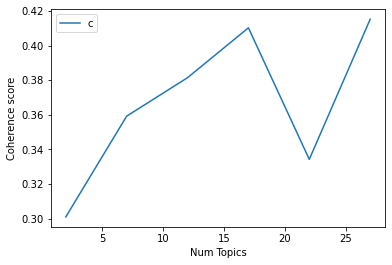

In [147]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_sg_2020_score1N2N3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [148]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_sg_2020_score1N2N3):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 27

index: 0 | Num Topics = 2  has Coherence Value of 0.301
index: 1 | Num Topics = 7  has Coherence Value of 0.3592
index: 2 | Num Topics = 12  has Coherence Value of 0.3814
index: 3 | Num Topics = 17  has Coherence Value of 0.4103
index: 4 | Num Topics = 22  has Coherence Value of 0.3343
index: 5 | Num Topics = 27  has Coherence Value of 0.4152


In [149]:
# Select optimal number of topics
optimal_model_sg_2020_score1N2N3 = model_list_sg_2020_score1N2N3[5]

In [150]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_sg_2020_score1N2N3 = pyLDAvis.gensim_models.prepare(optimal_model_sg_2020_score1N2N3, corpus_sg_2020_score1N2N3, id2word_sg_2020_score1N2N3)

In [151]:
print("pyLDAVis for SG topics for score=1,2,3 in 2020:")
vis_sg_2020_score1N2N3

pyLDAVis for SG topics for score=1,2,3 in 2020:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
20    -0.214944 -0.033588       1        1  11.210382
11     0.138816  0.013247       2        1   7.357460
23    -0.217305  0.053049       3        1   6.912963
18    -0.126955 -0.065087       4        1   5.046512
6     -0.202992 -0.018976       5        1   5.033047
17     0.117742 -0.039438       6        1   5.026769
14     0.053442 -0.081146       7        1   4.840421
2      0.030340  0.003960       8        1   4.686281
5      0.091427  0.063742       9        1   4.461781
1      0.107587 -0.145951      10        1   4.275051
16    -0.009937 -0.049138      11        1   4.237796
3     -0.019810  0.012425      12        1   3.974350
12     0.060371 -0.048787      13        1   3.781694
26     0.077451 -0.095394      14        1   3.495330
15    -0.067914 -0.072371      15        1   3.488907
21    -0.080394 -0.080350      16        1   3.189374
25     0.076253  0.063629      17        1   2.786299
9     -0.005540  0.019184      18        1   2.572928
8      0.056042 -0.070174      19        1   2.381644
13     0.056534  0.073702      20        1   2.272932
22     0.022011 -0.019972      21        1   2.140048
10     0.045680  0.137004      22        1   1.619456
7      0.037185  0.006456      23        1   1.543341
0      0.014354  0.062718      24        1   1.278423
4     -0.015950  0.098530      25        1   0.900770
19    -0.009675  0.091328      26        1   0.785839
24    -0.013818  0.121398      27        1   0.700202, topic_info=       Term       Freq      Total Category  logprob  loglift
72     view  43.000000  43.000000  Default  30.0000  30.0000
23    video  65.000000  65.000000  Default  29.0000  29.0000
65       ad  32.000000  32.000000  Default  28.0000  28.0000
68   delete  26.000000  26.000000  Default  27.0000  27.0000
14  comment  22.000000  22.000000  Default  26.0000  26.0000
..      ...        ...        ...      ...      ...      ...
16  example   0.013474   2.998070  Topic27  -6.8002  -0.4434
17   happen   0.013474   6.180275  Topic27  -6.8002  -1.1668
18     lauv   0.013474   1.420491  Topic27  -6.8002   0.3035
19   mostly   0.013474   2.904575  Topic27  -6.8002  -0.4117
20  percent   0.013474   1.420491  Topic27  -6.8002   0.3035

[1199 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
56        1  0.239172           able
56       14  0.239172           able
56       21  0.239172           able
347       6  0.687896     absolutely
206      11  0.703982         absurd
...     ...       ...            ...
167       1  0.828550       youtuber
152       5  0.684101          ytbre
654      19  0.767093           zoom
247      22  0.813150           希望改进
248      22  0.813150  总是有静音或者插播其他声音

[1164 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[21, 12, 24, 19, 7, 18, 15, 3, 6, 2, 17, 4, 13, 27, 16, 22, 26, 10, 9, 14, 23, 11, 8, 1, 5, 20, 25])

## By-rating of 2021 (Rating=1,2,3)

In [152]:
# By-rating Topic Modelling - rating = 1,2,3 in 2021
# Convert to list - move to each section
review_sg_2021_score1N2N3 = youtube_ios_sg_review_YearMonth_2021_score1N2N3.review.values.tolist()
review_words_sg_2021_score1N2N3 = list(sent_to_words(review_sg_2021_score1N2N3))
print(review_words_sg_2021_score1N2N3[:1])

[['video', 'keep', 'shuttering', 'when', 'playing', 'fps', 'video', 'hope', 'can', 'fix', 'this', 'annoying', 'issue', 'when', 'want', 'to', 'watch', 'some', 'fps', 'video']]


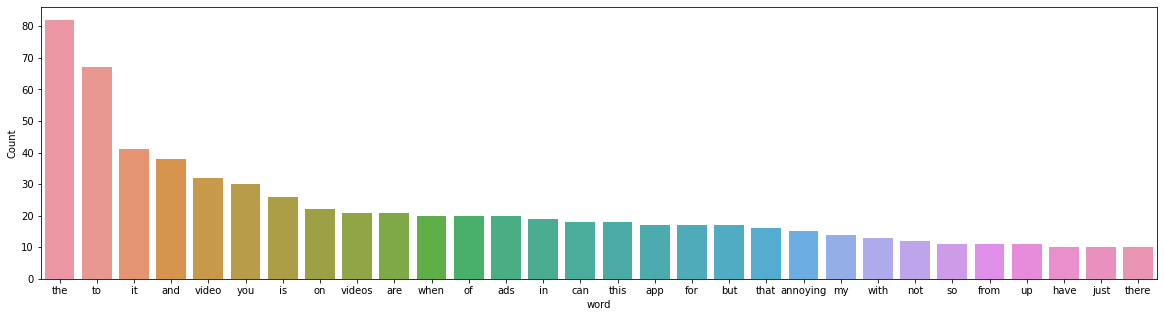

In [153]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_sg_2021_score1N2N3))

In [154]:
# Clean text
review_words_sg_ready_2021_score1N2N3 = process_words(review_words_sg_2021_score1N2N3)  # processed Text Data! - move to each section

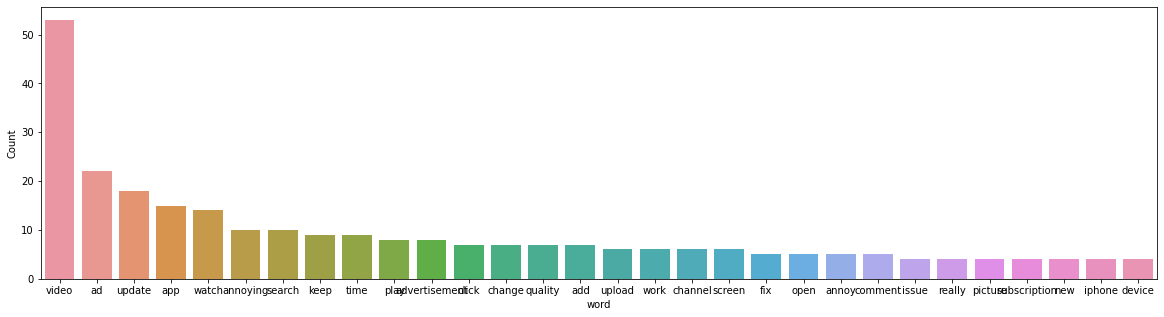

In [155]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_words_sg_ready_2021_score1N2N3))


In [156]:
# Create Dictionary
id2word_sg_2021_score1N2N3 = corpora.Dictionary(review_words_sg_ready_2021_score1N2N3)

2021-10-17 00:03:48,066 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-17 00:03:48,075 [INFO] gensim.corpora.dictionary - built Dictionary(397 unique tokens: ['annoying', 'fix', 'fps', 'hope', 'issue']...) from 67 documents (total 798 corpus positions)
2021-10-17 00:03:48,084 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(397 unique tokens: ['annoying', 'fix', 'fps', 'hope', 'issue']...) from 67 documents (total 798 corpus positions)", 'datetime': '2021-10-17T00:03:48.084587', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [157]:
# Create Corpus: Term Document Frequency
corpus_sg_2021_score1N2N3 = [id2word_sg_2021_score1N2N3.doc2bow(text) for text in review_words_sg_ready_2021_score1N2N3]

In [158]:
# Training LDA model
model_list_sg_2021_score1N2N3, coherence_values_sg_2021_score1N2N3 = compute_coherence_values(dictionary=id2word_sg_2021_score1N2N3, corpus=corpus_sg_2021_score1N2N3, 
                                                              texts=review_words_sg_ready_2021_score1N2N3, limit=30, start=2, step=5)


2021-10-17 00:03:48,137 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-17 00:03:48,138 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-17 00:03:48,141 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-17 00:03:48,144 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 67 documents, updating model once every 67 documents, evaluating perplexity every 67 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-17 00:03:48,518 [INFO] gensim.models.ldamodel - -6.739 per-word bound, 106.8 perplexity estimate based on a held-out corpus of 67 documents with 798 words
2021-10-17 00:03:48,521 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #67/67
2021-10-17 00:03:48,756 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.054*"video" + 0.016*"watch" + 0.014*"update" + 0.010*"time" + 0.010*"app" + 0.010*"quality" + 0.010*"annoying

2021-10-17 00:03:50,846 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.052*"video" + 0.019*"watch" + 0.012*"time" + 0.011*"quality" + 0.010*"add" + 0.010*"upload" + 0.010*"channel" + 0.010*"screen" + 0.009*"update" + 0.009*"annoying"
2021-10-17 00:03:50,849 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.043*"ad" + 0.036*"video" + 0.025*"update" + 0.022*"app" + 0.018*"search" + 0.014*"advertisement" + 0.013*"keep" + 0.010*"play" + 0.010*"annoying" + 0.009*"skip"
2021-10-17 00:03:50,850 [INFO] gensim.models.ldamodel - topic diff=0.005377, rho=0.301511
2021-10-17 00:03:50,953 [INFO] gensim.models.ldamodel - -5.994 per-word bound, 63.7 perplexity estimate based on a held-out corpus of 67 documents with 798 words
2021-10-17 00:03:50,956 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #67/67
2021-10-17 00:03:51,055 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.052*"video" + 0.019*"watch" + 0.012*"time" + 0.011*"quality" + 0.010*"add" + 0.010*"upload" + 0.010*"c

2021-10-17 00:03:53,098 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.052*"video" + 0.020*"watch" + 0.012*"time" + 0.011*"quality" + 0.010*"add" + 0.010*"screen" + 0.010*"upload" + 0.010*"channel" + 0.009*"work" + 0.009*"annoying"
2021-10-17 00:03:53,100 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.043*"ad" + 0.036*"video" + 0.026*"update" + 0.023*"app" + 0.018*"search" + 0.014*"advertisement" + 0.012*"keep" + 0.010*"play" + 0.010*"annoying" + 0.009*"click"
2021-10-17 00:03:53,102 [INFO] gensim.models.ldamodel - topic diff=0.001540, rho=0.218218
2021-10-17 00:03:53,235 [INFO] gensim.models.ldamodel - -5.992 per-word bound, 63.7 perplexity estimate based on a held-out corpus of 67 documents with 798 words
2021-10-17 00:03:53,237 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #67/67
2021-10-17 00:03:53,309 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.052*"video" + 0.020*"watch" + 0.012*"time" + 0.011*"quality" + 0.010*"add" + 0.010*"screen" + 0.010*"up

2021-10-17 00:03:55,800 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.053*"video" + 0.020*"watch" + 0.012*"time" + 0.011*"quality" + 0.010*"add" + 0.010*"screen" + 0.010*"upload" + 0.010*"channel" + 0.009*"work" + 0.008*"annoying"
2021-10-17 00:03:55,802 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.042*"ad" + 0.036*"video" + 0.026*"update" + 0.023*"app" + 0.018*"search" + 0.014*"advertisement" + 0.012*"keep" + 0.010*"play" + 0.010*"annoying" + 0.009*"click"
2021-10-17 00:03:55,806 [INFO] gensim.models.ldamodel - topic diff=0.000448, rho=0.179605
2021-10-17 00:03:56,034 [INFO] gensim.models.ldamodel - -5.992 per-word bound, 63.6 perplexity estimate based on a held-out corpus of 67 documents with 798 words
2021-10-17 00:03:56,035 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #67/67
2021-10-17 00:03:56,068 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.053*"video" + 0.020*"watch" + 0.012*"time" + 0.011*"quality" + 0.010*"add" + 0.010*"screen" + 0.010*"up

2021-10-17 00:03:58,600 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.053*"video" + 0.020*"watch" + 0.012*"time" + 0.011*"quality" + 0.010*"add" + 0.010*"screen" + 0.010*"upload" + 0.010*"channel" + 0.009*"work" + 0.008*"annoying"
2021-10-17 00:03:58,608 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.042*"ad" + 0.036*"video" + 0.026*"update" + 0.024*"app" + 0.018*"search" + 0.014*"advertisement" + 0.012*"keep" + 0.010*"play" + 0.010*"annoying" + 0.009*"click"
2021-10-17 00:03:58,612 [INFO] gensim.models.ldamodel - topic diff=0.000271, rho=0.156174
2021-10-17 00:03:58,698 [INFO] gensim.models.ldamodel - -5.991 per-word bound, 63.6 perplexity estimate based on a held-out corpus of 67 documents with 798 words
2021-10-17 00:03:58,702 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #67/67
2021-10-17 00:03:58,787 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.053*"video" + 0.020*"watch" + 0.012*"time" + 0.011*"quality" + 0.010*"add" + 0.010*"screen" + 0.010*"up

2021-10-17 00:04:00,253 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.053*"video" + 0.020*"watch" + 0.012*"time" + 0.011*"quality" + 0.010*"add" + 0.010*"screen" + 0.010*"upload" + 0.010*"channel" + 0.009*"work" + 0.008*"annoying"
2021-10-17 00:04:00,254 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.042*"ad" + 0.036*"video" + 0.027*"update" + 0.024*"app" + 0.018*"search" + 0.014*"advertisement" + 0.012*"keep" + 0.010*"play" + 0.010*"annoying" + 0.009*"click"
2021-10-17 00:04:00,256 [INFO] gensim.models.ldamodel - topic diff=0.000293, rho=0.140028
2021-10-17 00:04:00,258 [INFO] gensim.utils - LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=397, num_topics=2, decay=0.5, chunksize=1000) in 12.11s', 'datetime': '2021-10-17T00:04:00.258106', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2021-10-17 00:04:00,262 [INFO] gensim.topic_coherence.probability_estimati

2021-10-17 00:04:06,498 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #67/67
2021-10-17 00:04:06,540 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.069*"video" + 0.041*"add" + 0.021*"watch" + 0.021*"quality" + 0.020*"upload" + 0.020*"already" + 0.014*"time" + 0.014*"recommendation" + 0.014*"option" + 0.014*"high"
2021-10-17 00:04:06,542 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.049*"video" + 0.030*"update" + 0.029*"search" + 0.028*"click" + 0.025*"app" + 0.019*"channel" + 0.019*"work" + 0.015*"upload" + 0.014*"recommend" + 0.010*"open"
2021-10-17 00:04:06,543 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.028*"video" + 0.021*"search" + 0.021*"app" + 0.014*"issue" + 0.014*"reason" + 0.014*"second" + 0.014*"turn" + 0.014*"screen" + 0.008*"ui" + 0.008*"unable"
2021-10-17 00:04:06,545 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.052*"video" + 0.042*"annoying" + 0.037*"update" + 0.022*"play" + 0.020*"fix" + 0.016*"resolution" + 0.016*"ad" + 0.011*"

2021-10-17 00:04:07,295 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.062*"video" + 0.032*"watch" + 0.024*"ad" + 0.023*"change" + 0.016*"way" + 0.016*"annoy" + 0.016*"people" + 0.016*"adjust" + 0.016*"movie" + 0.016*"channel"
2021-10-17 00:04:07,297 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.069*"video" + 0.041*"add" + 0.021*"watch" + 0.021*"quality" + 0.021*"upload" + 0.021*"already" + 0.014*"time" + 0.014*"option" + 0.014*"recommendation" + 0.014*"high"
2021-10-17 00:04:07,298 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.030*"video" + 0.030*"app" + 0.015*"advertisement" + 0.015*"screen" + 0.015*"comment" + 0.015*"ad" + 0.015*"account" + 0.011*"change" + 0.010*"subscription" + 0.010*"time"
2021-10-17 00:04:07,300 [INFO] gensim.models.ldamodel - topic diff=0.004780, rho=0.301511
2021-10-17 00:04:07,380 [INFO] gensim.models.ldamodel - -6.251 per-word bound, 76.1 perplexity estimate based on a held-out corpus of 67 documents with 798 words
2021-10-17 00:04:07,383 [I

2021-10-17 00:04:08,057 [INFO] gensim.models.ldamodel - topic diff=0.001246, rho=0.250000
2021-10-17 00:04:08,096 [INFO] gensim.models.ldamodel - -6.249 per-word bound, 76.1 perplexity estimate based on a held-out corpus of 67 documents with 798 words
2021-10-17 00:04:08,097 [INFO] gensim.models.ldamodel - PROGRESS: pass 15, at document #67/67
2021-10-17 00:04:08,190 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.069*"video" + 0.042*"add" + 0.021*"watch" + 0.021*"quality" + 0.021*"upload" + 0.021*"already" + 0.014*"time" + 0.014*"option" + 0.014*"recommendation" + 0.014*"high"
2021-10-17 00:04:08,192 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.028*"video" + 0.021*"search" + 0.021*"app" + 0.014*"issue" + 0.014*"reason" + 0.014*"second" + 0.014*"screen" + 0.014*"turn" + 0.008*"ui" + 0.008*"unable"
2021-10-17 00:04:08,195 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.062*"video" + 0.032*"watch" + 0.024*"ad" + 0.024*"change" + 0.016*"annoy" + 0.016*"way" + 0.016*"people"

2021-10-17 00:04:08,971 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.052*"video" + 0.043*"annoying" + 0.037*"update" + 0.022*"play" + 0.022*"fix" + 0.016*"ad" + 0.016*"resolution" + 0.011*"time" + 0.011*"keep" + 0.011*"select"
2021-10-17 00:04:08,974 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.049*"video" + 0.029*"update" + 0.029*"search" + 0.029*"click" + 0.025*"app" + 0.020*"channel" + 0.020*"work" + 0.015*"upload" + 0.015*"recommend" + 0.010*"open"
2021-10-17 00:04:08,977 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.069*"video" + 0.042*"add" + 0.021*"watch" + 0.021*"quality" + 0.021*"upload" + 0.021*"already" + 0.014*"time" + 0.014*"option" + 0.014*"recommendation" + 0.014*"choose"
2021-10-17 00:04:08,980 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.030*"video" + 0.030*"app" + 0.015*"advertisement" + 0.015*"screen" + 0.015*"comment" + 0.015*"account" + 0.015*"ad" + 0.011*"change" + 0.010*"subscription" + 0.010*"keep"
2021-10-17 00:04:08,982 [INFO] gensim

2021-10-17 00:04:09,744 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.062*"video" + 0.032*"watch" + 0.024*"ad" + 0.024*"change" + 0.016*"annoy" + 0.016*"way" + 0.016*"people" + 0.016*"adjust" + 0.016*"movie" + 0.016*"extra"
2021-10-17 00:04:09,750 [INFO] gensim.models.ldamodel - topic diff=0.000087, rho=0.192450
2021-10-17 00:04:09,805 [INFO] gensim.models.ldamodel - -6.249 per-word bound, 76.1 perplexity estimate based on a held-out corpus of 67 documents with 798 words
2021-10-17 00:04:09,806 [INFO] gensim.models.ldamodel - PROGRESS: pass 26, at document #67/67
2021-10-17 00:04:09,862 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.082*"ad" + 0.033*"video" + 0.020*"advertisement" + 0.020*"keep" + 0.020*"minute" + 0.013*"premium" + 0.013*"show" + 0.013*"pay" + 0.013*"money" + 0.013*"black"
2021-10-17 00:04:09,864 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.049*"video" + 0.029*"update" + 0.029*"search" + 0.029*"click" + 0.025*"app" + 0.020*"work" + 0.020*"channel" + 0

2021-10-17 00:04:10,788 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.049*"video" + 0.029*"update" + 0.029*"search" + 0.029*"click" + 0.025*"app" + 0.020*"work" + 0.020*"channel" + 0.015*"upload" + 0.015*"recommend" + 0.010*"open"
2021-10-17 00:04:10,789 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.069*"video" + 0.042*"add" + 0.021*"watch" + 0.021*"quality" + 0.021*"upload" + 0.021*"already" + 0.015*"time" + 0.015*"option" + 0.015*"choose" + 0.015*"allow"
2021-10-17 00:04:10,790 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.030*"video" + 0.030*"app" + 0.015*"advertisement" + 0.015*"screen" + 0.015*"comment" + 0.015*"account" + 0.015*"ad" + 0.011*"change" + 0.010*"subscription" + 0.010*"keep"
2021-10-17 00:04:10,791 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.062*"video" + 0.032*"watch" + 0.024*"ad" + 0.024*"change" + 0.016*"annoy" + 0.016*"way" + 0.016*"extra" + 0.016*"people" + 0.016*"adjust" + 0.016*"movie"
2021-10-17 00:04:10,792 [INFO] gensim.models.ldamo

2021-10-17 00:04:11,477 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.082*"ad" + 0.033*"video" + 0.020*"advertisement" + 0.020*"keep" + 0.020*"minute" + 0.013*"premium" + 0.013*"show" + 0.013*"pay" + 0.013*"money" + 0.013*"black"
2021-10-17 00:04:11,481 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.028*"video" + 0.021*"search" + 0.021*"app" + 0.014*"screen" + 0.014*"issue" + 0.014*"turn" + 0.014*"reason" + 0.014*"second" + 0.008*"ui" + 0.008*"unable"
2021-10-17 00:04:11,482 [INFO] gensim.models.ldamodel - topic diff=0.000010, rho=0.162221
2021-10-17 00:04:11,559 [INFO] gensim.models.ldamodel - -6.249 per-word bound, 76.1 perplexity estimate based on a held-out corpus of 67 documents with 798 words
2021-10-17 00:04:11,583 [INFO] gensim.models.ldamodel - PROGRESS: pass 37, at document #67/67
2021-10-17 00:04:11,669 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.030*"video" + 0.030*"app" + 0.015*"advertisement" + 0.015*"screen" + 0.015*"comment" + 0.015*"account" + 0.015*

2021-10-17 00:04:12,373 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #67/67
2021-10-17 00:04:12,431 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.030*"video" + 0.030*"app" + 0.015*"advertisement" + 0.015*"screen" + 0.015*"comment" + 0.015*"account" + 0.015*"ad" + 0.011*"change" + 0.010*"subscription" + 0.010*"keep"
2021-10-17 00:04:12,435 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.028*"video" + 0.021*"search" + 0.021*"app" + 0.014*"screen" + 0.014*"issue" + 0.014*"turn" + 0.014*"reason" + 0.014*"second" + 0.008*"ui" + 0.008*"unable"
2021-10-17 00:04:12,439 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.069*"video" + 0.042*"add" + 0.021*"watch" + 0.021*"quality" + 0.021*"upload" + 0.021*"already" + 0.015*"time" + 0.015*"option" + 0.015*"choose" + 0.015*"allow"
2021-10-17 00:04:12,441 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.049*"video" + 0.029*"update" + 0.029*"search" + 0.029*"click" + 0.025*"app" + 0.020*"work" + 0.020*"channel" + 0.015

2021-10-17 00:04:13,297 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.028*"video" + 0.021*"search" + 0.021*"app" + 0.014*"screen" + 0.014*"issue" + 0.014*"turn" + 0.014*"reason" + 0.014*"second" + 0.008*"ui" + 0.008*"unable"
2021-10-17 00:04:13,298 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.082*"ad" + 0.033*"video" + 0.020*"advertisement" + 0.020*"keep" + 0.020*"minute" + 0.013*"premium" + 0.013*"show" + 0.013*"pay" + 0.013*"money" + 0.013*"black"
2021-10-17 00:04:13,299 [INFO] gensim.models.ldamodel - topic diff=0.000002, rho=0.142857
2021-10-17 00:04:13,348 [INFO] gensim.models.ldamodel - -6.249 per-word bound, 76.1 perplexity estimate based on a held-out corpus of 67 documents with 798 words
2021-10-17 00:04:13,349 [INFO] gensim.models.ldamodel - PROGRESS: pass 48, at document #67/67
2021-10-17 00:04:13,418 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.082*"ad" + 0.033*"video" + 0.020*"advertisement" + 0.020*"keep" + 0.020*"minute" + 0.013*"premium" + 0.013*"sho

2021-10-17 00:04:22,632 [INFO] gensim.models.ldamodel - PROGRESS: pass 2, at document #67/67
2021-10-17 00:04:22,778 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.071*"video" + 0.039*"update" + 0.032*"annoying" + 0.027*"watch" + 0.021*"time" + 0.020*"fix" + 0.020*"play" + 0.015*"app" + 0.014*"channel" + 0.014*"work"
2021-10-17 00:04:22,784 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.121*"ad" + 0.031*"video" + 0.029*"keep" + 0.022*"search" + 0.021*"pay" + 0.021*"app" + 0.018*"update" + 0.017*"nowadays" + 0.016*"skip" + 0.015*"minute"
2021-10-17 00:04:22,786 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.051*"video" + 0.037*"upload" + 0.015*"update" + 0.015*"open" + 0.015*"device" + 0.015*"whenever" + 0.015*"channel" + 0.014*"watch" + 0.014*"queue" + 0.008*"screen"
2021-10-17 00:04:22,787 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.019*"cache" + 0.019*"kid" + 0.019*"space" + 0.019*"big" + 0.019*"waste" + 0.019*"momentarily" + 0.019*"way" + 0.019*"completely" + 

2021-10-17 00:04:23,471 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.065*"video" + 0.035*"search" + 0.028*"update" + 0.028*"play" + 0.021*"app" + 0.014*"unable" + 0.014*"resolution" + 0.014*"screen" + 0.014*"annoying" + 0.014*"turn"
2021-10-17 00:04:23,472 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.020*"delete" + 0.020*"kid" + 0.020*"cache" + 0.020*"waste" + 0.020*"space" + 0.020*"big" + 0.020*"clear" + 0.020*"completely" + 0.020*"sorry" + 0.020*"way"
2021-10-17 00:04:23,473 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.036*"screen" + 0.036*"full" + 0.019*"video" + 0.019*"almost" + 0.019*"last" + 0.019*"battery" + 0.019*"wake" + 0.019*"morning" + 0.019*"flat" + 0.019*"update"
2021-10-17 00:04:23,475 [INFO] gensim.models.ldamodel - topic diff=0.015646, rho=0.333333
2021-10-17 00:04:23,528 [INFO] gensim.models.ldamodel - -6.365 per-word bound, 82.4 perplexity estimate based on a held-out corpus of 67 documents with 798 words
2021-10-17 00:04:23,530 [INFO] gensim.mod

2021-10-17 00:04:24,249 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.051*"video" + 0.037*"upload" + 0.015*"open" + 0.015*"update" + 0.015*"device" + 0.015*"whenever" + 0.015*"channel" + 0.015*"watch" + 0.015*"queue" + 0.008*"screen"
2021-10-17 00:04:24,250 [INFO] gensim.models.ldamodel - topic diff=0.002738, rho=0.267261
2021-10-17 00:04:24,333 [INFO] gensim.models.ldamodel - -6.364 per-word bound, 82.3 perplexity estimate based on a held-out corpus of 67 documents with 798 words
2021-10-17 00:04:24,335 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #67/67
2021-10-17 00:04:24,412 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.051*"video" + 0.037*"upload" + 0.015*"open" + 0.015*"update" + 0.015*"device" + 0.015*"whenever" + 0.015*"channel" + 0.015*"watch" + 0.015*"queue" + 0.008*"screen"
2021-10-17 00:04:24,418 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.020*"delete" + 0.020*"clear" + 0.020*"sorry" + 0.020*"kid" + 0.020*"completely" + 0.020*"cache" + 

2021-10-17 00:04:25,170 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.122*"ad" + 0.033*"video" + 0.028*"keep" + 0.021*"search" + 0.021*"pay" + 0.021*"app" + 0.021*"update" + 0.021*"nowadays" + 0.019*"skip" + 0.014*"minute"
2021-10-17 00:04:25,171 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.065*"video" + 0.035*"search" + 0.028*"update" + 0.028*"play" + 0.021*"app" + 0.014*"annoying" + 0.014*"turn" + 0.014*"unable" + 0.014*"screen" + 0.014*"resolution"
2021-10-17 00:04:25,173 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.031*"account" + 0.021*"kind" + 0.021*"feel" + 0.021*"advertisement" + 0.021*"video" + 0.021*"suspect" + 0.021*"comment" + 0.021*"disappear" + 0.021*"different" + 0.021*"chat"
2021-10-17 00:04:25,175 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.069*"app" + 0.024*"video" + 0.024*"subscription" + 0.024*"advertisement" + 0.024*"picture" + 0.012*"end" + 0.012*"quality" + 0.012*"new" + 0.012*"well" + 0.012*"people"
2021-10-17 00:04:25,177 [INFO] gen

2021-10-17 00:04:26,140 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.051*"video" + 0.037*"upload" + 0.015*"open" + 0.015*"update" + 0.015*"device" + 0.015*"whenever" + 0.015*"channel" + 0.015*"watch" + 0.015*"queue" + 0.008*"screen"
2021-10-17 00:04:26,141 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.069*"app" + 0.024*"video" + 0.024*"subscription" + 0.024*"advertisement" + 0.024*"picture" + 0.012*"end" + 0.012*"quality" + 0.012*"new" + 0.012*"service" + 0.012*"description"
2021-10-17 00:04:26,142 [INFO] gensim.models.ldamodel - topic diff=0.000128, rho=0.200000
2021-10-17 00:04:26,314 [INFO] gensim.models.ldamodel - -6.364 per-word bound, 82.3 perplexity estimate based on a held-out corpus of 67 documents with 798 words
2021-10-17 00:04:26,315 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #67/67
2021-10-17 00:04:26,346 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.036*"screen" + 0.036*"full" + 0.019*"video" + 0.019*"almost" + 0.019*"last" + 0.019*"

2021-10-17 00:04:27,299 [INFO] gensim.models.ldamodel - topic diff=0.000040, rho=0.182574
2021-10-17 00:04:27,392 [INFO] gensim.models.ldamodel - -6.364 per-word bound, 82.3 perplexity estimate based on a held-out corpus of 67 documents with 798 words
2021-10-17 00:04:27,395 [INFO] gensim.models.ldamodel - PROGRESS: pass 29, at document #67/67
2021-10-17 00:04:27,440 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.031*"account" + 0.021*"kind" + 0.021*"feel" + 0.021*"advertisement" + 0.021*"video" + 0.021*"comment" + 0.021*"suspect" + 0.021*"disappear" + 0.021*"different" + 0.021*"chat"
2021-10-17 00:04:27,444 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.055*"video" + 0.033*"watch" + 0.033*"already" + 0.033*"click" + 0.022*"work" + 0.022*"channel" + 0.022*"interested" + 0.022*"recommend" + 0.022*"recommendation" + 0.022*"quality"
2021-10-17 00:04:27,445 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.020*"clear" + 0.020*"delete" + 0.020*"waste" + 0.020*"ui" + 0.020*"spac

2021-10-17 00:04:28,507 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.069*"app" + 0.024*"video" + 0.024*"subscription" + 0.024*"advertisement" + 0.024*"picture" + 0.012*"end" + 0.012*"new" + 0.012*"service" + 0.012*"description" + 0.012*"background"
2021-10-17 00:04:28,511 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.031*"account" + 0.021*"kind" + 0.021*"feel" + 0.021*"advertisement" + 0.021*"comment" + 0.021*"suspect" + 0.021*"disappear" + 0.021*"different" + 0.021*"chat" + 0.021*"video"
2021-10-17 00:04:28,518 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.055*"change" + 0.037*"way" + 0.037*"adjust" + 0.037*"quality" + 0.037*"extra" + 0.037*"step" + 0.027*"video" + 0.019*"description" + 0.019*"fine" + 0.019*"comment"
2021-10-17 00:04:28,524 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.020*"clear" + 0.020*"delete" + 0.020*"waste" + 0.020*"ui" + 0.020*"space" + 0.020*"completely" + 0.020*"kid" + 0.020*"force" + 0.020*"way" + 0.020*"sorry"
2021-10-17 00:04:28,5

2021-10-17 00:04:29,571 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.065*"video" + 0.035*"search" + 0.028*"update" + 0.028*"play" + 0.021*"app" + 0.014*"annoying" + 0.014*"unable" + 0.014*"turn" + 0.014*"screen" + 0.014*"resolution"
2021-10-17 00:04:29,573 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.122*"ad" + 0.033*"video" + 0.028*"keep" + 0.021*"search" + 0.021*"pay" + 0.021*"app" + 0.021*"update" + 0.021*"nowadays" + 0.019*"skip" + 0.014*"minute"
2021-10-17 00:04:29,574 [INFO] gensim.models.ldamodel - topic diff=0.000005, rho=0.156174
2021-10-17 00:04:29,620 [INFO] gensim.models.ldamodel - -6.364 per-word bound, 82.3 perplexity estimate based on a held-out corpus of 67 documents with 798 words
2021-10-17 00:04:29,621 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #67/67
2021-10-17 00:04:29,653 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.069*"app" + 0.024*"subscription" + 0.024*"video" + 0.024*"advertisement" + 0.024*"picture" + 0.012*"service" 

2021-10-17 00:04:30,645 [INFO] gensim.models.ldamodel - topic diff=0.000002, rho=0.147442
2021-10-17 00:04:30,713 [INFO] gensim.models.ldamodel - -6.364 per-word bound, 82.3 perplexity estimate based on a held-out corpus of 67 documents with 798 words
2021-10-17 00:04:30,714 [INFO] gensim.models.ldamodel - PROGRESS: pass 45, at document #67/67
2021-10-17 00:04:30,751 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.055*"video" + 0.033*"watch" + 0.033*"already" + 0.033*"click" + 0.022*"work" + 0.022*"channel" + 0.022*"interested" + 0.022*"recommendation" + 0.022*"recommend" + 0.022*"quality"
2021-10-17 00:04:30,753 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.122*"ad" + 0.033*"video" + 0.028*"keep" + 0.021*"search" + 0.021*"pay" + 0.021*"app" + 0.021*"update" + 0.021*"nowadays" + 0.019*"skip" + 0.014*"premium"
2021-10-17 00:04:30,755 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.020*"clear" + 0.020*"delete" + 0.020*"waste" + 0.020*"ui" + 0.020*"space" + 0.020*"cache" + 0

2021-10-17 00:04:35,697 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-17 00:04:35,759 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 66 virtual documents
2021-10-17 00:04:38,476 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.058823529411764705
2021-10-17 00:04:38,477 [INFO] gensim.models.ldamodel - using symmetric eta at 0.058823529411764705
2021-10-17 00:04:38,480 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-17 00:04:38,483 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 17 topics, 50 passes over the supplied corpus of 67 documents, updating model once every 67 documents, evaluating perplexity every 67 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-17 00:04:38,670 [INFO] gensim.models.ldamodel - -19.719 per-word bound, 863298.4 perplexity estimate based on a held-out corpus of 67 documents with 798 wor

2021-10-17 00:04:39,449 [INFO] gensim.models.ldamodel - topic diff=0.019640, rho=0.408248
2021-10-17 00:04:39,495 [INFO] gensim.models.ldamodel - -6.441 per-word bound, 86.9 perplexity estimate based on a held-out corpus of 67 documents with 798 words
2021-10-17 00:04:39,496 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #67/67
2021-10-17 00:04:39,525 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.077*"ad" + 0.066*"video" + 0.044*"watch" + 0.033*"advertisement" + 0.023*"queue" + 0.023*"minute" + 0.023*"search" + 0.023*"app" + 0.012*"short" + 0.012*"begin"
2021-10-17 00:04:39,527 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.047*"ad" + 0.029*"video" + 0.029*"screen" + 0.019*"crash" + 0.019*"iphone" + 0.019*"issue" + 0.019*"device" + 0.019*"full" + 0.019*"keep" + 0.019*"pay"
2021-10-17 00:04:39,529 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.038*"account" + 0.025*"well" + 0.025*"comment" + 0.025*"suspect" + 0.025*"different" + 0.025*"disappear" + 0.025*

2021-10-17 00:04:40,098 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.139*"video" + 0.028*"ad" + 0.019*"upload" + 0.019*"annoying" + 0.019*"select" + 0.019*"watch" + 0.019*"fps" + 0.019*"annoy" + 0.019*"time" + 0.019*"skip"
2021-10-17 00:04:40,100 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.060*"ad" + 0.045*"update" + 0.031*"late" + 0.031*"app" + 0.016*"phone" + 0.016*"ask" + 0.016*"apple" + 0.016*"insist" + 0.016*"loading" + 0.016*"tv"
2021-10-17 00:04:40,101 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.042*"search" + 0.042*"update" + 0.028*"play" + 0.028*"app" + 0.028*"late" + 0.028*"video" + 0.028*"movie" + 0.015*"bar" + 0.015*"unable" + 0.015*"clip"
2021-10-17 00:04:40,103 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.032*"stop" + 0.032*"recent" + 0.032*"update" + 0.032*"play" + 0.032*"work" + 0.032*"background" + 0.032*"whenever" + 0.032*"click" + 0.032*"annoying" + 0.032*"video"
2021-10-17 00:04:40,104 [INFO] gensim.models.ldamodel - topic diff=0.00

2021-10-17 00:04:40,801 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.052*"update" + 0.052*"video" + 0.052*"annoying" + 0.035*"resolution" + 0.035*"channel" + 0.018*"section" + 0.018*"setting" + 0.018*"hide" + 0.018*"low" + 0.018*"change"
2021-10-17 00:04:40,802 [INFO] gensim.models.ldamodel - topic diff=0.000342, rho=0.242536
2021-10-17 00:04:40,858 [INFO] gensim.models.ldamodel - -6.438 per-word bound, 86.7 perplexity estimate based on a held-out corpus of 67 documents with 798 words
2021-10-17 00:04:40,877 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #67/67
2021-10-17 00:04:40,931 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.070*"video" + 0.056*"watch" + 0.028*"already" + 0.028*"recommendation" + 0.028*"update" + 0.028*"app" + 0.015*"old" + 0.015*"unfortunately" + 0.015*"tell" + 0.015*"option"
2021-10-17 00:04:40,933 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.042*"app" + 0.028*"maybe" + 0.028*"change" + 0.028*"advertisement" + 0.028*"picture" 

2021-10-17 00:04:41,572 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.139*"video" + 0.028*"ad" + 0.019*"select" + 0.019*"watch" + 0.019*"annoying" + 0.019*"upload" + 0.019*"fps" + 0.019*"annoy" + 0.019*"time" + 0.019*"skip"
2021-10-17 00:04:41,573 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.042*"quality" + 0.028*"way" + 0.028*"low" + 0.028*"video" + 0.028*"high" + 0.028*"choose" + 0.028*"change" + 0.028*"allow" + 0.028*"adjust" + 0.028*"update"
2021-10-17 00:04:41,574 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.077*"ad" + 0.066*"video" + 0.044*"watch" + 0.033*"advertisement" + 0.023*"minute" + 0.023*"queue" + 0.023*"app" + 0.023*"search" + 0.012*"really" + 0.012*"begin"
2021-10-17 00:04:41,575 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.036*"video" + 0.036*"black" + 0.018*"happen" + 0.018*"upload" + 0.018*"start" + 0.018*"end" + 0.018*"amazing" + 0.018*"people" + 0.018*"sad" + 0.018*"kill"
2021-10-17 00:04:41,576 [INFO] gensim.models.ldamodel - topic #9 (

2021-10-17 00:04:42,177 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.070*"video" + 0.056*"watch" + 0.028*"already" + 0.028*"recommendation" + 0.028*"update" + 0.028*"app" + 0.015*"old" + 0.015*"unfortunately" + 0.015*"tell" + 0.015*"option"
2021-10-17 00:04:42,178 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.032*"work" + 0.032*"background" + 0.032*"stop" + 0.032*"recent" + 0.032*"update" + 0.032*"play" + 0.032*"whenever" + 0.032*"annoying" + 0.032*"click" + 0.032*"video"
2021-10-17 00:04:42,180 [INFO] gensim.models.ldamodel - topic diff=0.000019, rho=0.188982
2021-10-17 00:04:42,295 [INFO] gensim.models.ldamodel - -6.438 per-word bound, 86.7 perplexity estimate based on a held-out corpus of 67 documents with 798 words
2021-10-17 00:04:42,296 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #67/67
2021-10-17 00:04:42,334 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.058*"update" + 0.039*"open" + 0.020*"drink" + 0.020*"less" + 0.020*"coffee" + 0.020*"a

2021-10-17 00:04:42,840 [INFO] gensim.models.ldamodel - topic diff=0.000158, rho=0.174078
2021-10-17 00:04:42,916 [INFO] gensim.models.ldamodel - -6.438 per-word bound, 86.7 perplexity estimate based on a held-out corpus of 67 documents with 798 words
2021-10-17 00:04:42,917 [INFO] gensim.models.ldamodel - PROGRESS: pass 32, at document #67/67
2021-10-17 00:04:42,982 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.061*"video" + 0.049*"app" + 0.037*"search" + 0.025*"subscription" + 0.025*"picture" + 0.025*"play" + 0.025*"community" + 0.025*"channel" + 0.013*"ad" + 0.013*"click"
2021-10-17 00:04:42,985 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.042*"app" + 0.028*"change" + 0.028*"advertisement" + 0.028*"maybe" + 0.028*"picture" + 0.014*"waste" + 0.014*"otherwise" + 0.014*"choose" + 0.014*"encounter" + 0.014*"difficult"
2021-10-17 00:04:42,987 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.047*"ad" + 0.028*"video" + 0.028*"screen" + 0.019*"iphone" + 0.019*"issue" + 0.01

2021-10-17 00:04:43,646 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.070*"video" + 0.056*"watch" + 0.028*"already" + 0.028*"recommendation" + 0.028*"update" + 0.028*"app" + 0.015*"old" + 0.015*"unfortunately" + 0.015*"tell" + 0.015*"option"
2021-10-17 00:04:43,648 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.036*"lag" + 0.036*"minimise" + 0.036*"video" + 0.036*"ui" + 0.036*"momentarily" + 0.036*"swipe" + 0.002*"chat" + 0.002*"account" + 0.002*"disappear" + 0.002*"different"
2021-10-17 00:04:43,649 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.042*"app" + 0.028*"maybe" + 0.028*"advertisement" + 0.028*"change" + 0.028*"picture" + 0.014*"otherwise" + 0.014*"give" + 0.014*"waste" + 0.014*"choice" + 0.014*"description"
2021-10-17 00:04:43,650 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.074*"ad" + 0.067*"video" + 0.045*"watch" + 0.034*"advertisement" + 0.023*"minute" + 0.023*"queue" + 0.023*"app" + 0.023*"search" + 0.012*"really" + 0.012*"begin"
2021-10-17 00:04:4

2021-10-17 00:04:44,286 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.042*"app" + 0.028*"maybe" + 0.028*"advertisement" + 0.028*"change" + 0.028*"picture" + 0.014*"otherwise" + 0.014*"give" + 0.014*"choice" + 0.014*"description" + 0.014*"difficult"
2021-10-17 00:04:44,287 [INFO] gensim.models.ldamodel - topic diff=0.000042, rho=0.150756
2021-10-17 00:04:44,409 [INFO] gensim.models.ldamodel - -6.438 per-word bound, 86.7 perplexity estimate based on a held-out corpus of 67 documents with 798 words
2021-10-17 00:04:44,412 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #67/67
2021-10-17 00:04:44,433 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.053*"click" + 0.036*"recommend" + 0.036*"channel" + 0.036*"interested" + 0.036*"work" + 0.036*"video" + 0.036*"really" + 0.018*"dot" + 0.018*"already" + 0.018*"always"
2021-10-17 00:04:44,434 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.052*"video" + 0.052*"update" + 0.052*"annoying" + 0.035*"resolution" + 0.035*"c

2021-10-17 00:04:45,384 [INFO] gensim.models.ldamodel - PROGRESS: pass 48, at document #67/67
2021-10-17 00:04:45,413 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.032*"work" + 0.032*"background" + 0.032*"stop" + 0.032*"recent" + 0.032*"update" + 0.032*"play" + 0.032*"whenever" + 0.032*"annoying" + 0.032*"click" + 0.032*"video"
2021-10-17 00:04:45,447 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.053*"click" + 0.036*"recommend" + 0.036*"channel" + 0.036*"interested" + 0.036*"work" + 0.036*"video" + 0.036*"really" + 0.018*"dot" + 0.018*"already" + 0.018*"always"
2021-10-17 00:04:45,457 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.139*"video" + 0.028*"ad" + 0.019*"annoying" + 0.019*"watch" + 0.019*"select" + 0.019*"upload" + 0.019*"time" + 0.019*"fps" + 0.019*"annoy" + 0.019*"skip"
2021-10-17 00:04:45,463 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.042*"app" + 0.028*"change" + 0.028*"advertisement" + 0.028*"maybe" + 0.028*"picture" + 0.014*"item" + 0.014*"enc

2021-10-17 00:04:55,954 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.066*"video" + 0.044*"search" + 0.044*"update" + 0.044*"app" + 0.044*"play" + 0.023*"fast" + 0.023*"click" + 0.023*"settle" + 0.023*"realise" + 0.023*"recommend"
2021-10-17 00:04:55,955 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.106*"ad" + 0.101*"video" + 0.040*"minute" + 0.027*"keep" + 0.027*"watch" + 0.026*"short" + 0.026*"much" + 0.026*"time" + 0.026*"advertisement" + 0.014*"begin"
2021-10-17 00:04:55,956 [INFO] gensim.models.ldamodel - topic diff=0.080038, rho=0.500000
2021-10-17 00:04:55,995 [INFO] gensim.models.ldamodel - -6.521 per-word bound, 91.8 perplexity estimate based on a held-out corpus of 67 documents with 798 words
2021-10-17 00:04:55,996 [INFO] gensim.models.ldamodel - PROGRESS: pass 3, at document #67/67
2021-10-17 00:04:56,019 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.040*"feel" + 0.040*"kind" + 0.040*"advertisement" + 0.021*"keep" + 0.021*"well" + 0.021*"change" + 0.021*"

2021-10-17 00:04:56,800 [INFO] gensim.models.ldamodel - -6.460 per-word bound, 88.0 perplexity estimate based on a held-out corpus of 67 documents with 798 words
2021-10-17 00:04:56,801 [INFO] gensim.models.ldamodel - PROGRESS: pass 8, at document #67/67
2021-10-17 00:04:56,825 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.121*"add" + 0.081*"video" + 0.041*"time" + 0.021*"like" + 0.021*"creator" + 0.021*"sure" + 0.021*"limit" + 0.021*"support" + 0.021*"irritate" + 0.021*"liking"
2021-10-17 00:04:56,828 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.003*"find" + 0.003*"match" + 0.003*"selection" + 0.003*"speed" + 0.003*"browse" + 0.003*"hate" + 0.003*"second" + 0.003*"quick" + 0.003*"subscriber" + 0.003*"often"
2021-10-17 00:04:56,829 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.028*"picture" + 0.028*"ad" + 0.028*"video" + 0.028*"queue" + 0.015*"exit" + 0.015*"month" + 0.015*"past" + 0.015*"max" + 0.015*"crash" + 0.015*"business"
2021-10-17 00:04:56,832 [INFO] gensim

2021-10-17 00:04:57,617 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.085*"video" + 0.044*"click" + 0.034*"watch" + 0.033*"already" + 0.022*"recommendation" + 0.022*"channel" + 0.022*"recommend" + 0.022*"work" + 0.022*"interested" + 0.022*"upload"
2021-10-17 00:04:57,618 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.084*"app" + 0.057*"advertisement" + 0.057*"description" + 0.029*"maybe" + 0.029*"star" + 0.029*"give" + 0.029*"frequency" + 0.029*"insane" + 0.029*"trash" + 0.029*"change"
2021-10-17 00:04:57,619 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.041*"feel" + 0.041*"kind" + 0.041*"advertisement" + 0.021*"keep" + 0.021*"well" + 0.021*"follow" + 0.021*"maybe" + 0.021*"item" + 0.021*"platform" + 0.021*"encounter"
2021-10-17 00:04:57,620 [INFO] gensim.models.ldamodel - topic diff=0.002601, rho=0.258199
2021-10-17 00:04:57,659 [INFO] gensim.models.ldamodel - -6.456 per-word bound, 87.8 perplexity estimate based on a held-out corpus of 67 documents with 798 words
2

2021-10-17 00:04:58,452 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.041*"feel" + 0.041*"kind" + 0.041*"advertisement" + 0.021*"keep" + 0.021*"well" + 0.021*"follow" + 0.021*"maybe" + 0.021*"item" + 0.021*"platform" + 0.021*"encounter"
2021-10-17 00:04:58,454 [INFO] gensim.models.ldamodel - topic diff=0.000634, rho=0.223607
2021-10-17 00:04:58,497 [INFO] gensim.models.ldamodel - -6.456 per-word bound, 87.8 perplexity estimate based on a held-out corpus of 67 documents with 798 words
2021-10-17 00:04:58,498 [INFO] gensim.models.ldamodel - PROGRESS: pass 19, at document #67/67
2021-10-17 00:04:58,521 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.041*"feel" + 0.041*"kind" + 0.041*"advertisement" + 0.021*"keep" + 0.021*"well" + 0.021*"follow" + 0.021*"maybe" + 0.021*"item" + 0.021*"platform" + 0.021*"encounter"
2021-10-17 00:04:58,522 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.061*"video" + 0.046*"app" + 0.031*"picture" + 0.031*"subscription" + 0.031*"background" +

2021-10-17 00:04:59,443 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #67/67
2021-10-17 00:04:59,544 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.121*"add" + 0.081*"video" + 0.041*"time" + 0.021*"reason" + 0.021*"limit" + 0.021*"sure" + 0.021*"support" + 0.021*"creator" + 0.021*"like" + 0.021*"count"
2021-10-17 00:04:59,554 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.062*"ad" + 0.062*"update" + 0.031*"pay" + 0.031*"premium" + 0.031*"movie" + 0.016*"show" + 0.016*"next" + 0.016*"guy" + 0.016*"ridiculous" + 0.016*"subscription"
2021-10-17 00:04:59,556 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.048*"search" + 0.032*"quality" + 0.032*"allow" + 0.032*"choose" + 0.032*"high" + 0.032*"low" + 0.032*"app" + 0.032*"update" + 0.032*"unable" + 0.017*"keep"
2021-10-17 00:04:59,559 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.071*"app" + 0.048*"search" + 0.048*"yet" + 0.024*"normal" + 0.024*"cursor" + 0.024*"mine" + 0.024*"safari" + 0.024*"blank" + 0

2021-10-17 00:05:00,506 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.057*"update" + 0.029*"kill" + 0.029*"crash" + 0.029*"startup" + 0.029*"new" + 0.029*"time" + 0.029*"guess" + 0.029*"work" + 0.029*"advise" + 0.029*"usability"
2021-10-17 00:05:00,508 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.028*"iphone" + 0.028*"ui" + 0.028*"attract" + 0.028*"give" + 0.028*"mini" + 0.028*"solve" + 0.028*"star" + 0.028*"action" + 0.028*"zoom" + 0.028*"issue"
2021-10-17 00:05:00,510 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.036*"sad" + 0.036*"start" + 0.036*"album" + 0.036*"leave" + 0.036*"meditation" + 0.036*"people" + 0.036*"end" + 0.036*"tube" + 0.036*"amazing" + 0.036*"talk"
2021-10-17 00:05:00,513 [INFO] gensim.models.ldamodel - topic diff=0.000046, rho=0.179605
2021-10-17 00:05:00,590 [INFO] gensim.models.ldamodel - -6.456 per-word bound, 87.8 perplexity estimate based on a held-out corpus of 67 documents with 798 words
2021-10-17 00:05:00,595 [INFO] gensim.models.lda

2021-10-17 00:05:01,429 [INFO] gensim.models.ldamodel - topic diff=0.000016, rho=0.166667
2021-10-17 00:05:01,557 [INFO] gensim.models.ldamodel - -6.456 per-word bound, 87.8 perplexity estimate based on a held-out corpus of 67 documents with 798 words
2021-10-17 00:05:01,560 [INFO] gensim.models.ldamodel - PROGRESS: pass 35, at document #67/67
2021-10-17 00:05:01,590 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.003*"find" + 0.003*"match" + 0.003*"selection" + 0.003*"speed" + 0.003*"browse" + 0.003*"hate" + 0.003*"second" + 0.003*"quick" + 0.003*"subscriber" + 0.003*"often"
2021-10-17 00:05:01,592 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.071*"app" + 0.048*"search" + 0.048*"yet" + 0.024*"normal" + 0.024*"cursor" + 0.024*"mine" + 0.024*"safari" + 0.024*"blank" + 0.024*"site" + 0.024*"turn"
2021-10-17 00:05:01,594 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.071*"change" + 0.048*"video" + 0.048*"quality" + 0.048*"step" + 0.048*"extra" + 0.048*"adjust" + 0.048*"w

2021-10-17 00:05:02,353 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.066*"video" + 0.044*"play" + 0.044*"search" + 0.044*"app" + 0.044*"update" + 0.023*"default" + 0.023*"click" + 0.023*"back" + 0.023*"settle" + 0.023*"realise"
2021-10-17 00:05:02,358 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.003*"find" + 0.003*"match" + 0.003*"selection" + 0.003*"speed" + 0.003*"browse" + 0.003*"hate" + 0.003*"second" + 0.003*"quick" + 0.003*"subscriber" + 0.003*"often"
2021-10-17 00:05:02,428 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.121*"add" + 0.081*"video" + 0.041*"time" + 0.021*"reason" + 0.021*"limit" + 0.021*"sure" + 0.021*"support" + 0.021*"creator" + 0.021*"like" + 0.021*"count"
2021-10-17 00:05:02,432 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.036*"sad" + 0.036*"start" + 0.036*"album" + 0.036*"leave" + 0.036*"meditation" + 0.036*"people" + 0.036*"end" + 0.036*"tube" + 0.036*"amazing" + 0.036*"talk"
2021-10-17 00:05:02,435 [INFO] gensim.models.ldamodel - 

2021-10-17 00:05:03,305 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.062*"ad" + 0.062*"update" + 0.031*"pay" + 0.031*"premium" + 0.031*"movie" + 0.016*"ridiculous" + 0.016*"subscription" + 0.016*"guy" + 0.016*"click" + 0.016*"show"
2021-10-17 00:05:03,307 [INFO] gensim.models.ldamodel - topic diff=0.000002, rho=0.145865
2021-10-17 00:05:03,347 [INFO] gensim.models.ldamodel - -6.456 per-word bound, 87.8 perplexity estimate based on a held-out corpus of 67 documents with 798 words
2021-10-17 00:05:03,348 [INFO] gensim.models.ldamodel - PROGRESS: pass 46, at document #67/67
2021-10-17 00:05:03,376 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.085*"video" + 0.044*"click" + 0.033*"watch" + 0.033*"already" + 0.022*"recommendation" + 0.022*"channel" + 0.022*"recommend" + 0.022*"work" + 0.022*"interested" + 0.022*"upload"
2021-10-17 00:05:03,378 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.121*"add" + 0.081*"video" + 0.041*"time" + 0.021*"creator" + 0.021*"sure" + 0.021*"c

2021-10-17 00:05:13,569 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.003*"find" + 0.003*"match" + 0.003*"selection" + 0.003*"speed" + 0.003*"browse" + 0.003*"hate" + 0.003*"second" + 0.003*"quick" + 0.003*"subscriber" + 0.003*"often"
2021-10-17 00:05:13,571 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.059*"subscription" + 0.059*"asap" + 0.059*"fix" + 0.002*"find" + 0.002*"quick" + 0.002*"speed" + 0.002*"browse" + 0.002*"improvement" + 0.002*"match" + 0.002*"pride"
2021-10-17 00:05:13,573 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.077*"video" + 0.058*"already" + 0.058*"watch" + 0.039*"recommend" + 0.039*"interested" + 0.039*"recommendation" + 0.039*"work" + 0.039*"channel" + 0.039*"click" + 0.020*"effort"
2021-10-17 00:05:13,574 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.055*"screen" + 0.054*"full" + 0.031*"annoy" + 0.031*"alternative" + 0.031*"wish" + 0.031*"ad" + 0.028*"employee" + 0.028*"show" + 0.028*"still" + 0.028*"rotate"
2021-10-17 00:05:13,575

2021-10-17 00:05:14,212 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.035*"screen" + 0.034*"account" + 0.024*"advertisement" + 0.023*"turn" + 0.023*"chat" + 0.023*"suspect" + 0.023*"different" + 0.023*"disappear" + 0.023*"comment" + 0.012*"watch"
2021-10-17 00:05:14,212 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.081*"video" + 0.073*"watch" + 0.055*"already" + 0.054*"click" + 0.037*"interested" + 0.037*"recommend" + 0.037*"recommendation" + 0.037*"work" + 0.037*"channel" + 0.019*"effort"
2021-10-17 00:05:14,214 [INFO] gensim.models.ldamodel - topic diff=0.030948, rho=0.377964
2021-10-17 00:05:14,255 [INFO] gensim.models.ldamodel - -6.576 per-word bound, 95.4 perplexity estimate based on a held-out corpus of 67 documents with 798 words
2021-10-17 00:05:14,256 [INFO] gensim.models.ldamodel - PROGRESS: pass 6, at document #67/67
2021-10-17 00:05:14,281 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.003*"find" + 0.003*"match" + 0.003*"selection" + 0.003*"speed" + 0.003*

2021-10-17 00:05:15,062 [INFO] gensim.models.ldamodel - -6.562 per-word bound, 94.5 perplexity estimate based on a held-out corpus of 67 documents with 798 words
2021-10-17 00:05:15,067 [INFO] gensim.models.ldamodel - PROGRESS: pass 11, at document #67/67
2021-10-17 00:05:15,178 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.059*"video" + 0.059*"picture" + 0.030*"keep" + 0.030*"fps" + 0.030*"play" + 0.030*"work" + 0.030*"background" + 0.030*"service" + 0.015*"ad" + 0.015*"premium"
2021-10-17 00:05:15,180 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.110*"video" + 0.055*"upload" + 0.055*"whenever" + 0.028*"horizontally" + 0.028*"vertically" + 0.028*"preview" + 0.028*"publish" + 0.028*"recently" + 0.028*"record" + 0.028*"upside"
2021-10-17 00:05:15,181 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.103*"ad" + 0.042*"keep" + 0.042*"show" + 0.042*"premium" + 0.042*"pay" + 0.021*"able" + 0.021*"non" + 0.021*"search" + 0.021*"stop" + 0.021*"load"
2021-10-17 00:05:15,182 [IN

2021-10-17 00:05:15,843 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.093*"video" + 0.062*"advertisement" + 0.041*"play" + 0.041*"search" + 0.021*"update" + 0.021*"often" + 0.021*"tab" + 0.021*"settle" + 0.021*"realise" + 0.021*"smoothly"
2021-10-17 00:05:15,844 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.110*"video" + 0.055*"upload" + 0.055*"whenever" + 0.028*"horizontally" + 0.028*"vertically" + 0.028*"preview" + 0.028*"publish" + 0.028*"recently" + 0.028*"record" + 0.028*"upside"
2021-10-17 00:05:15,845 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.027*"video" + 0.027*"device" + 0.027*"date" + 0.027*"iphone" + 0.027*"crash" + 0.027*"max" + 0.027*"past" + 0.027*"pro" + 0.027*"quit" + 0.027*"random"
2021-10-17 00:05:15,847 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.094*"video" + 0.048*"view" + 0.048*"limit" + 0.048*"watch" + 0.048*"hd" + 0.048*"device" + 0.002*"browse" + 0.002*"find" + 0.002*"selection" + 0.002*"speed"
2021-10-17 00:05:15,848 [INFO] gens

2021-10-17 00:05:16,565 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.110*"video" + 0.055*"upload" + 0.055*"whenever" + 0.028*"record" + 0.028*"vertically" + 0.028*"preview" + 0.028*"publish" + 0.028*"recently" + 0.028*"horizontally" + 0.028*"upside"
2021-10-17 00:05:16,567 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.074*"video" + 0.037*"love" + 0.037*"sure" + 0.037*"limit" + 0.037*"reason" + 0.037*"liking" + 0.037*"support" + 0.037*"like" + 0.037*"content" + 0.037*"count"
2021-10-17 00:05:16,568 [INFO] gensim.models.ldamodel - topic diff=0.000384, rho=0.208514
2021-10-17 00:05:16,613 [INFO] gensim.models.ldamodel - -6.560 per-word bound, 94.4 perplexity estimate based on a held-out corpus of 67 documents with 798 words
2021-10-17 00:05:16,615 [INFO] gensim.models.ldamodel - PROGRESS: pass 22, at document #67/67
2021-10-17 00:05:16,642 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.081*"video" + 0.073*"watch" + 0.055*"already" + 0.055*"click" + 0.037*"work" + 0.037

2021-10-17 00:05:17,326 [INFO] gensim.models.ldamodel - -6.560 per-word bound, 94.4 perplexity estimate based on a held-out corpus of 67 documents with 798 words
2021-10-17 00:05:17,327 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #67/67
2021-10-17 00:05:17,420 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.003*"find" + 0.003*"match" + 0.003*"selection" + 0.003*"speed" + 0.003*"browse" + 0.003*"hate" + 0.003*"second" + 0.003*"quick" + 0.003*"subscriber" + 0.003*"often"
2021-10-17 00:05:17,421 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.093*"video" + 0.062*"advertisement" + 0.041*"play" + 0.041*"search" + 0.021*"update" + 0.021*"often" + 0.021*"tab" + 0.021*"settle" + 0.021*"realise" + 0.021*"smoothly"
2021-10-17 00:05:17,423 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.073*"app" + 0.030*"video" + 0.030*"change" + 0.030*"queue" + 0.030*"advertisement" + 0.030*"description" + 0.030*"open" + 0.015*"suggestion" + 0.015*"weird" + 0.015*"relate"
2021-10

2021-10-17 00:05:18,161 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.073*"app" + 0.030*"video" + 0.030*"change" + 0.030*"queue" + 0.030*"advertisement" + 0.030*"description" + 0.030*"open" + 0.015*"suggestion" + 0.015*"weird" + 0.015*"relate"
2021-10-17 00:05:18,164 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.003*"find" + 0.003*"match" + 0.003*"selection" + 0.003*"speed" + 0.003*"browse" + 0.003*"hate" + 0.003*"second" + 0.003*"quick" + 0.003*"subscriber" + 0.003*"often"
2021-10-17 00:05:18,169 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.050*"video" + 0.050*"quality" + 0.050*"change" + 0.050*"step" + 0.050*"extra" + 0.050*"unnecessary" + 0.002*"select" + 0.002*"annoy" + 0.002*"advance" + 0.002*"resolution"
2021-10-17 00:05:18,171 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.064*"kind" + 0.064*"update" + 0.033*"continue" + 0.033*"open" + 0.033*"support" + 0.033*"tell" + 0.033*"refuse" + 0.033*"today" + 0.033*"first" + 0.033*"fix"
2021-10-17 00:05:18,172 [

2021-10-17 00:05:18,823 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.060*"video" + 0.060*"picture" + 0.030*"keep" + 0.030*"fps" + 0.030*"play" + 0.030*"work" + 0.030*"background" + 0.030*"service" + 0.015*"ad" + 0.015*"premium"
2021-10-17 00:05:18,824 [INFO] gensim.models.ldamodel - topic diff=0.000013, rho=0.160128
2021-10-17 00:05:18,938 [INFO] gensim.models.ldamodel - -6.560 per-word bound, 94.4 perplexity estimate based on a held-out corpus of 67 documents with 798 words
2021-10-17 00:05:18,939 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #67/67
2021-10-17 00:05:18,968 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.057*"video" + 0.038*"allow" + 0.038*"choose" + 0.038*"high" + 0.038*"low" + 0.038*"quality" + 0.038*"watch" + 0.038*"ad" + 0.038*"channel" + 0.019*"set"
2021-10-17 00:05:18,971 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.110*"add" + 0.056*"video" + 0.037*"time" + 0.037*"back" + 0.019*"start" + 0.019*"obviously" + 0.019*"waste" + 0.

2021-10-17 00:05:19,678 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.103*"ad" + 0.042*"keep" + 0.042*"show" + 0.042*"premium" + 0.042*"pay" + 0.021*"stop" + 0.021*"non" + 0.021*"load" + 0.021*"update" + 0.021*"search"
2021-10-17 00:05:19,680 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.003*"find" + 0.003*"match" + 0.003*"selection" + 0.003*"speed" + 0.003*"browse" + 0.003*"hate" + 0.003*"second" + 0.003*"quick" + 0.003*"subscriber" + 0.003*"often"
2021-10-17 00:05:19,681 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.081*"video" + 0.073*"watch" + 0.055*"already" + 0.055*"click" + 0.037*"work" + 0.037*"recommendation" + 0.037*"channel" + 0.037*"recommend" + 0.037*"interested" + 0.019*"old"
2021-10-17 00:05:19,684 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.086*"video" + 0.035*"new" + 0.035*"quality" + 0.035*"select" + 0.018*"well" + 0.018*"improvement" + 0.018*"selection" + 0.018*"speed" + 0.018*"hate" + 0.018*"ui"
2021-10-17 00:05:19,686 [INFO] gensim.model

2021-10-17 00:05:20,276 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.086*"video" + 0.035*"new" + 0.035*"quality" + 0.035*"select" + 0.018*"well" + 0.018*"watch" + 0.018*"terrible" + 0.018*"option" + 0.018*"ui" + 0.018*"minimal"
2021-10-17 00:05:20,278 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.094*"video" + 0.062*"advertisement" + 0.041*"search" + 0.041*"play" + 0.021*"recommend" + 0.021*"tab" + 0.021*"realise" + 0.021*"settle" + 0.021*"smoothly" + 0.021*"update"
2021-10-17 00:05:20,281 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.035*"screen" + 0.035*"account" + 0.023*"advertisement" + 0.023*"suspect" + 0.023*"chat" + 0.023*"different" + 0.023*"turn" + 0.023*"disappear" + 0.023*"comment" + 0.012*"watch"
2021-10-17 00:05:20,283 [INFO] gensim.models.ldamodel - topic diff=0.000002, rho=0.141421
2021-10-17 00:05:20,383 [INFO] gensim.models.ldamodel - -6.560 per-word bound, 94.4 perplexity estimate based on a held-out corpus of 67 documents with 798 words
2021-10-1

In [159]:
%store model_list_sg_2021_score1N2N3
%store coherence_values_sg_2021_score1N2N3

Stored 'model_list_sg_2021_score1N2N3' (list)
Stored 'coherence_values_sg_2021_score1N2N3' (list)


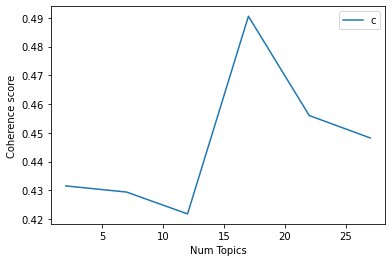

In [160]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_sg_2021_score1N2N3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [161]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_sg_2021_score1N2N3):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 17

index: 0 | Num Topics = 2  has Coherence Value of 0.4315
index: 1 | Num Topics = 7  has Coherence Value of 0.4294
index: 2 | Num Topics = 12  has Coherence Value of 0.4218
index: 3 | Num Topics = 17  has Coherence Value of 0.4905
index: 4 | Num Topics = 22  has Coherence Value of 0.456
index: 5 | Num Topics = 27  has Coherence Value of 0.4482


In [196]:
# Select optimal number of topics
optimal_model_sg_2021_score1N2N3 = model_list_sg_2021_score1N2N3[3]

In [197]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_sg_2021_score1N2N3 = pyLDAvis.gensim_models.prepare(optimal_model_sg_2021_score1N2N3, corpus_sg_2021_score1N2N3, id2word_sg_2021_score1N2N3)

In [198]:
print("pyLDAVis for SG topics for score=1,2,3 in 2021:")
vis_sg_2021_score1N2N3

pyLDAVis for SG topics for score=1,2,3 in 2021:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
16    -0.145786 -0.044401       1        1  10.501416
15    -0.086707 -0.146193       2        1  10.176140
1     -0.119111 -0.002351       3        1   8.226373
4      0.123456 -0.064137       4        1   7.369452
9     -0.047538  0.130869       5        1   7.366793
13    -0.031500 -0.127391       6        1   6.849276
7      0.135018 -0.012952       7        1   6.241091
8      0.130428 -0.015323       8        1   6.226887
0     -0.064542  0.054455       9        1   6.122807
10    -0.023650  0.107606      10        1   6.035622
14    -0.005817  0.014994      11        1   5.613885
3     -0.009792  0.040063      12        1   4.509619
2     -0.008432  0.076422      13        1   4.293864
5      0.037483 -0.059135      14        1   4.252179
12     0.072116  0.060110      15        1   3.648687
11     0.017118  0.014360      16        1   1.483455
6      0.027255 -0.026996      17        1   1.082454, topic_info=           Term       Freq      Total Category  logprob  loglift
55       update  11.000000  11.000000  Default  30.0000  30.0000
25           ad  16.000000  16.000000  Default  29.0000  29.0000
8         video  37.000000  37.000000  Default  28.0000  28.0000
228         add   5.000000   5.000000  Default  27.0000  27.0000
10          app  10.000000  10.000000  Default  26.0000  26.0000
..          ...        ...        ...      ...      ...      ...
336          hi   0.017311   1.356072  Topic17  -6.2126   0.1649
321   algorithm   0.017311   1.356072  Topic17  -6.2126   0.1649
331  definitely   0.017311   1.356072  Topic17  -6.2126   0.1649
342   superchat   0.017311   1.356072  Topic17  -6.2126   0.1649
5          keep   0.017311   7.057393  Topic17  -6.2126  -1.4846

[722 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
358       8  0.757591        able
320       4  0.713815     account
76        2  0.719617      action
25        1  0.122693          ad
25        2  0.245386          ad
...     ...       ...         ...
307       3  0.493223         yet
307       9  0.493223         yet
85        2  0.719617        zoom
86       10  0.769897  小孩子的儿歌广告太多
87       10  0.769897  点击开真的什么都不是

[620 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[17, 16, 2, 5, 10, 14, 8, 9, 1, 11, 15, 4, 3, 6, 13, 12, 7])

# Export pyLDAvis as html

In [199]:
# Overall
pyLDAvis.save_html(vis_sg,'youtube_vis_sg.html')

# By-rating 
pyLDAvis.save_html(vis_sg_score1,'youtube_vis_sg_score1.html')
pyLDAvis.save_html(vis_sg_score2,'youtube_vis_sg_score2.html')
pyLDAvis.save_html(vis_sg_score3,'youtube_vis_sg_score3.html')
pyLDAvis.save_html(vis_sg_score4,'youtube_vis_sg_score4.html')
pyLDAvis.save_html(vis_sg_score5,'youtube_vis_sg_score5.html')
pyLDAvis.save_html(vis_sg_score1N2N3,'youtube_vis_sg_score1N2N3.html')

# By-rating of each year
pyLDAvis.save_html(vis_sg_2021_score1N2N3,'youtube_vis_sg_2021_score1N2N3.html')
pyLDAvis.save_html(vis_sg_2020_score1N2N3,'youtube_vis_sg_2020_score1N2N3.html')
pyLDAvis.save_html(vis_sg_2019_score1N2N3,'youtube_vis_sg_2019_score1N2N3.html')
pyLDAvis.save_html(vis_sg_2018_score1N2N3,'youtube_vis_sg_2018_score1N2N3.html')

